### 平均地価との差分等を加えていく

LogRegressionPredictor...logを取ってクロスバリデーションで学習してくれるクラス  
save_data...trainの予測値と,testの予測値をいつも同じ形で保存するための関数  

In [111]:
# coding:utf-8
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import datetime
import seaborn as sns
sns.set()
import matplotlib

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)


import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor,LogRegressionPredictor
import japanize_matplotlib
from utils import save_data
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
SEED=1234
n_splits=10

In [217]:
train=pd.read_csv('../higuchi/input/prep_train1105.csv')
test=pd.read_csv('../higuchi/input/prep_test1105.csv')
#train=pd.read_csv('../higuchi/input/train.csv')
#test=pd.read_csv('../higuchi/input/test.csv')
y_train = train['賃料']

In [218]:
drop_col = ['id']

## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)

### clustering

In [15]:
def get_loc_type(data,out_col='loc_type'):
    '''緯度経度による、グリッドを作成'''
    data2=data.copy()
    data2[out_col]=0
    count=0
    for i in range(1,12):
        for j in range(11):
            data2.loc[data2.query(f'139.56+{i*0.03}<loc_lon<139.56+{(i+1)*0.03}&35.53+{j*0.03}<loc_lat<35.53+{(j+i)*0.03}').index.values,out_col]=count
            print(count,end='')
            print(data2.query(f'139.56+{i*0.03}<loc_lon<139.56+{(i+1)*0.03}&35.53+{j*0.03}<loc_lat<35.53+{(j+i)*0.03}').index.shape)
            count+=1
    return data2

# X_train['loc_type']=get_loc_type(X_train)
# X_test['loc_type']=get_loc_type(X_test)

In [37]:
def get_Kmeans(X_train,X_test,n_clusters=300,cols=['loc_lat','loc_lon','築年数'],out_col='km_type_with_age'):
    std=StandardScaler()
    
    X = X_train[cols]
    X2= X_test[cols]
    Z=pd.concat([X,X2],axis=0)
    Z=std.fit_transform(Z)

    pred = KMeans(n_clusters=n_clusters).fit_predict(Z)
    X_train[out_col]=pred[:X_train.shape[0]]
    X_test[out_col]=pred[X_train.shape[0]:]
    return X_train,X_test

In [33]:
X_train['地価'] = X_train['賃料'] / X_train['面積']

  0%|          | 0/100 [00:00<?, ?it/s]

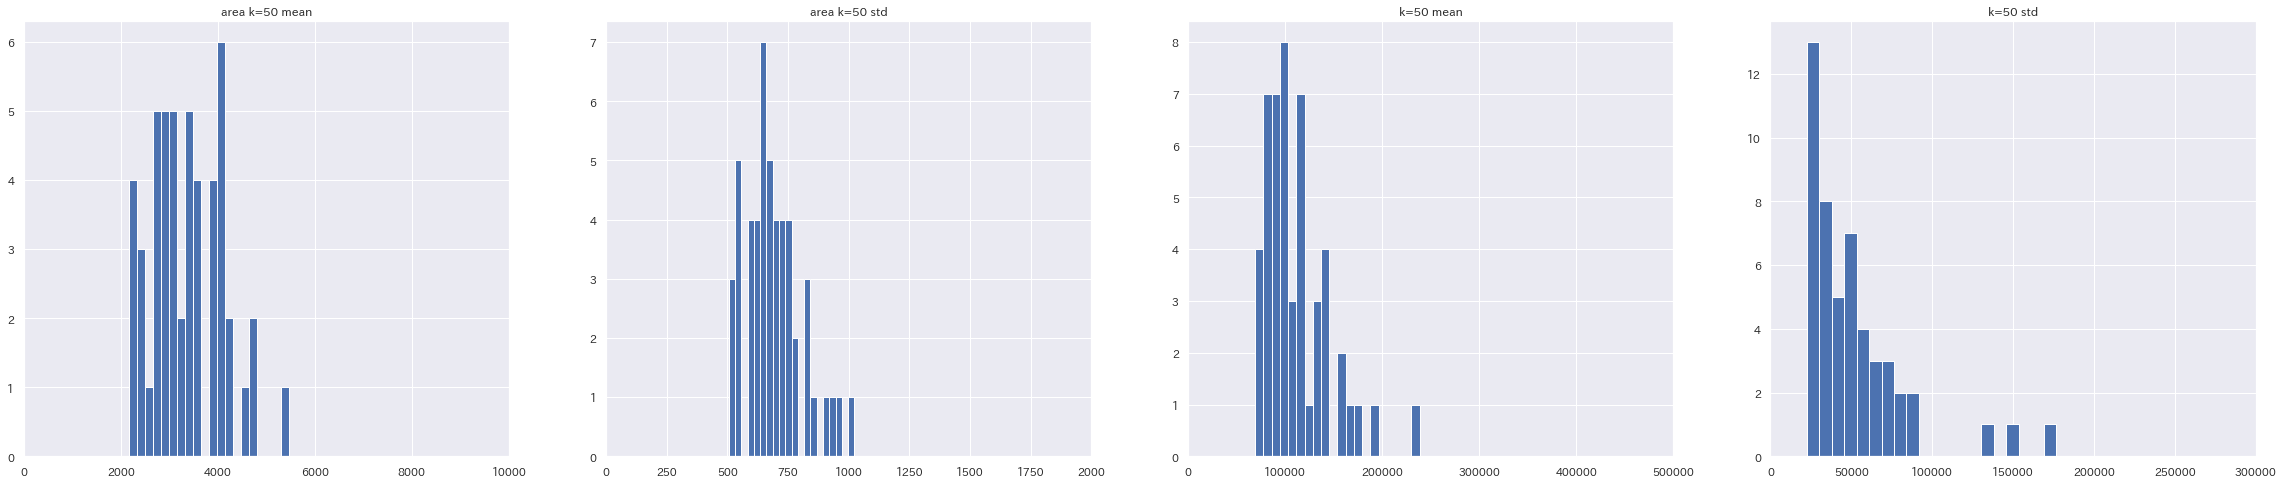

  1%|          | 1/100 [00:17<29:09, 17.68s/it]

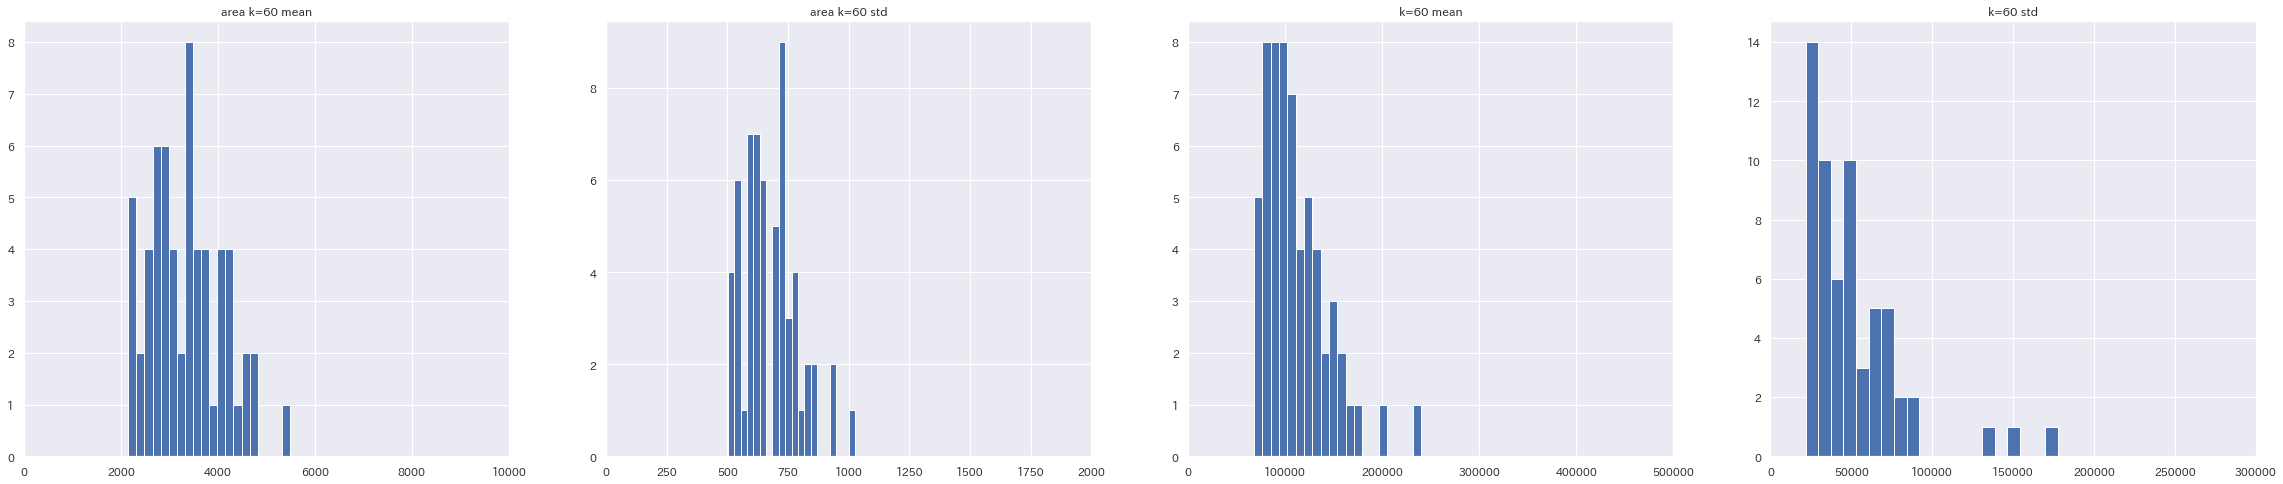

  2%|▏         | 2/100 [00:37<29:44, 18.21s/it]

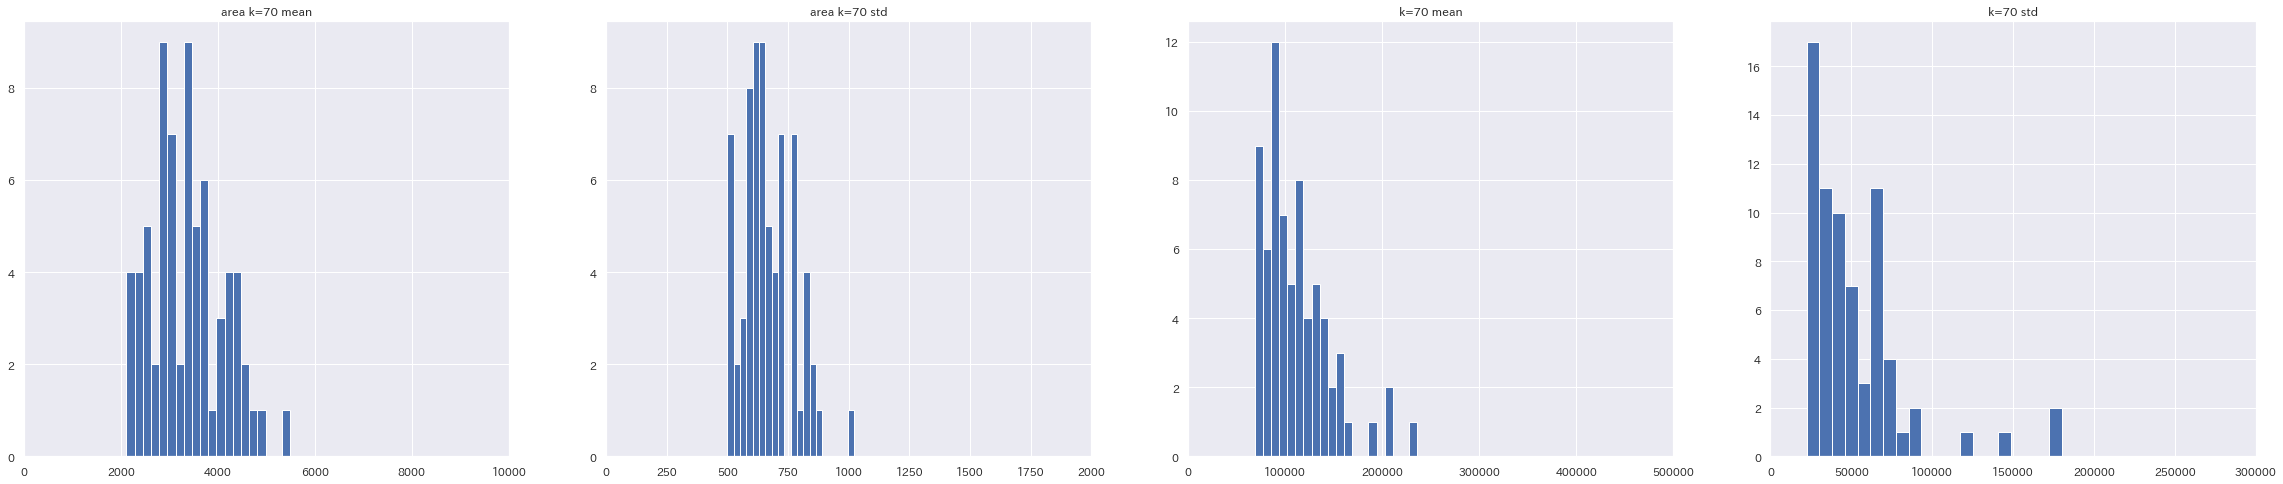

  3%|▎         | 3/100 [01:00<31:50, 19.69s/it]

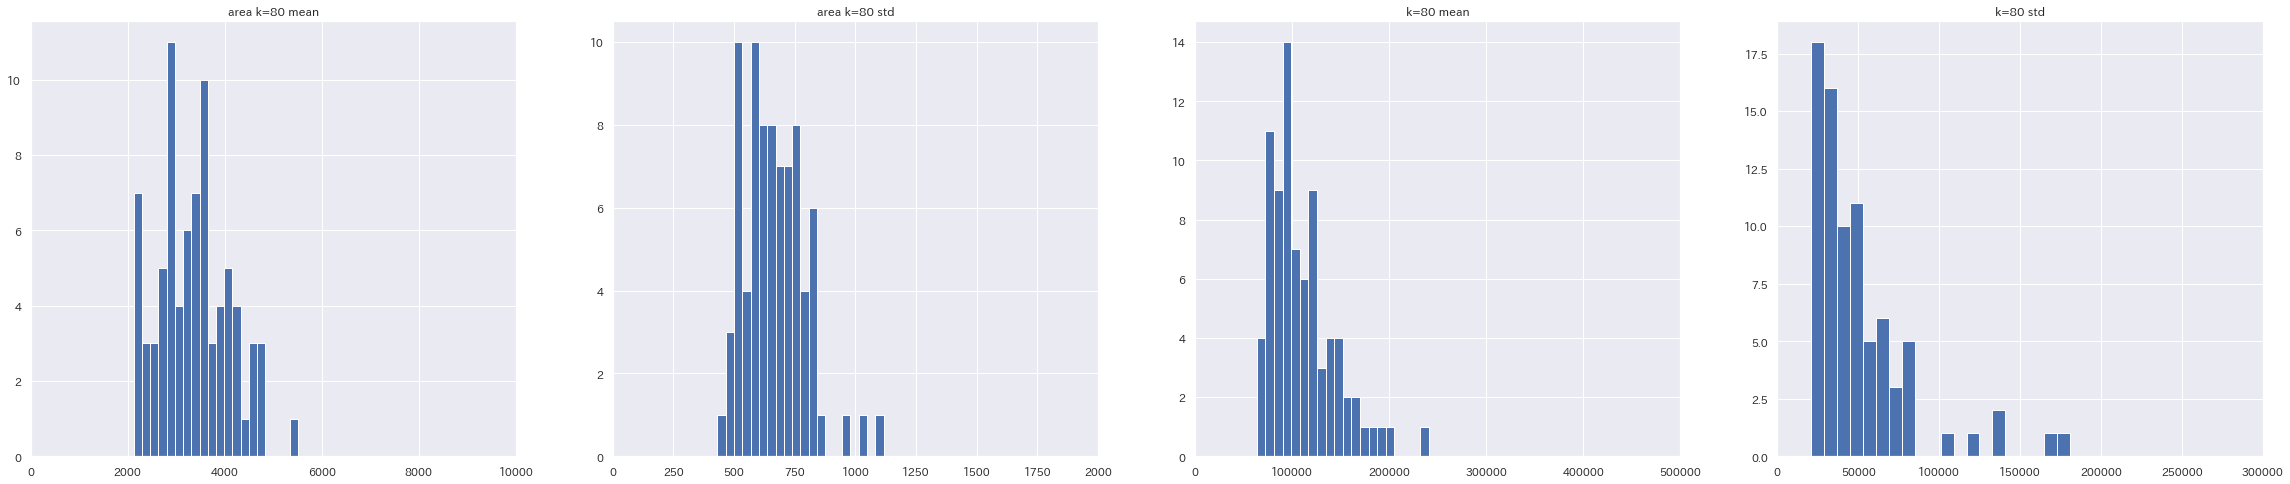

  4%|▍         | 4/100 [01:29<36:15, 22.66s/it]

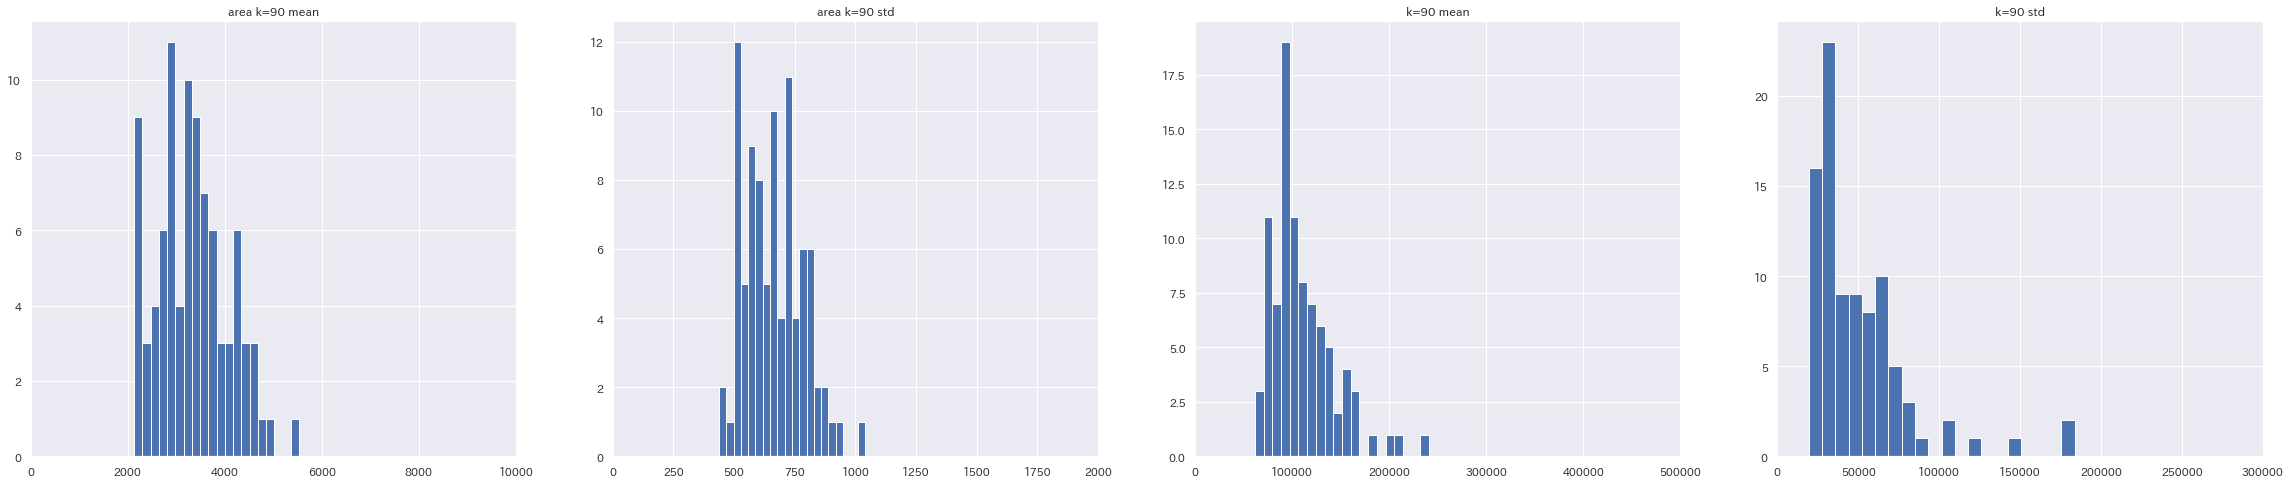

  5%|▌         | 5/100 [01:58<38:55, 24.58s/it]

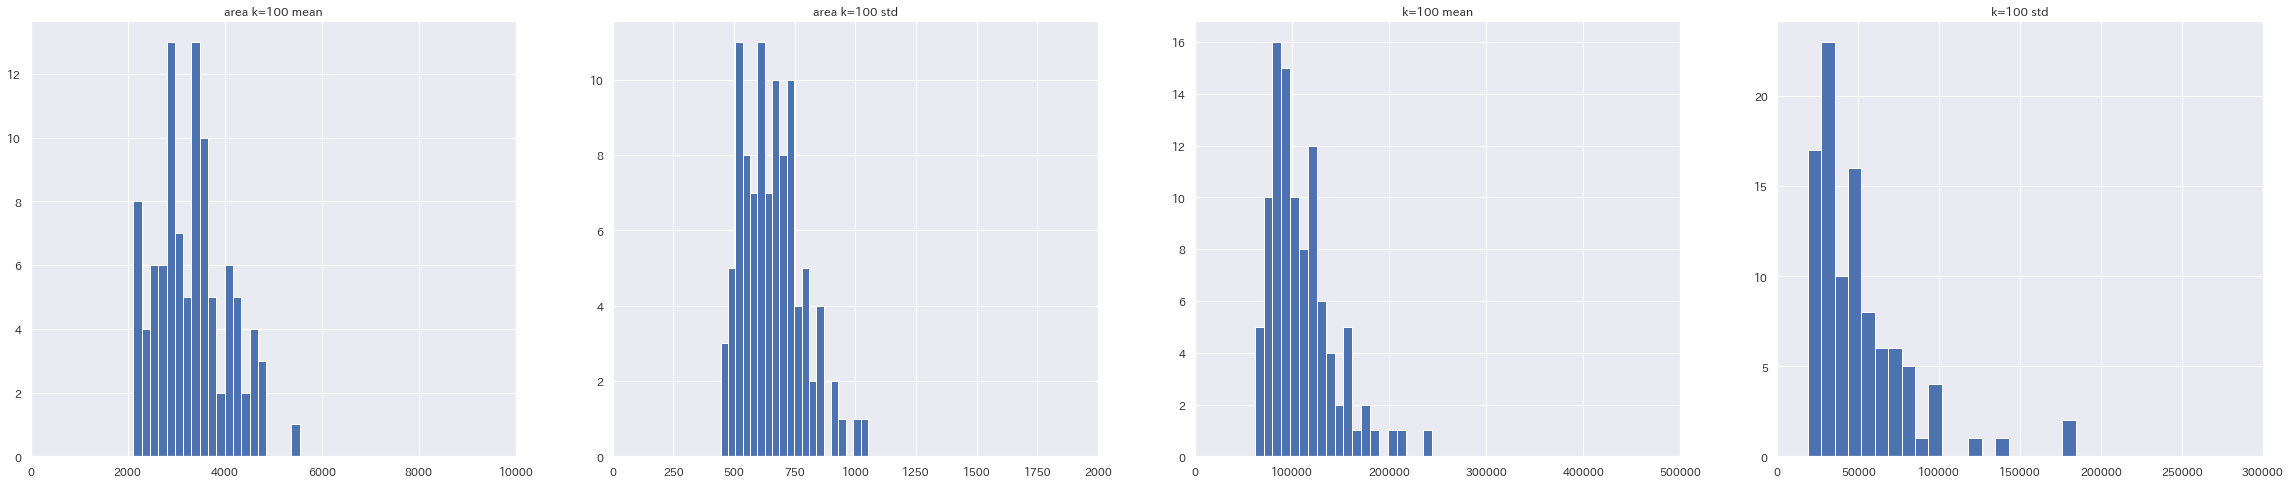

  6%|▌         | 6/100 [02:32<42:45, 27.29s/it]

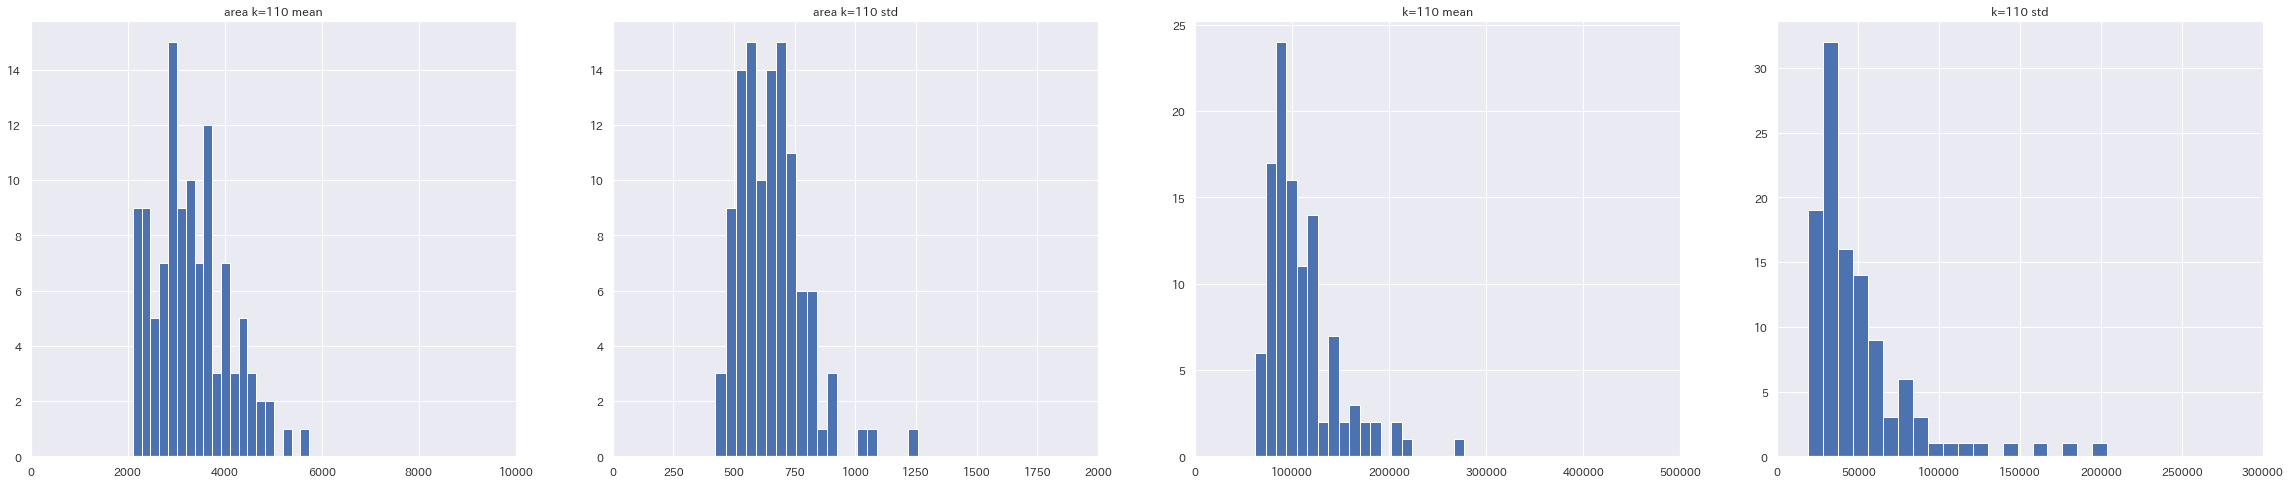

  7%|▋         | 7/100 [03:06<45:20, 29.26s/it]

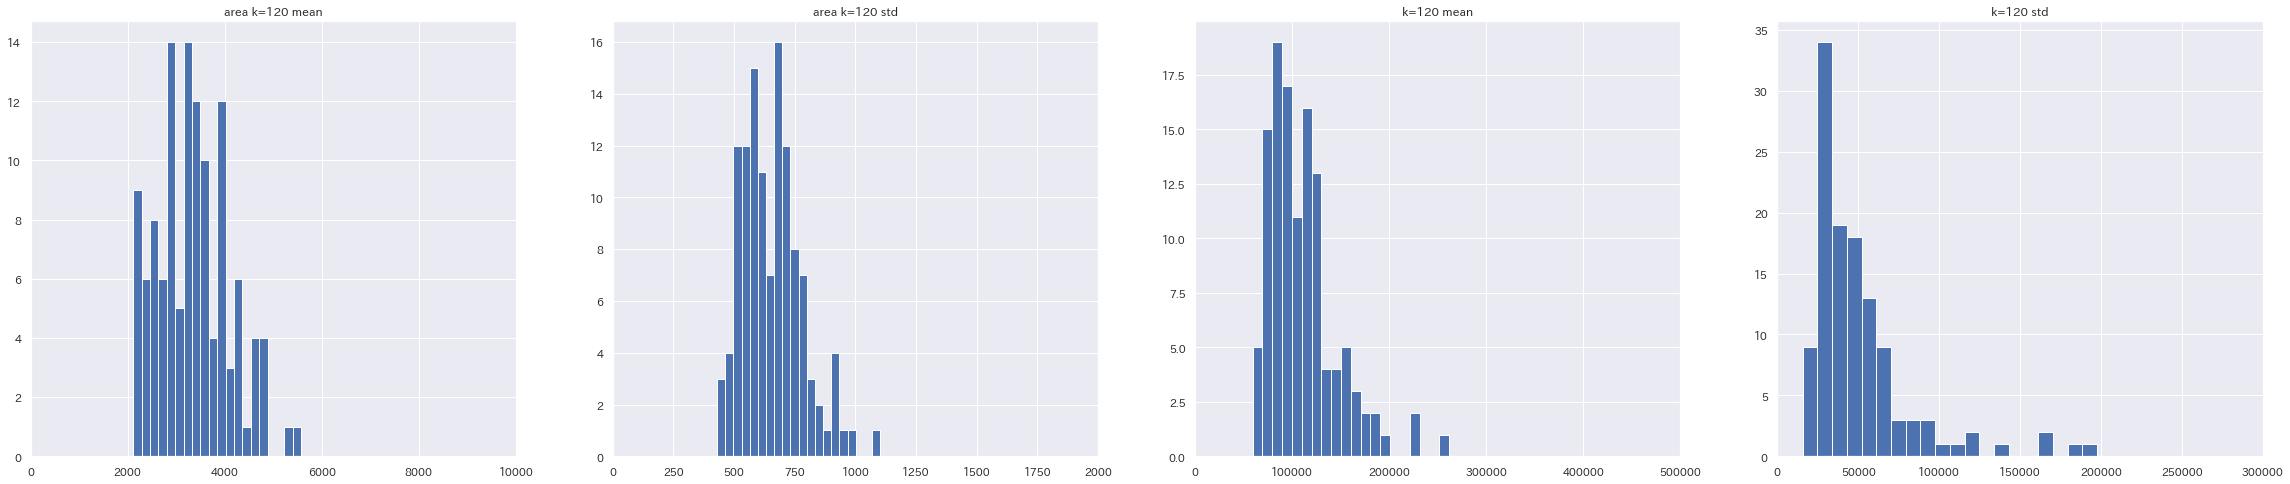

  8%|▊         | 8/100 [03:44<48:53, 31.89s/it]

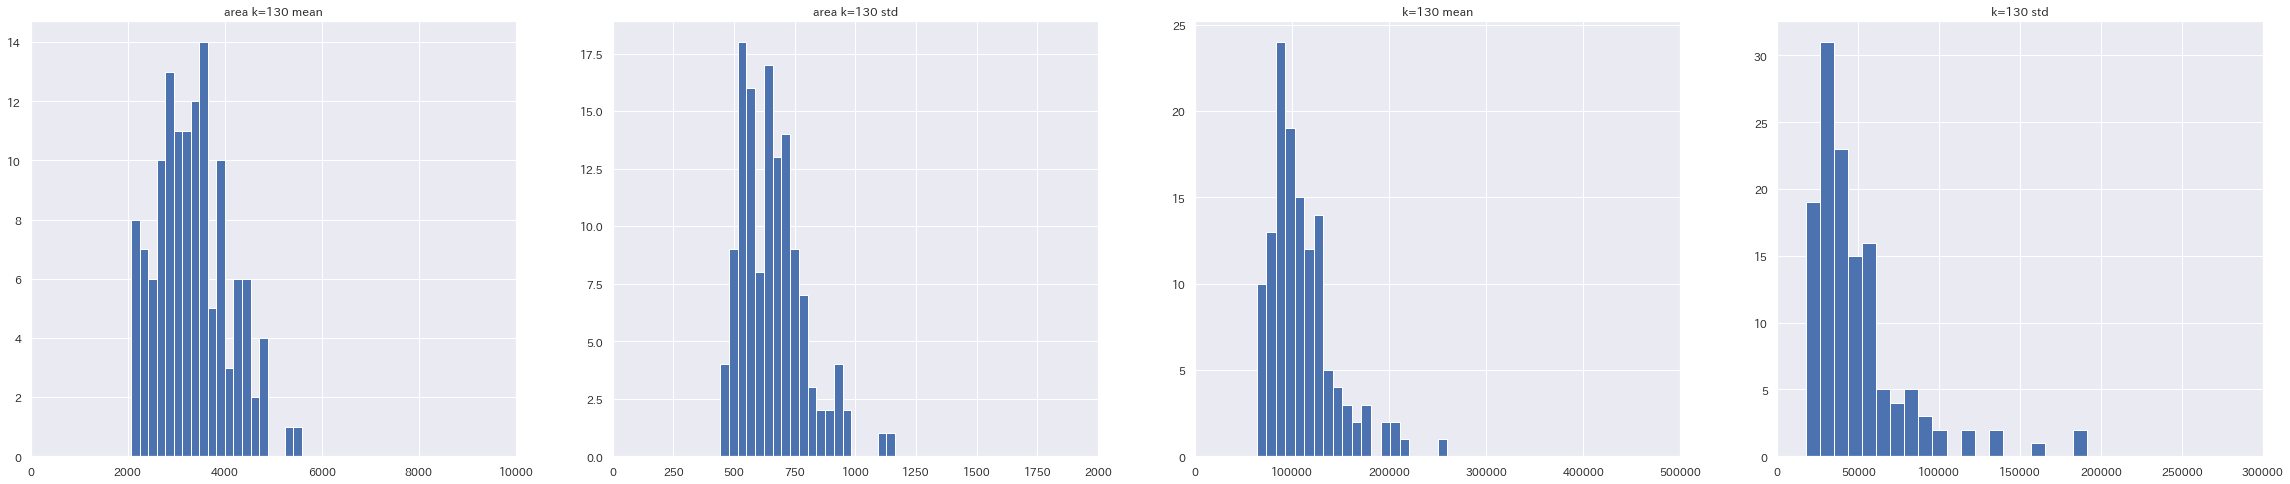

  9%|▉         | 9/100 [04:25<52:29, 34.61s/it]

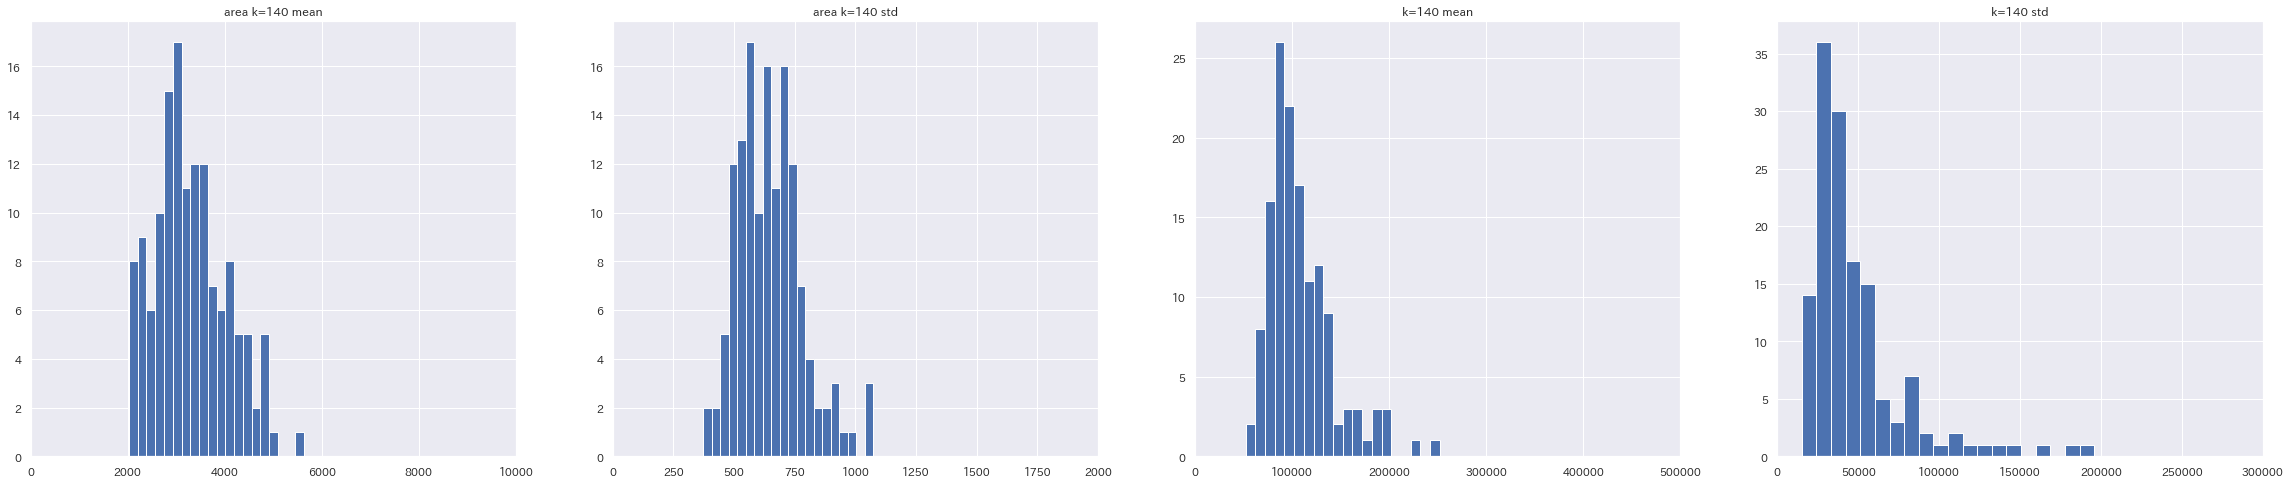

 10%|█         | 10/100 [05:09<56:04, 37.38s/it]

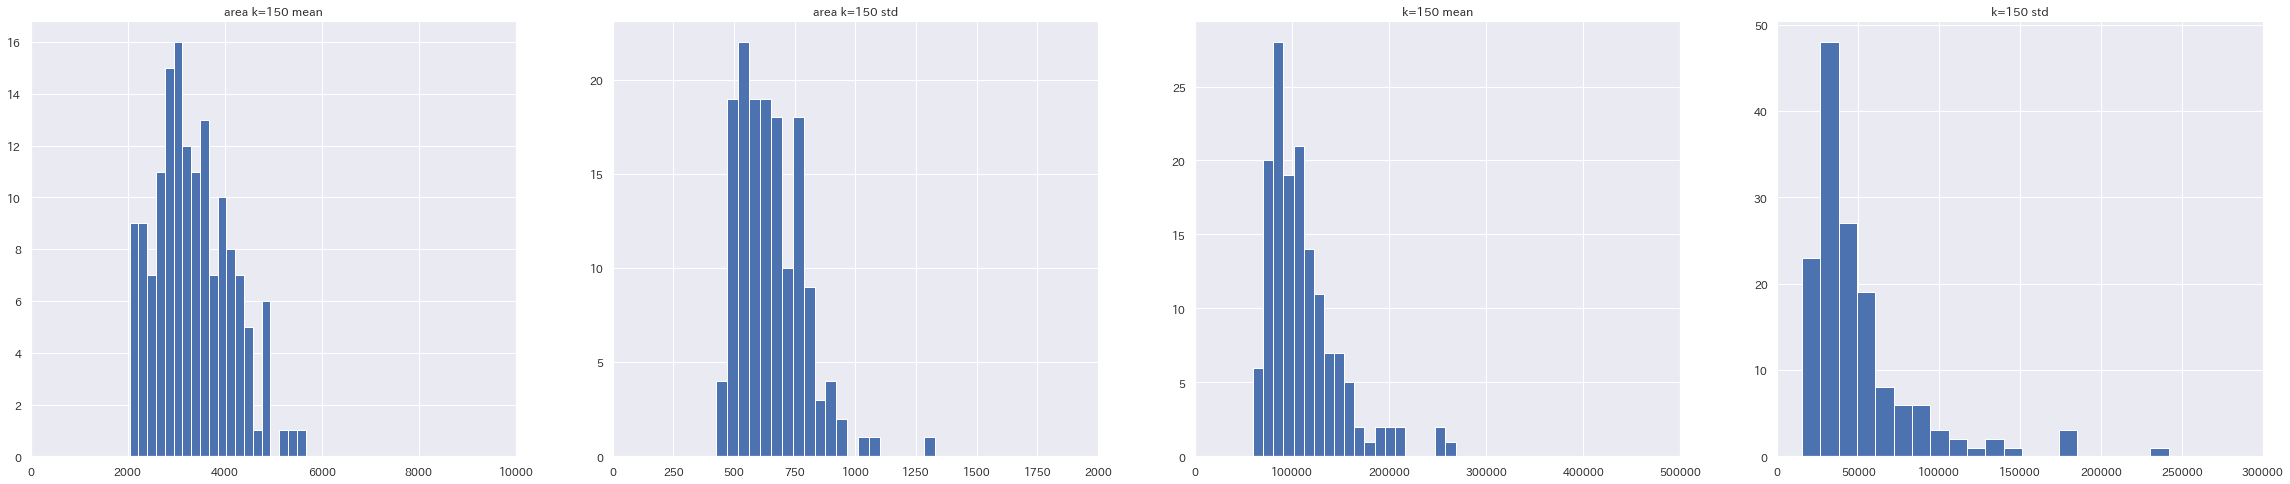

 11%|█         | 11/100 [05:58<1:00:55, 41.07s/it]

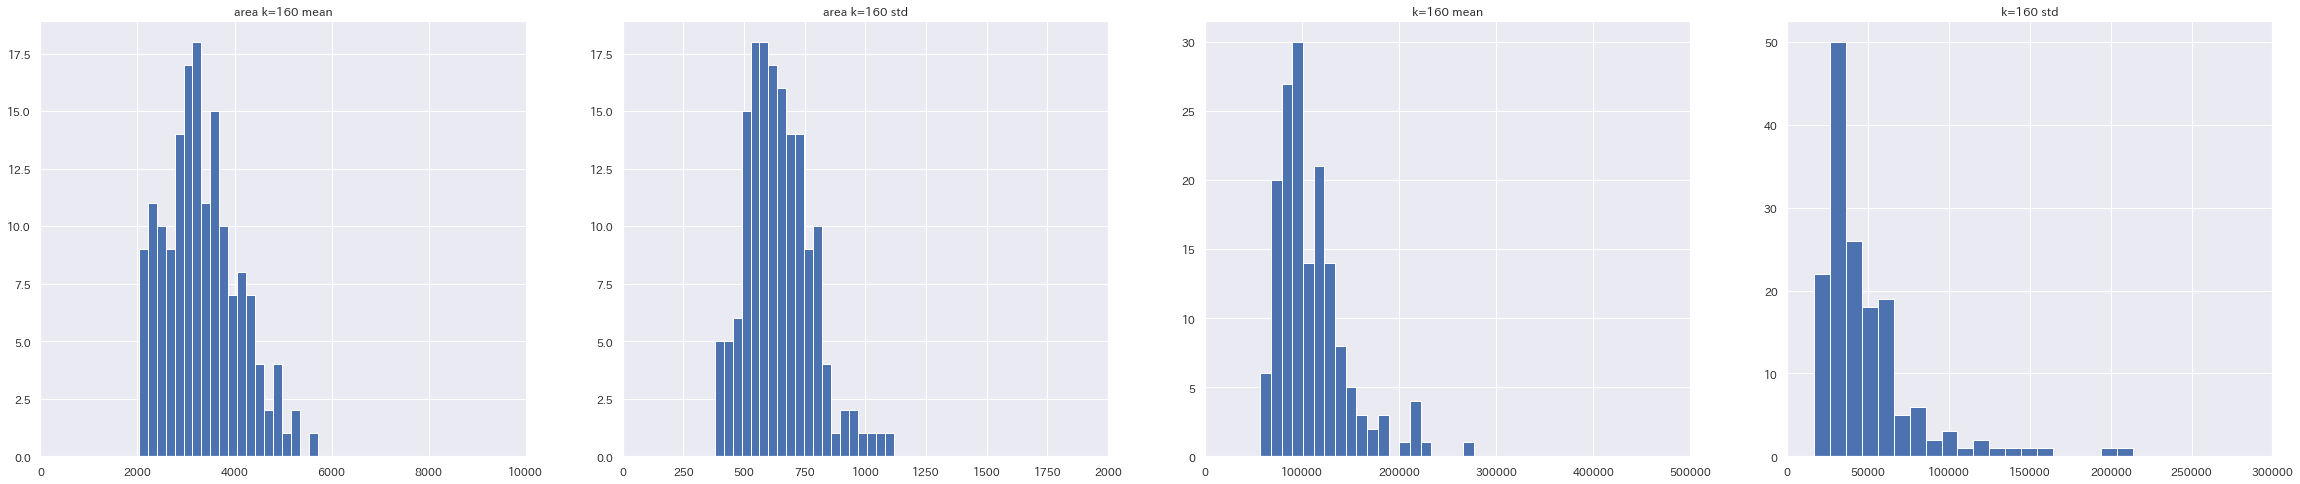

 12%|█▏        | 12/100 [06:44<1:02:05, 42.34s/it]

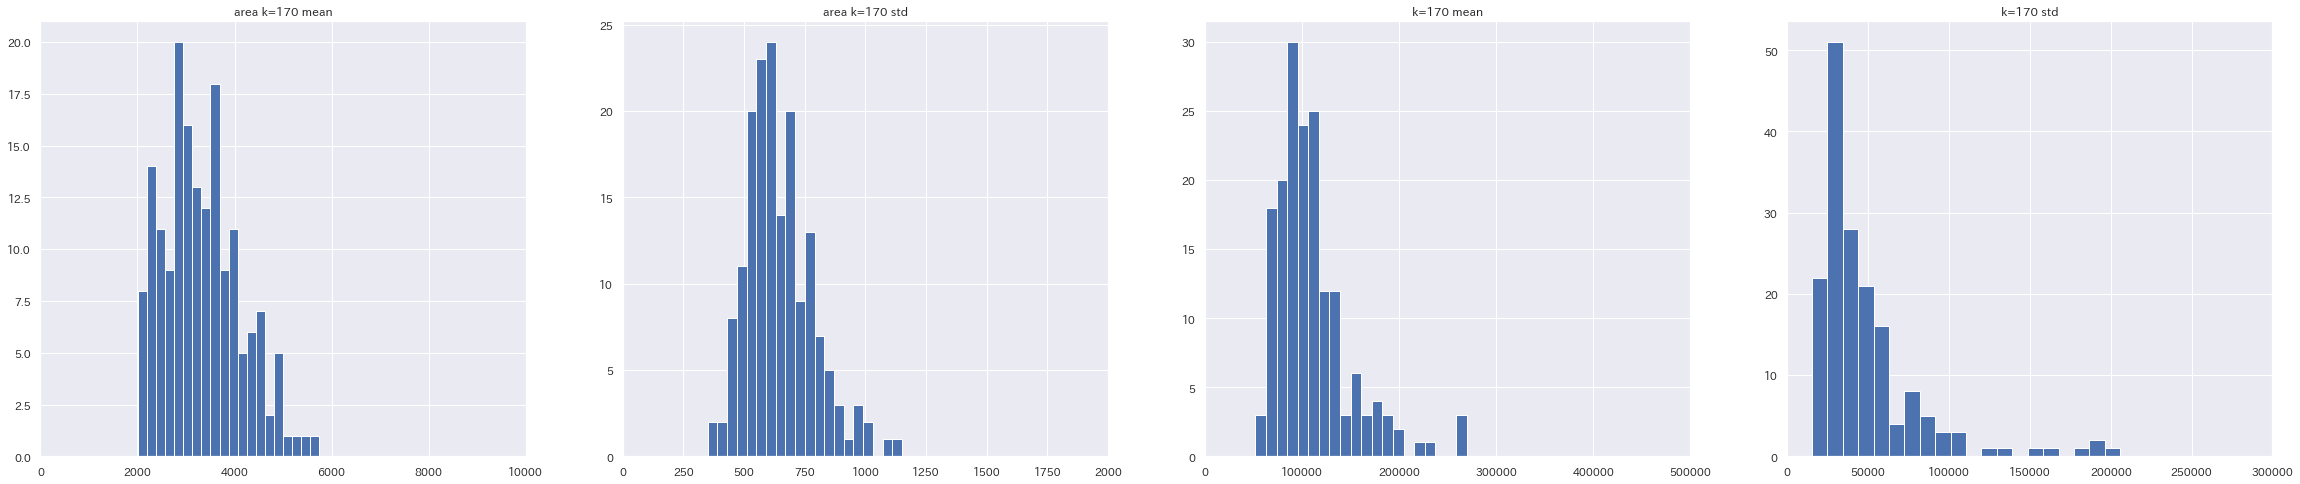

 13%|█▎        | 13/100 [07:37<1:06:14, 45.69s/it]

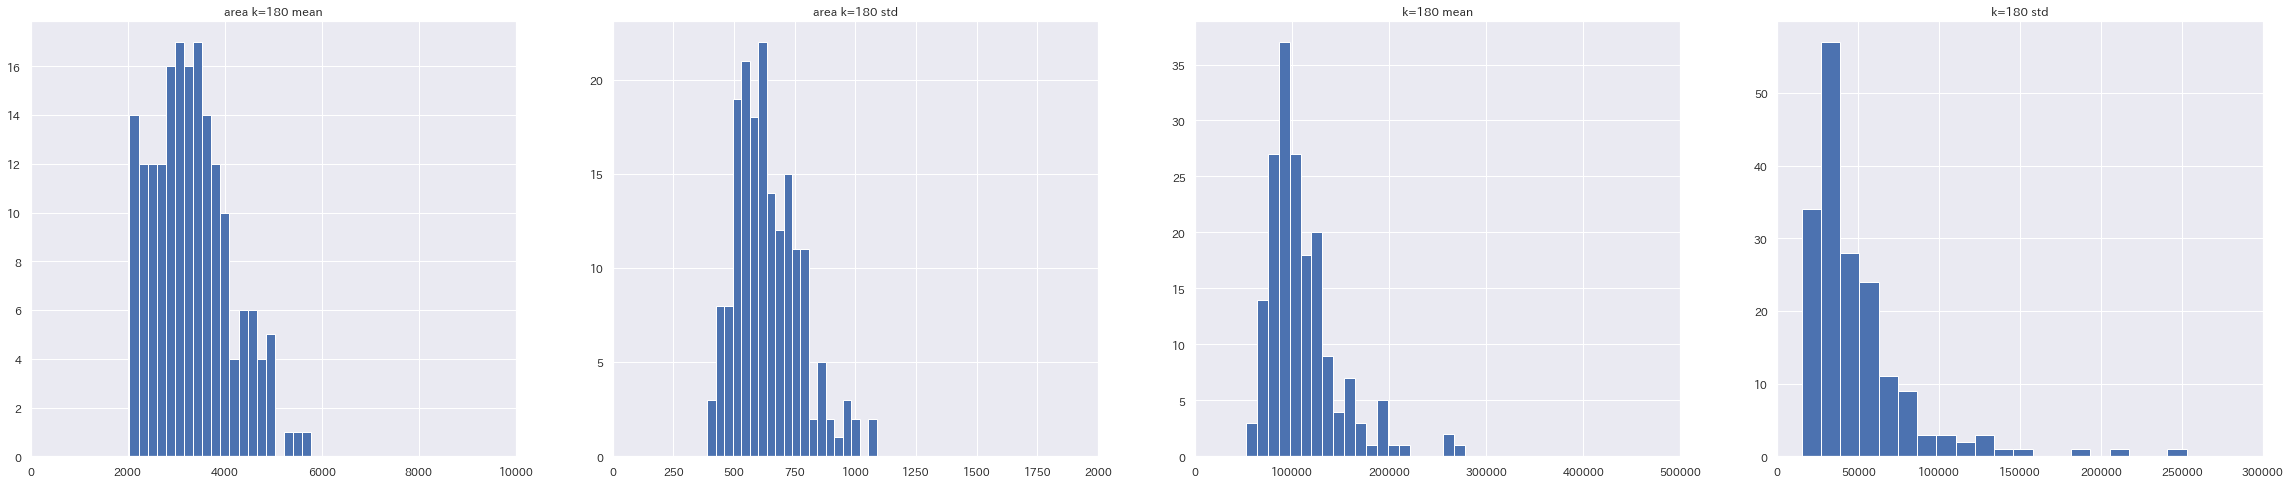

 14%|█▍        | 14/100 [08:30<1:08:32, 47.82s/it]

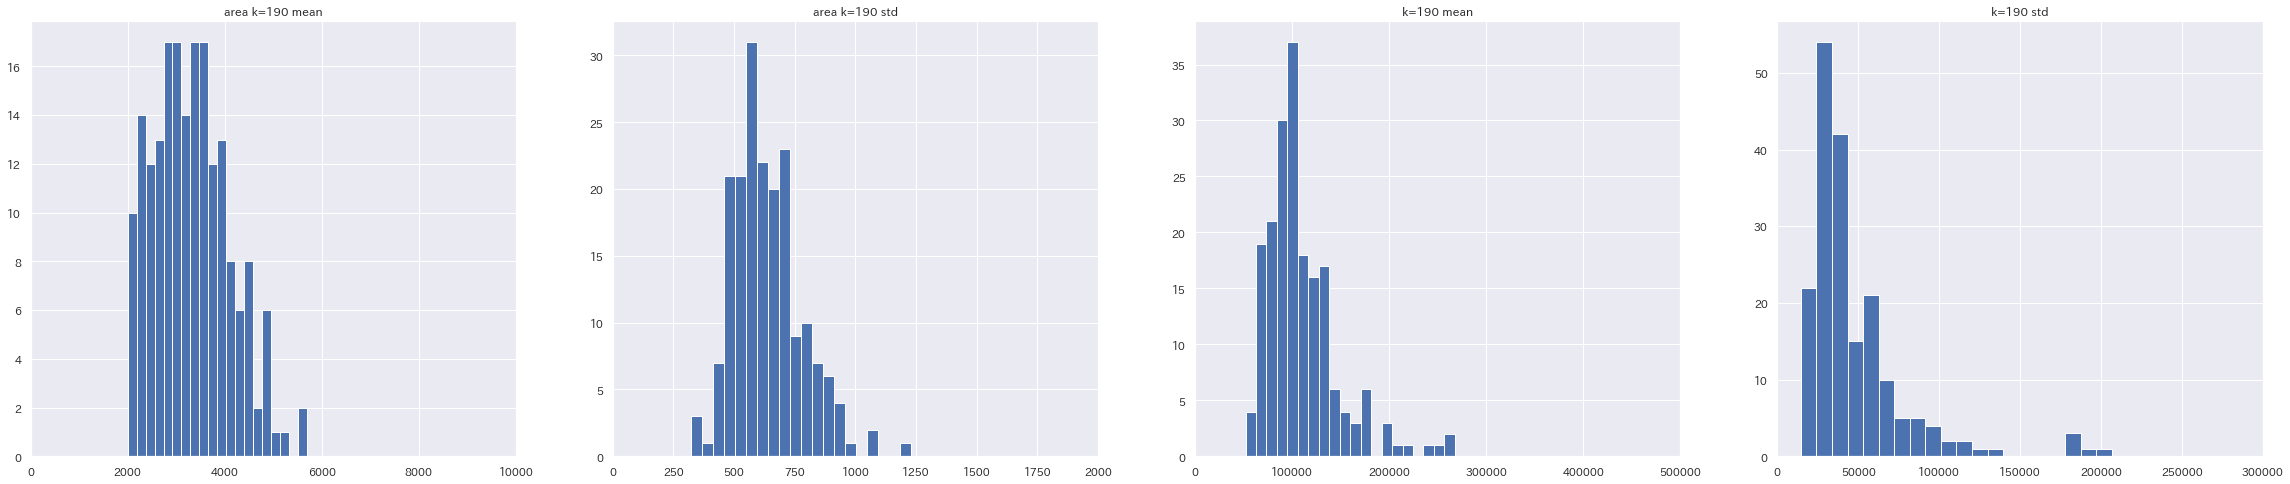

 15%|█▌        | 15/100 [09:27<1:11:50, 50.71s/it]

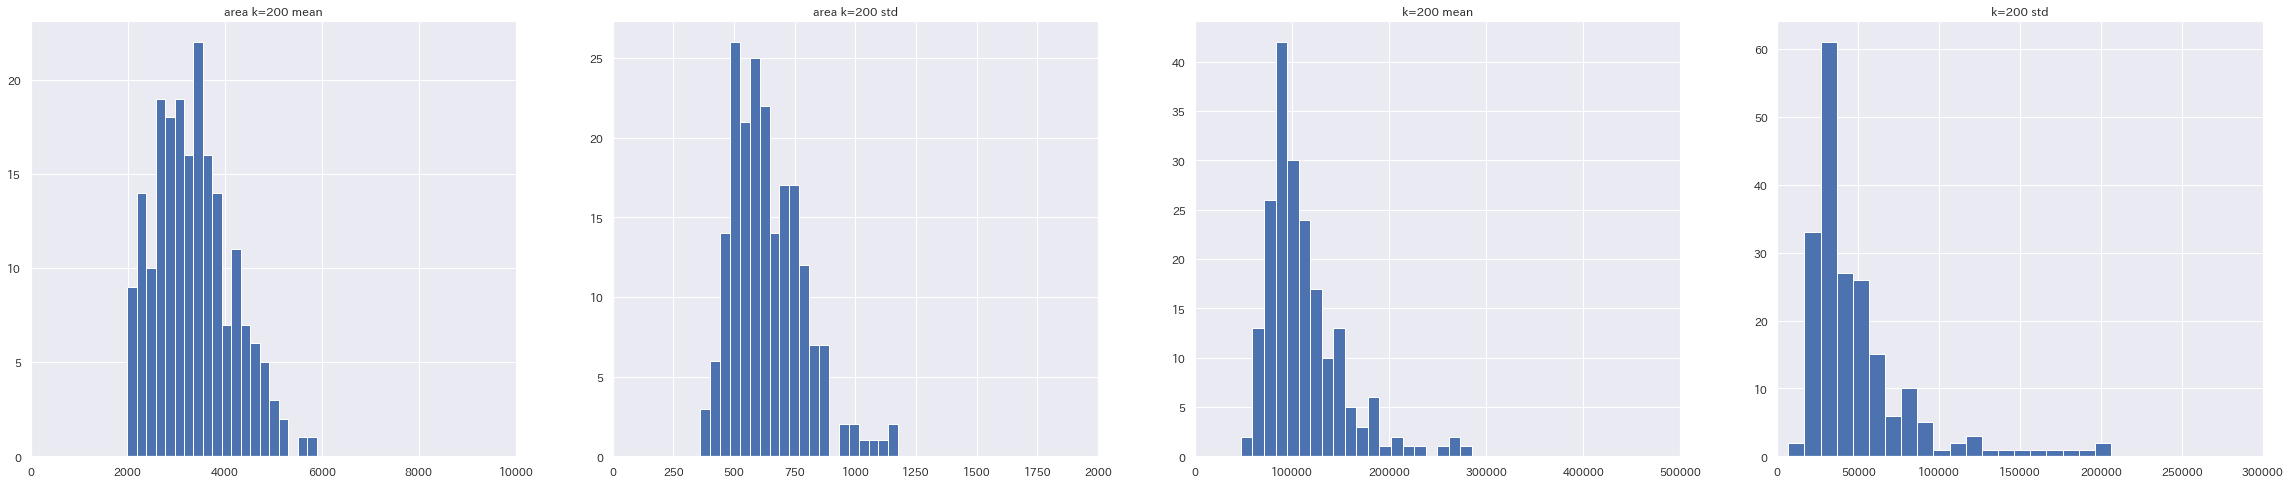

 16%|█▌        | 16/100 [10:25<1:13:55, 52.81s/it]

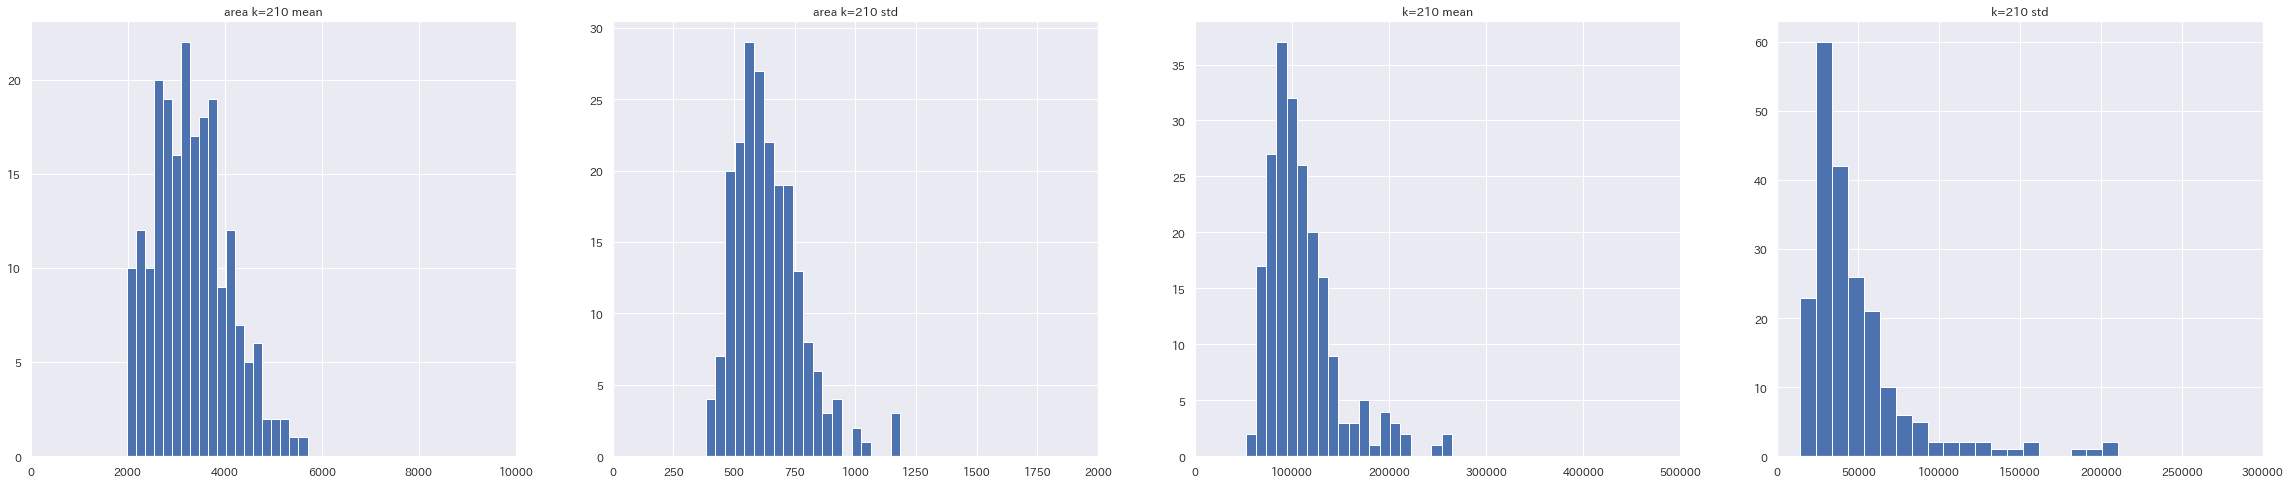

 17%|█▋        | 17/100 [11:22<1:14:39, 53.97s/it]

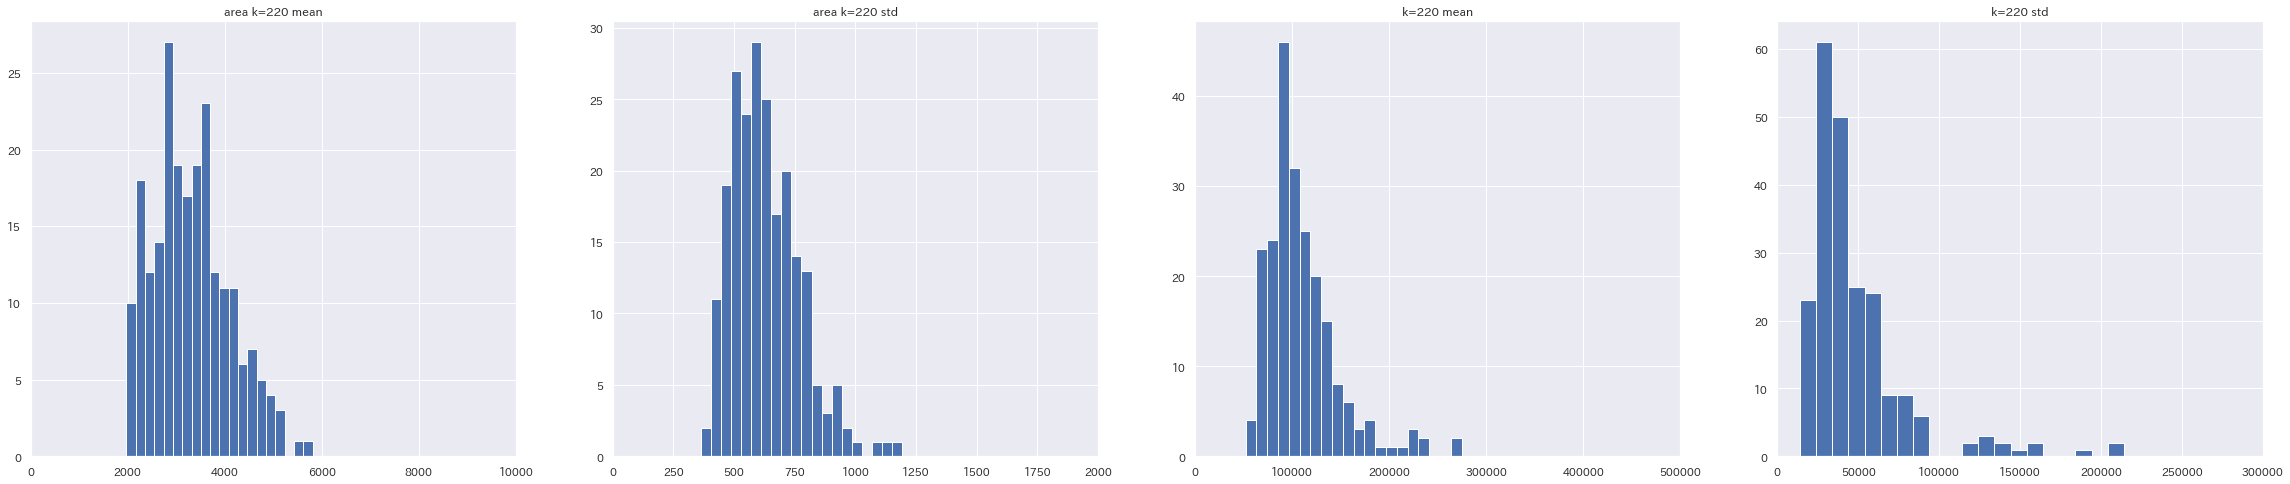

 18%|█▊        | 18/100 [12:21<1:15:52, 55.52s/it]

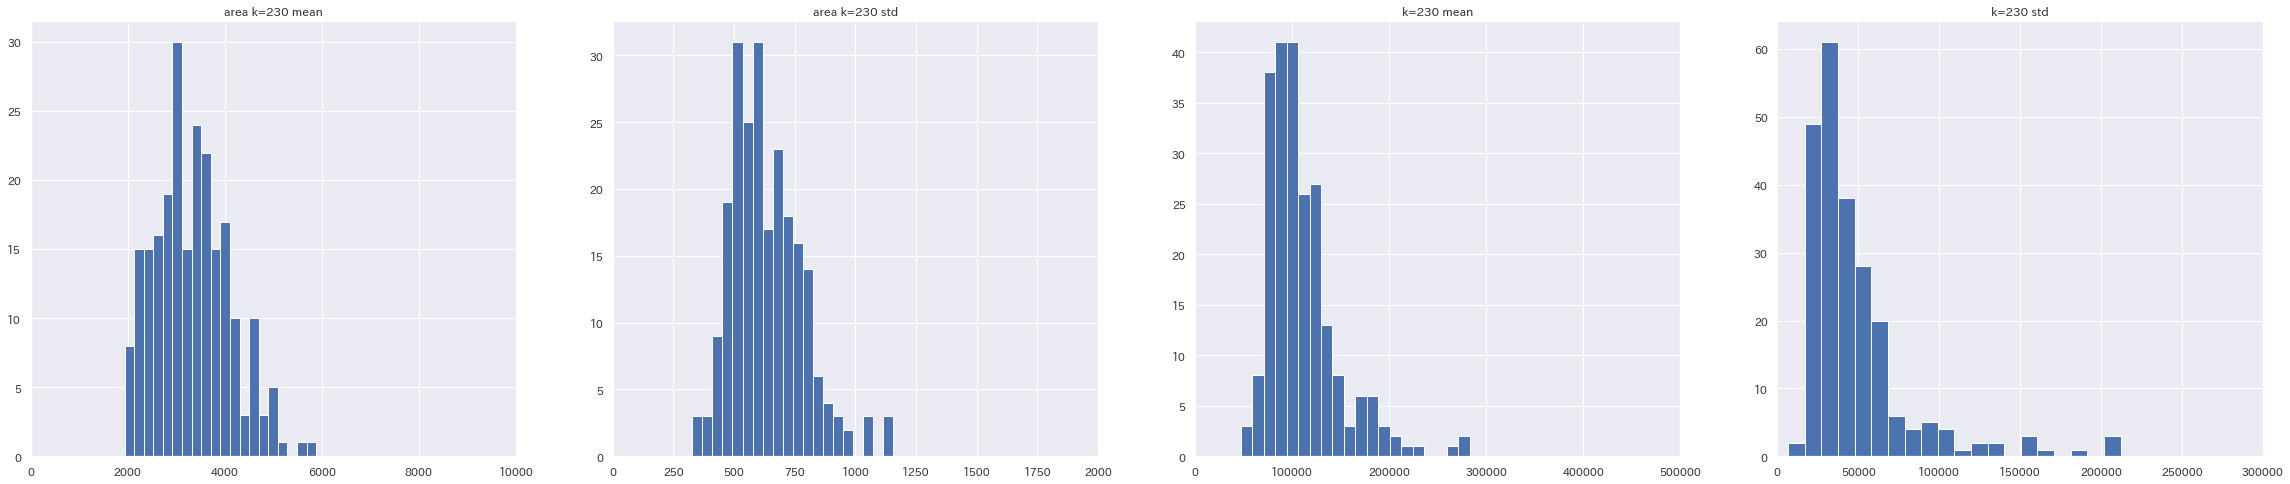

 19%|█▉        | 19/100 [13:16<1:14:54, 55.49s/it]

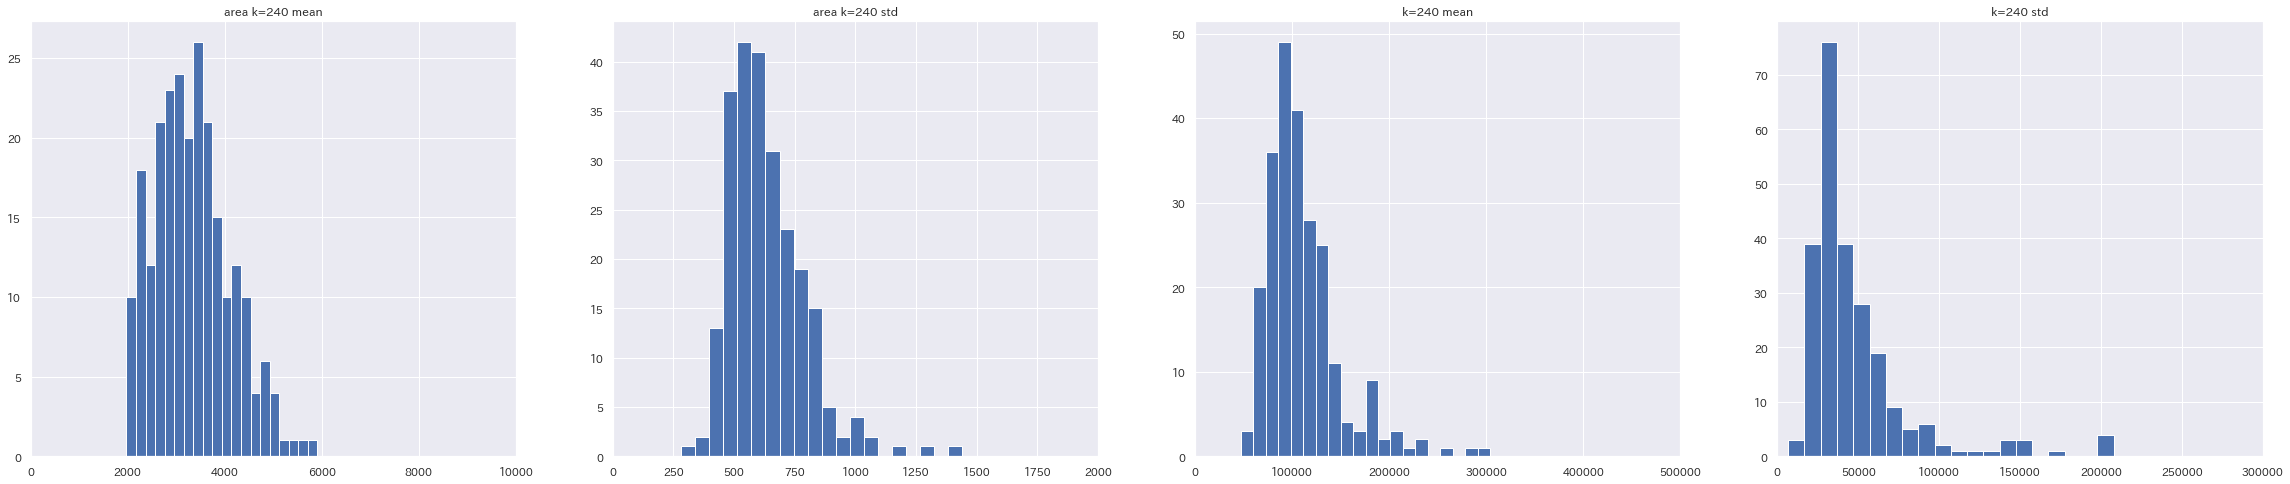

 20%|██        | 20/100 [14:14<1:14:47, 56.09s/it]

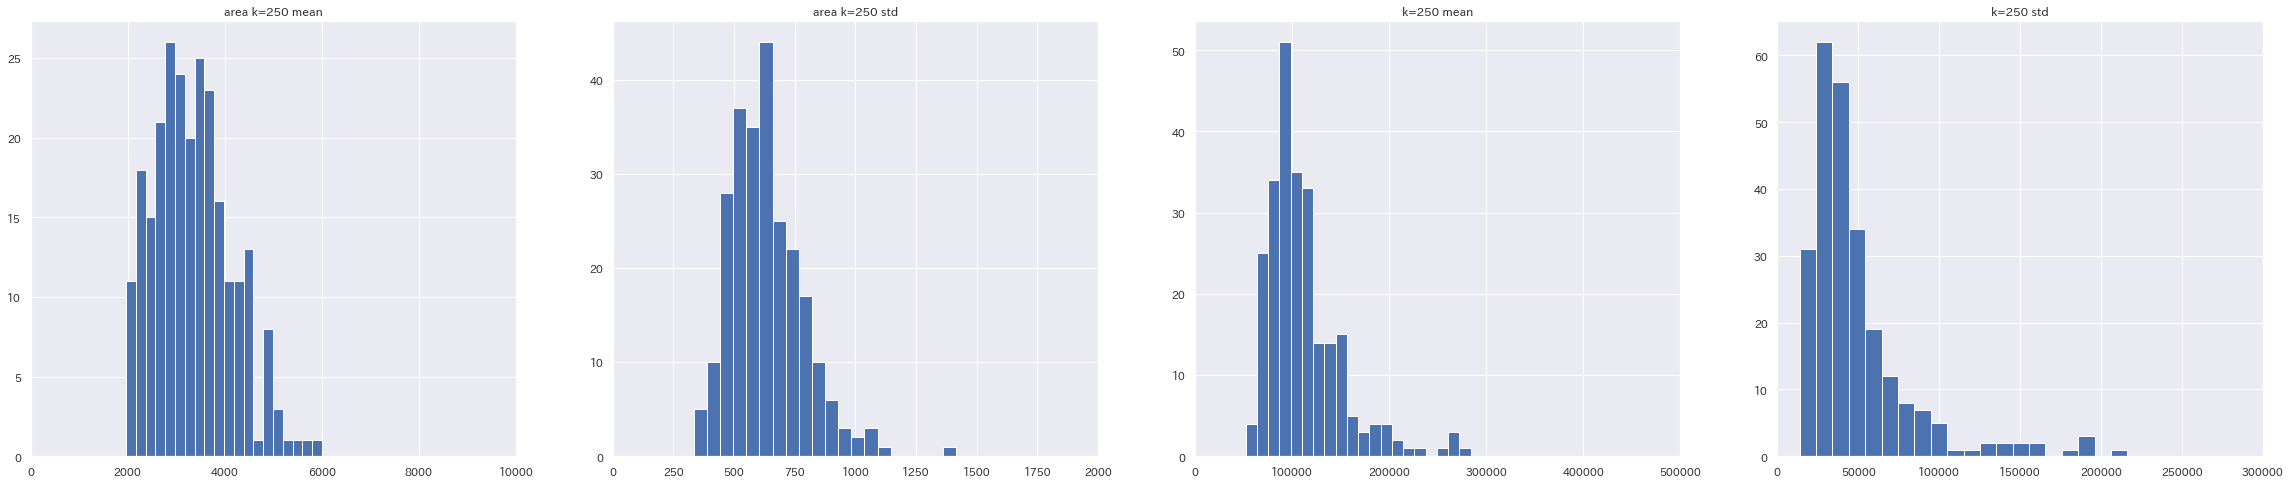

 21%|██        | 21/100 [15:10<1:13:50, 56.08s/it]

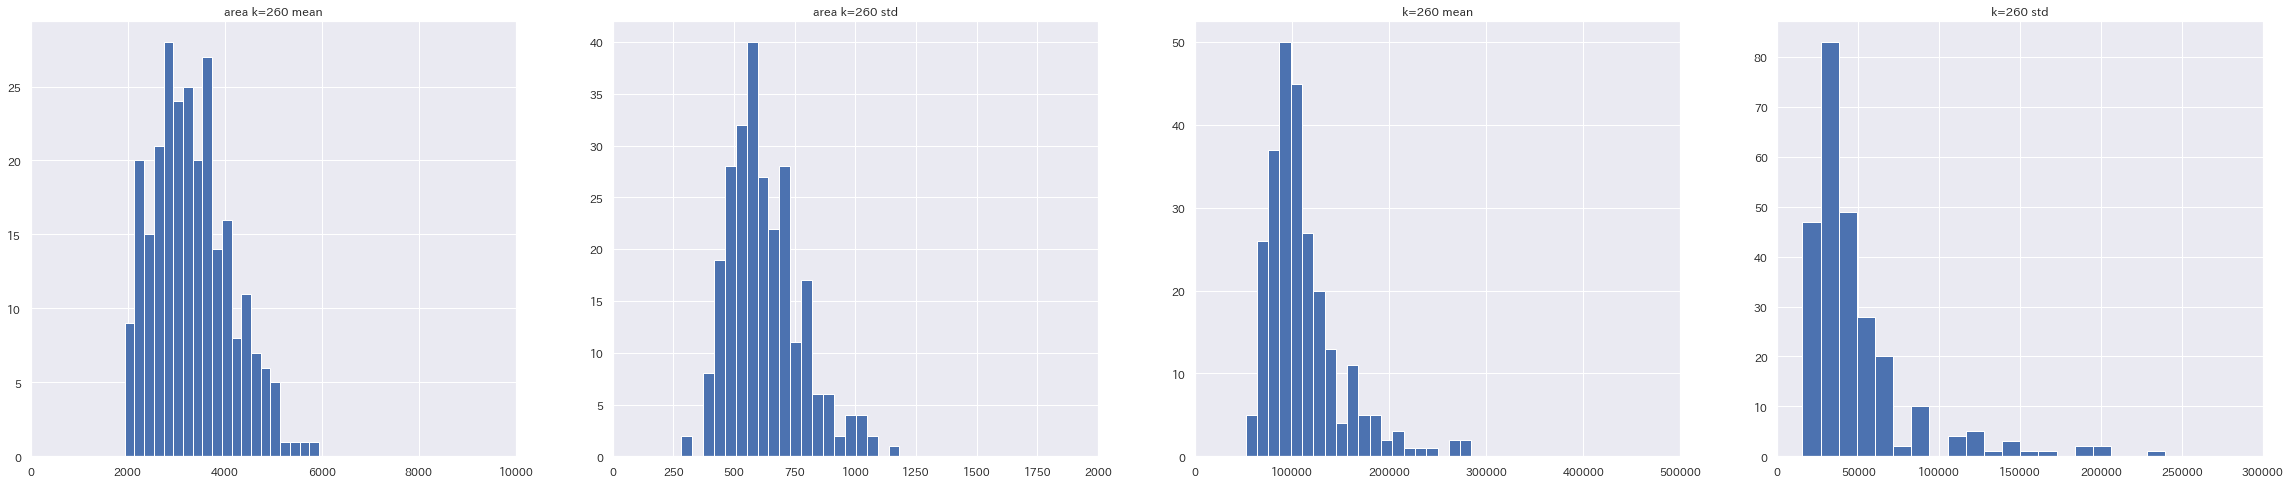

 22%|██▏       | 22/100 [16:16<1:16:42, 59.00s/it]

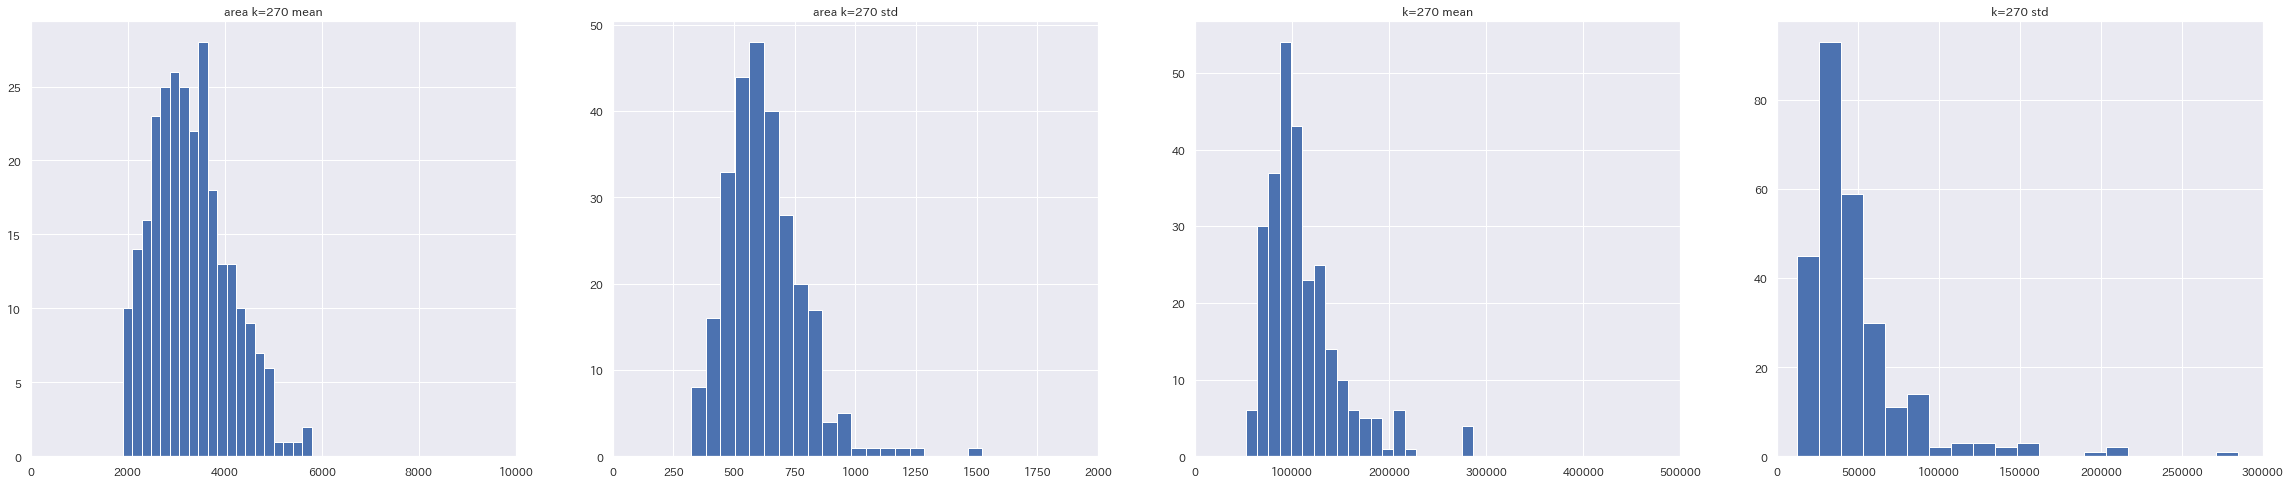

 23%|██▎       | 23/100 [17:23<1:18:52, 61.46s/it]

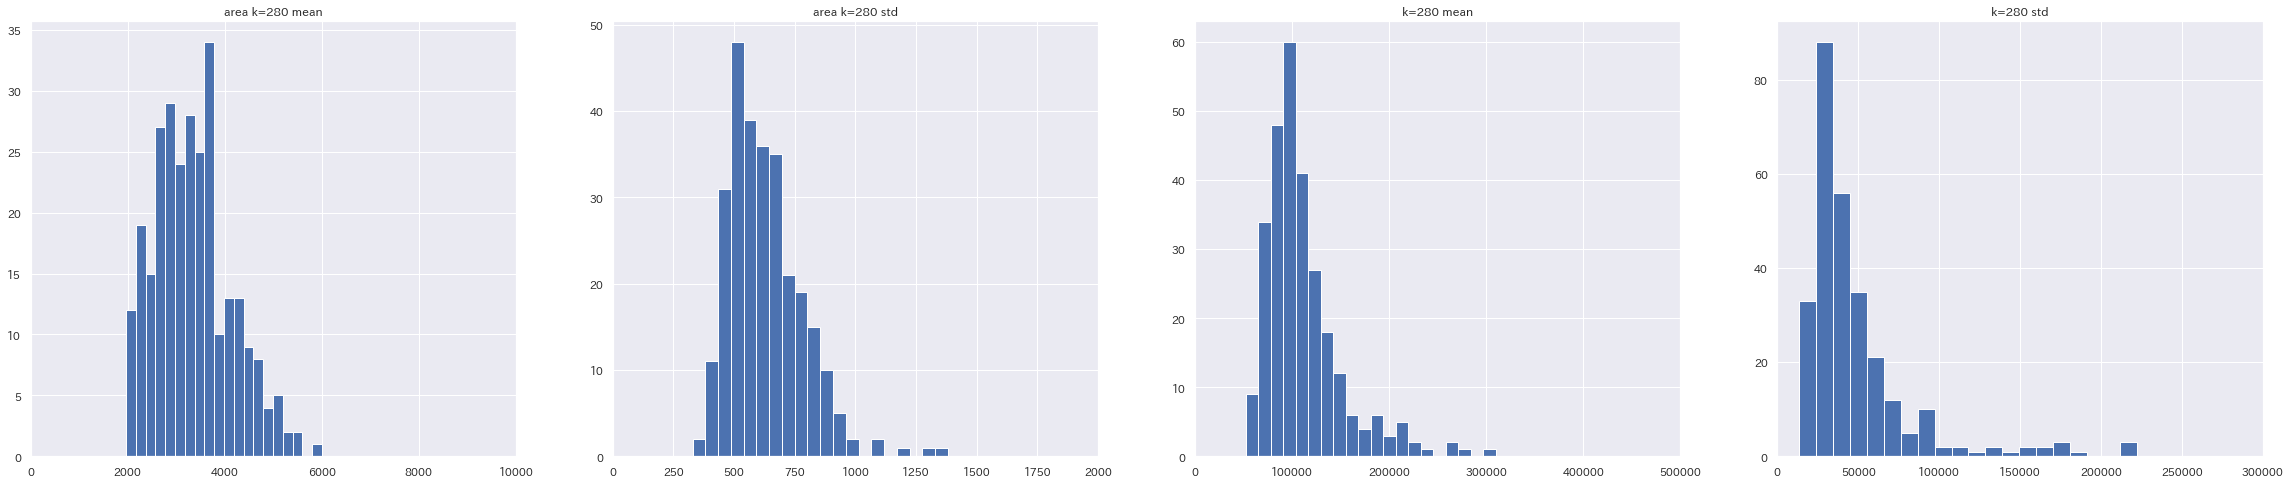

 24%|██▍       | 24/100 [18:35<1:21:59, 64.73s/it]

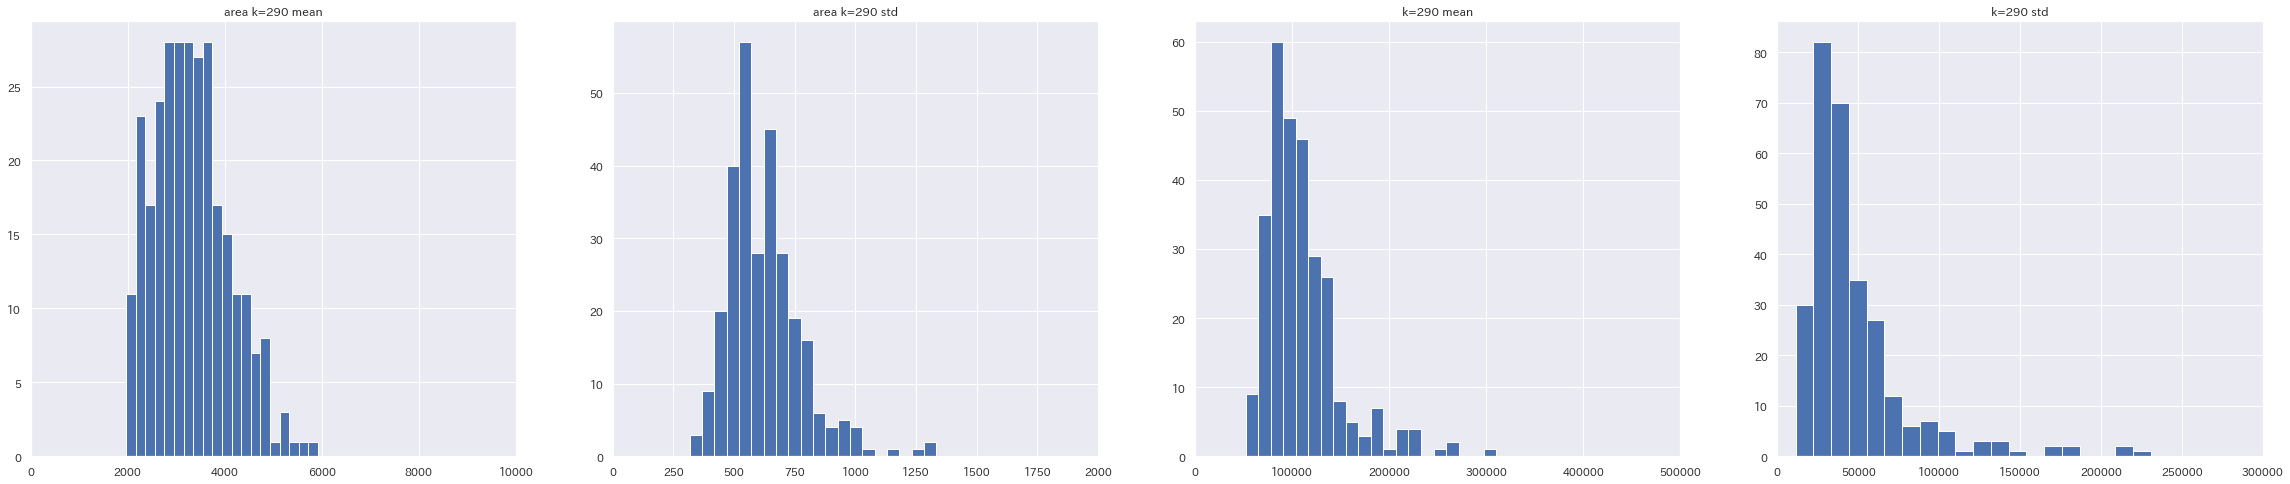

 25%|██▌       | 25/100 [19:41<1:21:23, 65.11s/it]

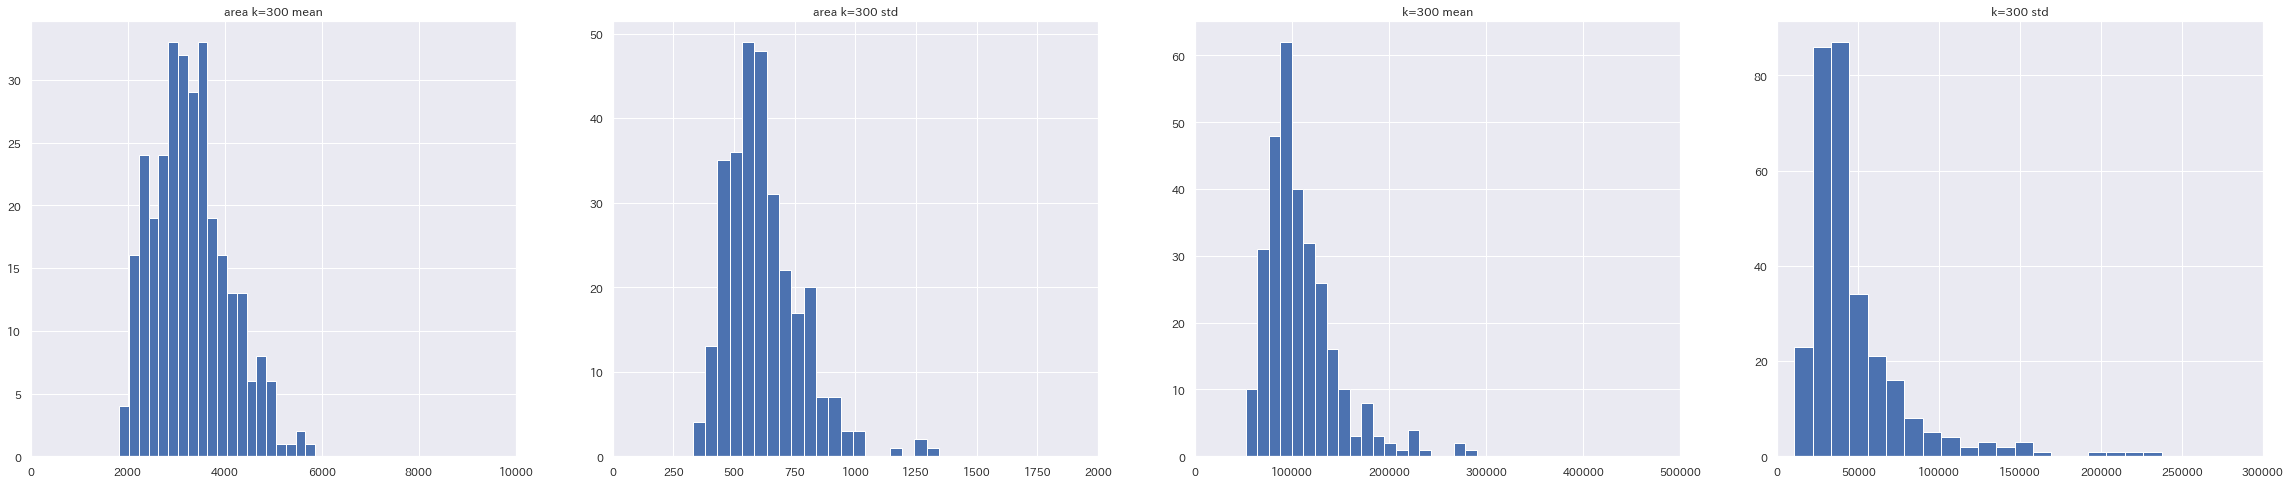

 26%|██▌       | 26/100 [20:51<1:21:51, 66.37s/it]

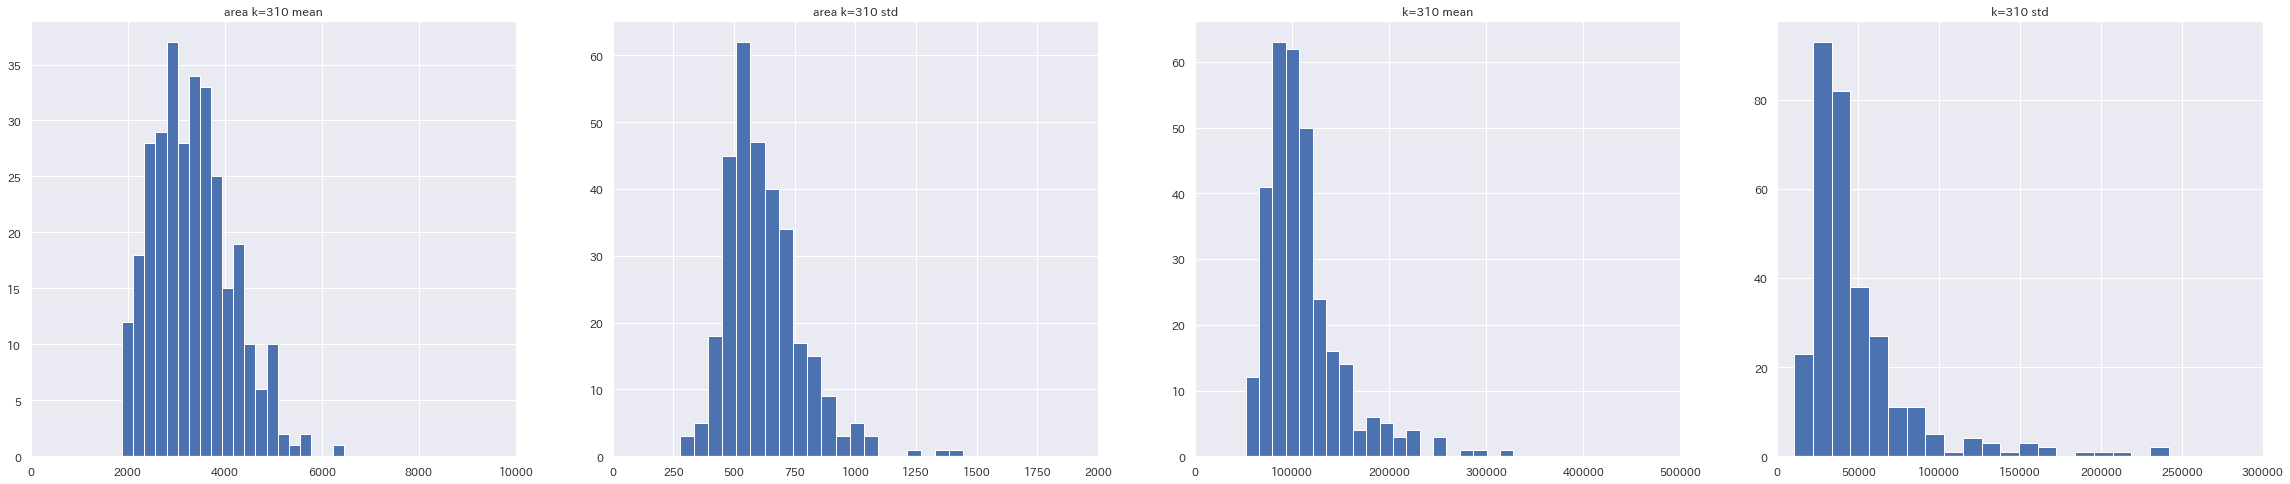

 27%|██▋       | 27/100 [22:11<1:25:50, 70.56s/it]

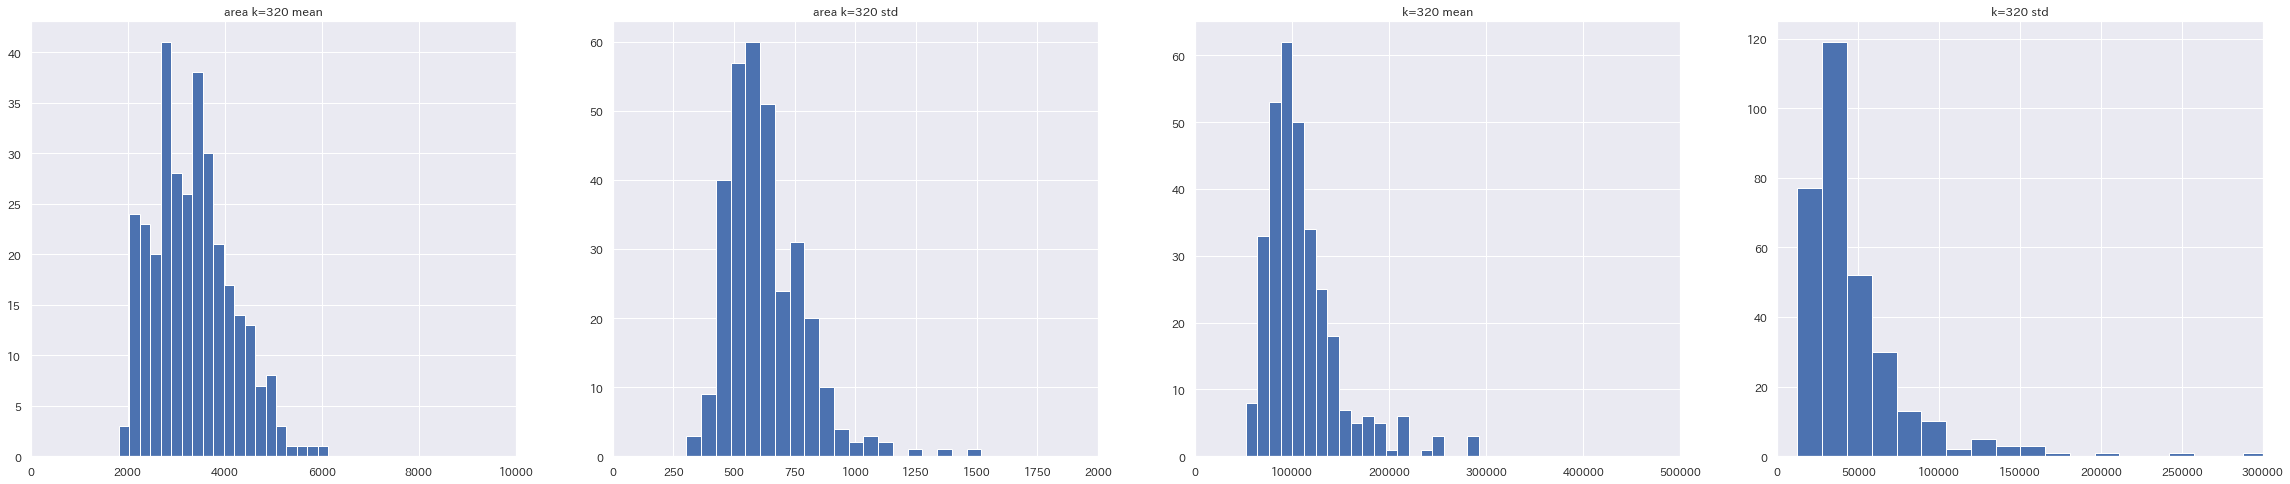

 28%|██▊       | 28/100 [23:25<1:26:06, 71.75s/it]

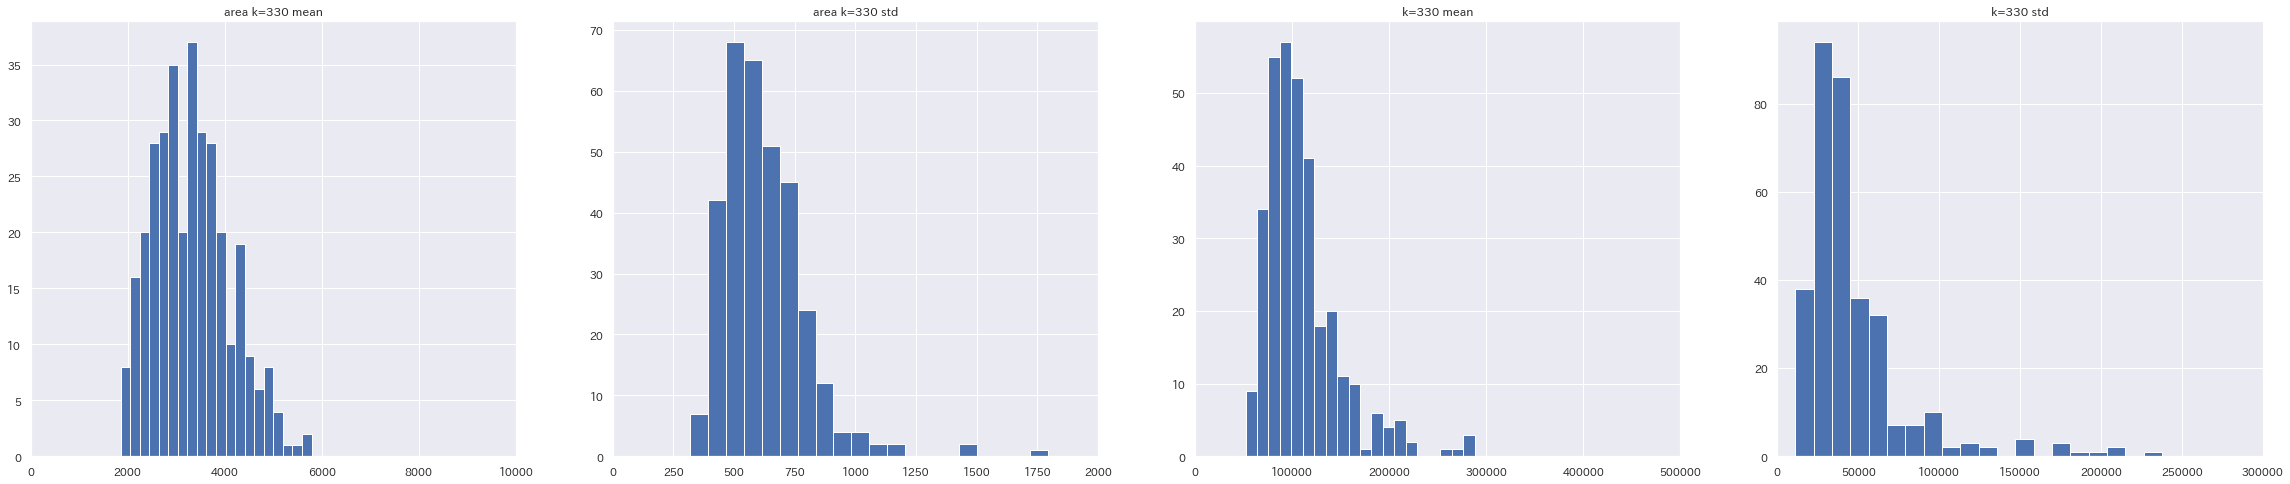

 29%|██▉       | 29/100 [24:39<1:25:27, 72.22s/it]

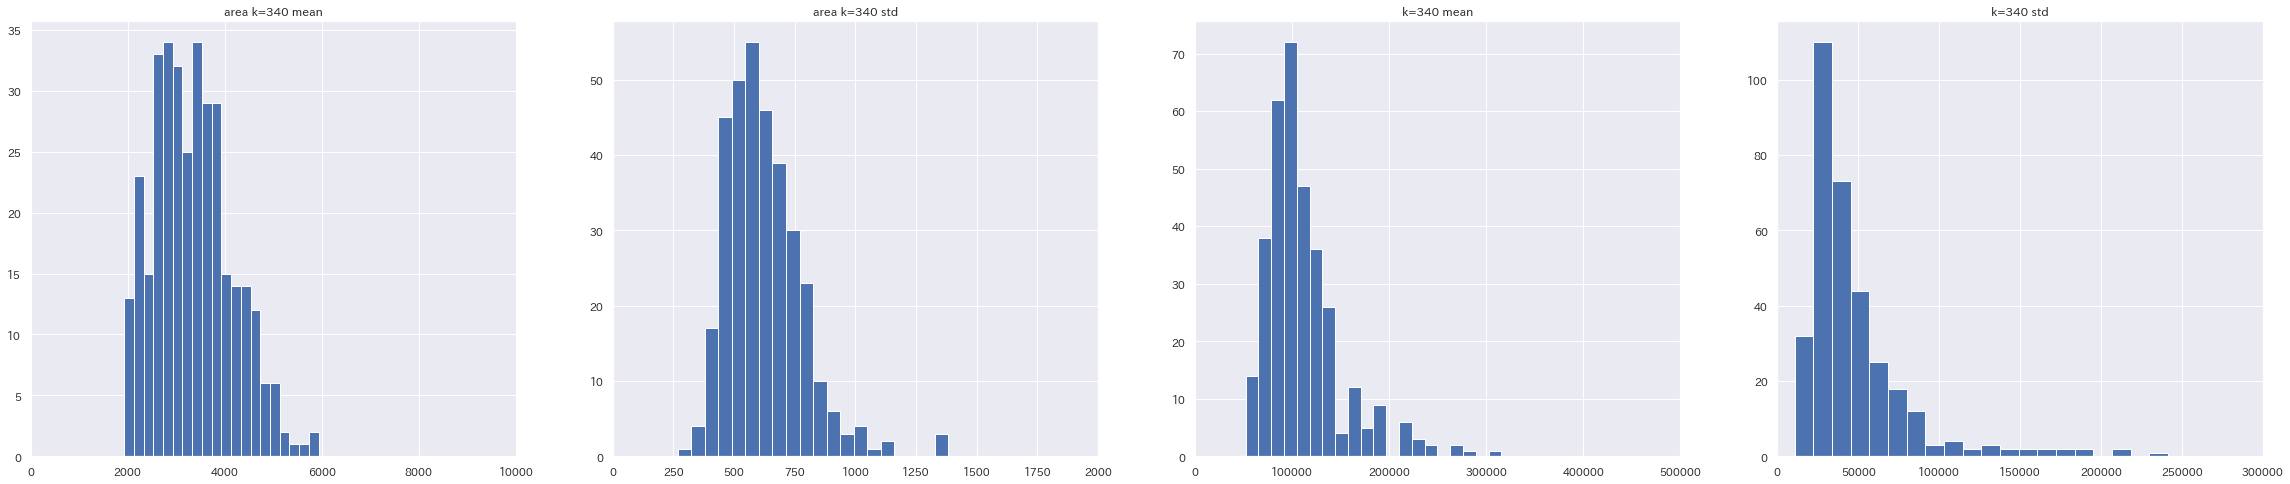

 30%|███       | 30/100 [25:49<1:23:32, 71.61s/it]

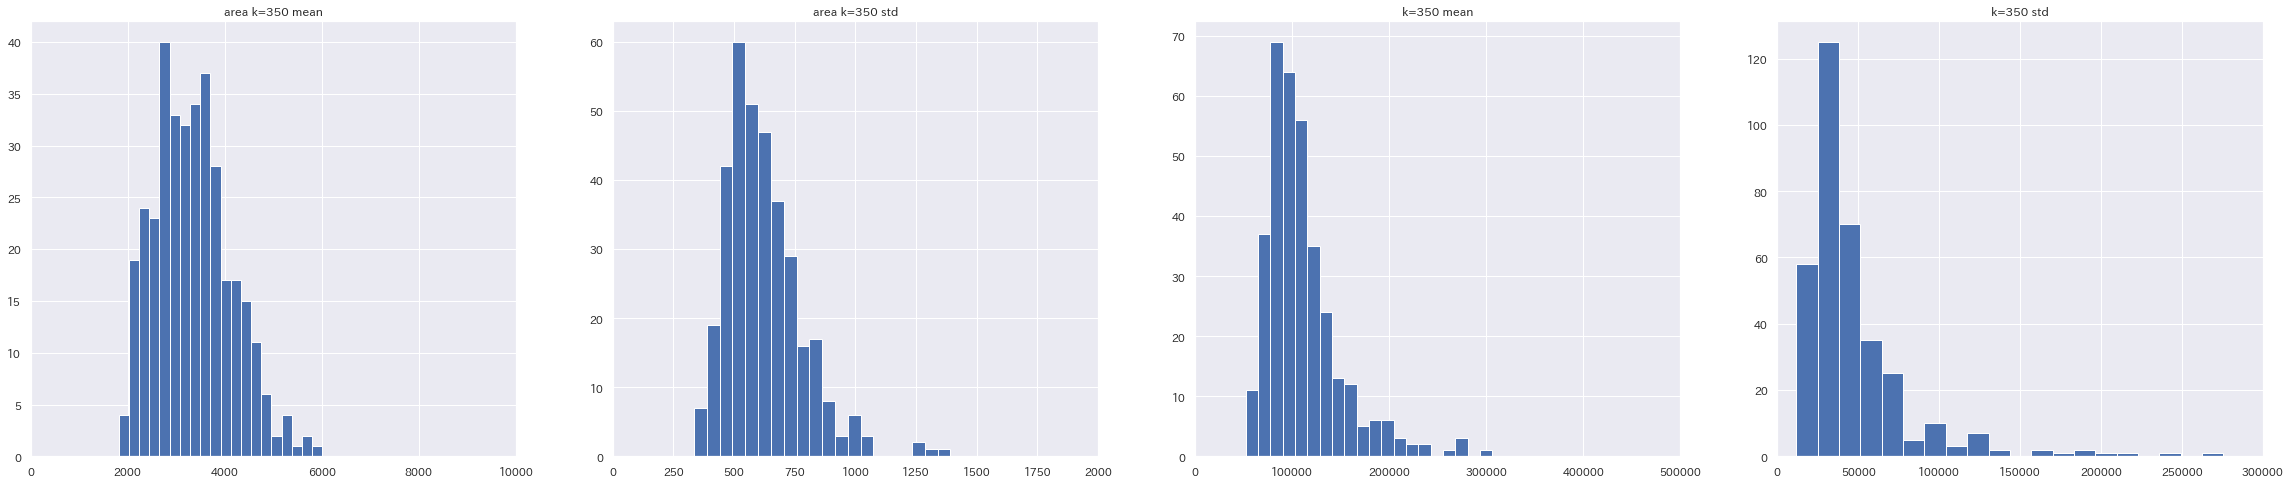

 31%|███       | 31/100 [27:01<1:22:31, 71.76s/it]

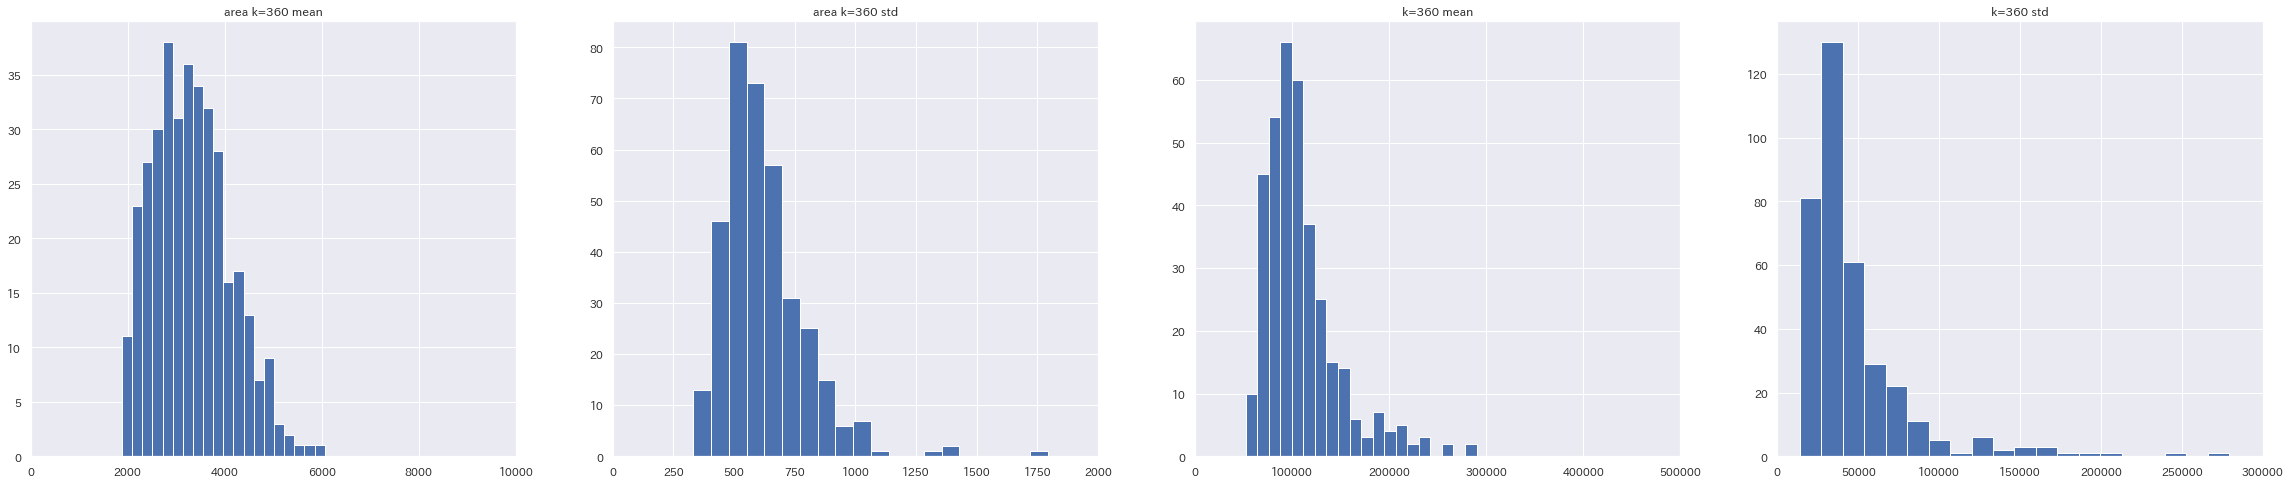

 32%|███▏      | 32/100 [28:28<1:26:21, 76.20s/it]

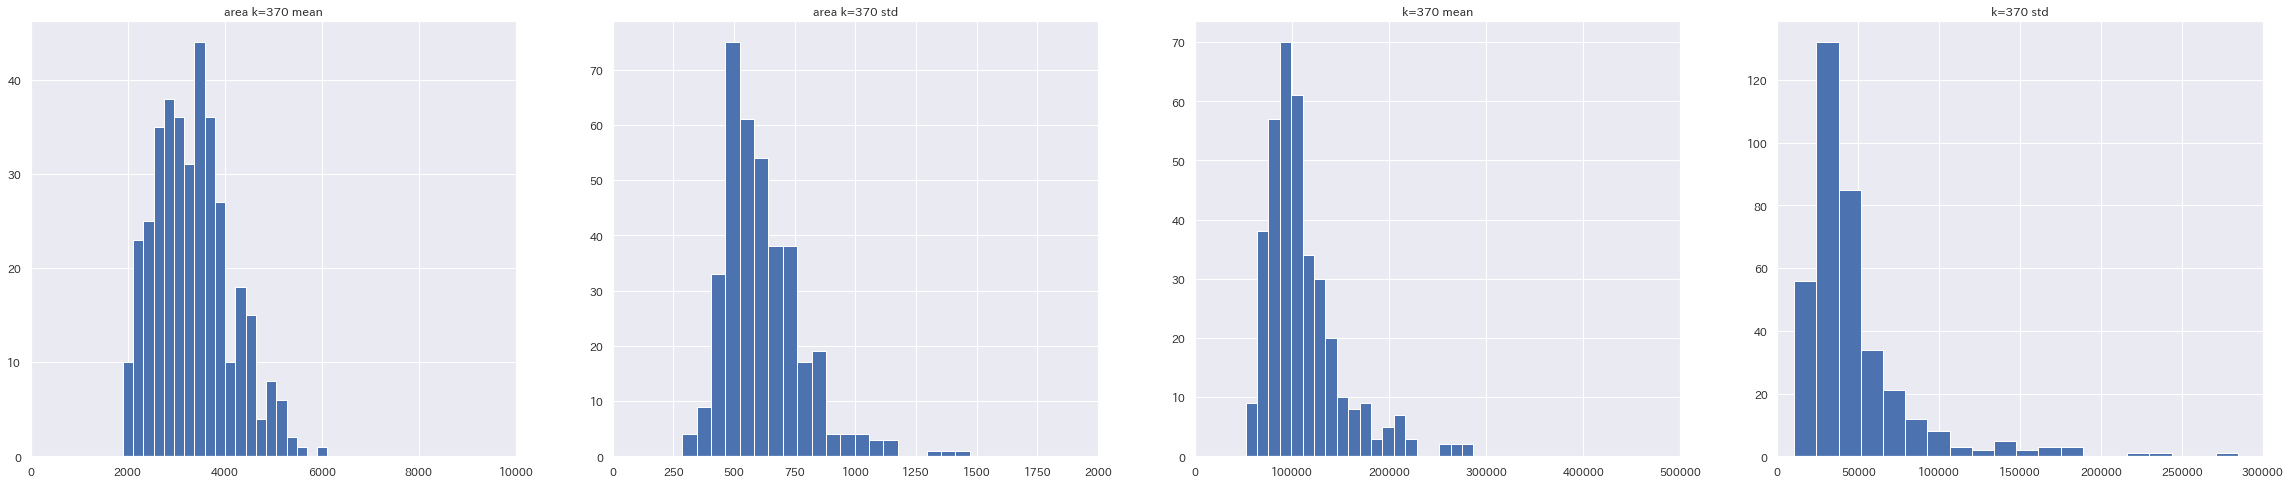

 33%|███▎      | 33/100 [30:00<1:30:21, 80.92s/it]

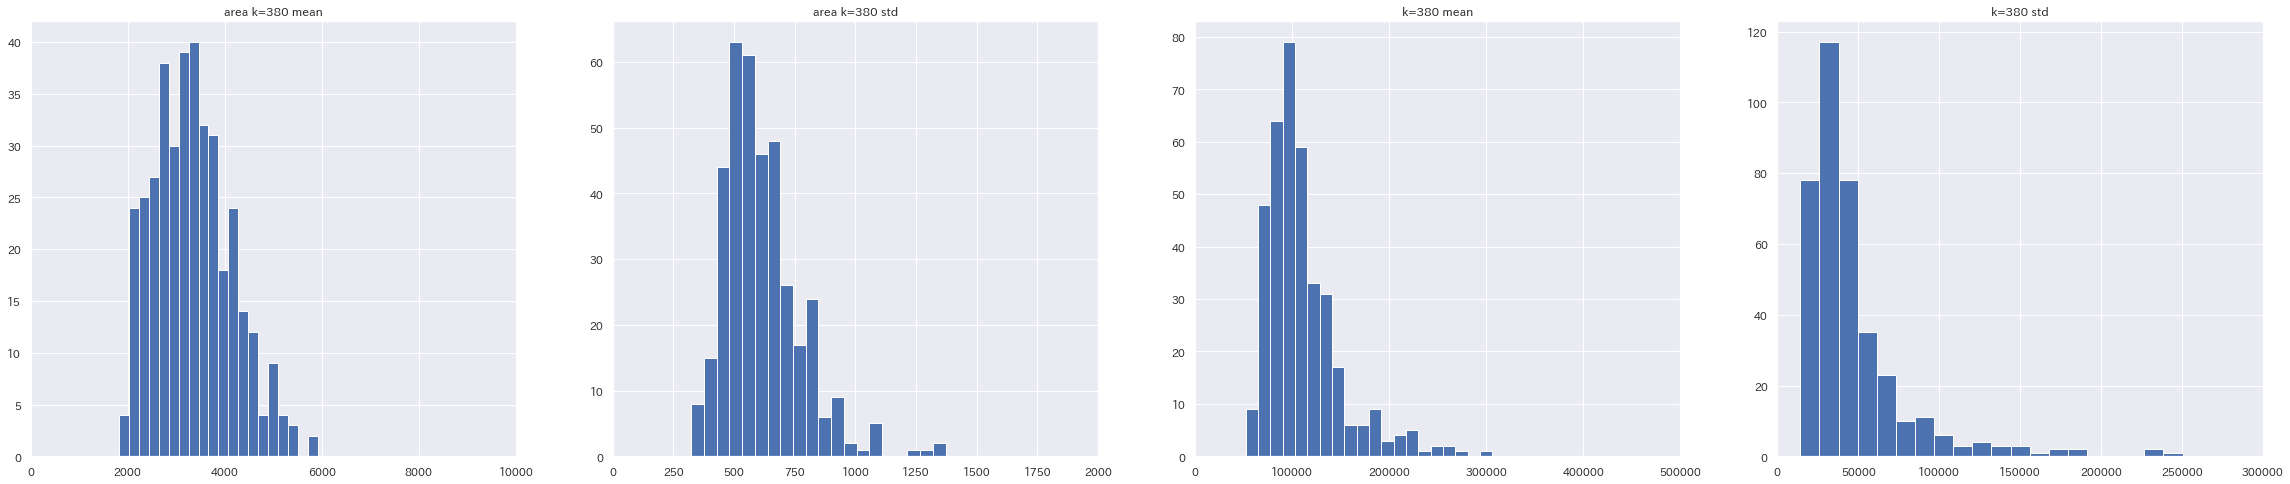

 34%|███▍      | 34/100 [31:21<1:29:07, 81.03s/it]

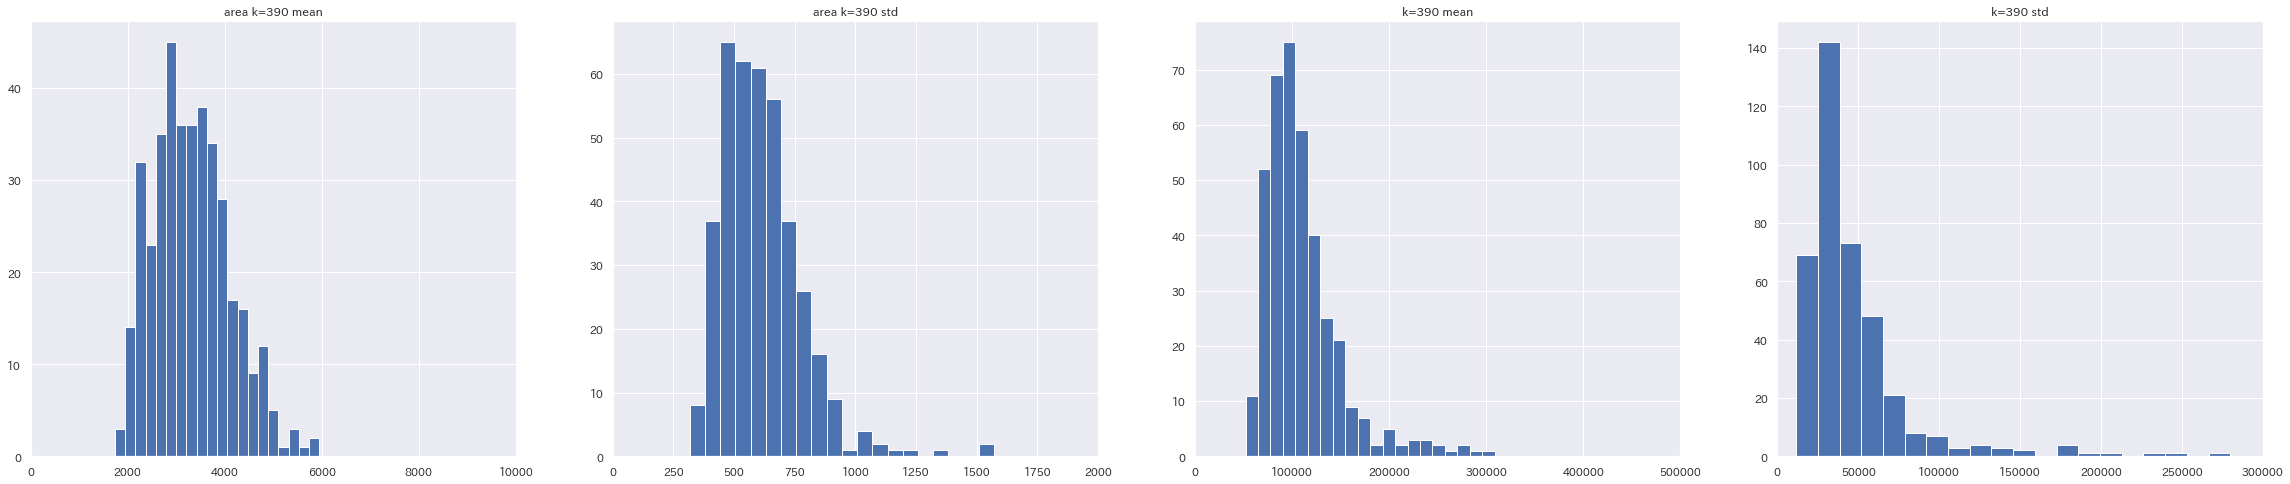

 35%|███▌      | 35/100 [32:45<1:28:54, 82.07s/it]

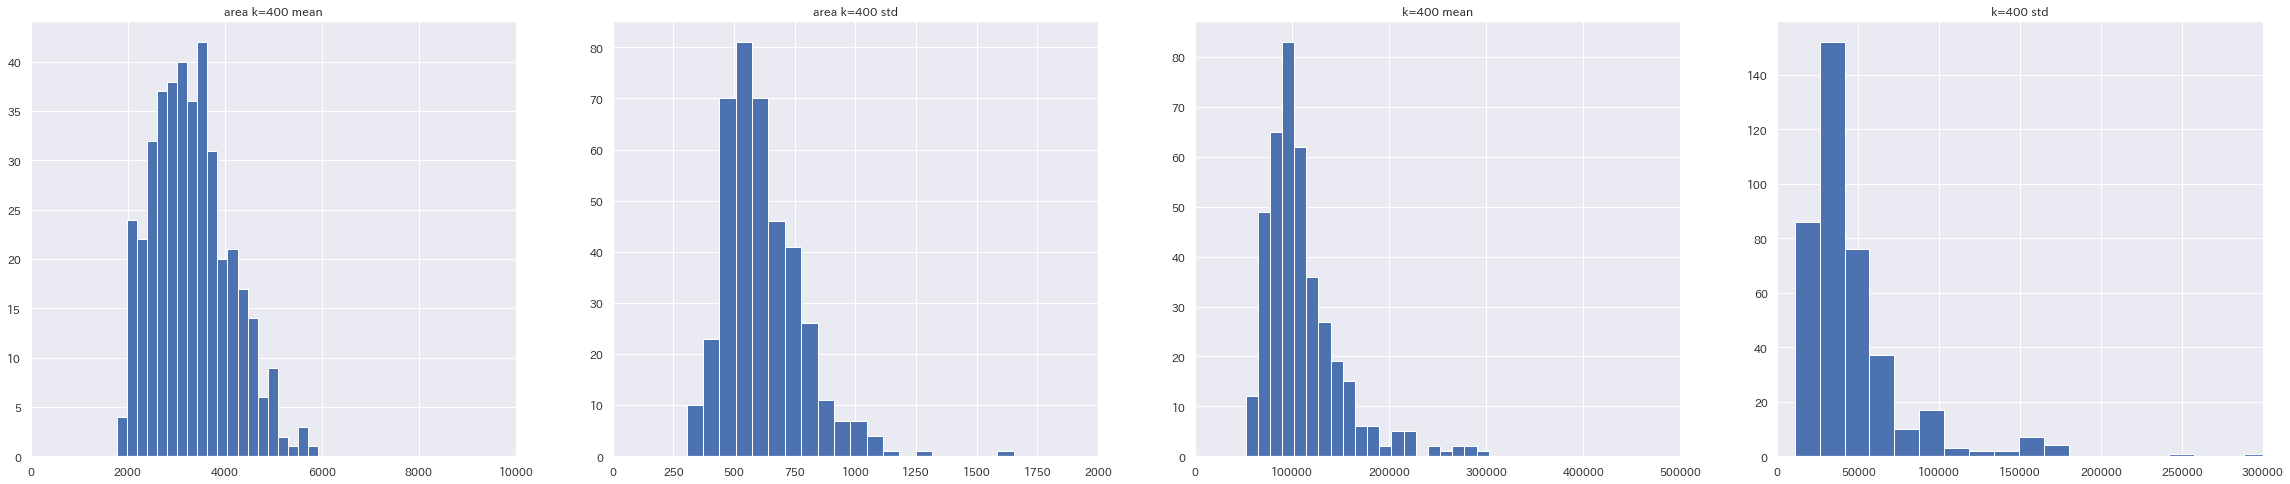

 36%|███▌      | 36/100 [34:12<1:29:06, 83.54s/it]

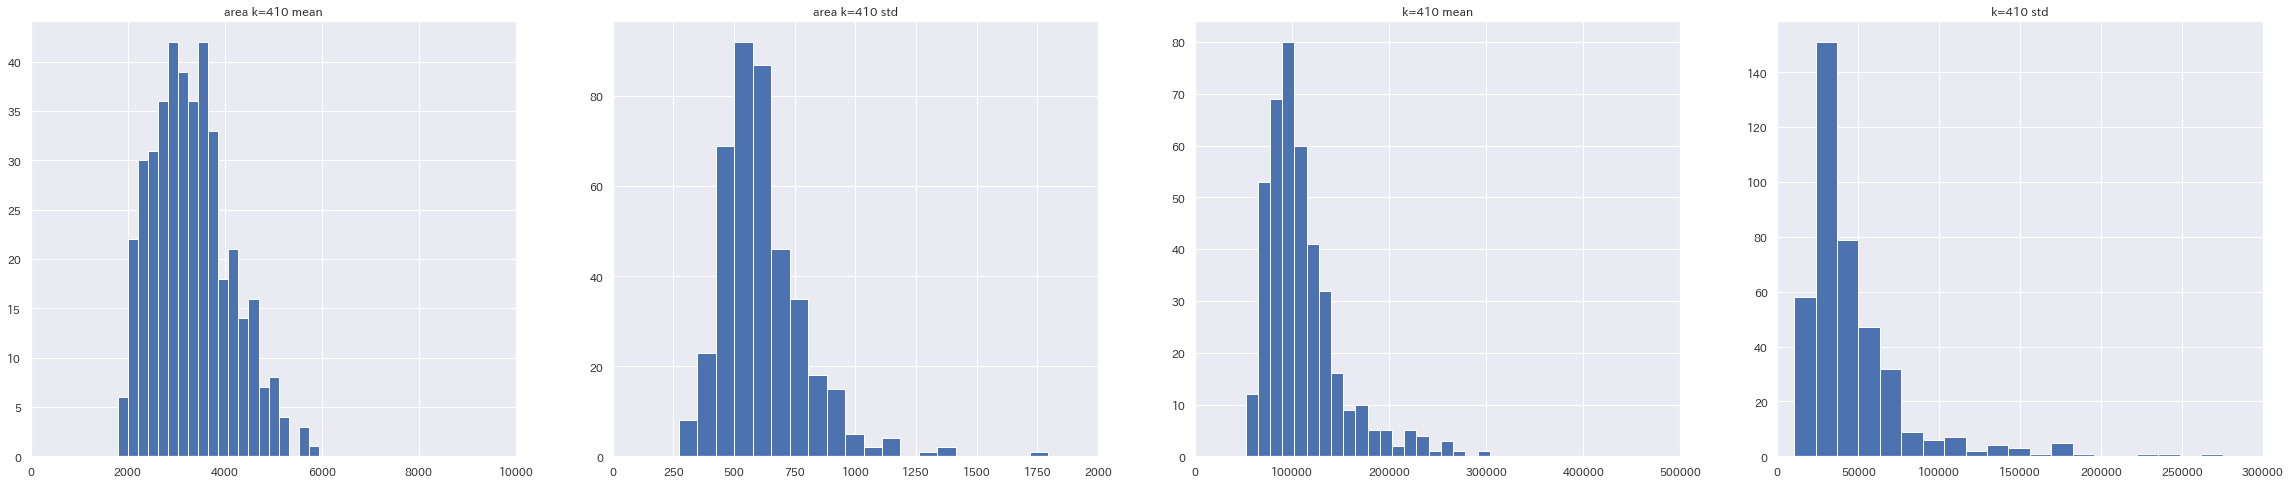

 37%|███▋      | 37/100 [35:32<1:26:23, 82.28s/it]

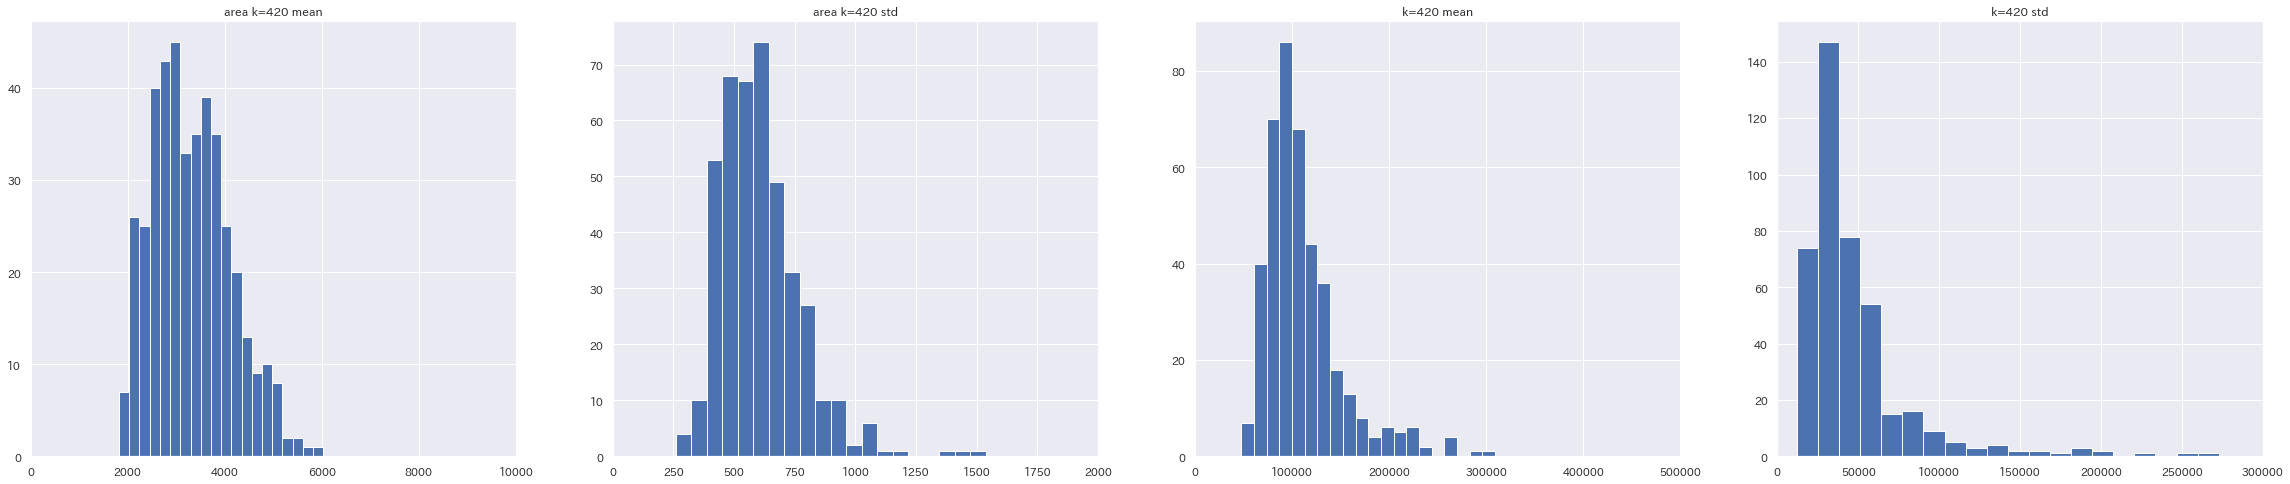

 38%|███▊      | 38/100 [36:57<1:25:50, 83.08s/it]

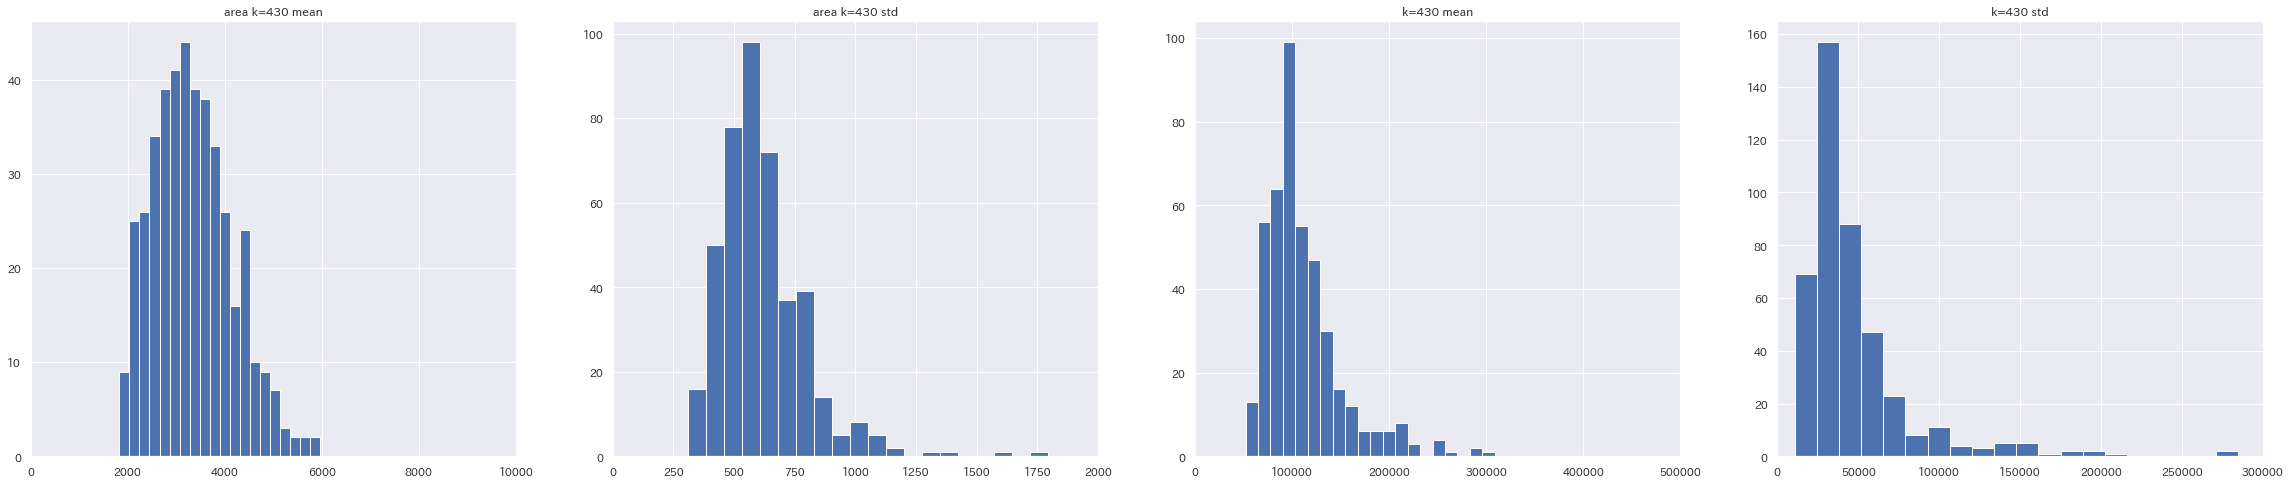

 39%|███▉      | 39/100 [38:19<1:24:15, 82.88s/it]

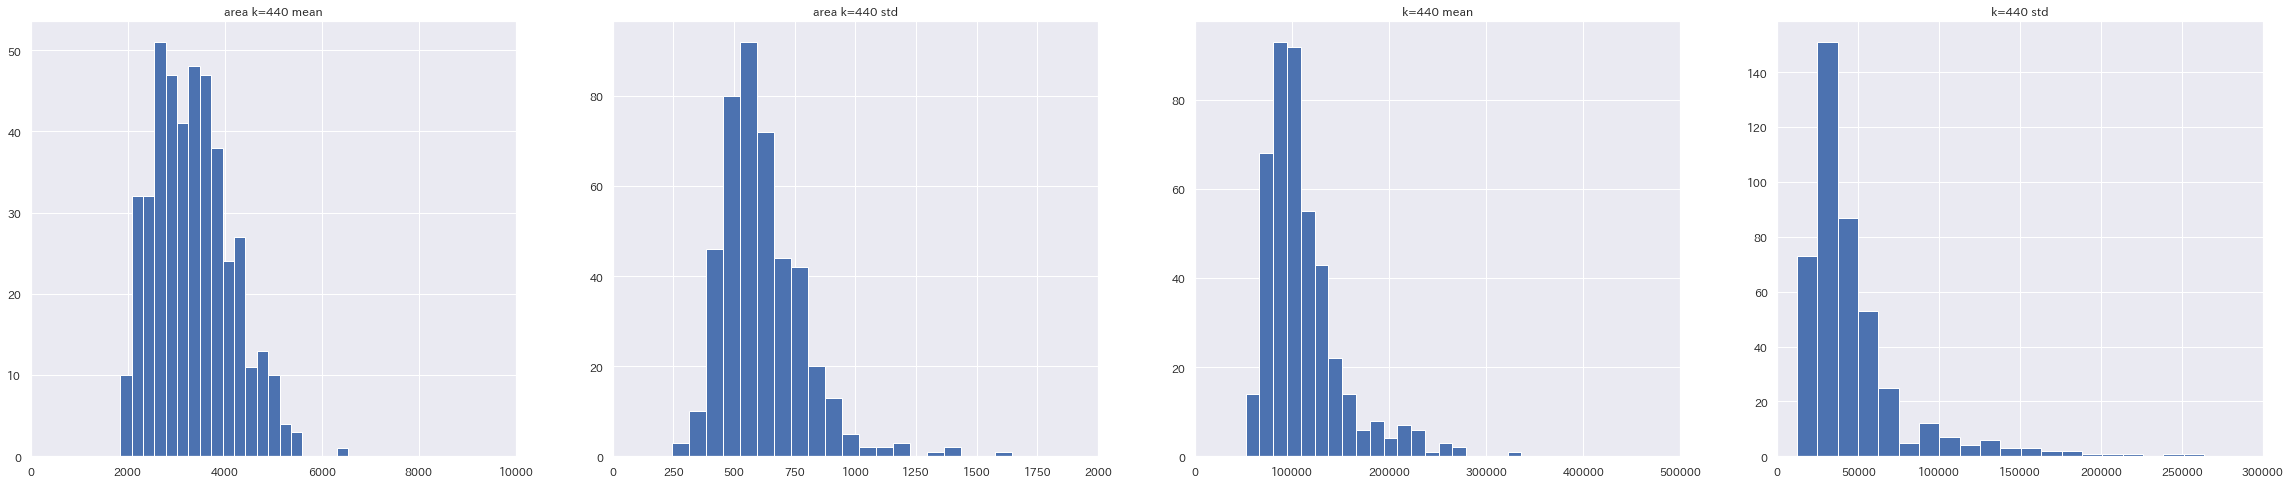

 40%|████      | 40/100 [39:45<1:23:50, 83.84s/it]

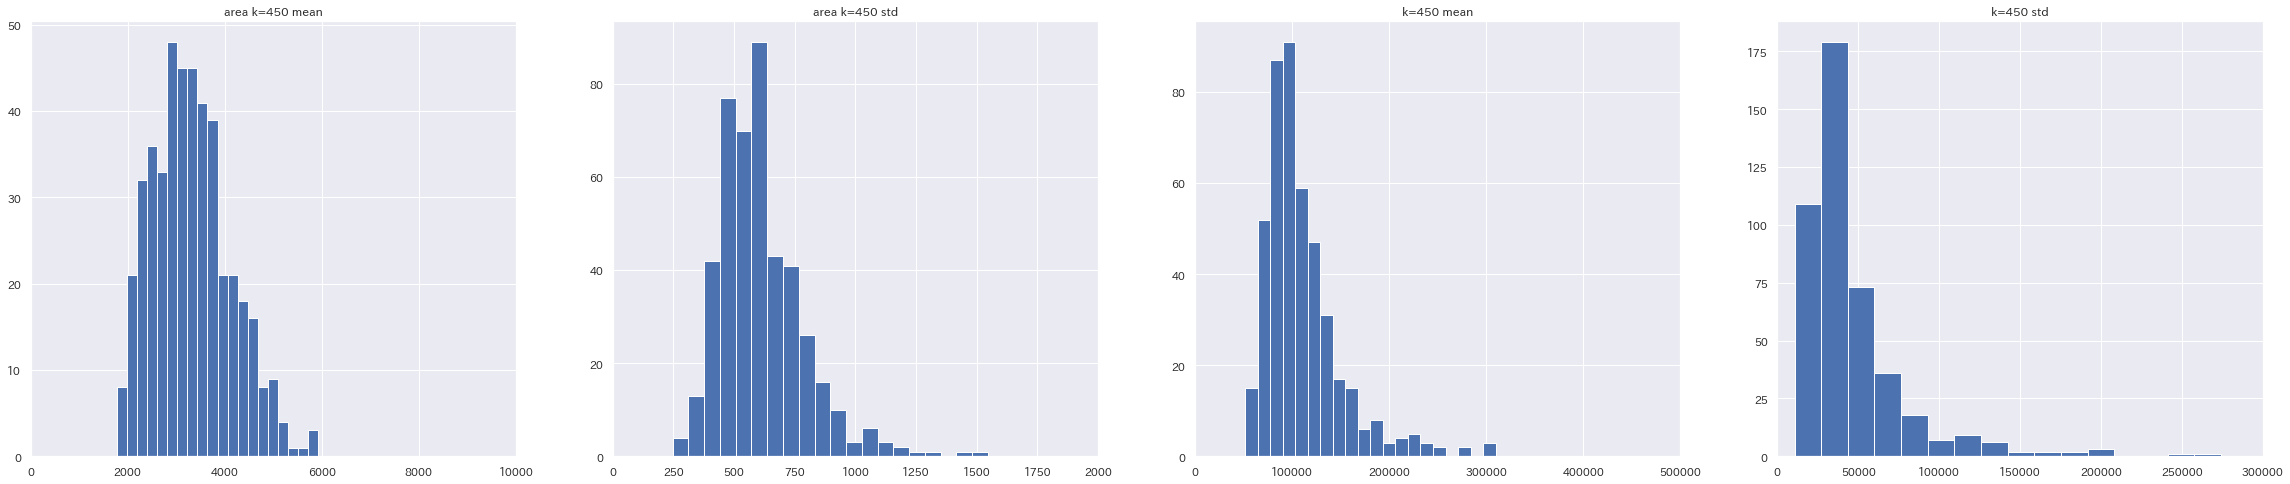

 41%|████      | 41/100 [41:10<1:22:53, 84.30s/it]

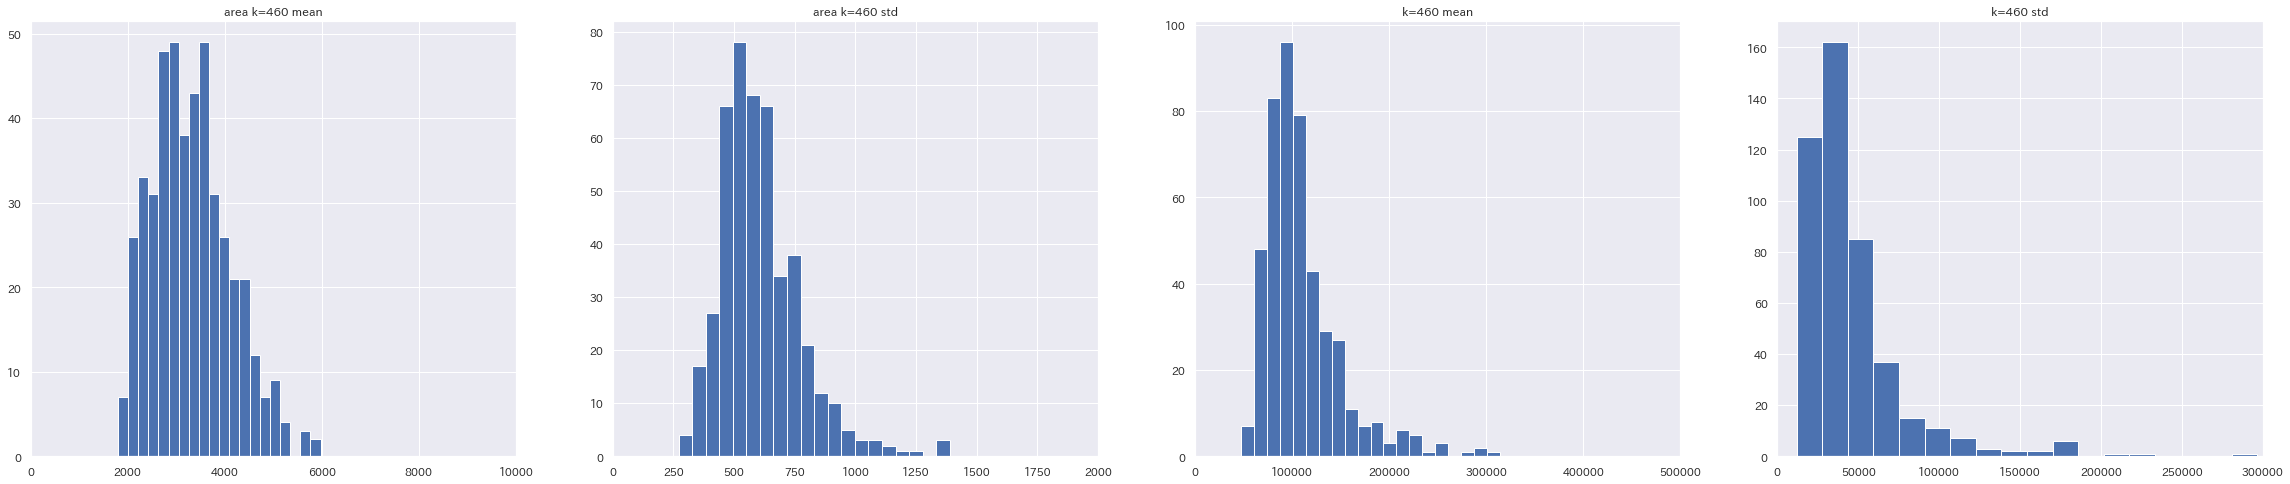

 42%|████▏     | 42/100 [42:44<1:24:14, 87.14s/it]

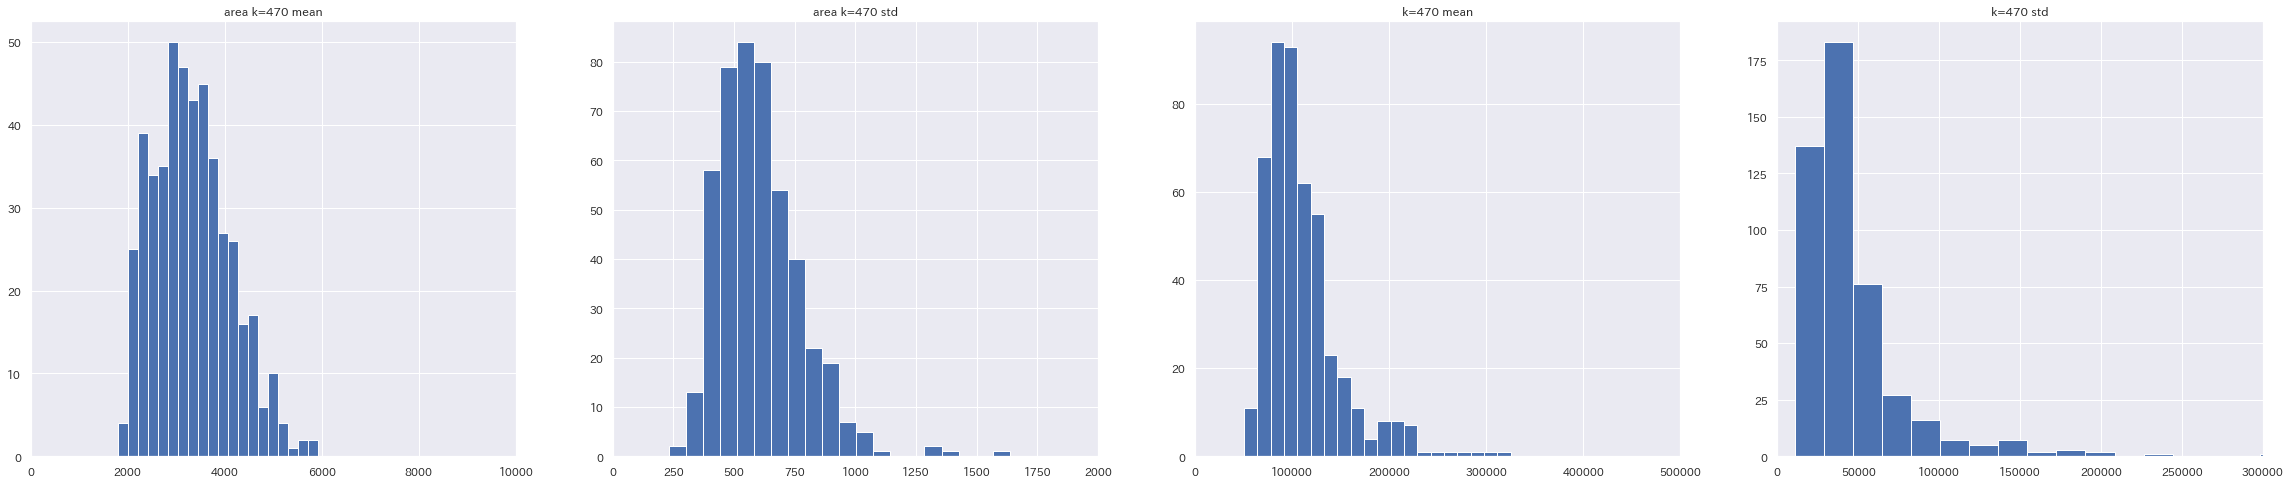

 43%|████▎     | 43/100 [44:23<1:26:01, 90.56s/it]

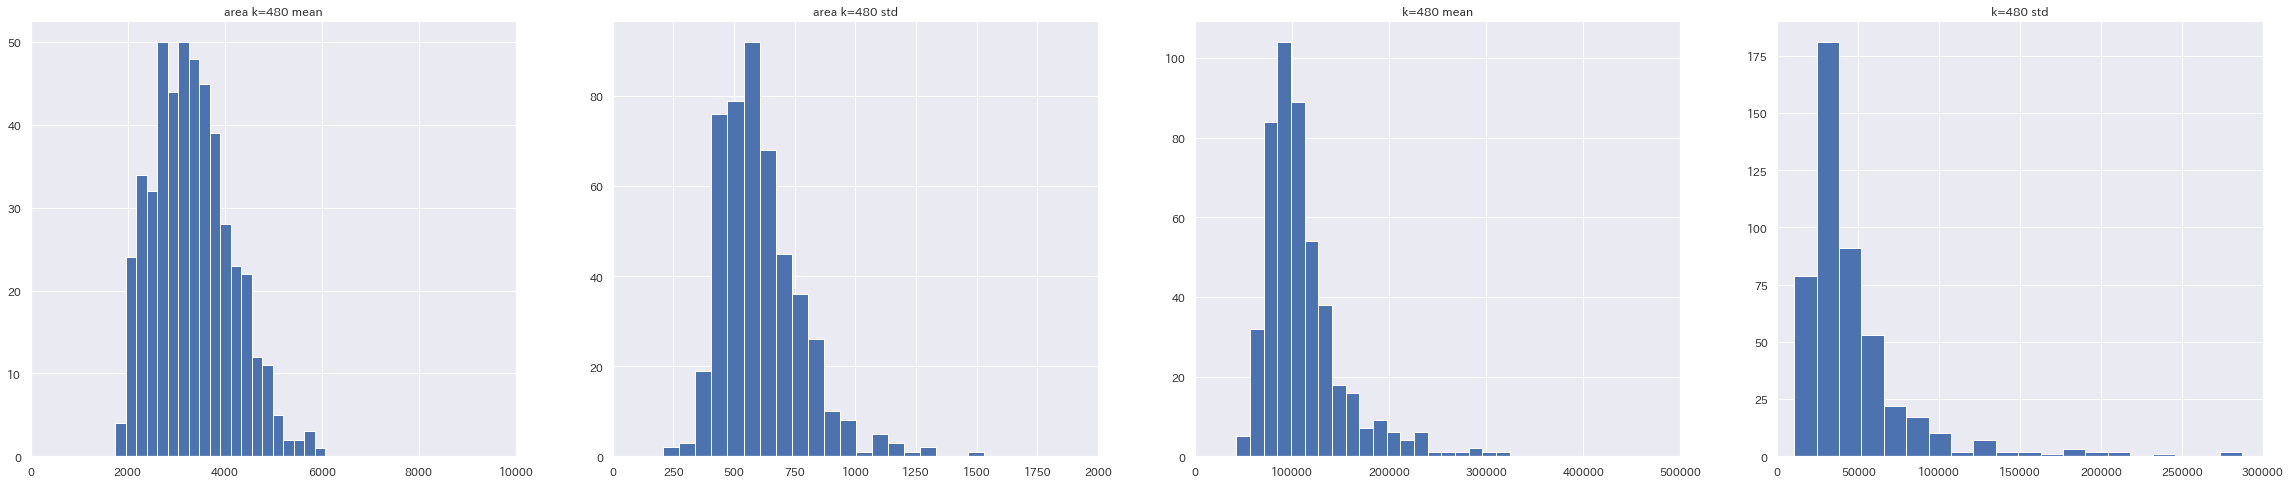

 44%|████▍     | 44/100 [46:05<1:27:39, 93.91s/it]

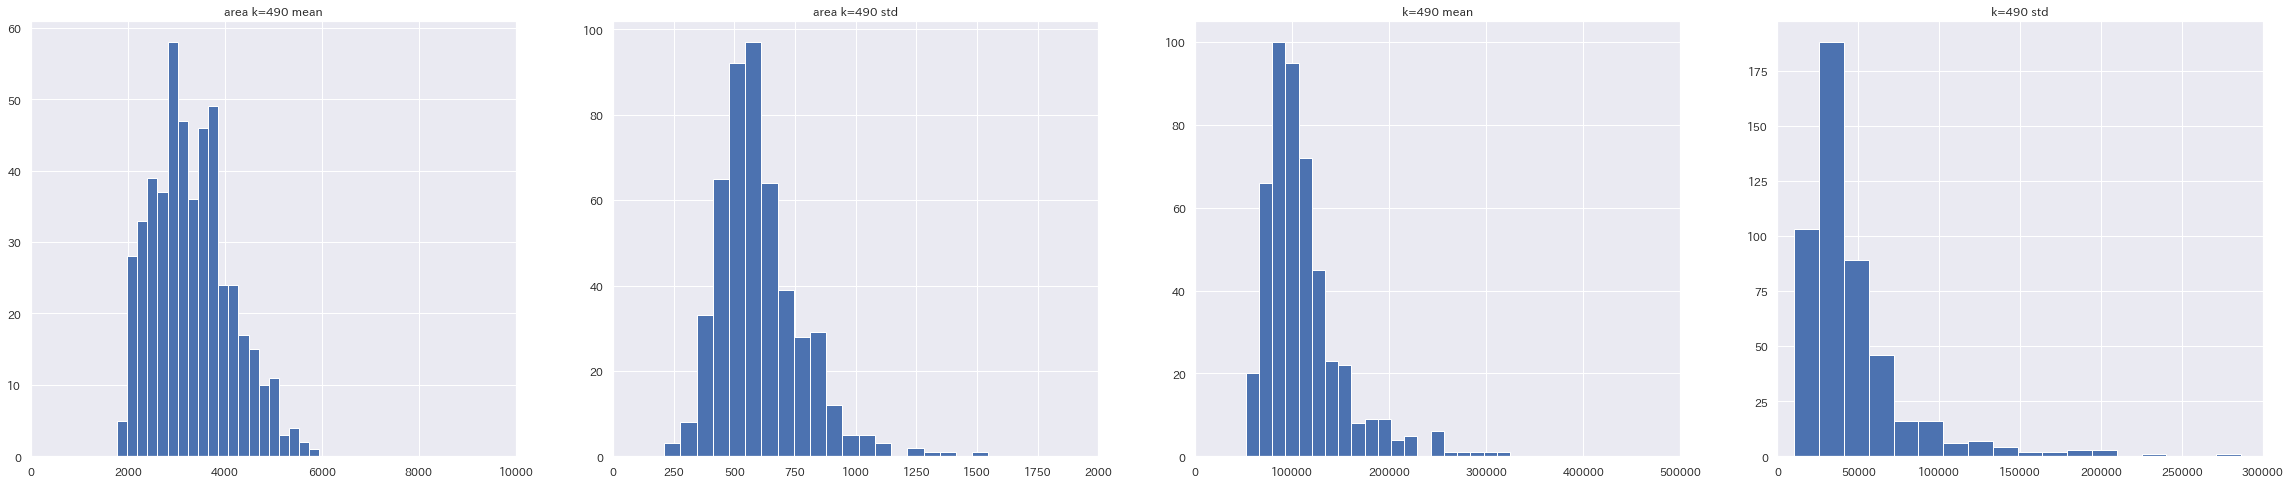

 45%|████▌     | 45/100 [47:38<1:26:02, 93.87s/it]

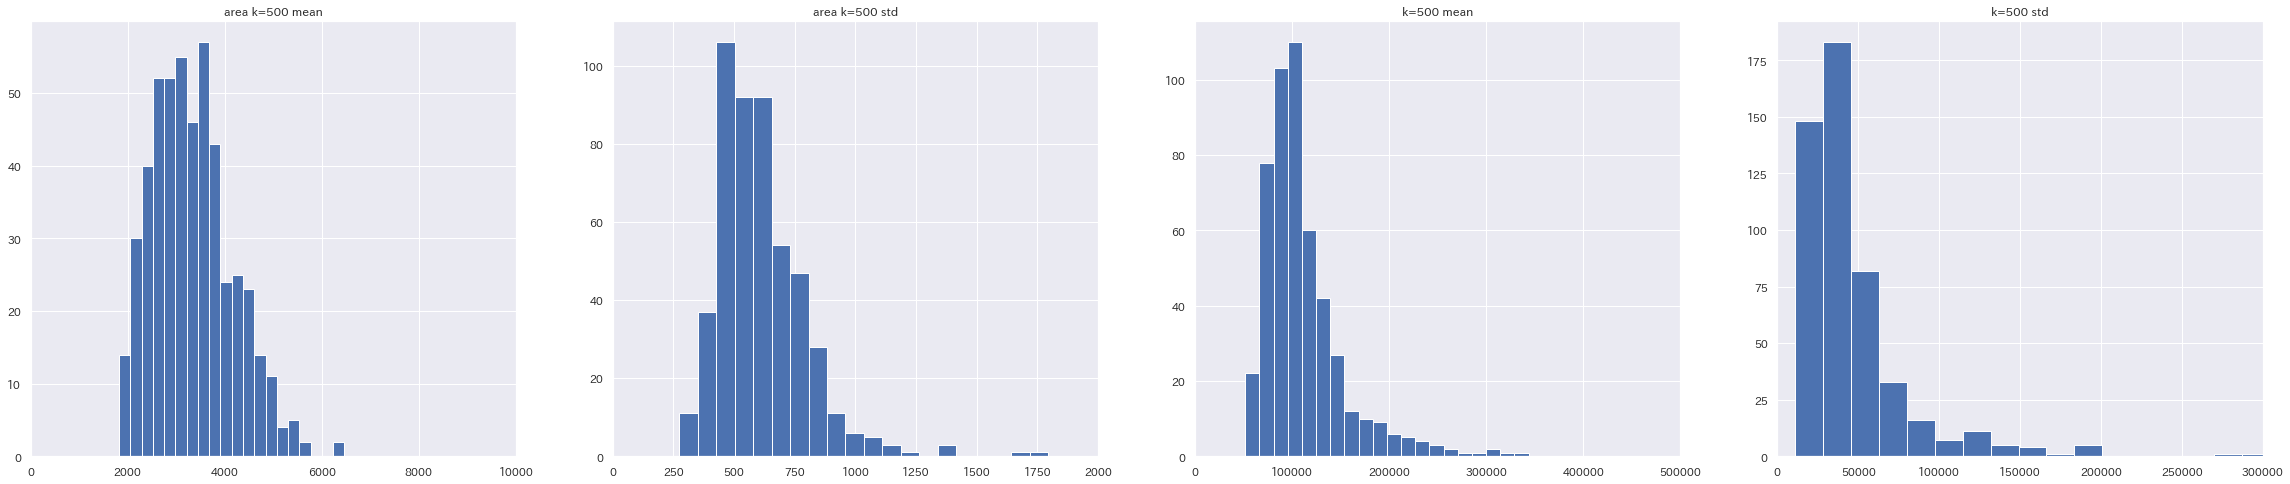

 46%|████▌     | 46/100 [49:14<1:25:04, 94.52s/it]

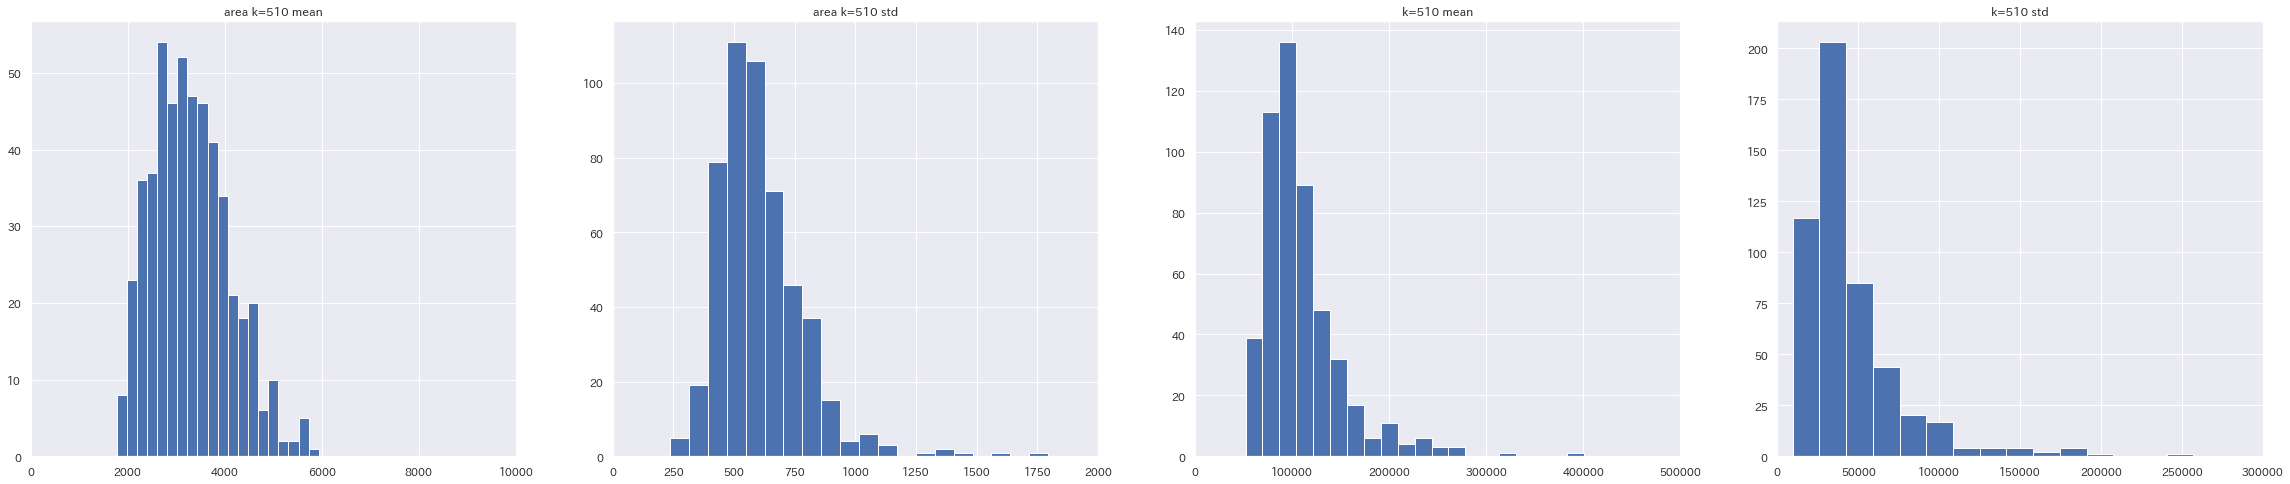

 47%|████▋     | 47/100 [50:53<1:24:30, 95.68s/it]

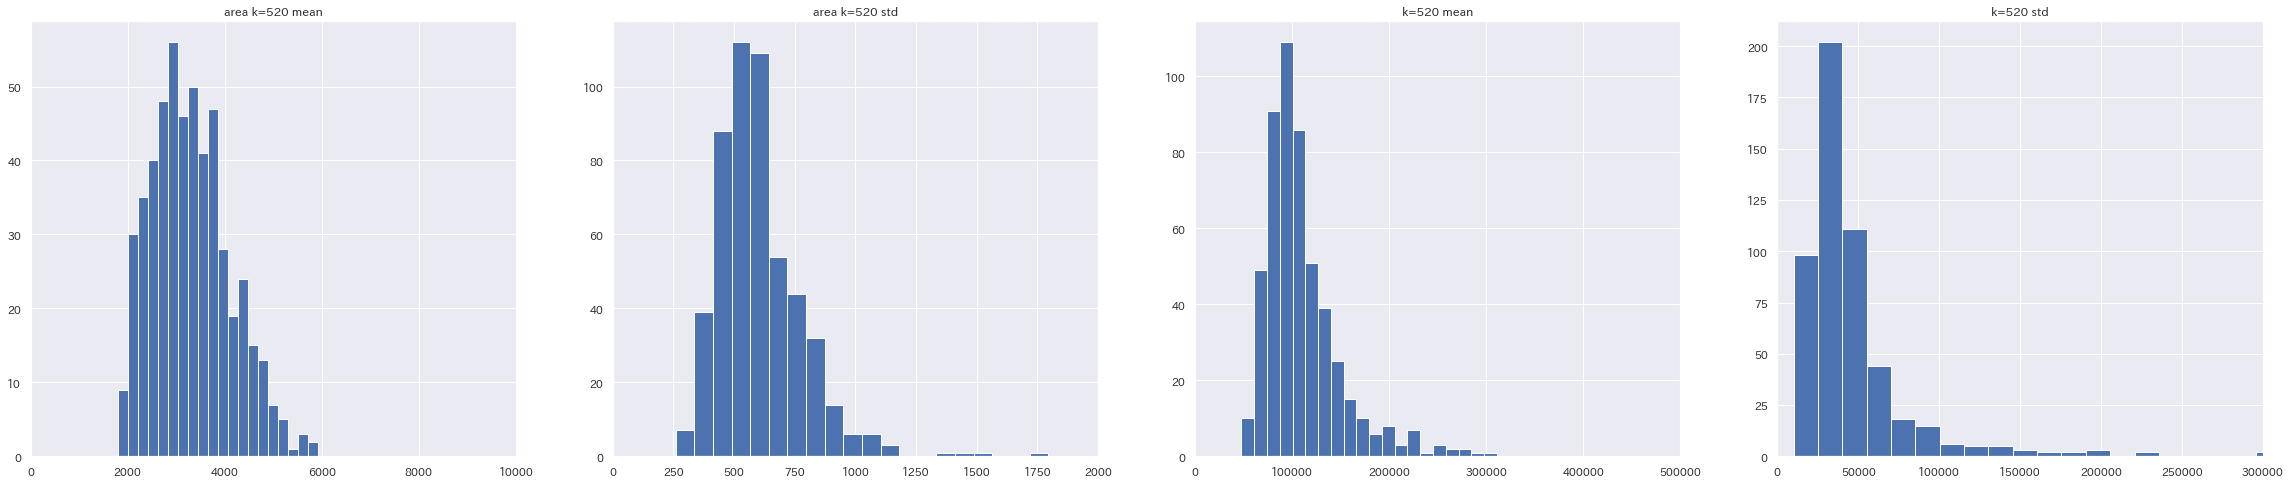

 48%|████▊     | 48/100 [52:34<1:24:24, 97.40s/it]

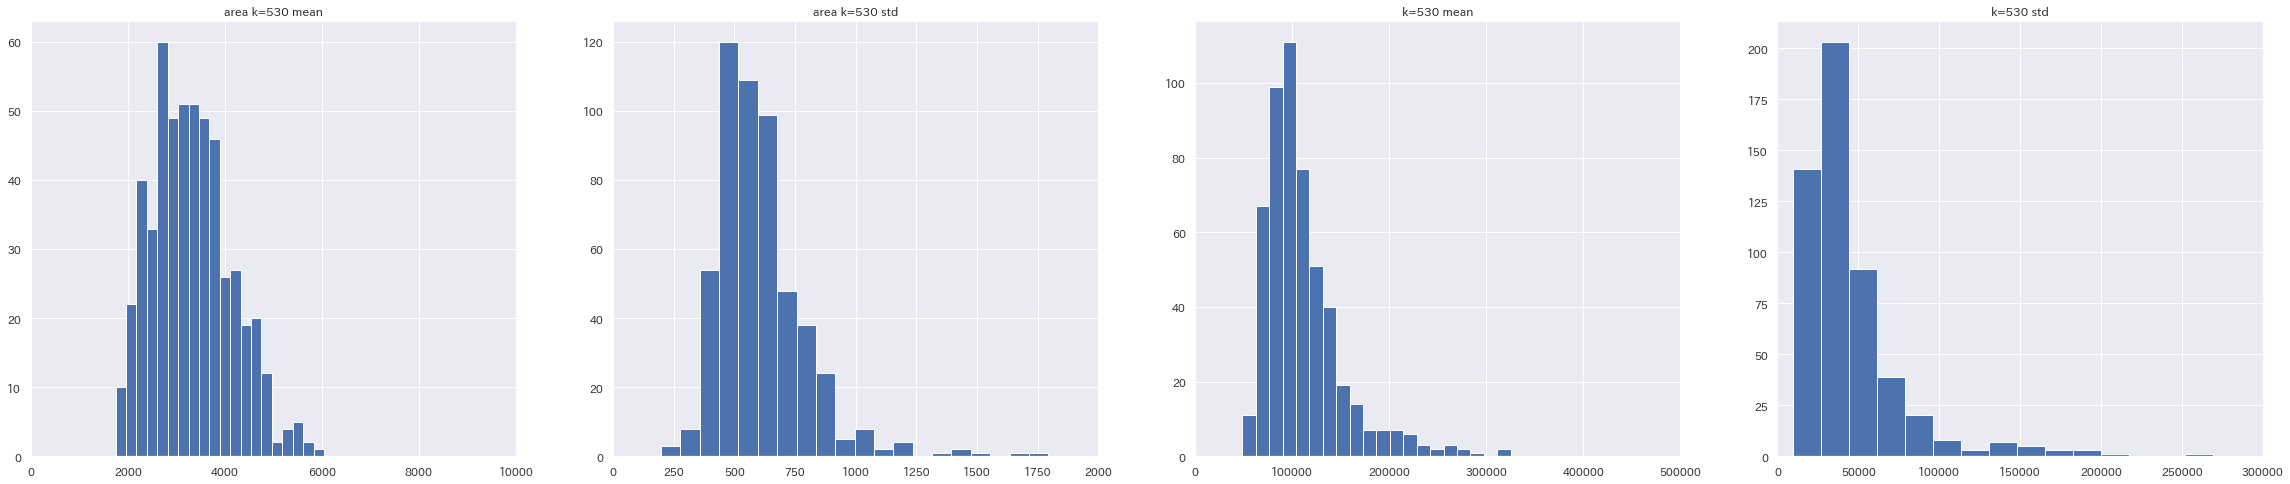

 49%|████▉     | 49/100 [54:19<1:24:48, 99.77s/it]

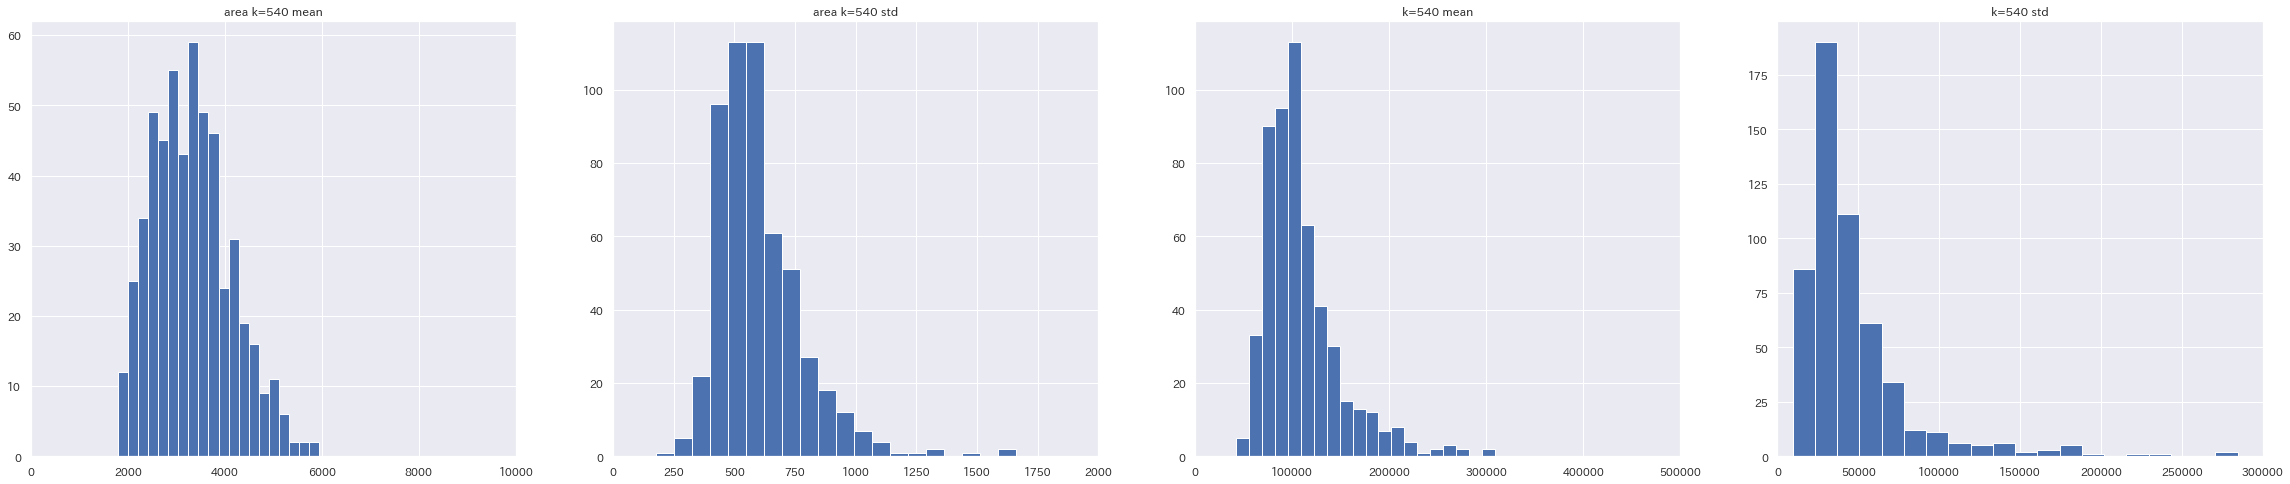

 50%|█████     | 50/100 [56:06<1:24:49, 101.79s/it]

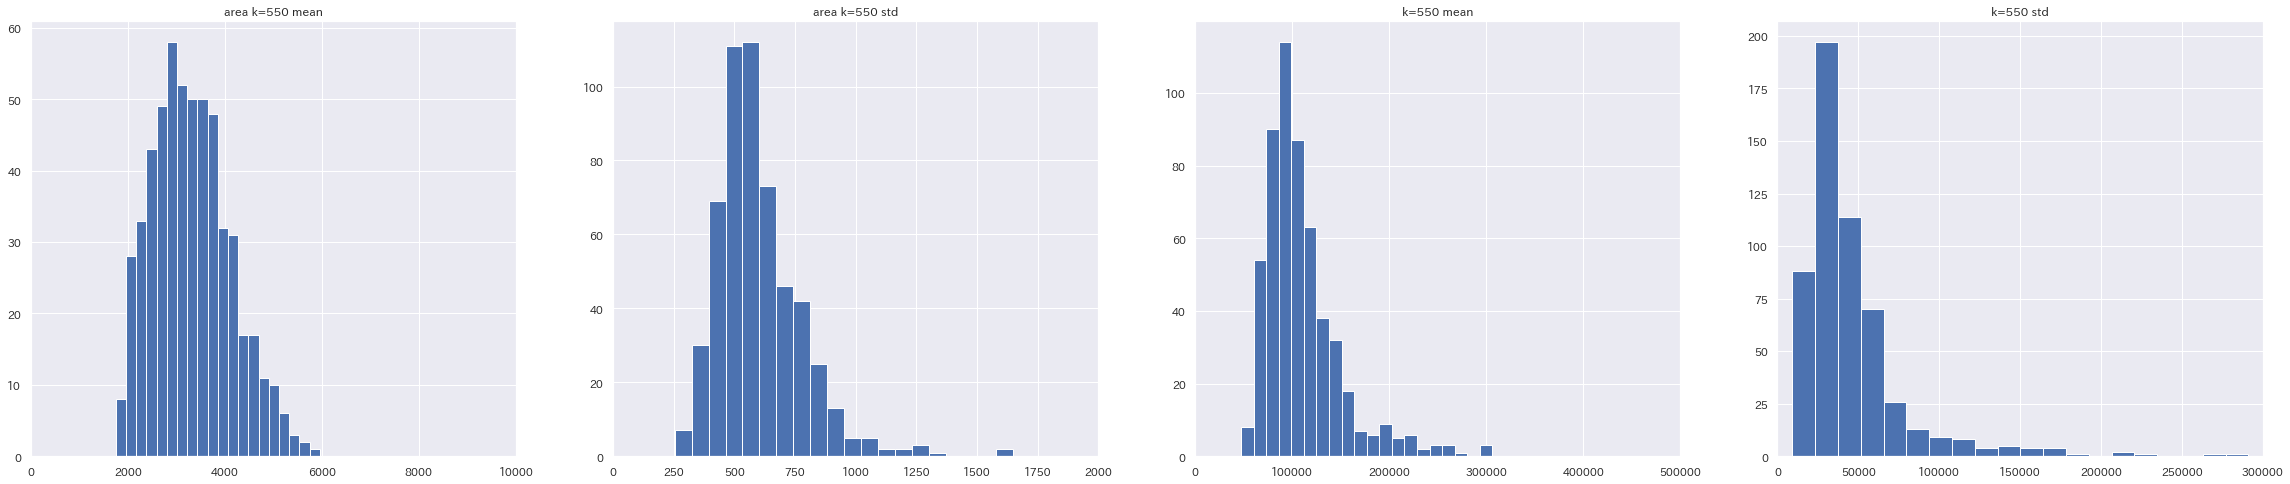

 51%|█████     | 51/100 [57:53<1:24:27, 103.42s/it]

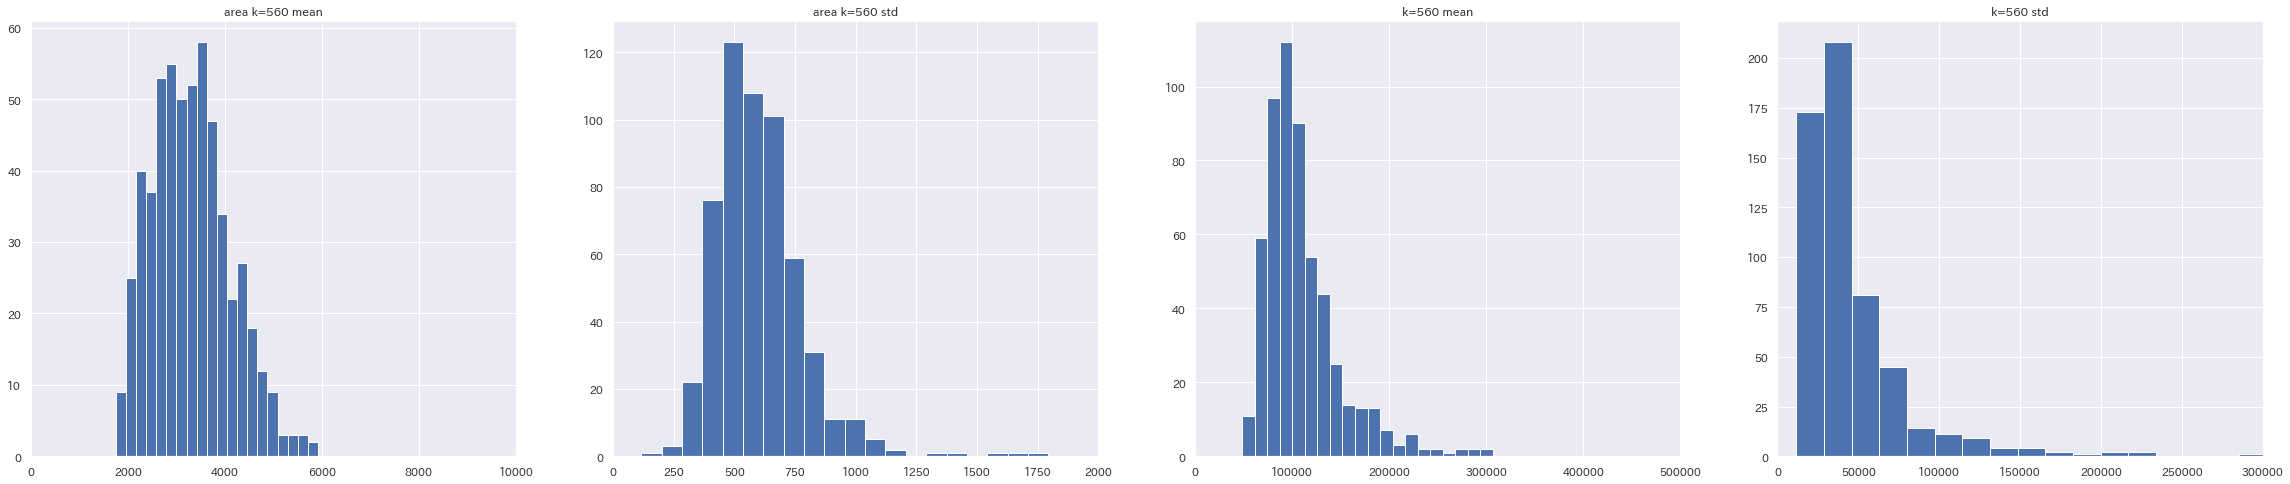

 52%|█████▏    | 52/100 [59:36<1:22:42, 103.38s/it]

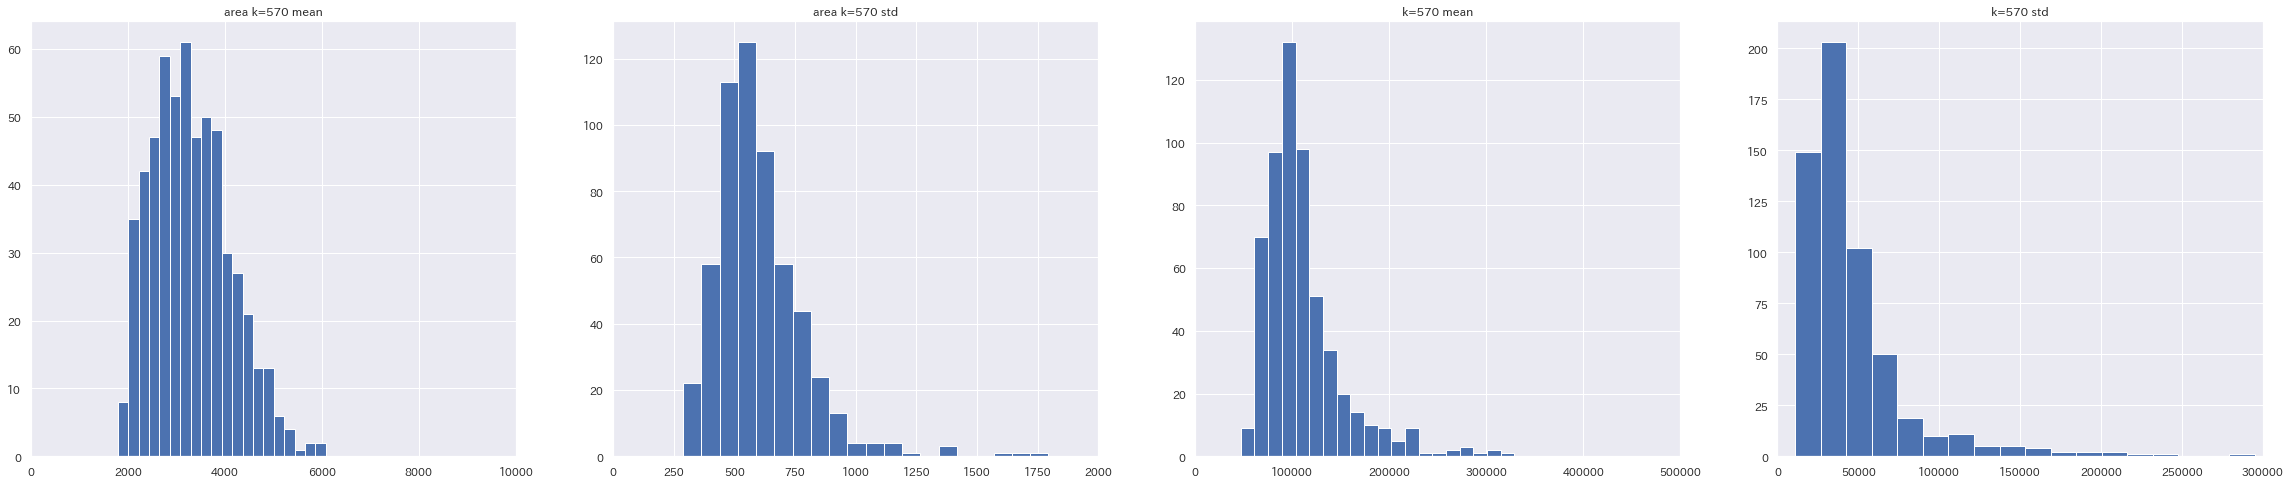

 53%|█████▎    | 53/100 [1:01:56<1:29:32, 114.32s/it]

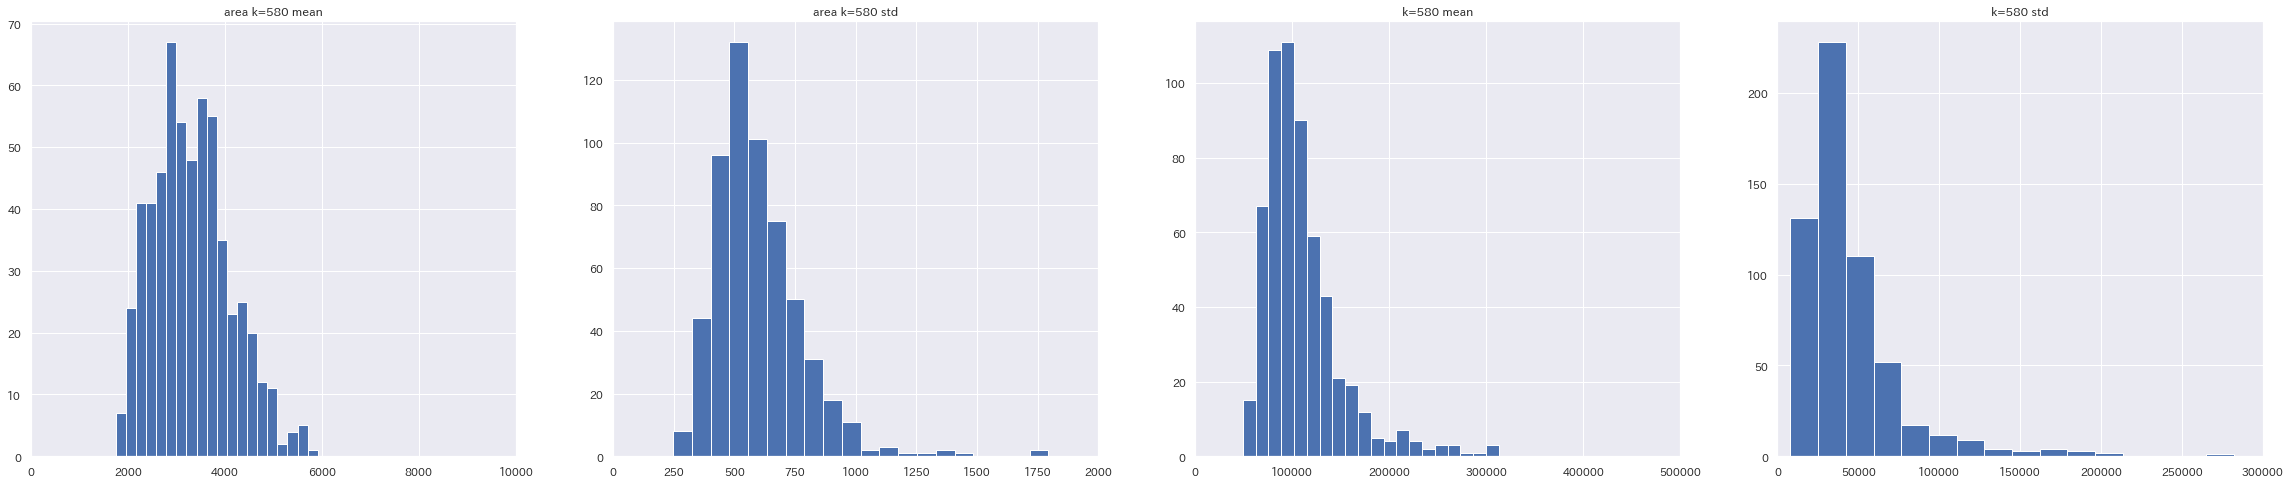

 54%|█████▍    | 54/100 [1:04:21<1:34:35, 123.39s/it]

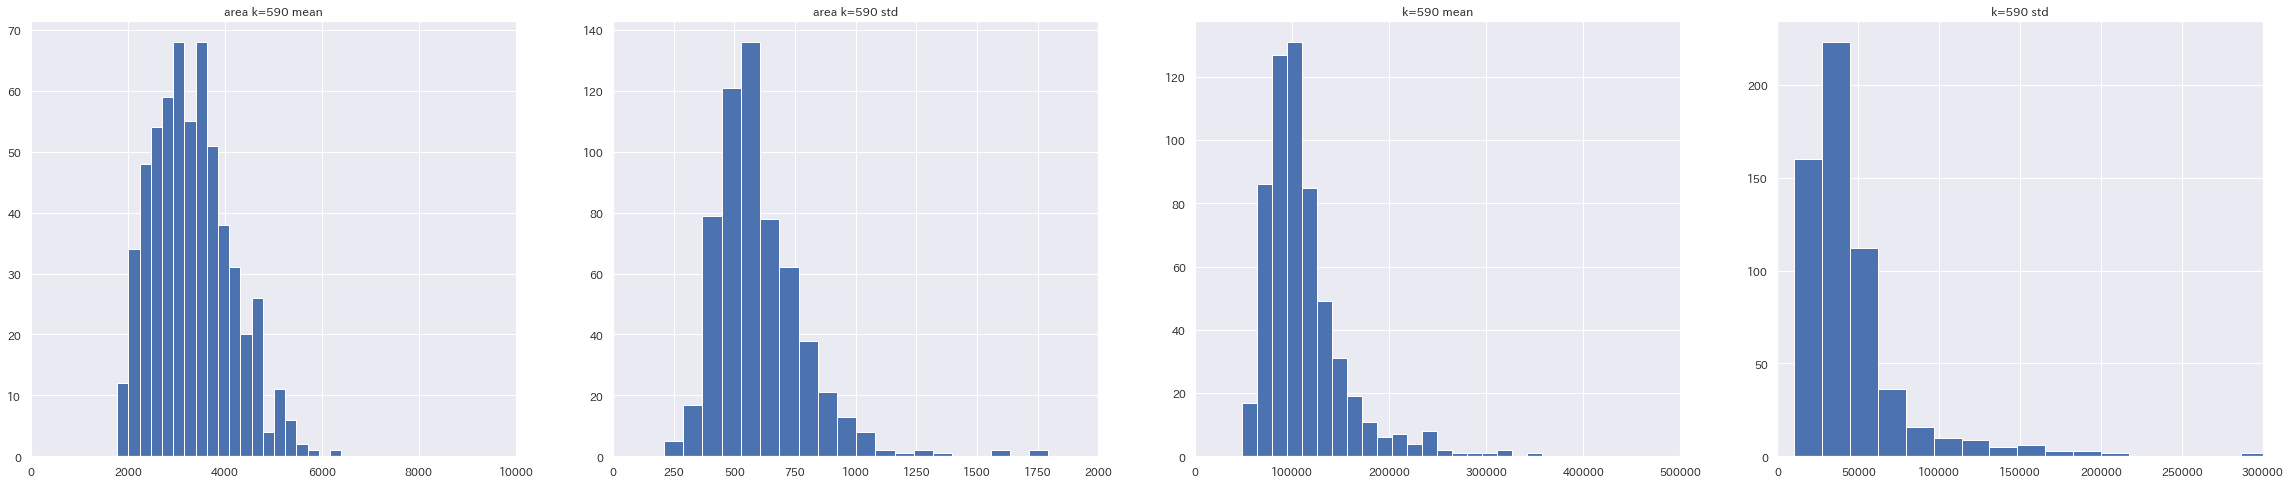

 55%|█████▌    | 55/100 [1:06:47<1:37:37, 130.17s/it]

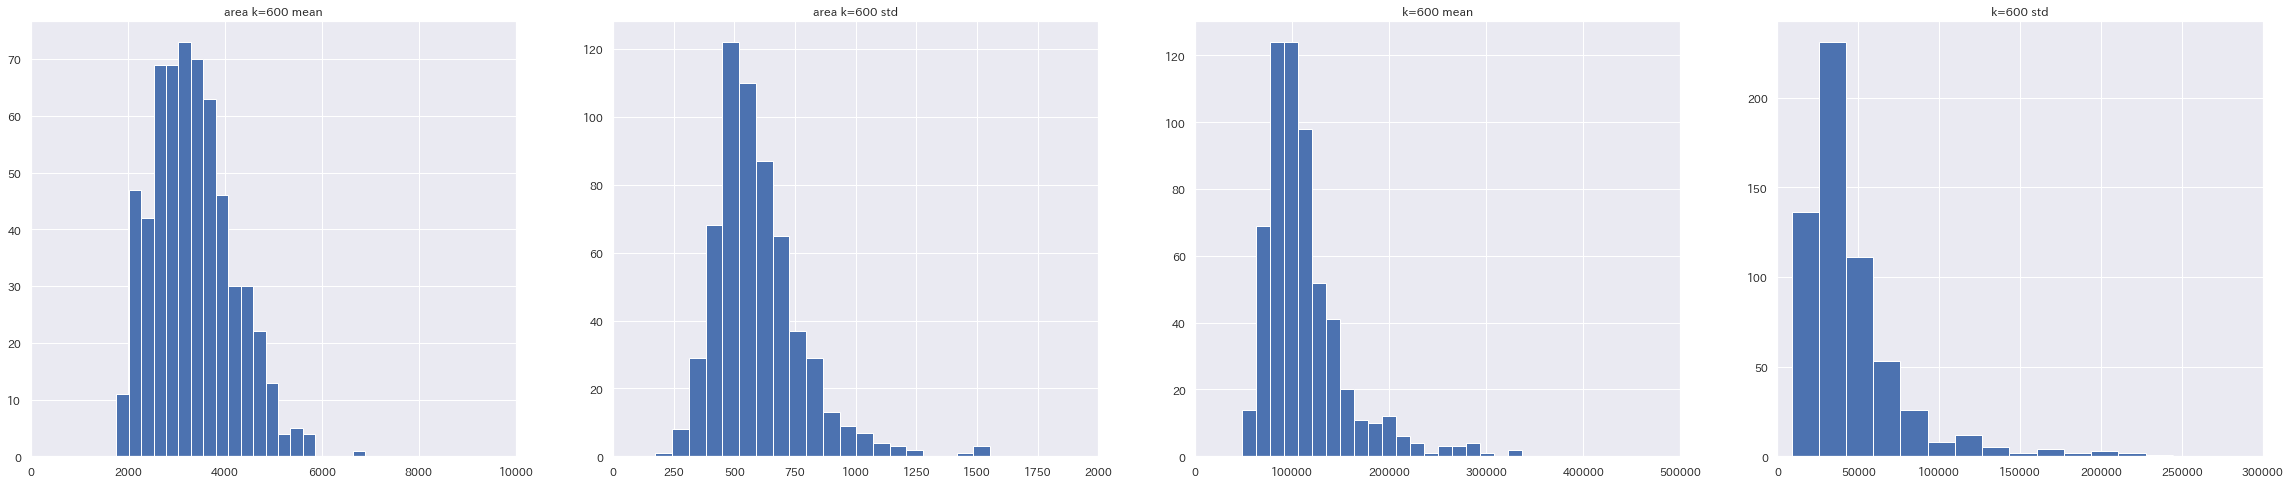

 56%|█████▌    | 56/100 [1:09:19<1:40:12, 136.66s/it]

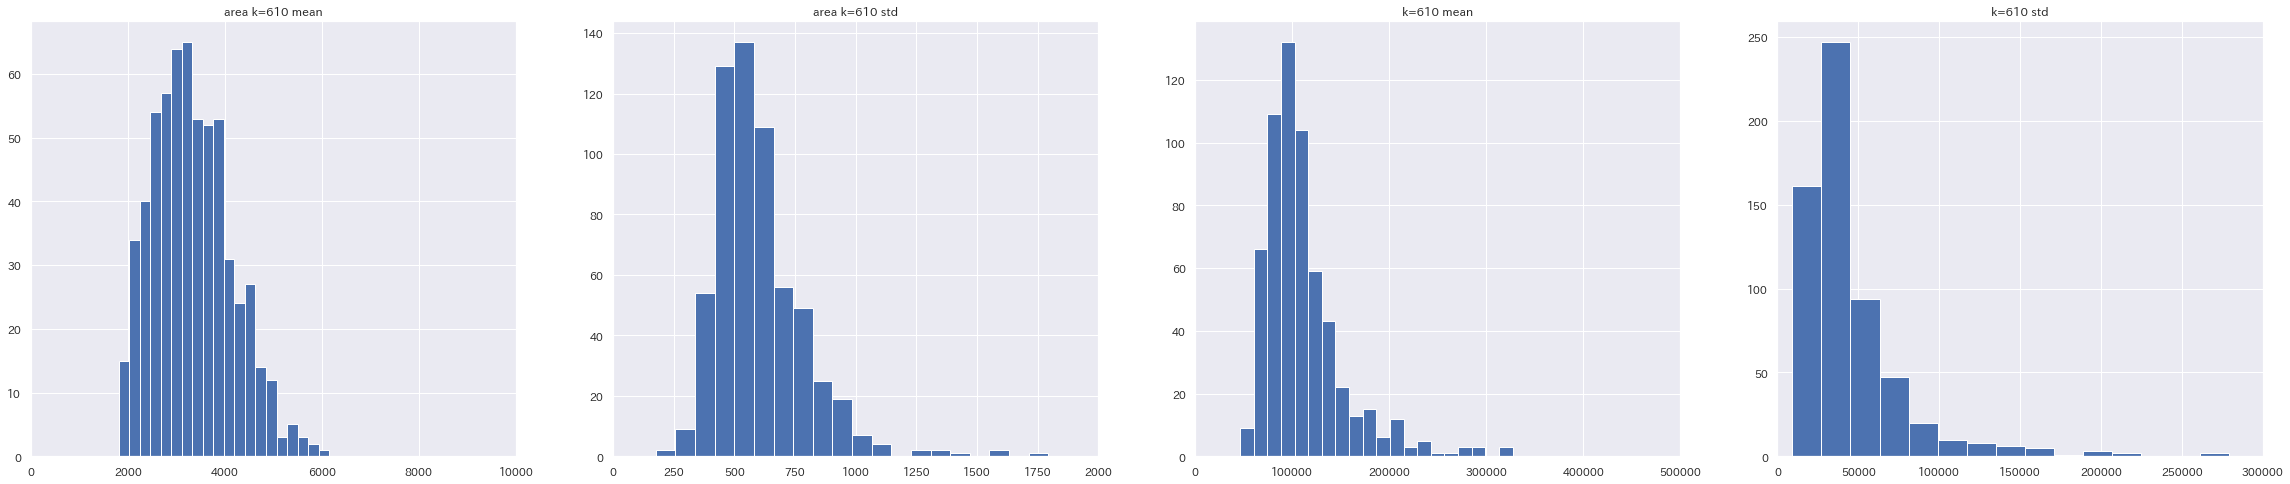

 57%|█████▋    | 57/100 [1:11:52<1:41:31, 141.67s/it]

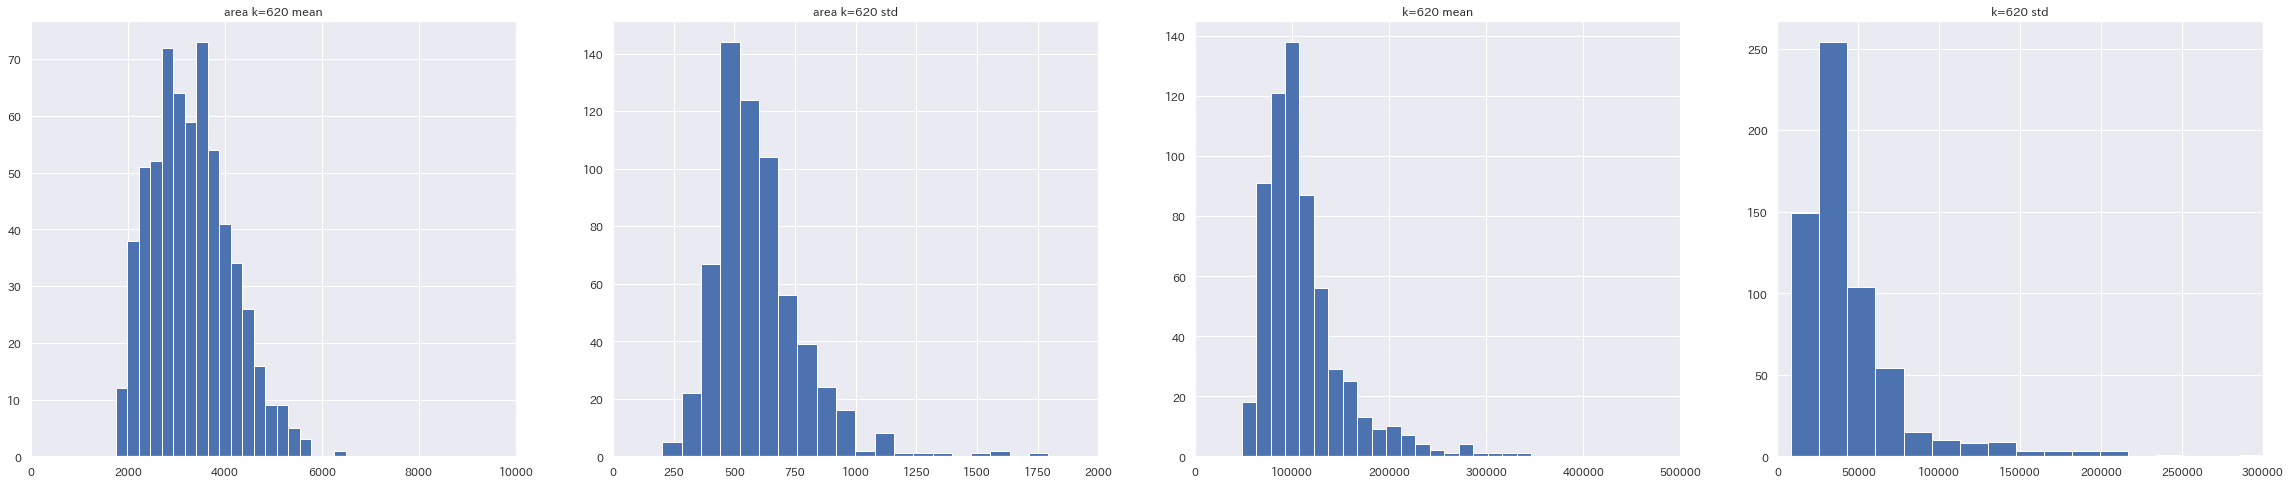

 58%|█████▊    | 58/100 [1:14:18<1:40:02, 142.92s/it]

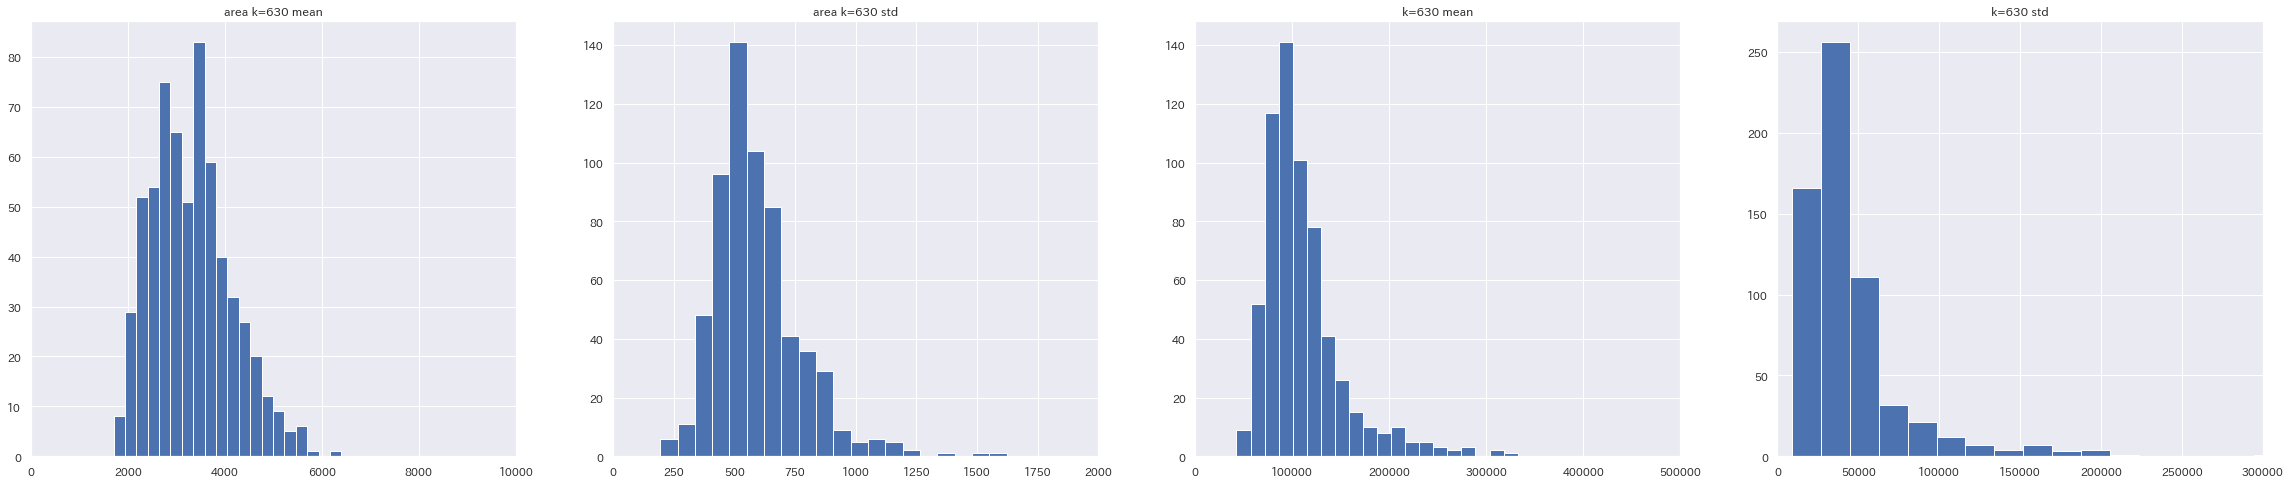

 59%|█████▉    | 59/100 [1:16:51<1:39:43, 145.93s/it]

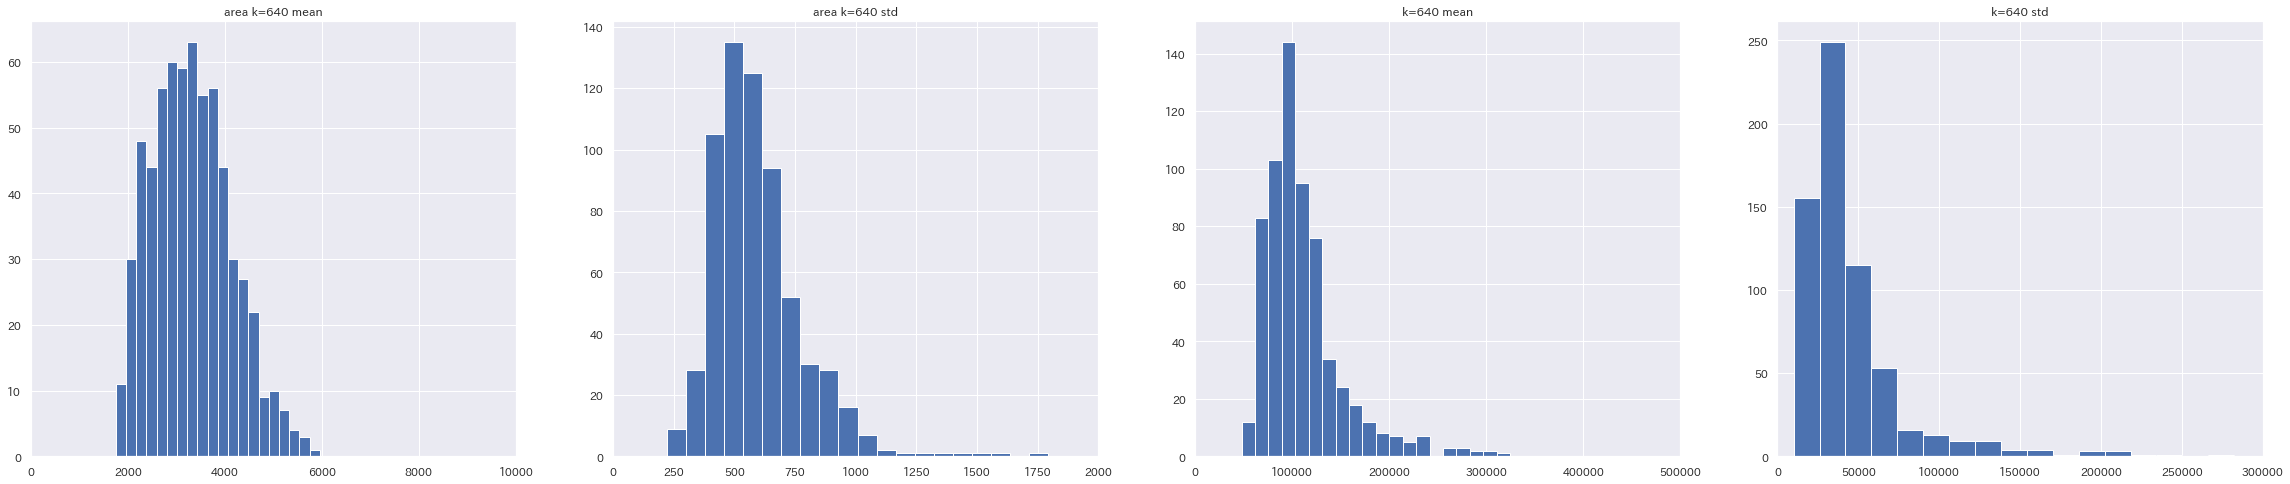

 60%|██████    | 60/100 [1:19:23<1:38:38, 147.97s/it]

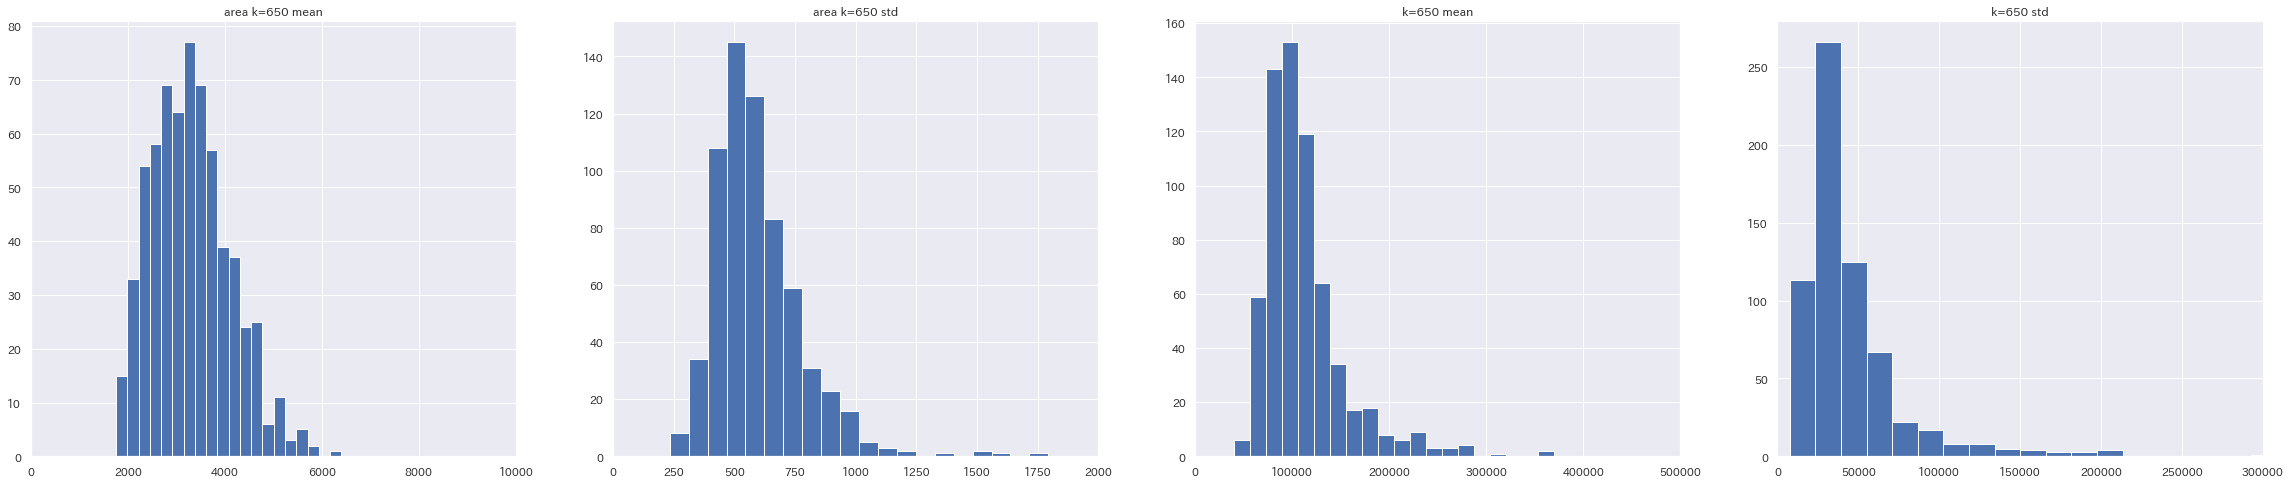

 61%|██████    | 61/100 [1:21:50<1:35:56, 147.61s/it]

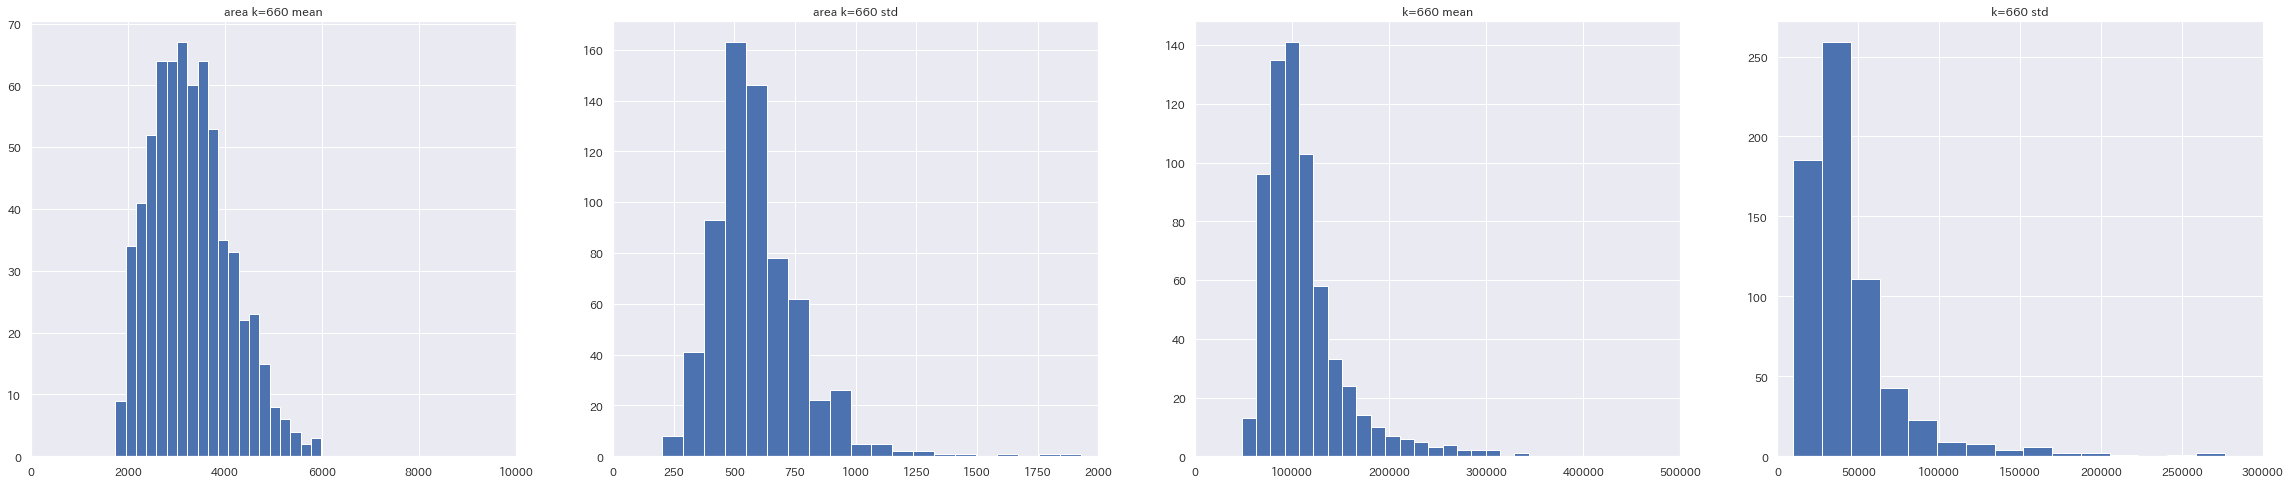

 62%|██████▏   | 62/100 [1:24:31<1:35:54, 151.43s/it]

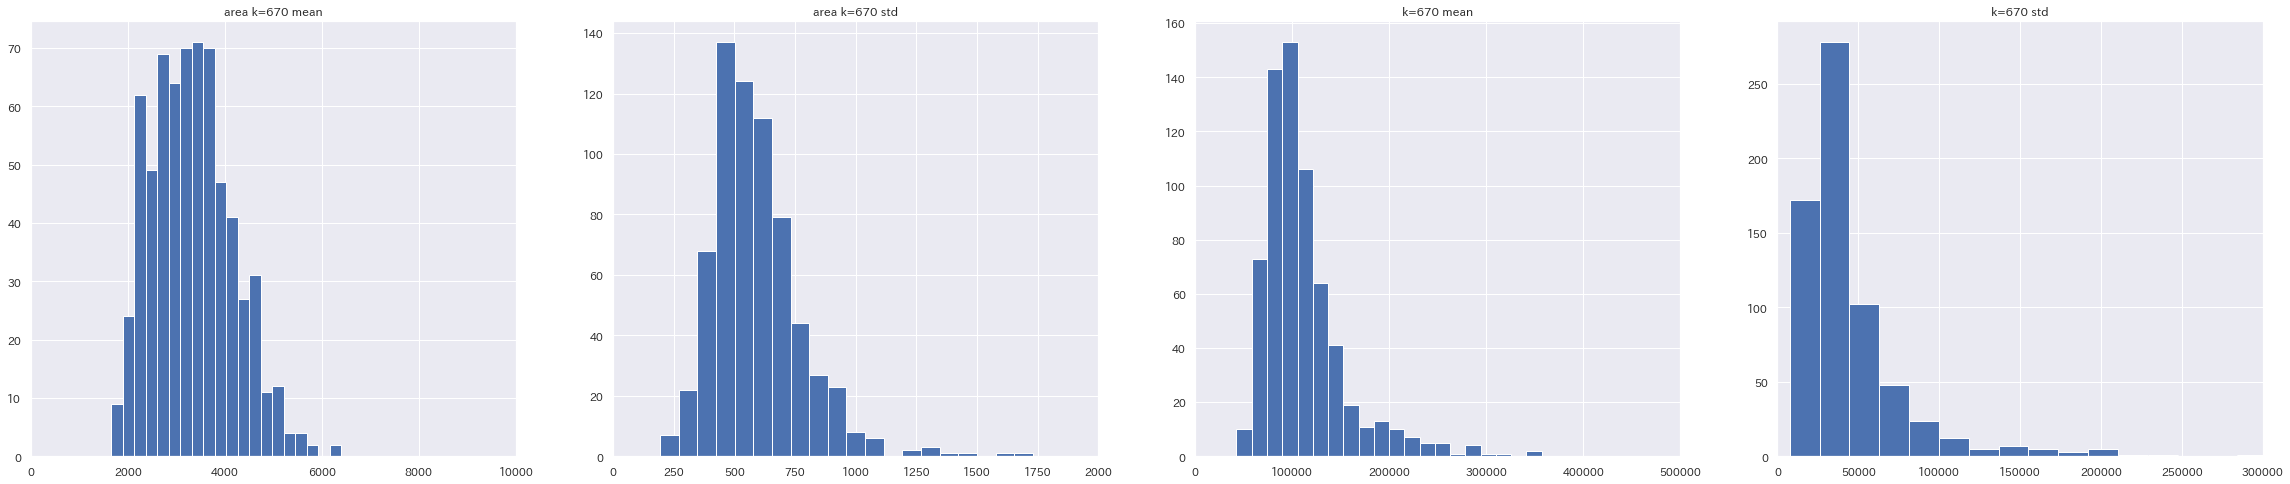

 63%|██████▎   | 63/100 [1:27:17<1:36:09, 155.95s/it]

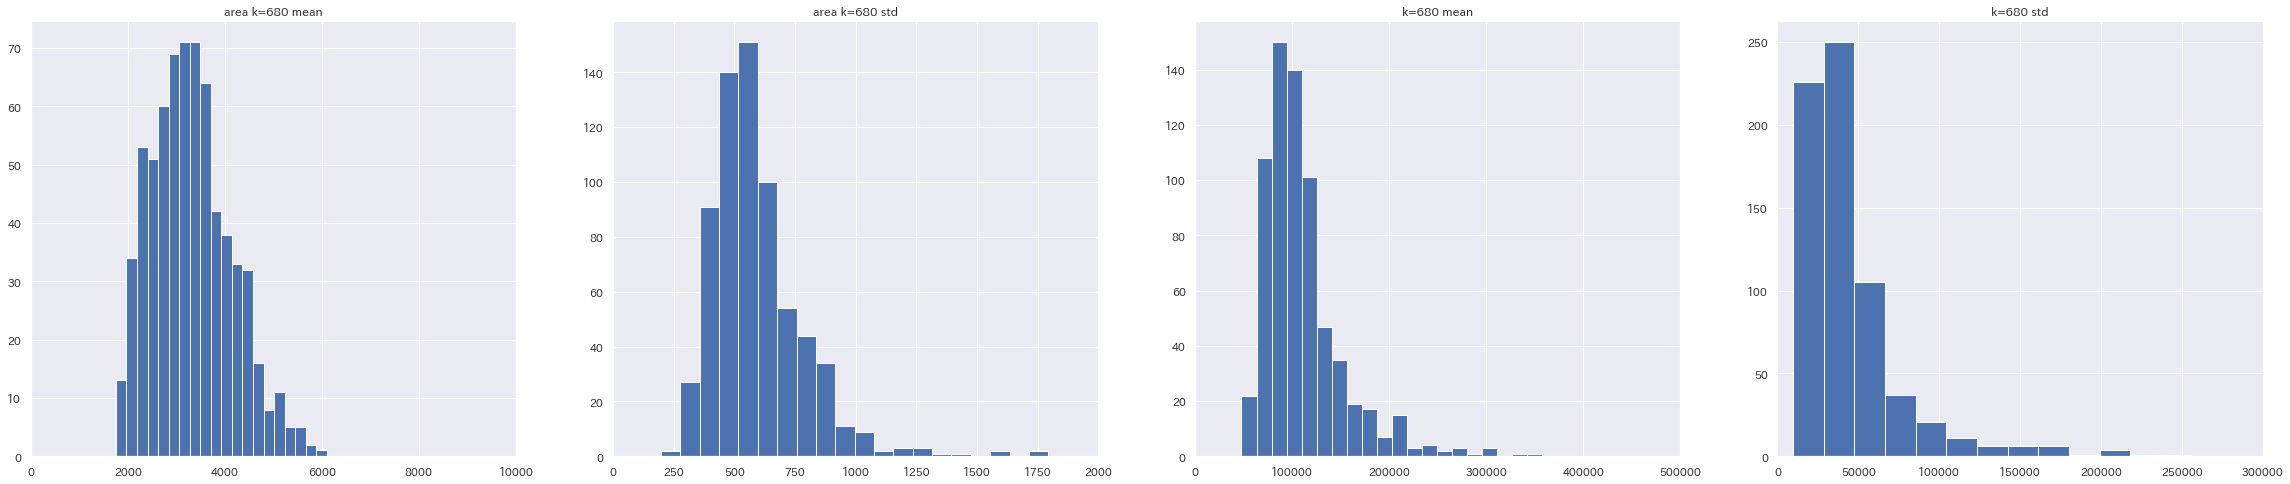

 64%|██████▍   | 64/100 [1:29:55<1:33:55, 156.54s/it]

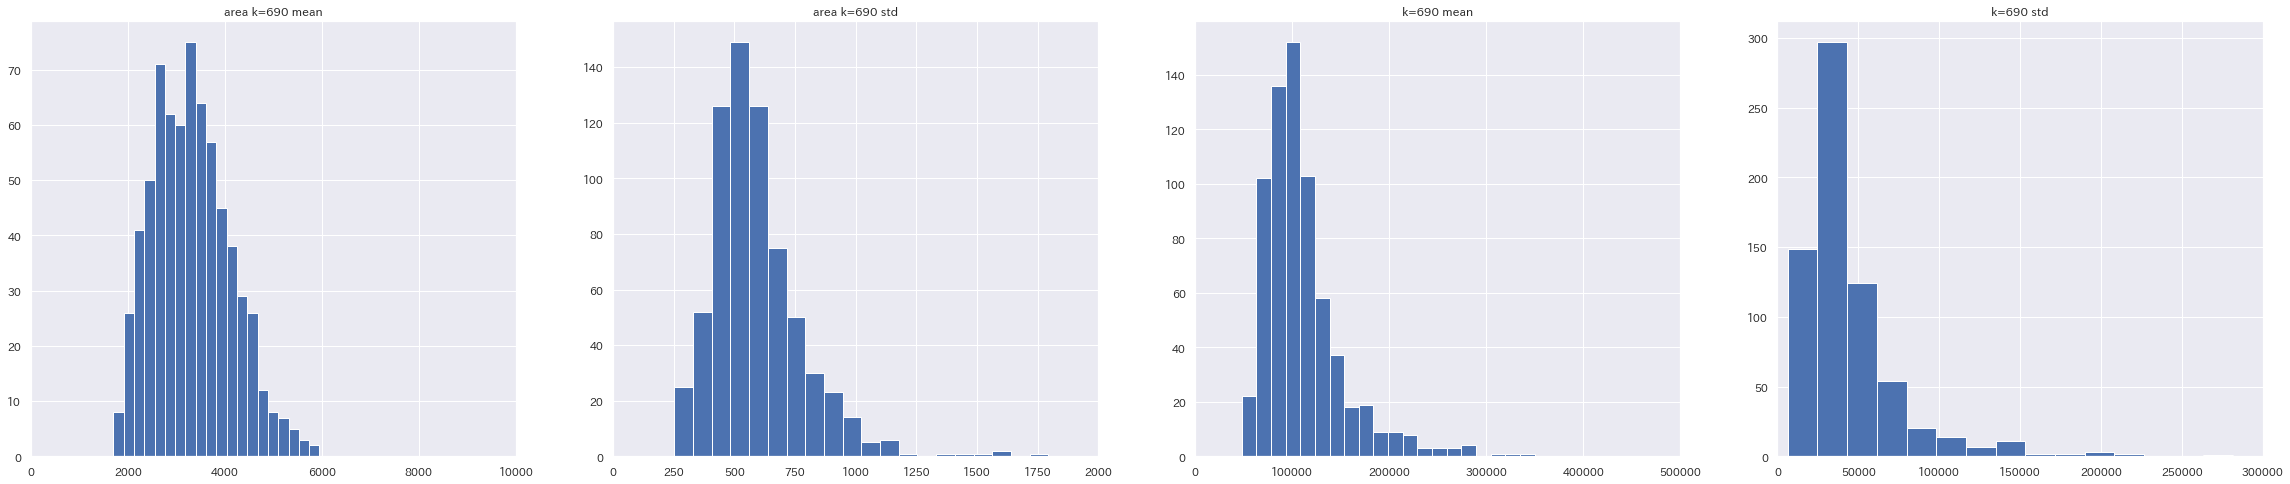

 65%|██████▌   | 65/100 [1:32:37<1:32:12, 158.08s/it]

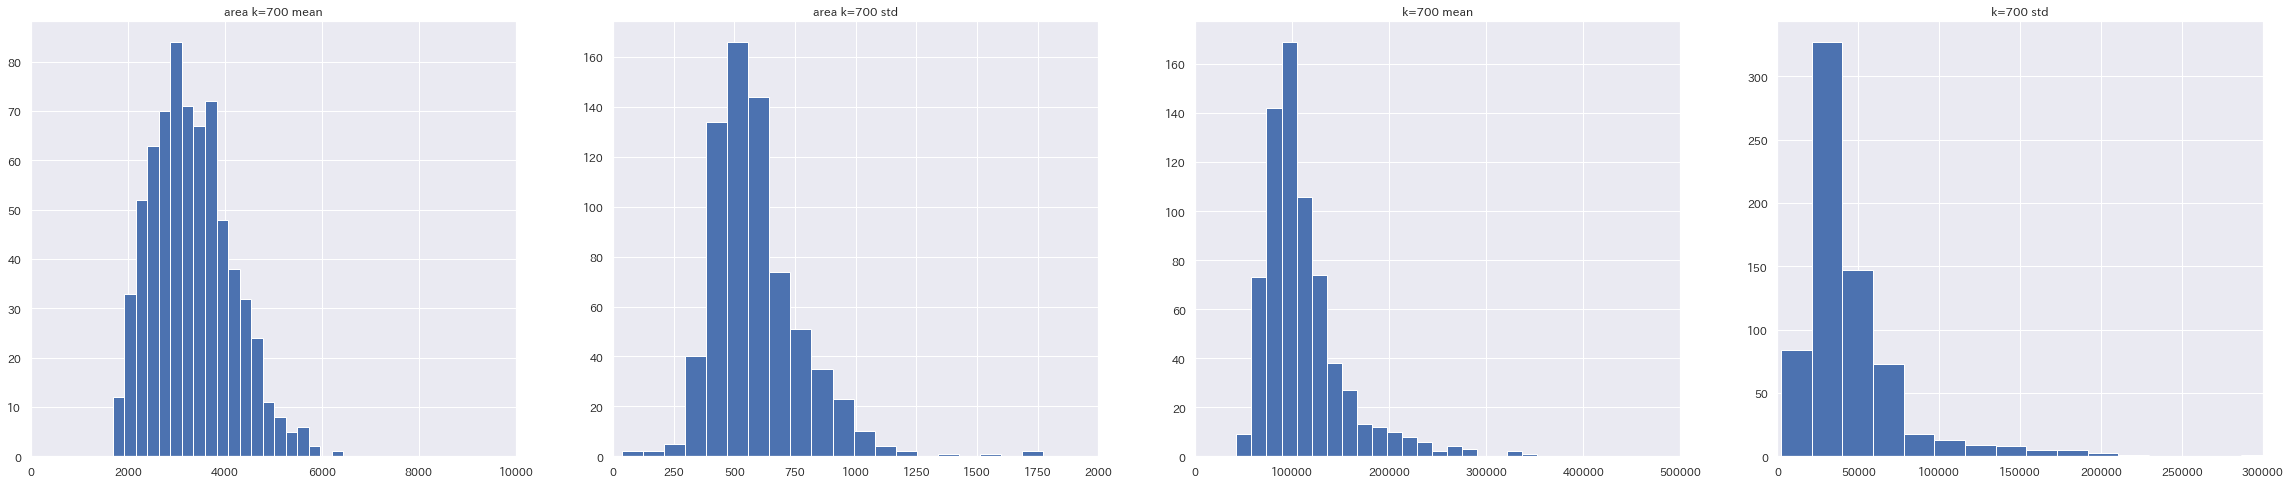

 66%|██████▌   | 66/100 [1:35:17<1:29:53, 158.64s/it]

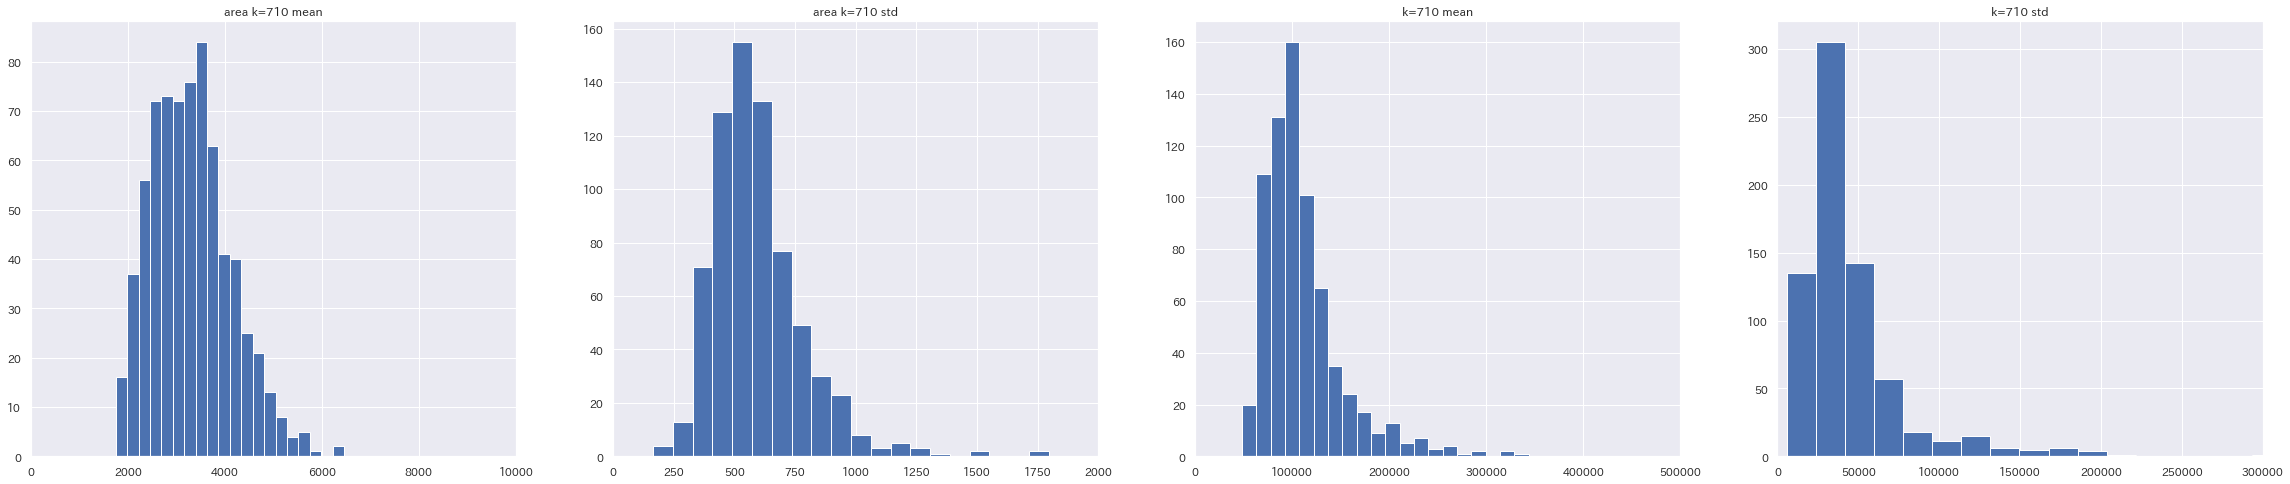

 67%|██████▋   | 67/100 [1:38:08<1:29:18, 162.39s/it]

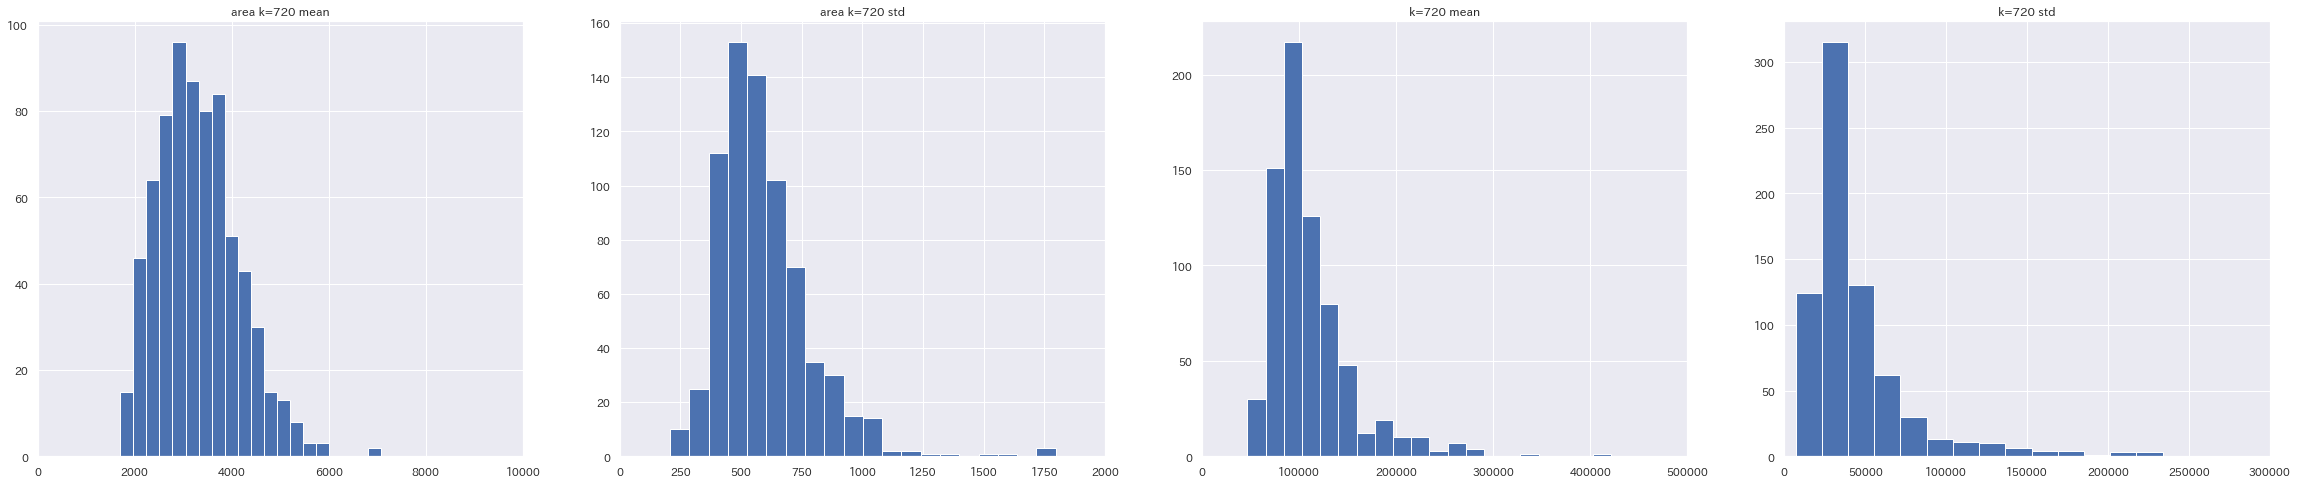

 68%|██████▊   | 68/100 [1:41:01<1:28:16, 165.51s/it]

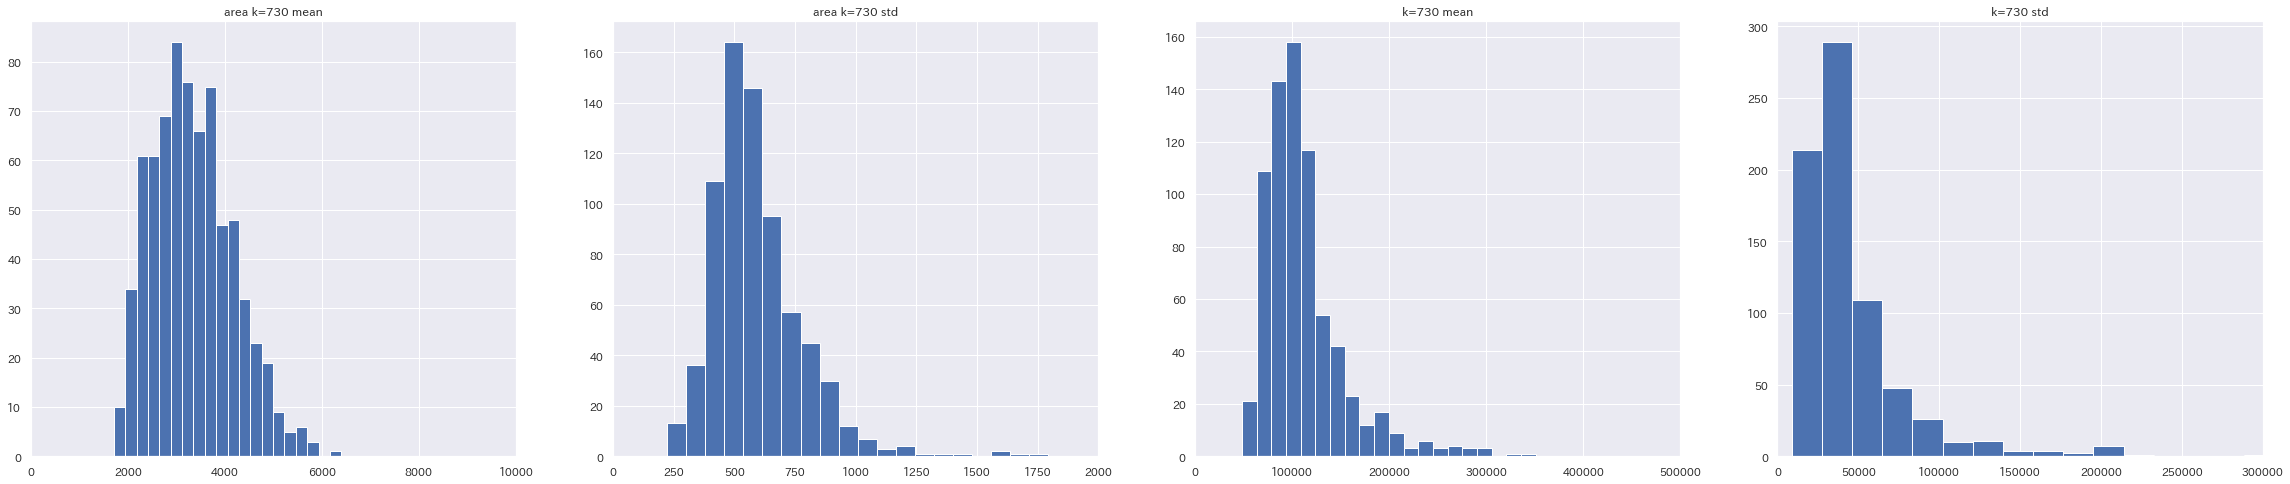

 69%|██████▉   | 69/100 [1:44:02<1:28:02, 170.40s/it]

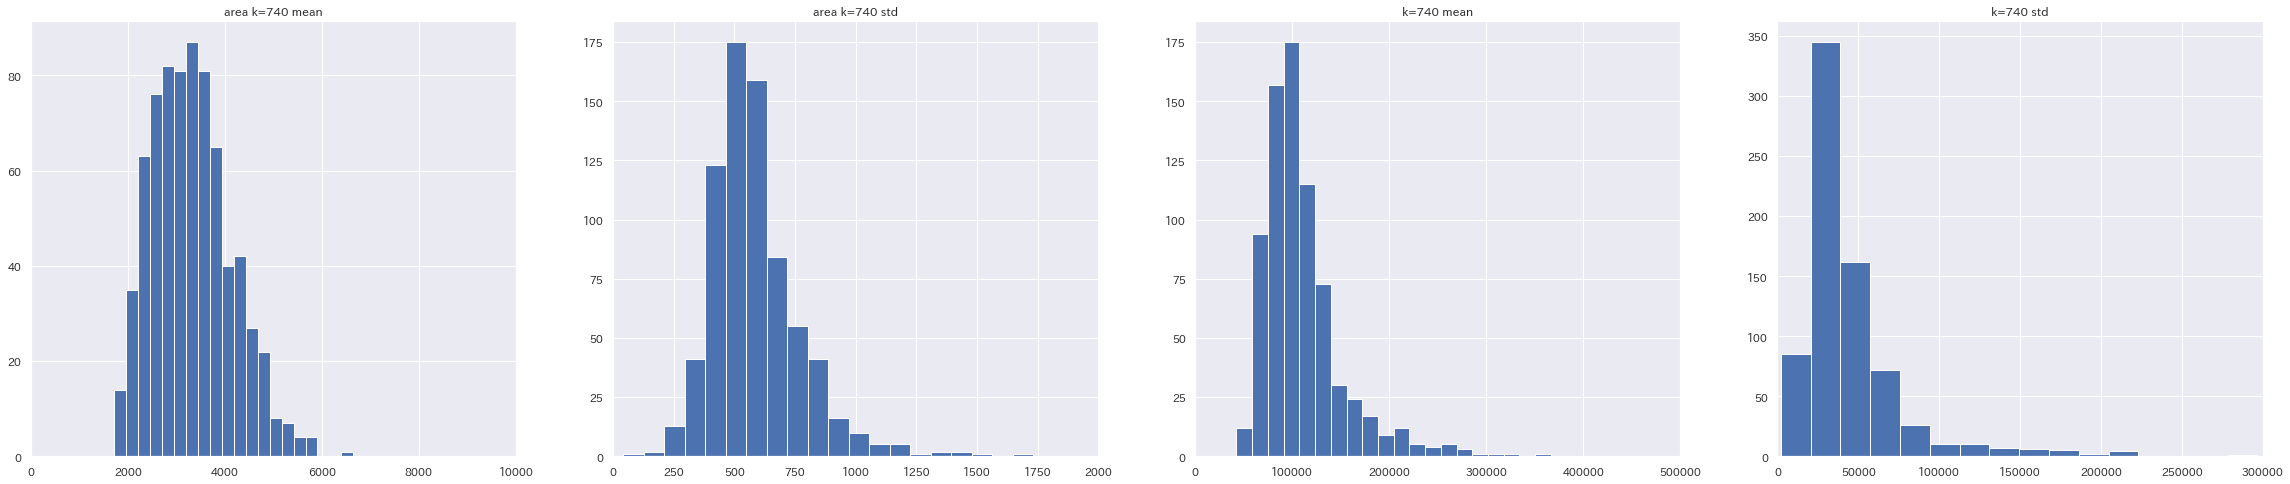

 70%|███████   | 70/100 [1:46:57<1:25:45, 171.52s/it]

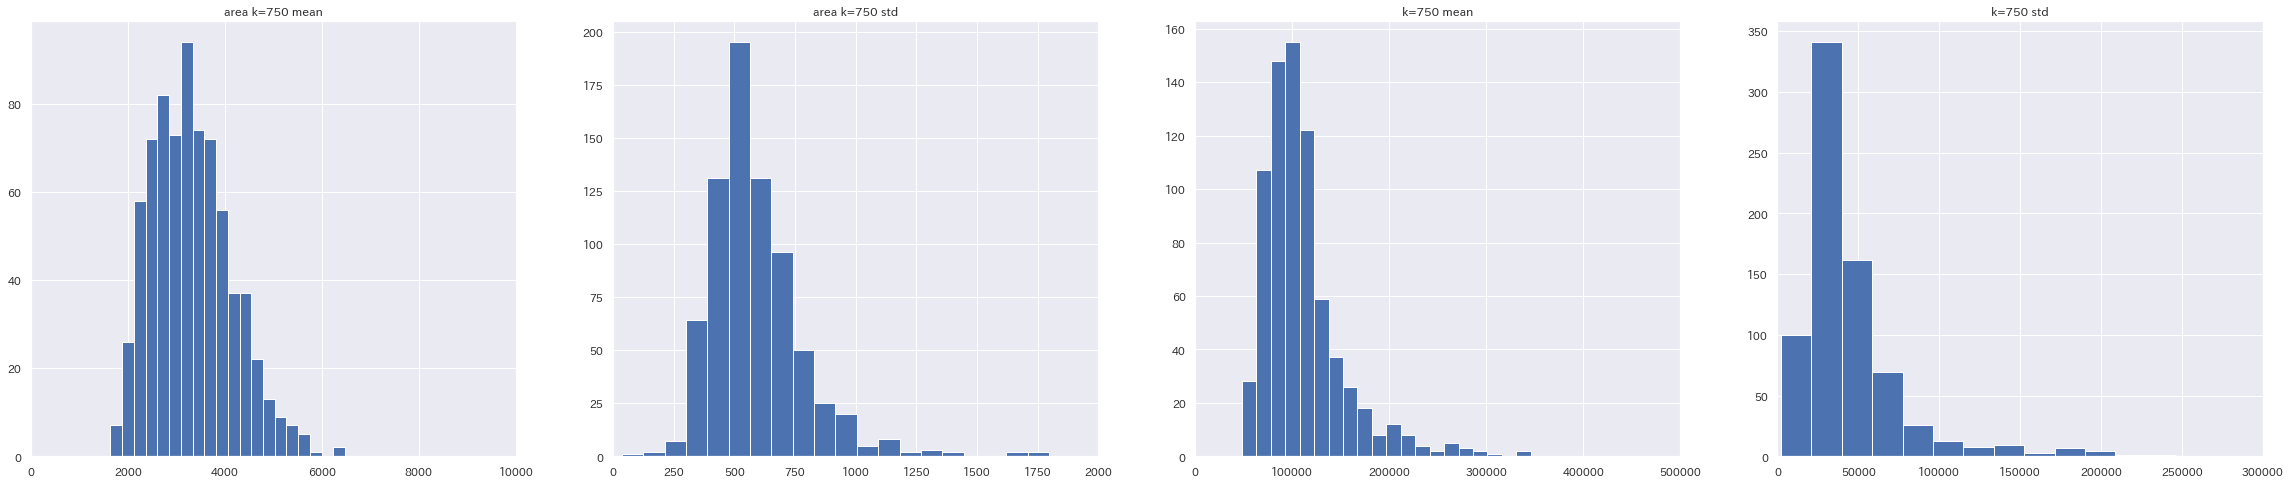

 71%|███████   | 71/100 [1:50:12<1:26:25, 178.80s/it]

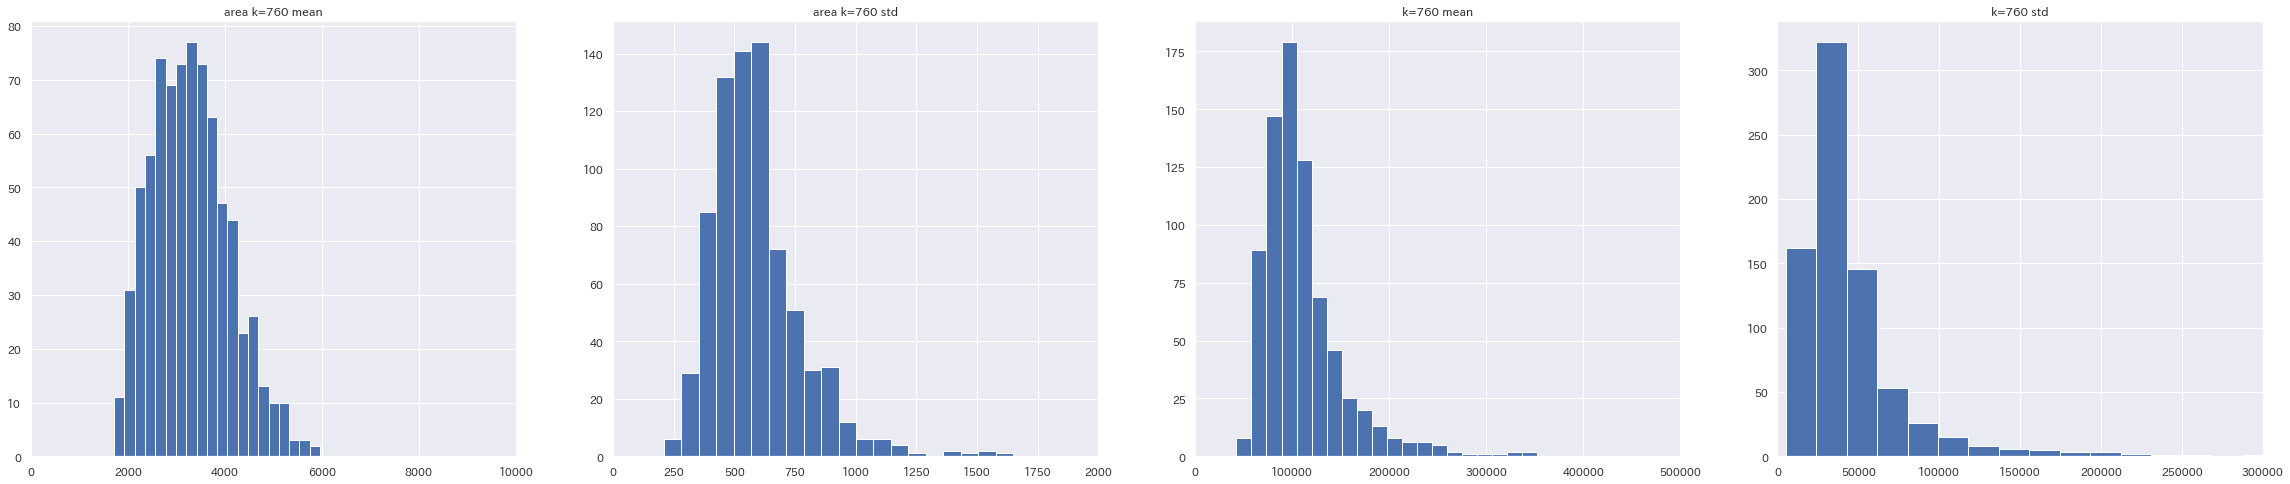

 72%|███████▏  | 72/100 [1:53:22<1:24:54, 181.94s/it]

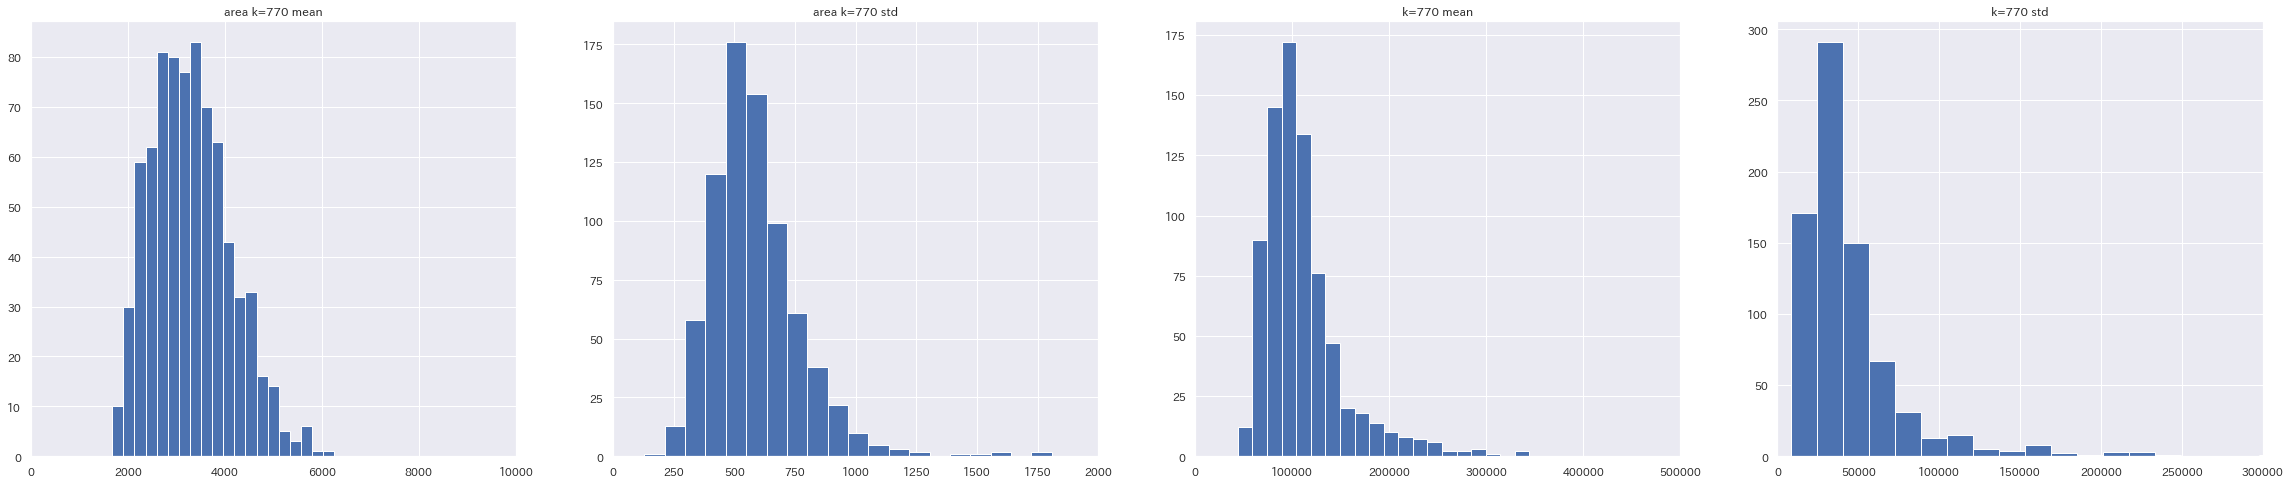

 73%|███████▎  | 73/100 [1:56:22<1:21:40, 181.49s/it]

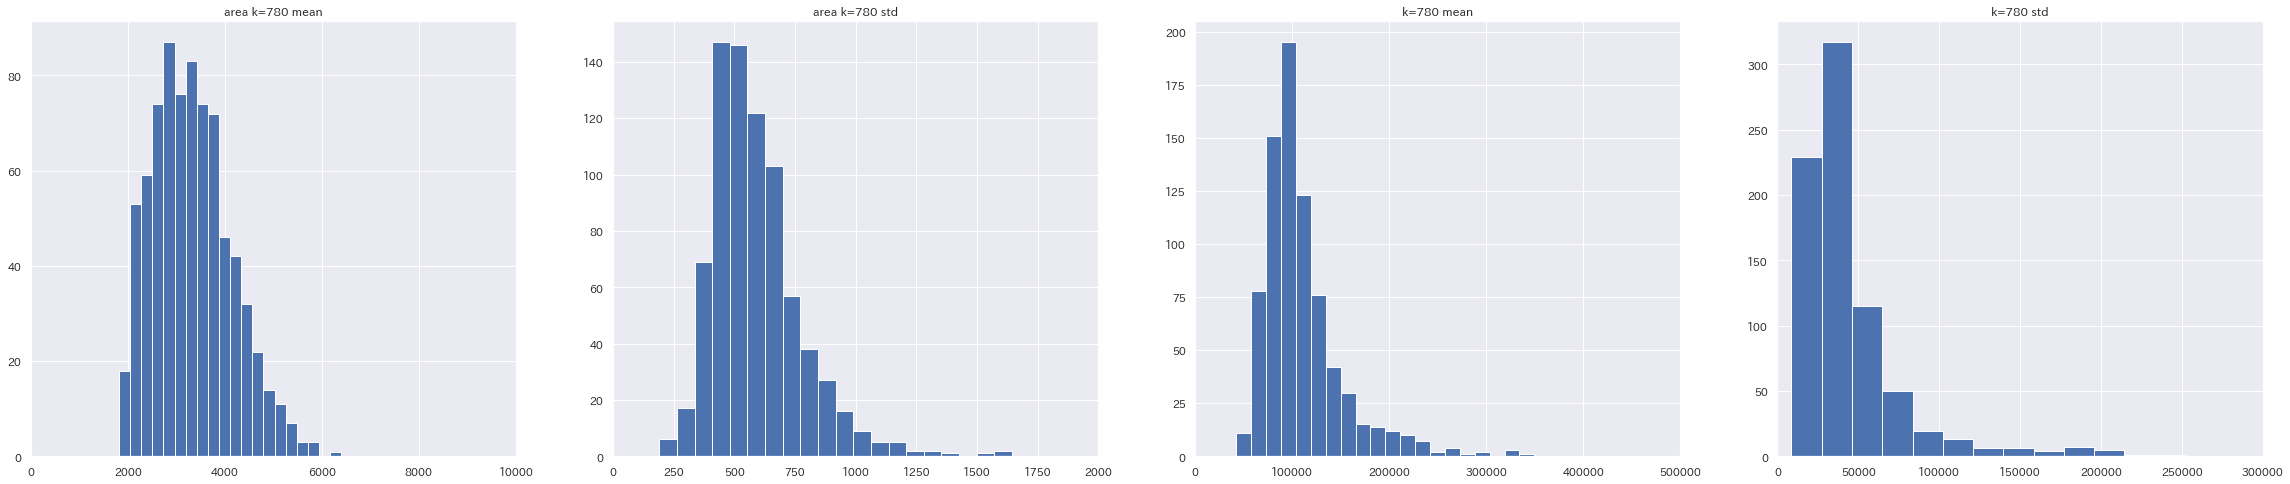

 74%|███████▍  | 74/100 [1:59:30<1:19:26, 183.33s/it]

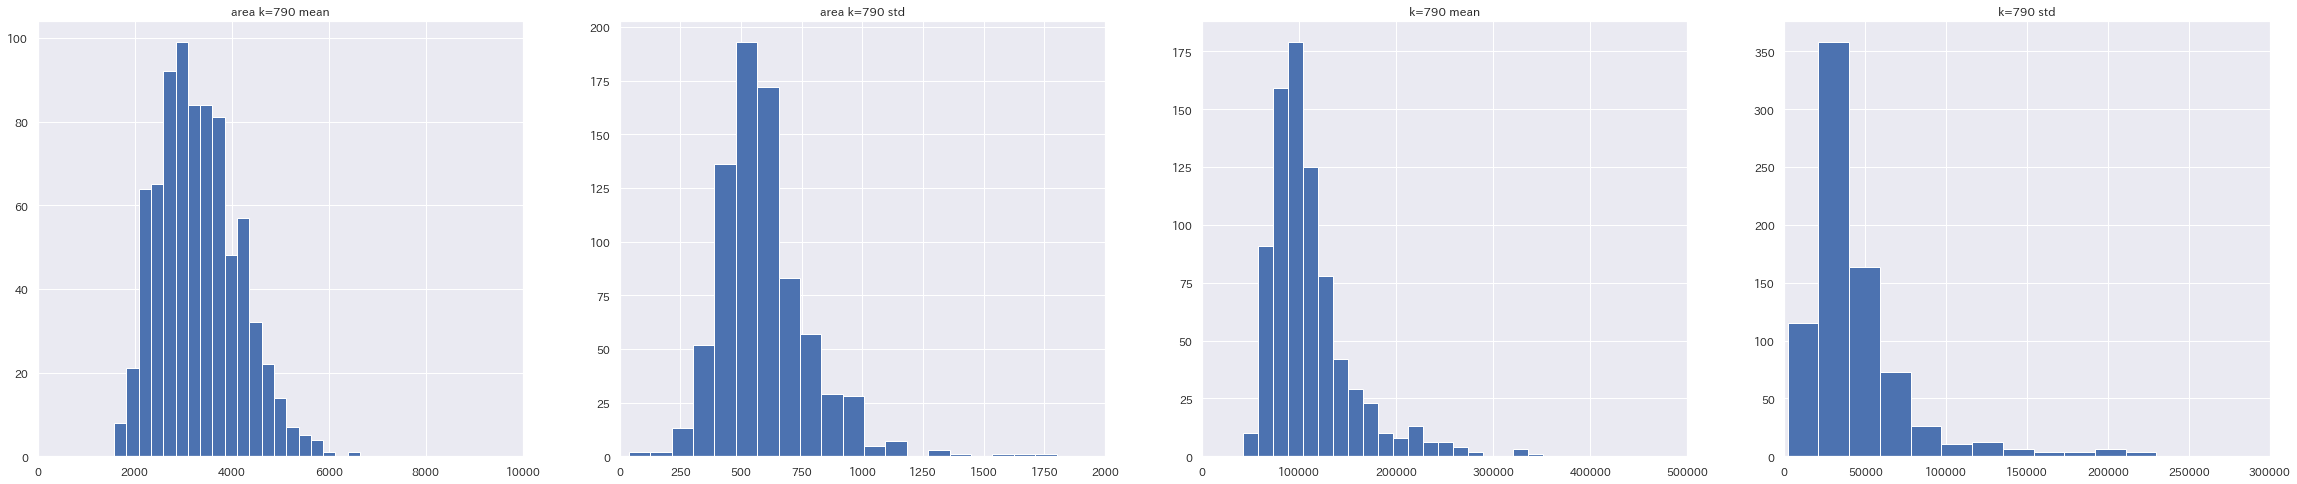

 75%|███████▌  | 75/100 [2:02:43<1:17:39, 186.38s/it]

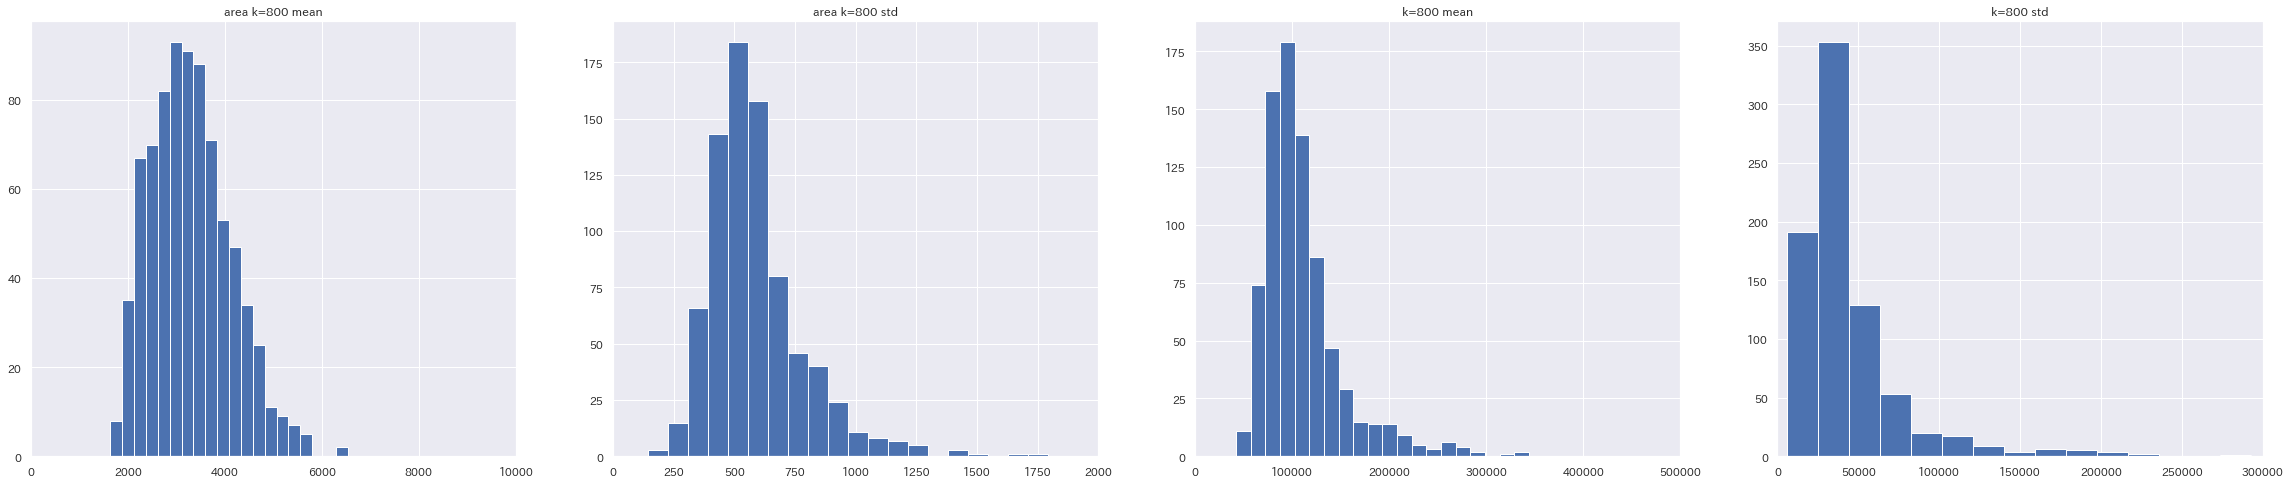

 76%|███████▌  | 76/100 [2:05:48<1:14:21, 185.89s/it]

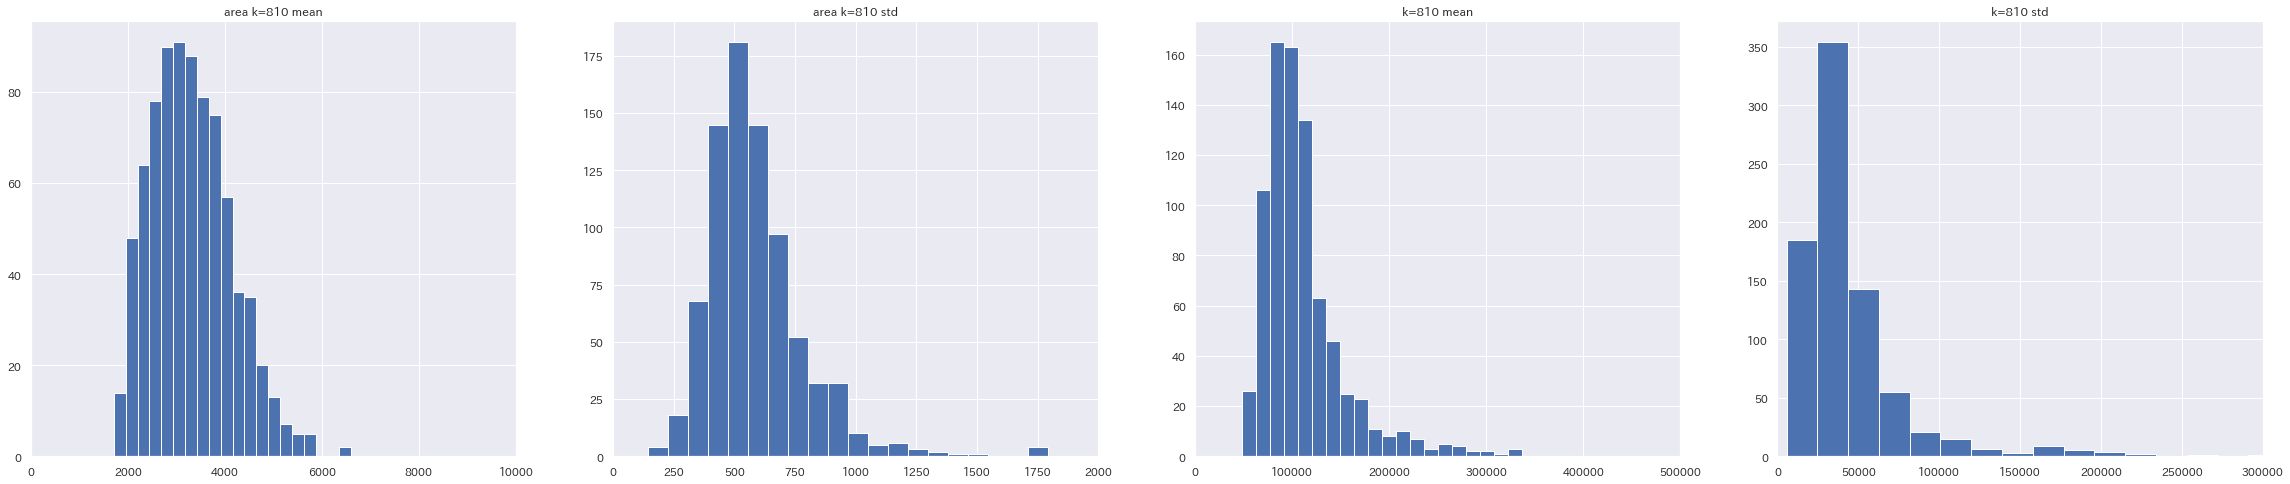

 77%|███████▋  | 77/100 [2:09:04<1:12:26, 188.98s/it]

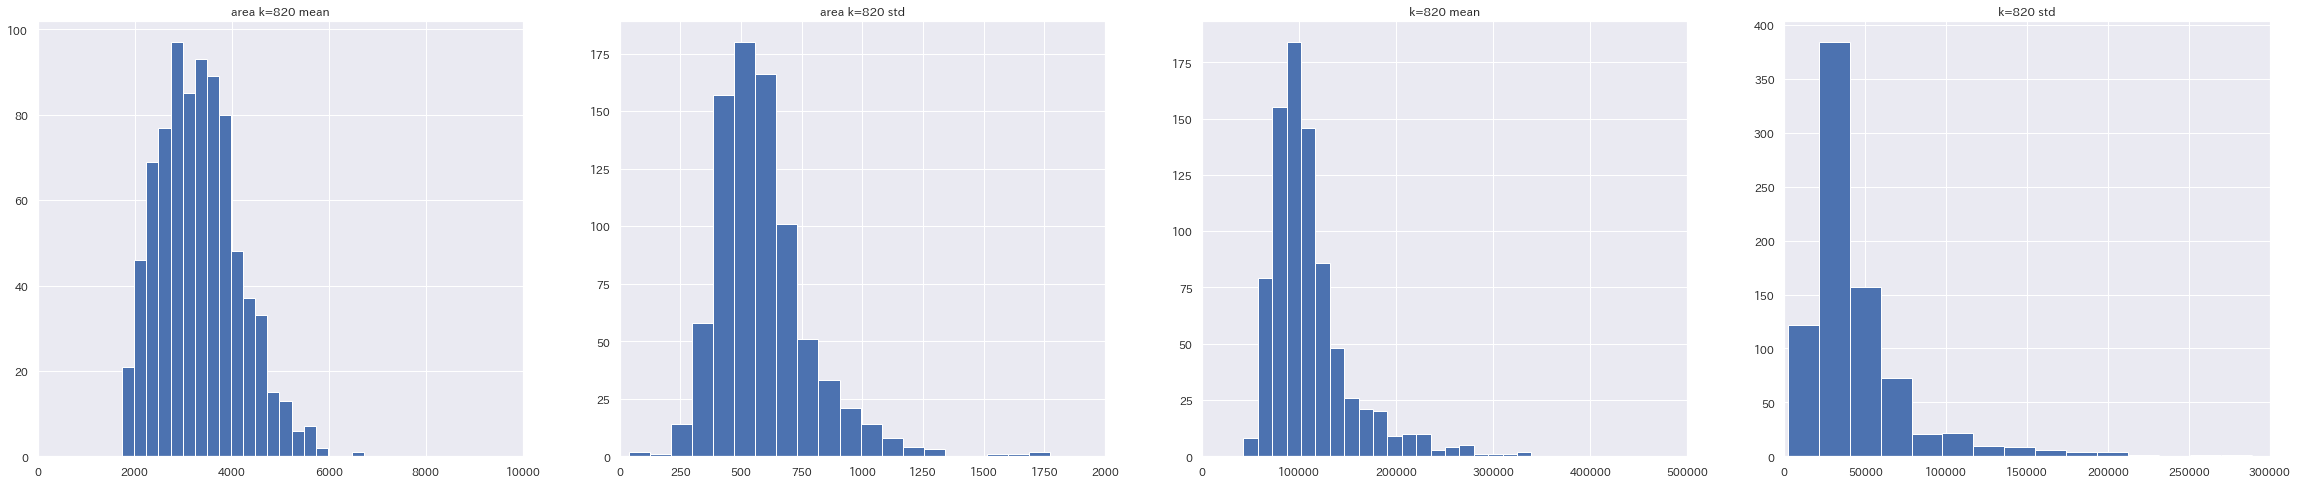

 78%|███████▊  | 78/100 [2:12:22<1:10:19, 191.77s/it]

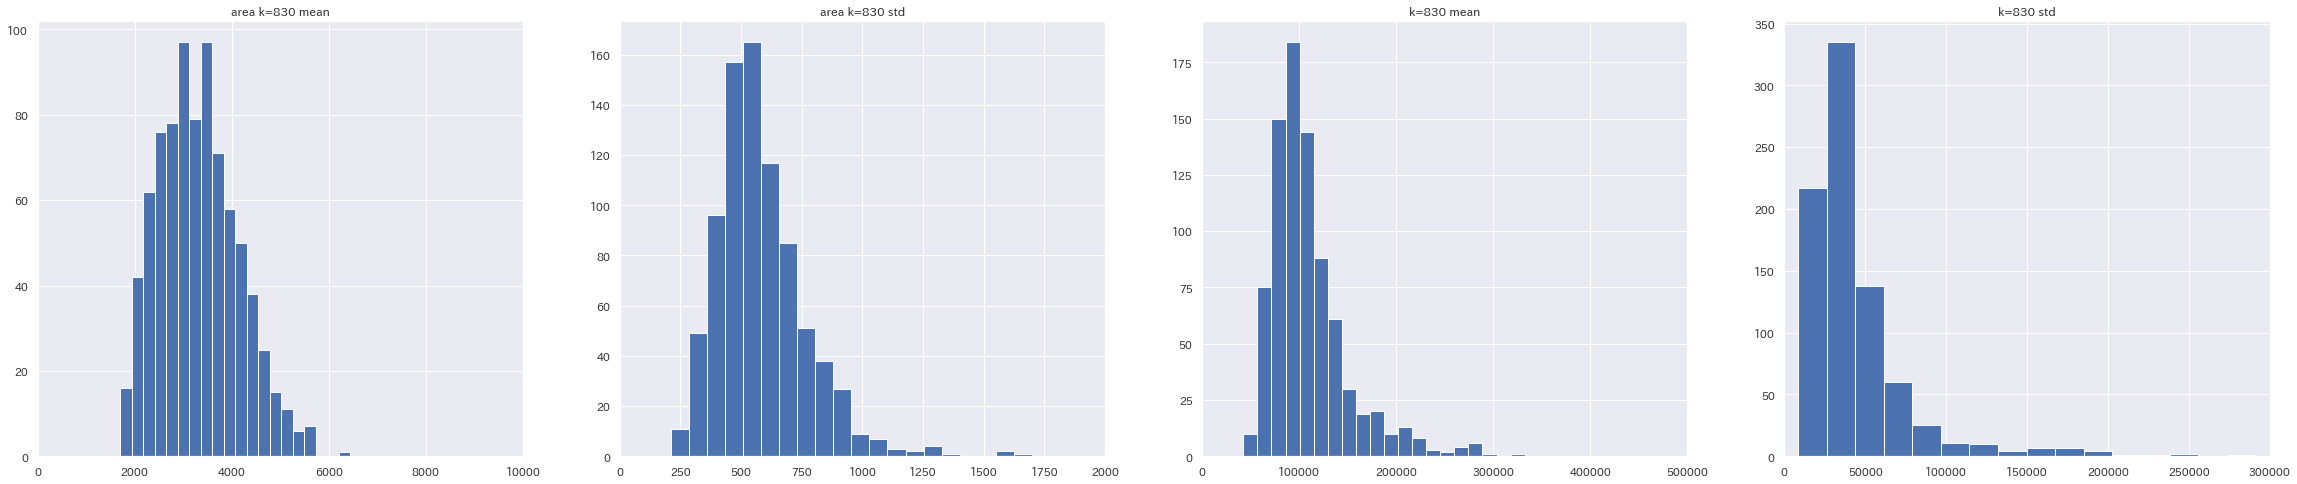

 79%|███████▉  | 79/100 [2:15:55<1:09:21, 198.15s/it]

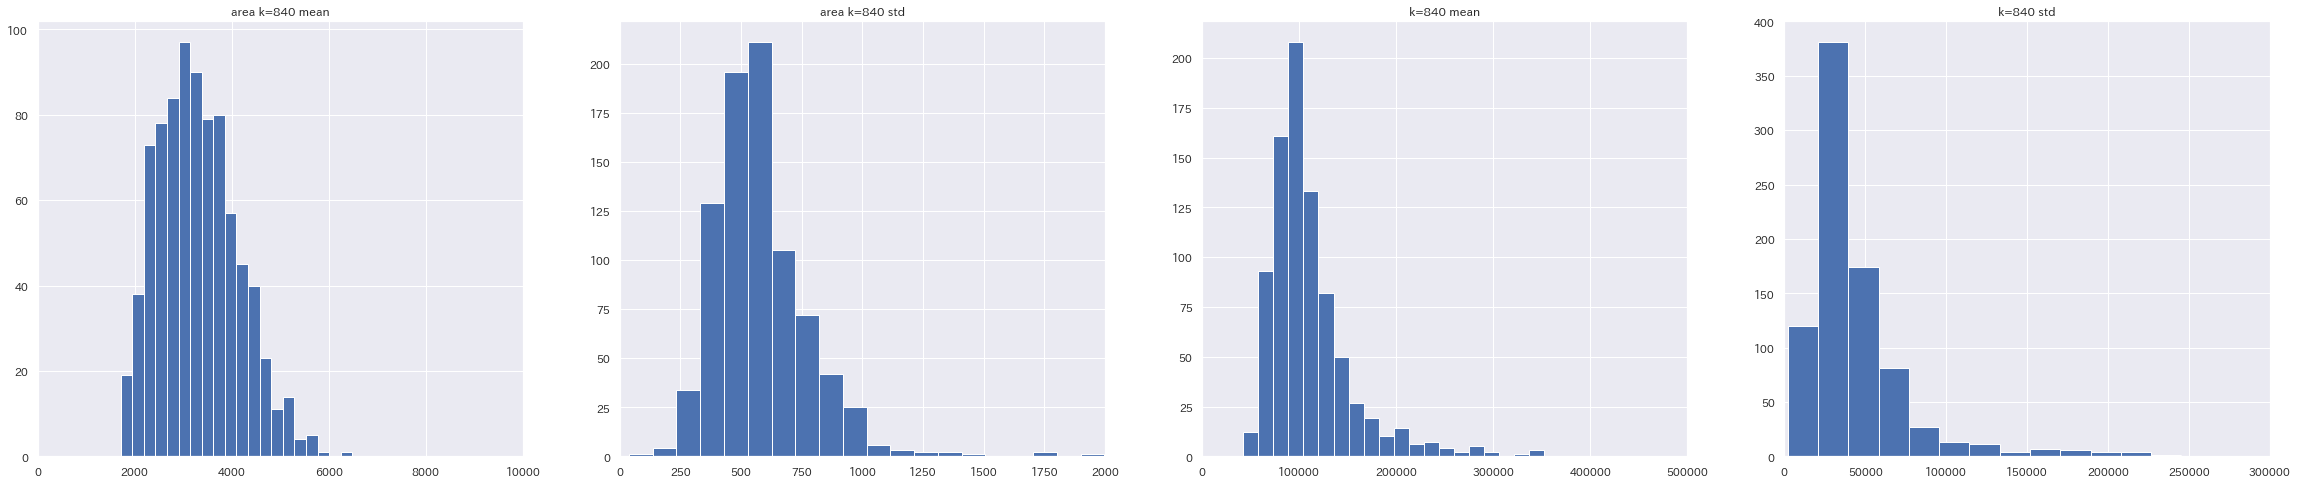

 80%|████████  | 80/100 [2:19:19<1:06:36, 199.83s/it]

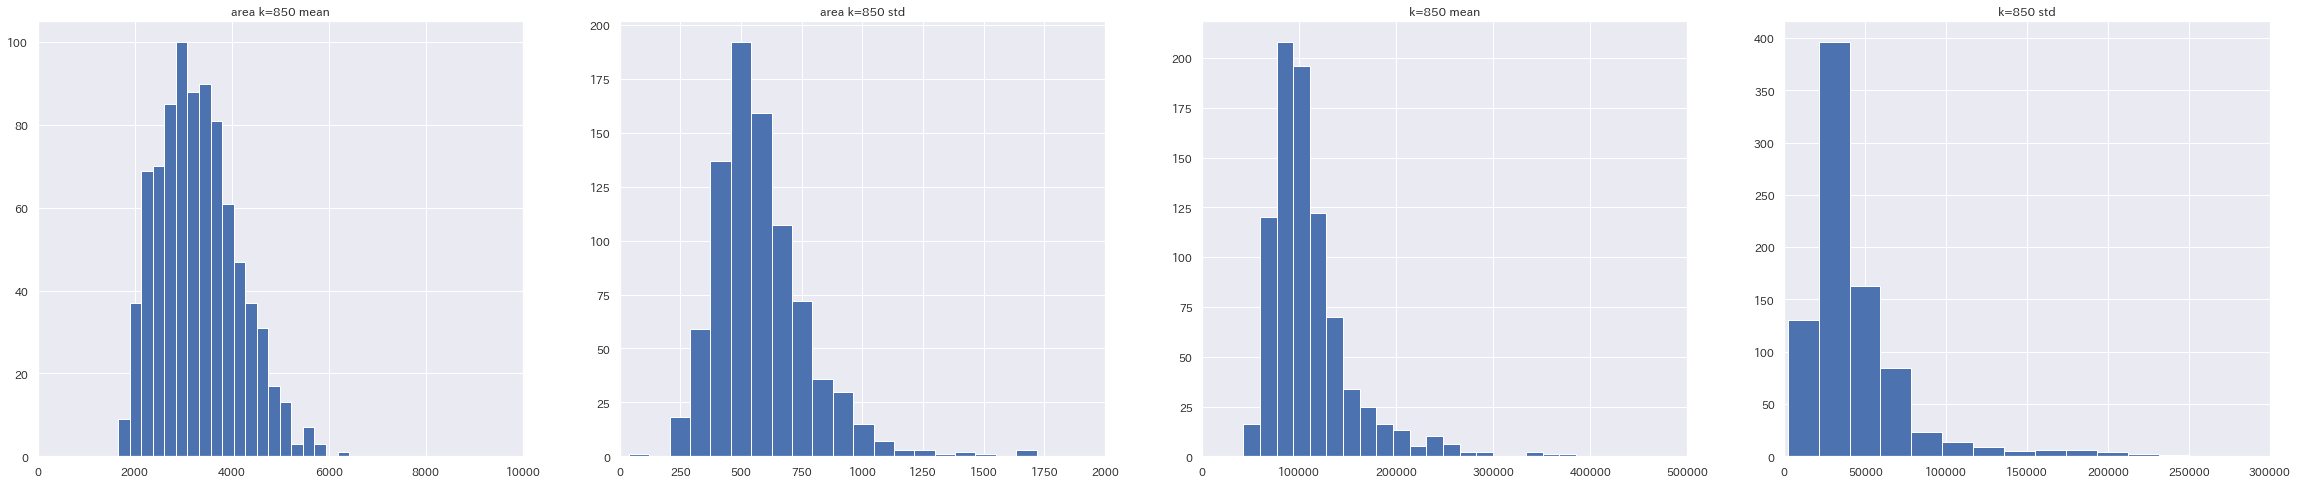

 81%|████████  | 81/100 [2:22:58<1:05:06, 205.62s/it]

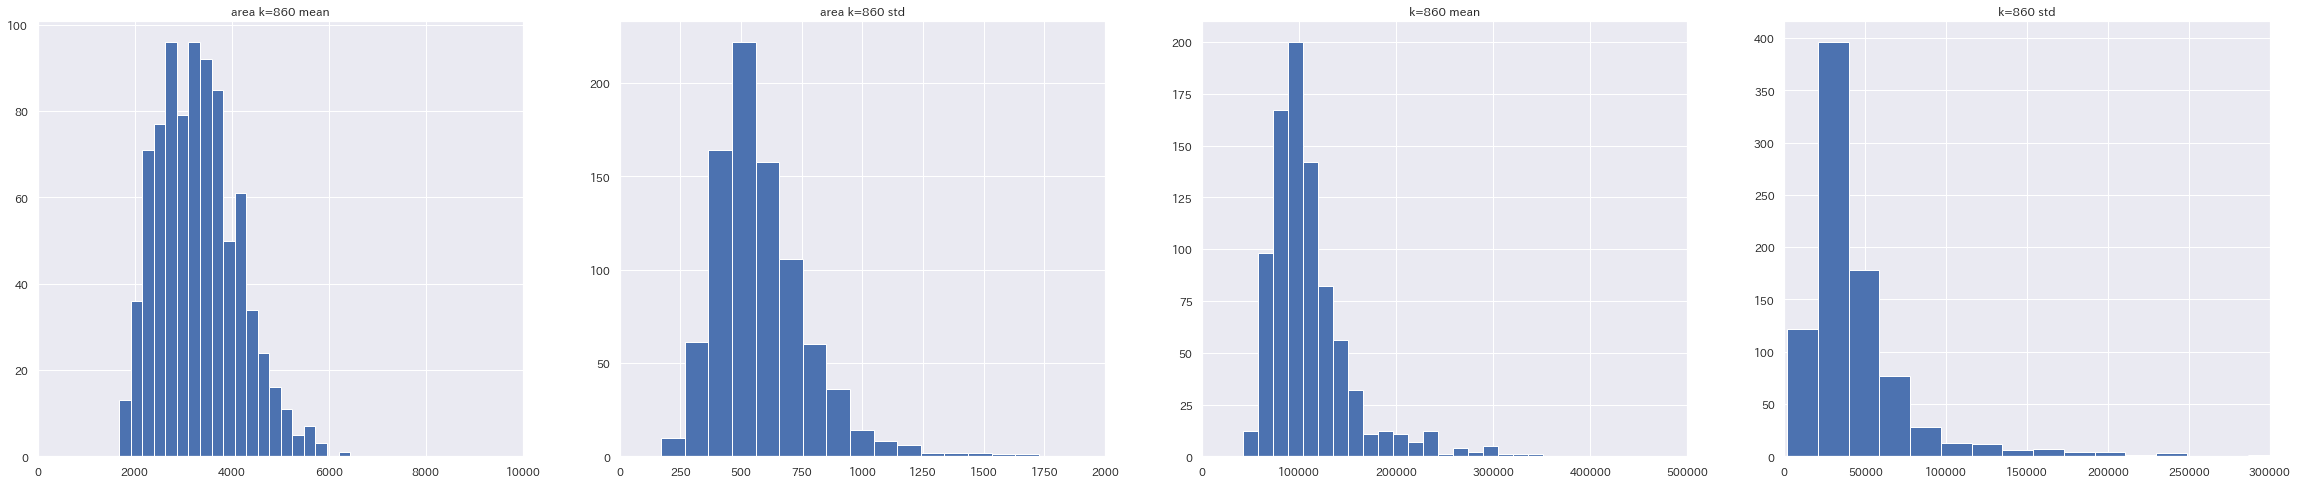

 82%|████████▏ | 82/100 [2:25:22<56:08, 187.12s/it]  

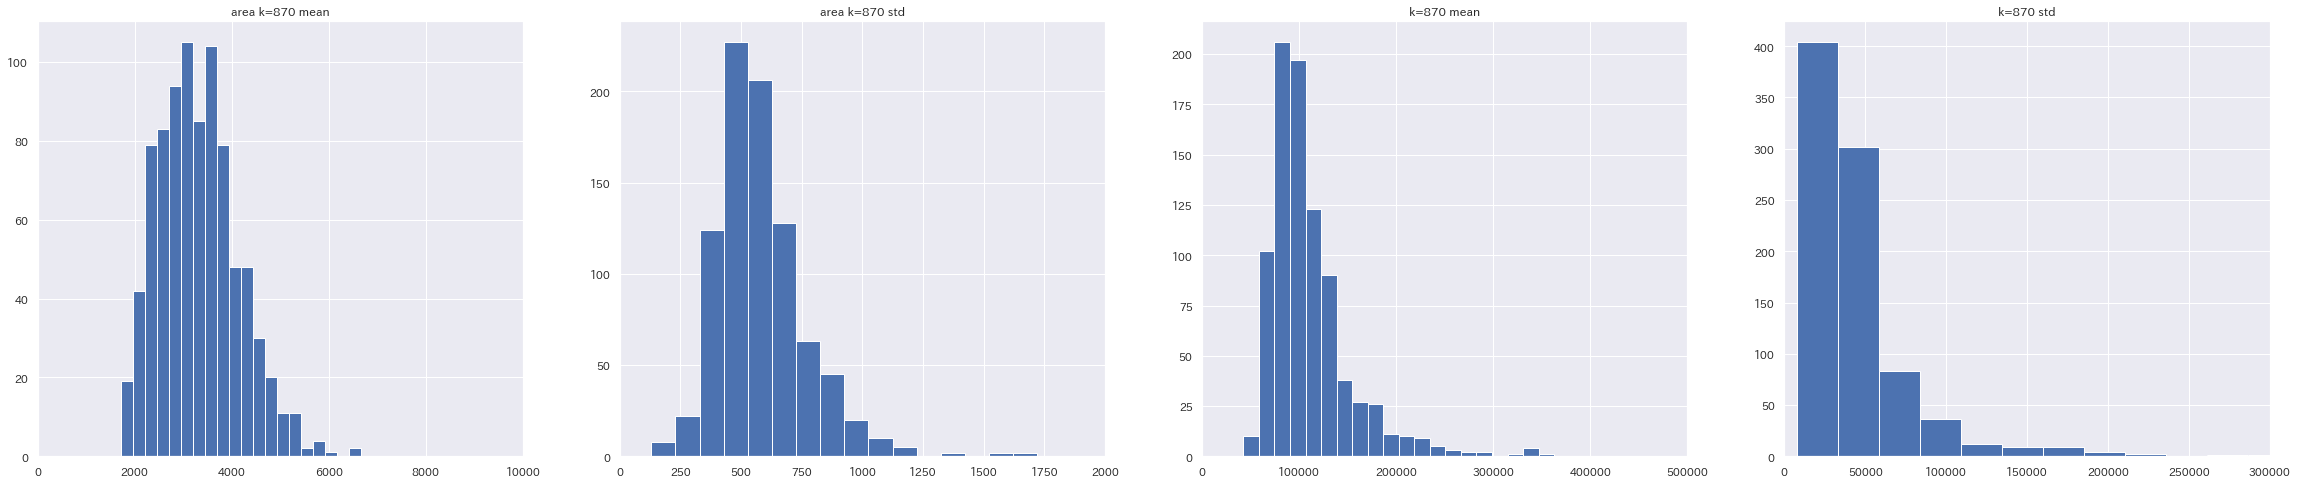

 83%|████████▎ | 83/100 [2:27:54<49:58, 176.40s/it]

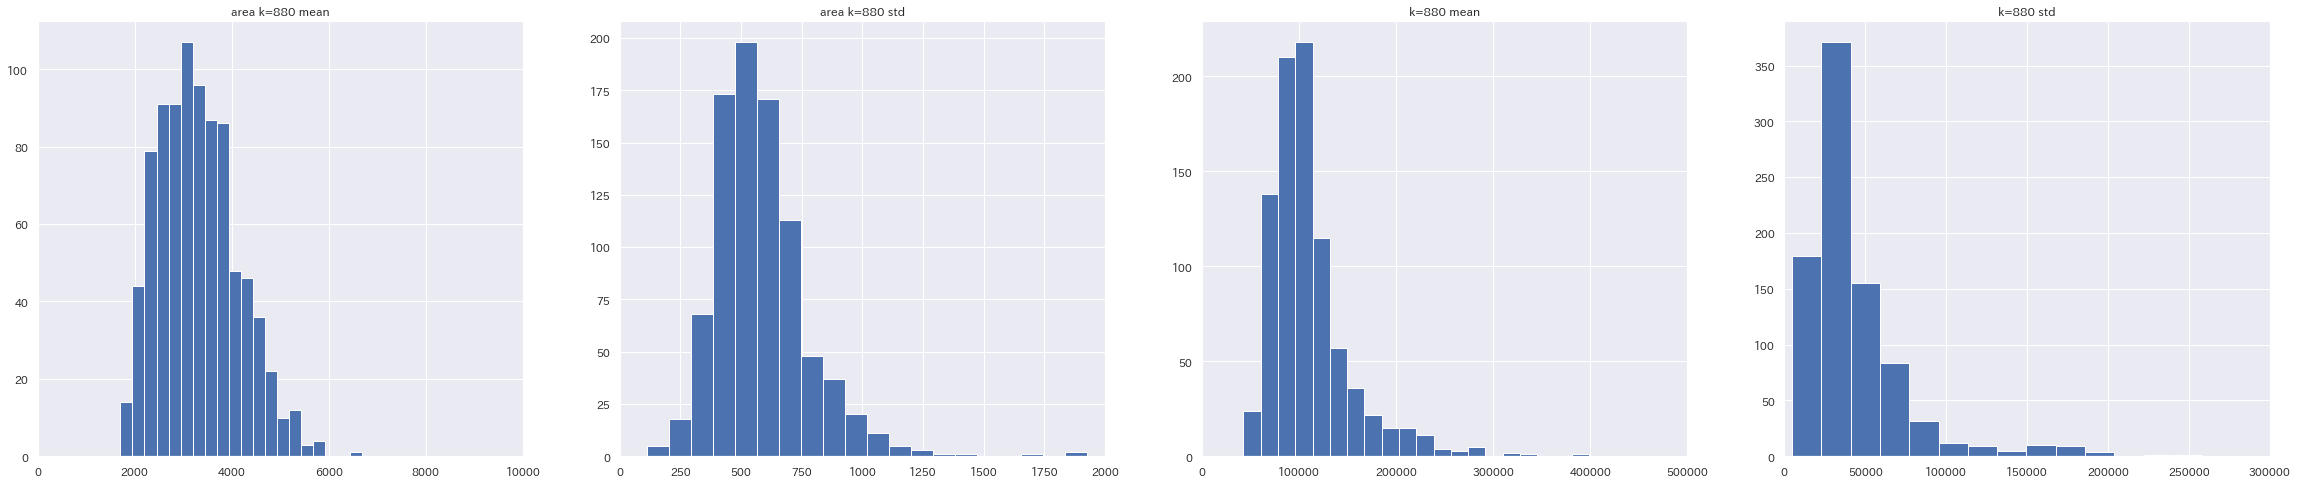

 84%|████████▍ | 84/100 [2:30:33<45:38, 171.19s/it]

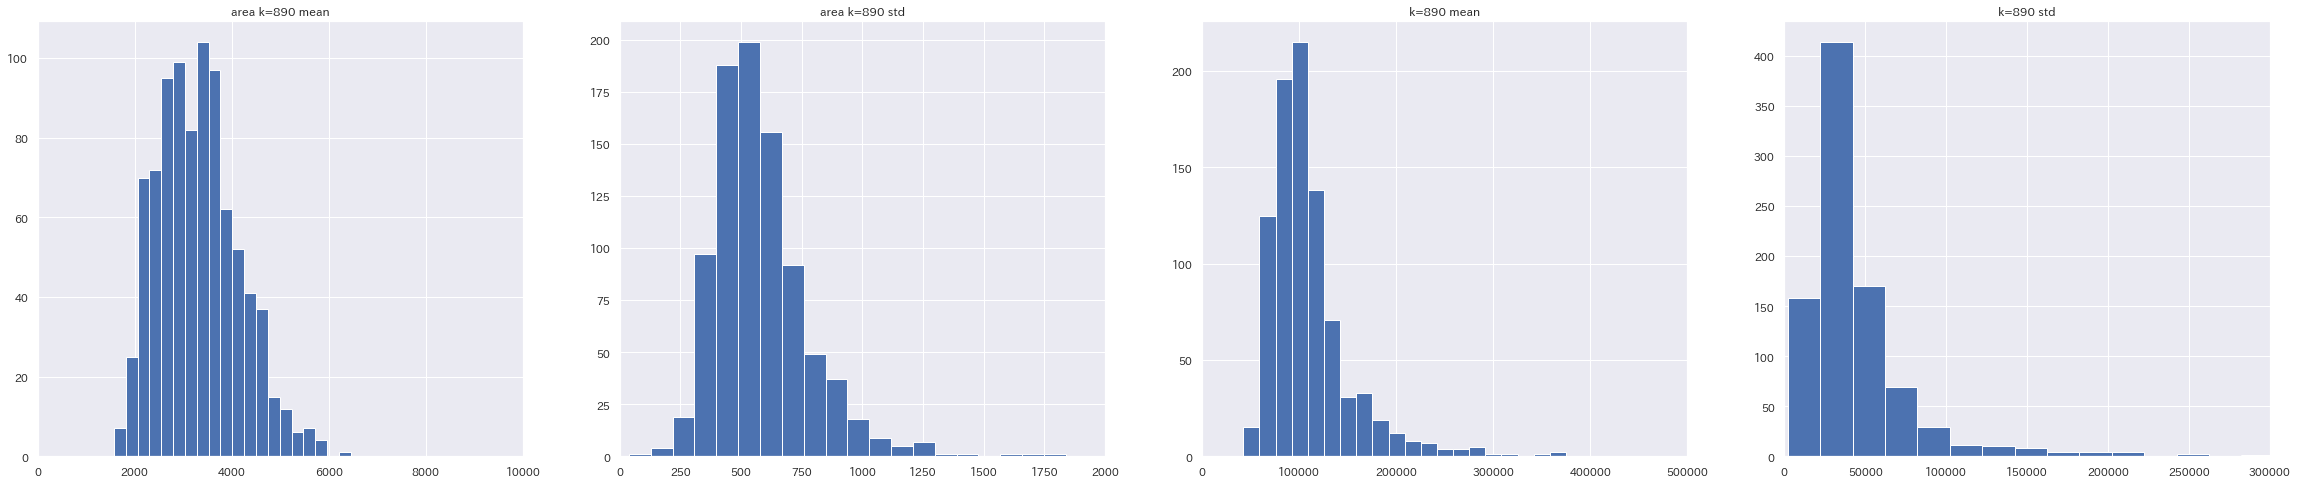

 85%|████████▌ | 85/100 [2:33:05<41:22, 165.53s/it]

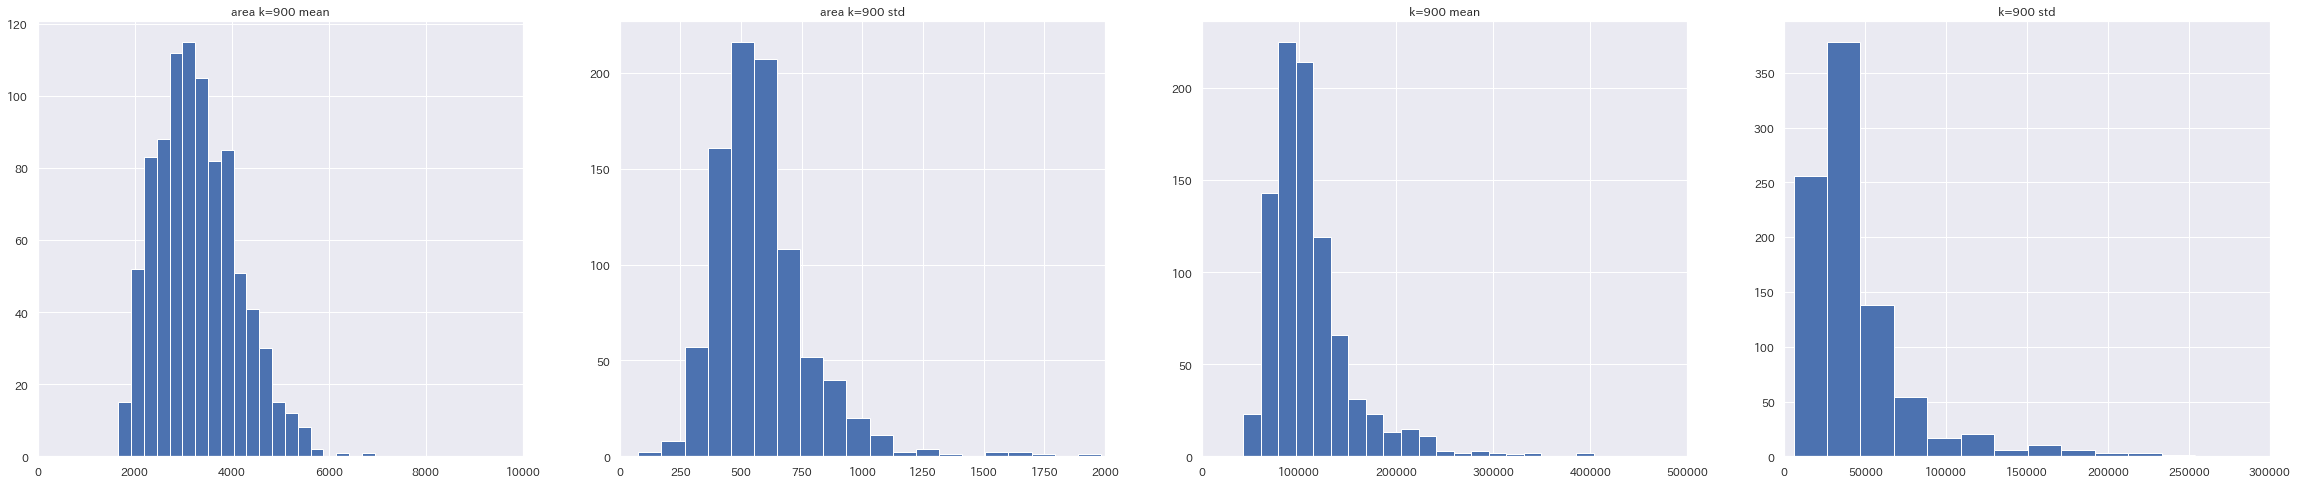

 86%|████████▌ | 86/100 [2:35:49<38:29, 164.94s/it]

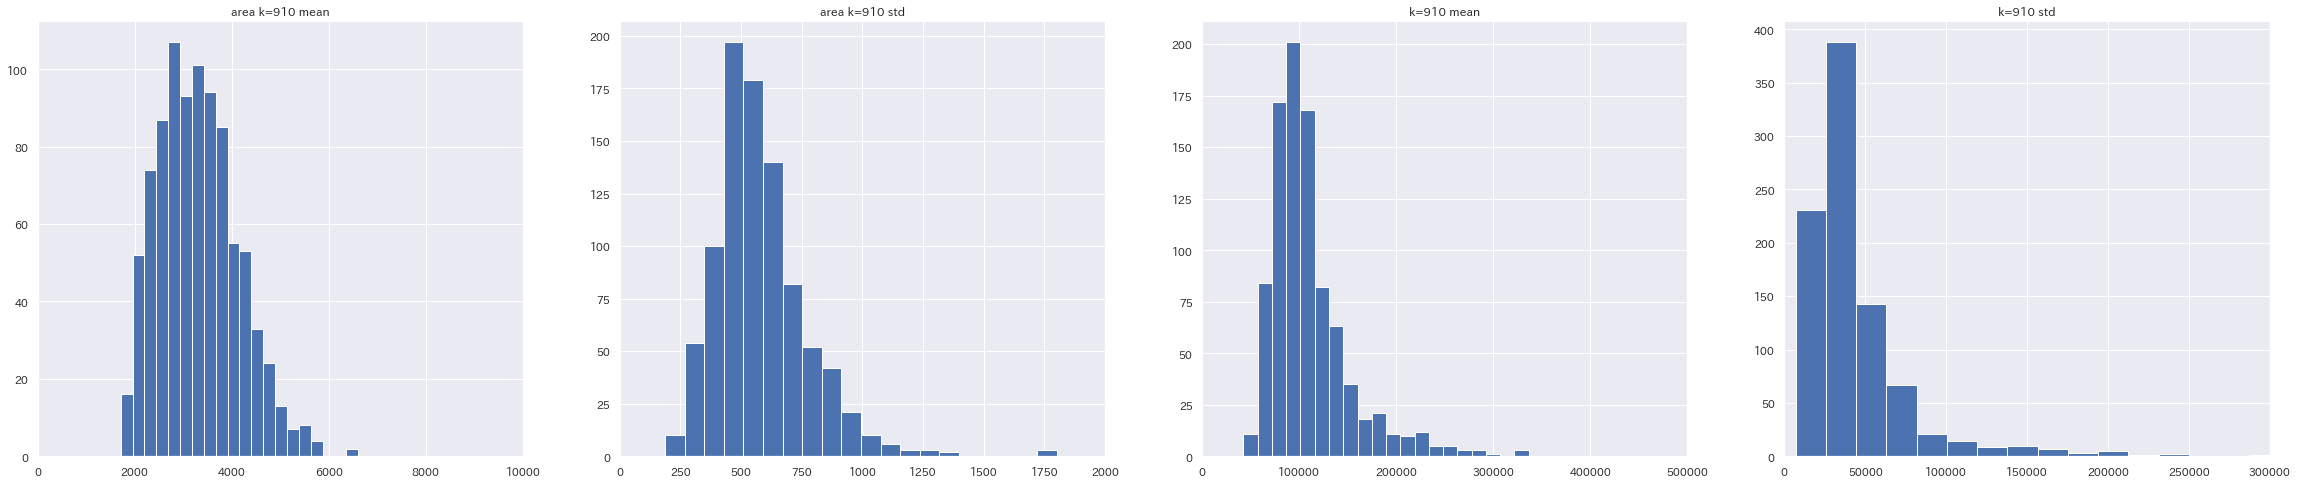

 87%|████████▋ | 87/100 [2:38:33<35:42, 164.84s/it]

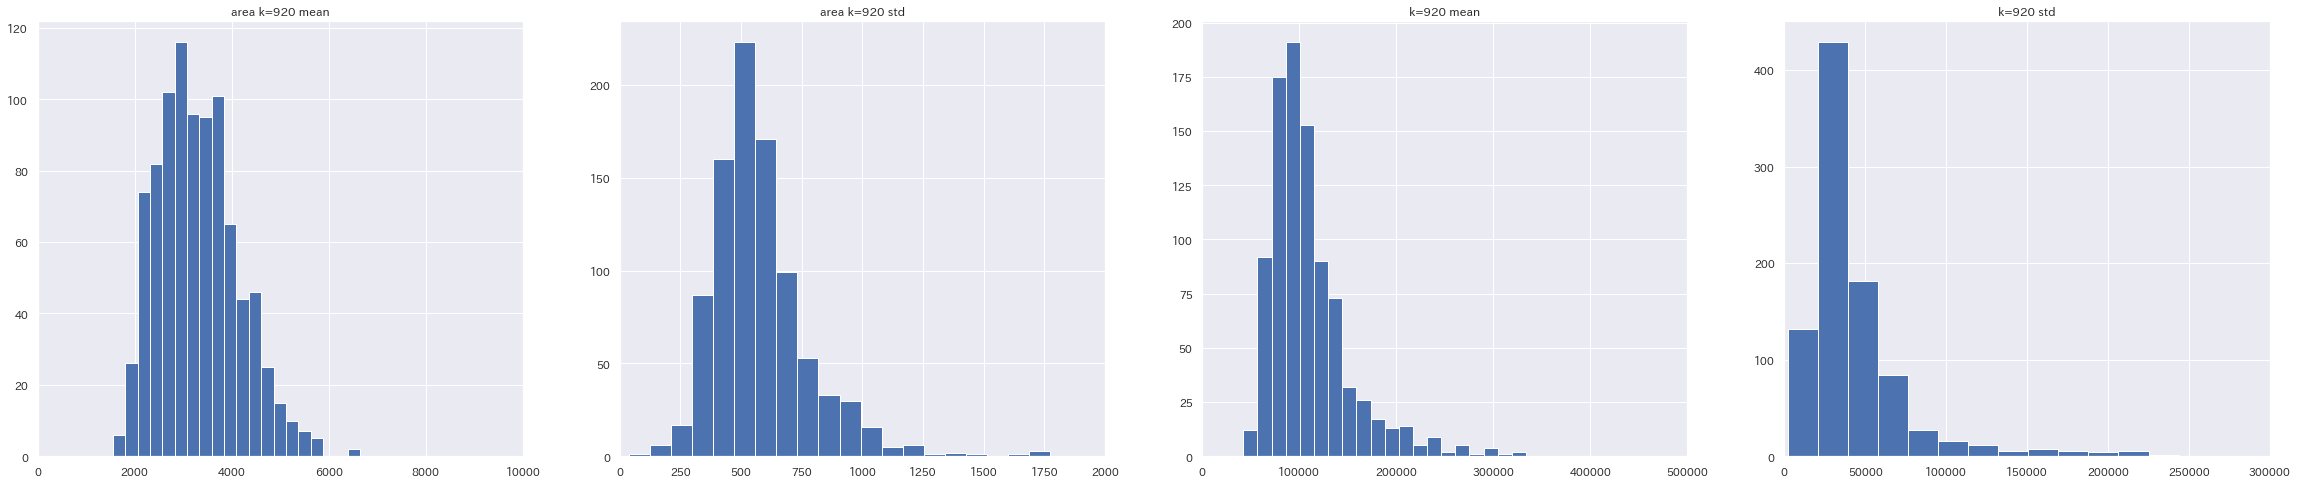

 88%|████████▊ | 88/100 [2:41:15<32:48, 164.05s/it]

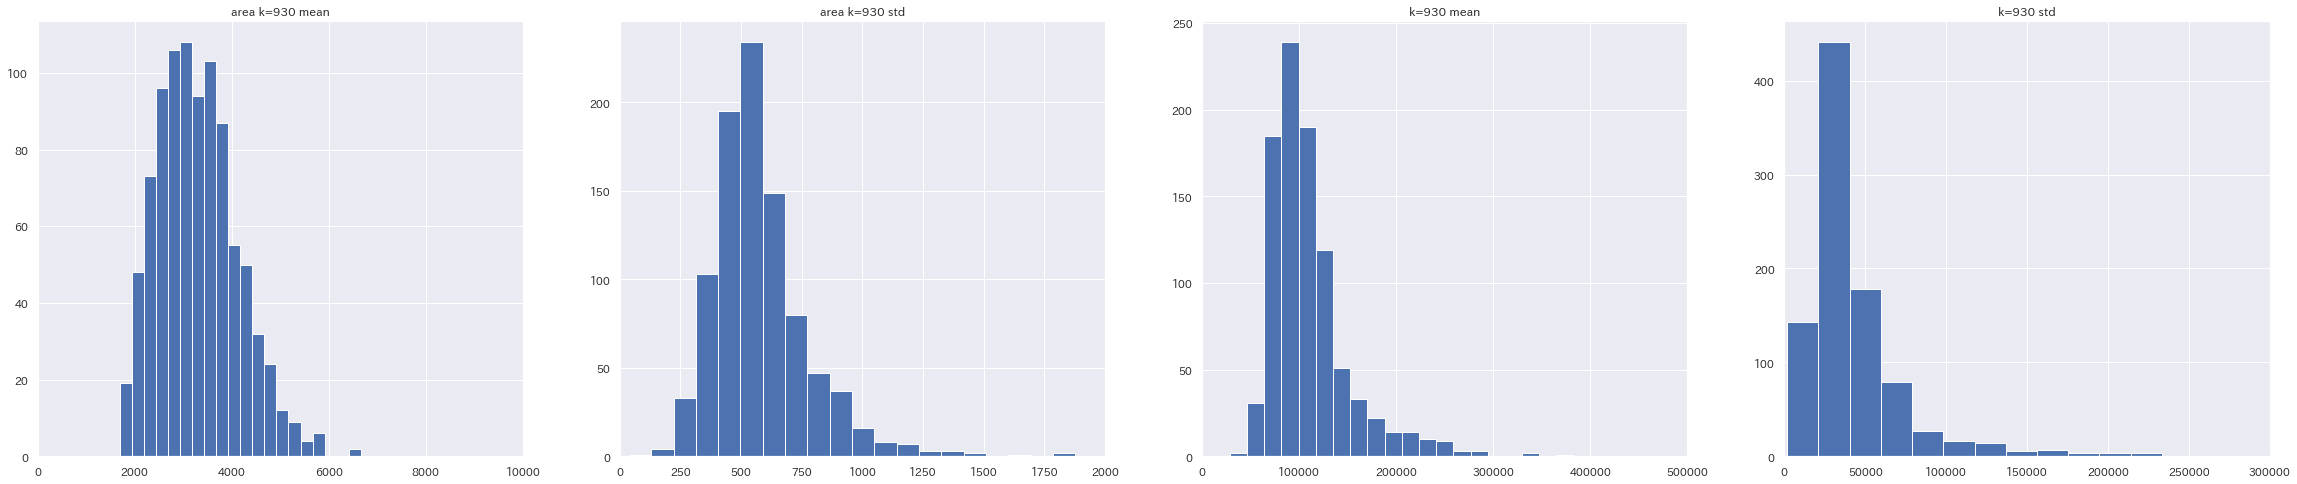

 89%|████████▉ | 89/100 [2:44:08<30:32, 166.59s/it]

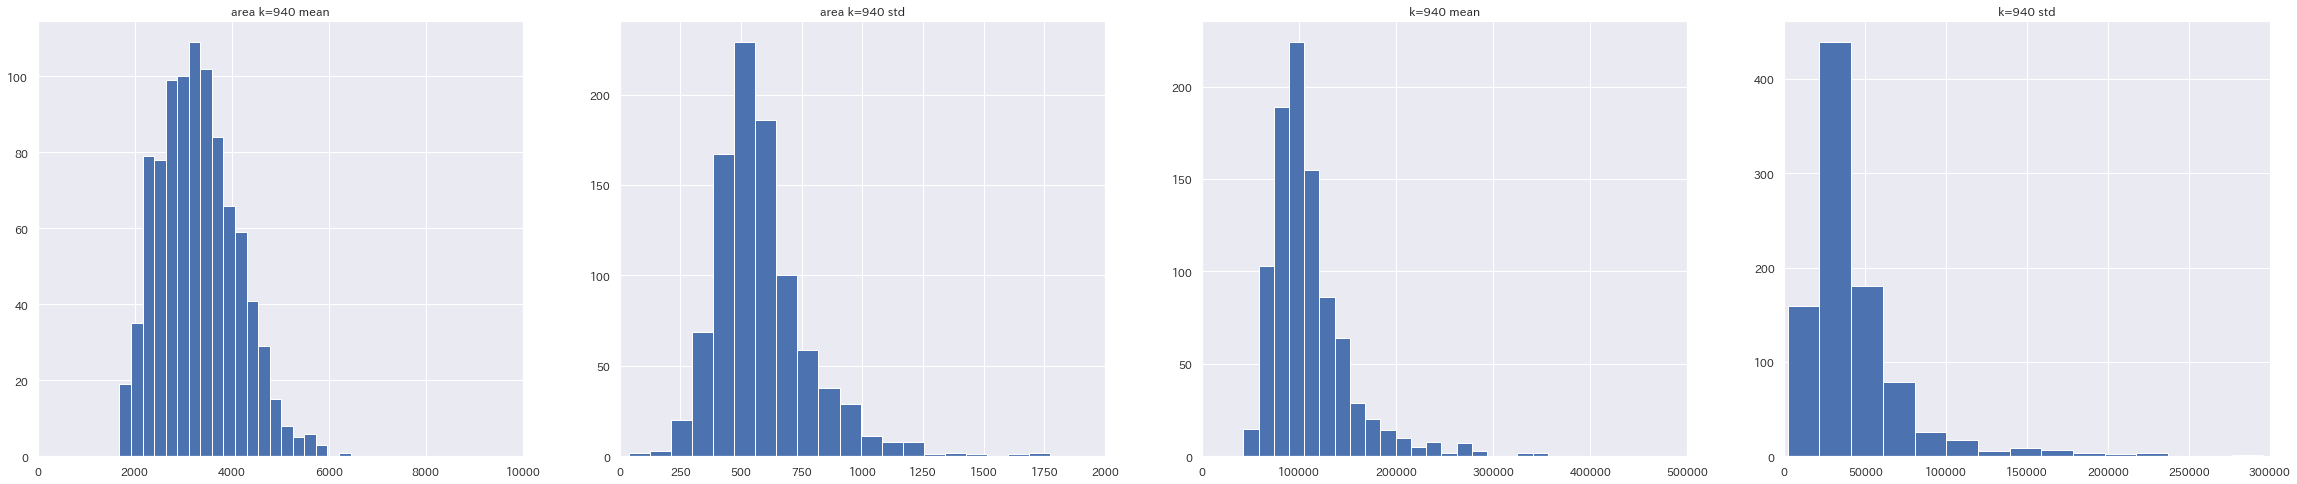

 90%|█████████ | 90/100 [2:46:49<27:28, 164.82s/it]

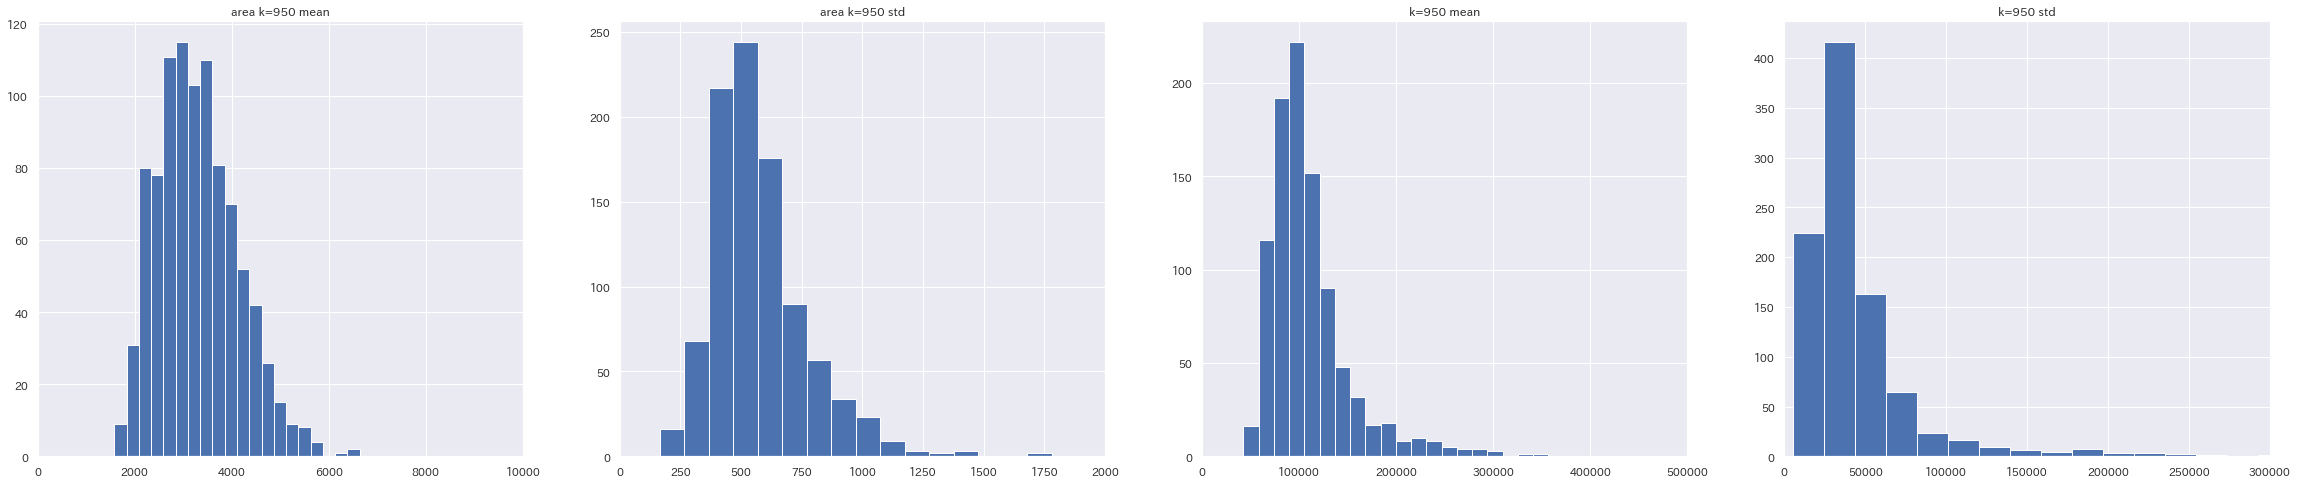

 91%|█████████ | 91/100 [2:49:40<25:00, 166.76s/it]

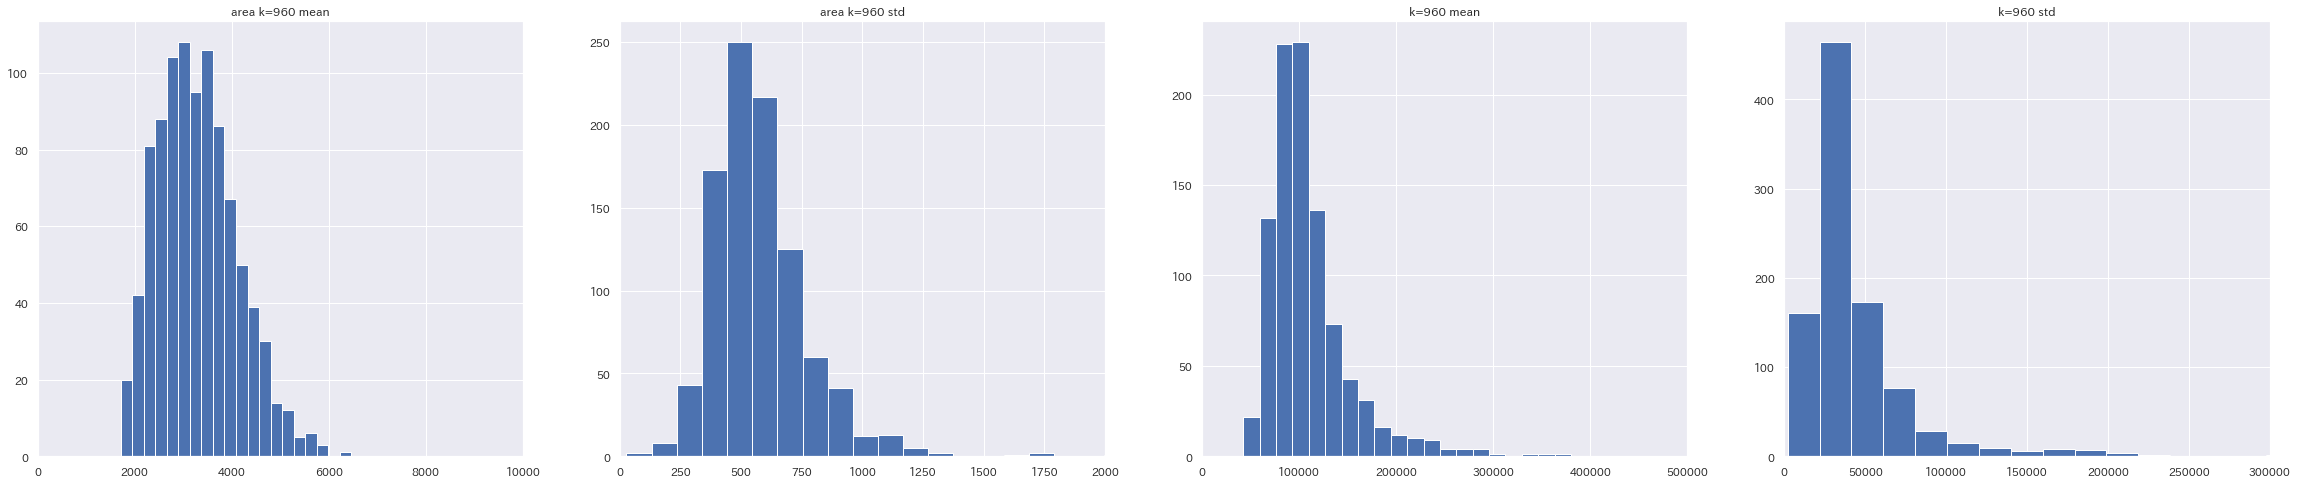

 92%|█████████▏| 92/100 [2:52:25<22:09, 166.17s/it]

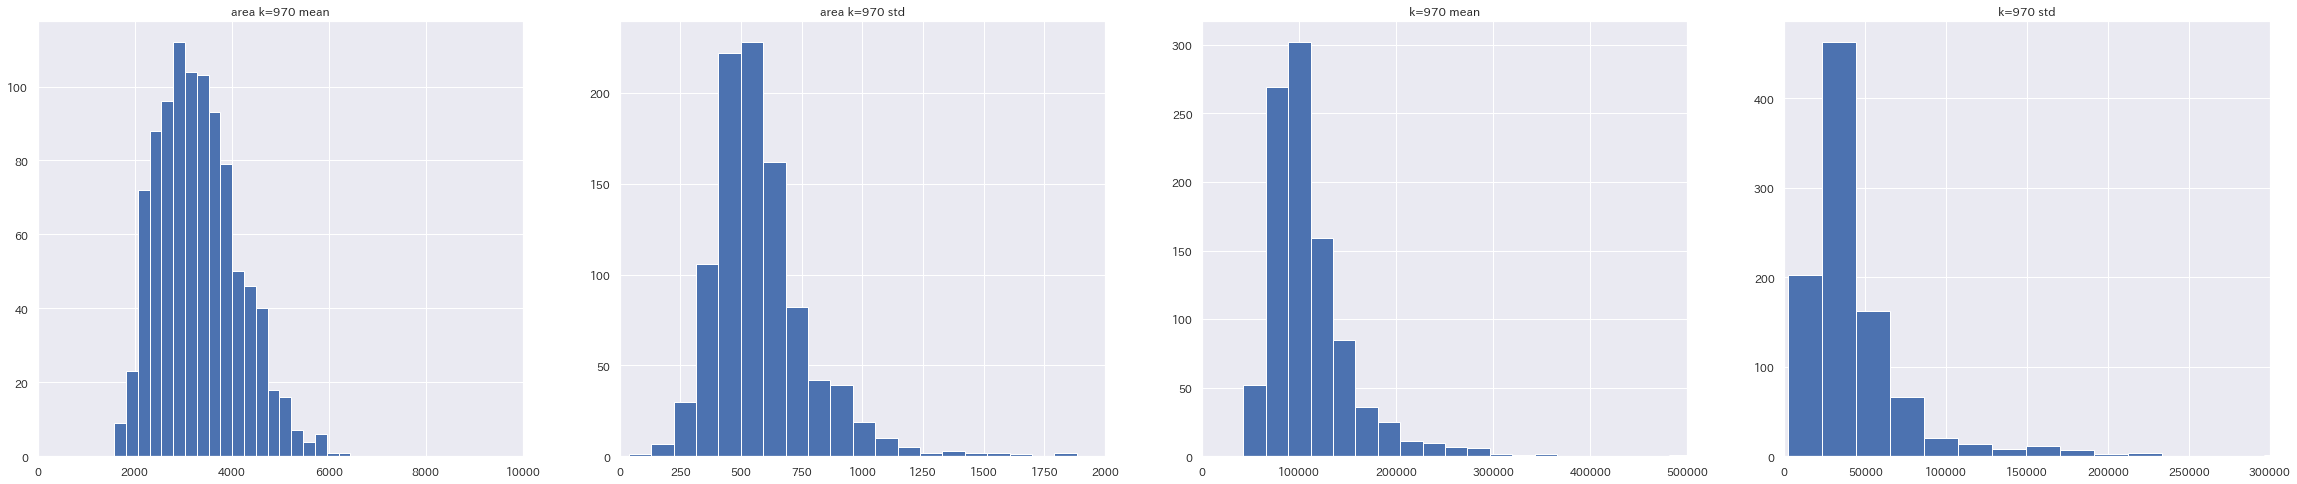

 93%|█████████▎| 93/100 [2:55:20<19:42, 168.87s/it]

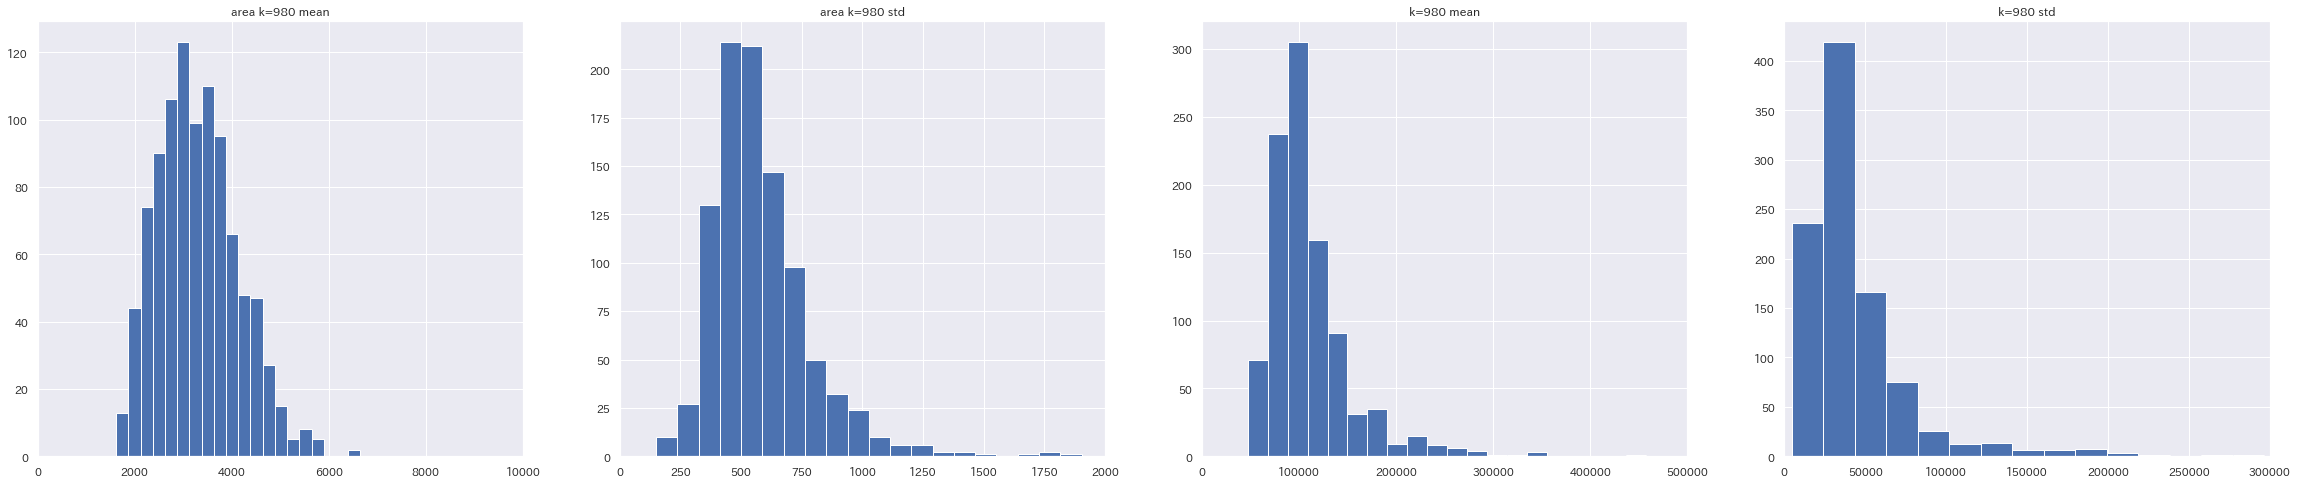

 94%|█████████▍| 94/100 [2:58:15<17:05, 170.90s/it]

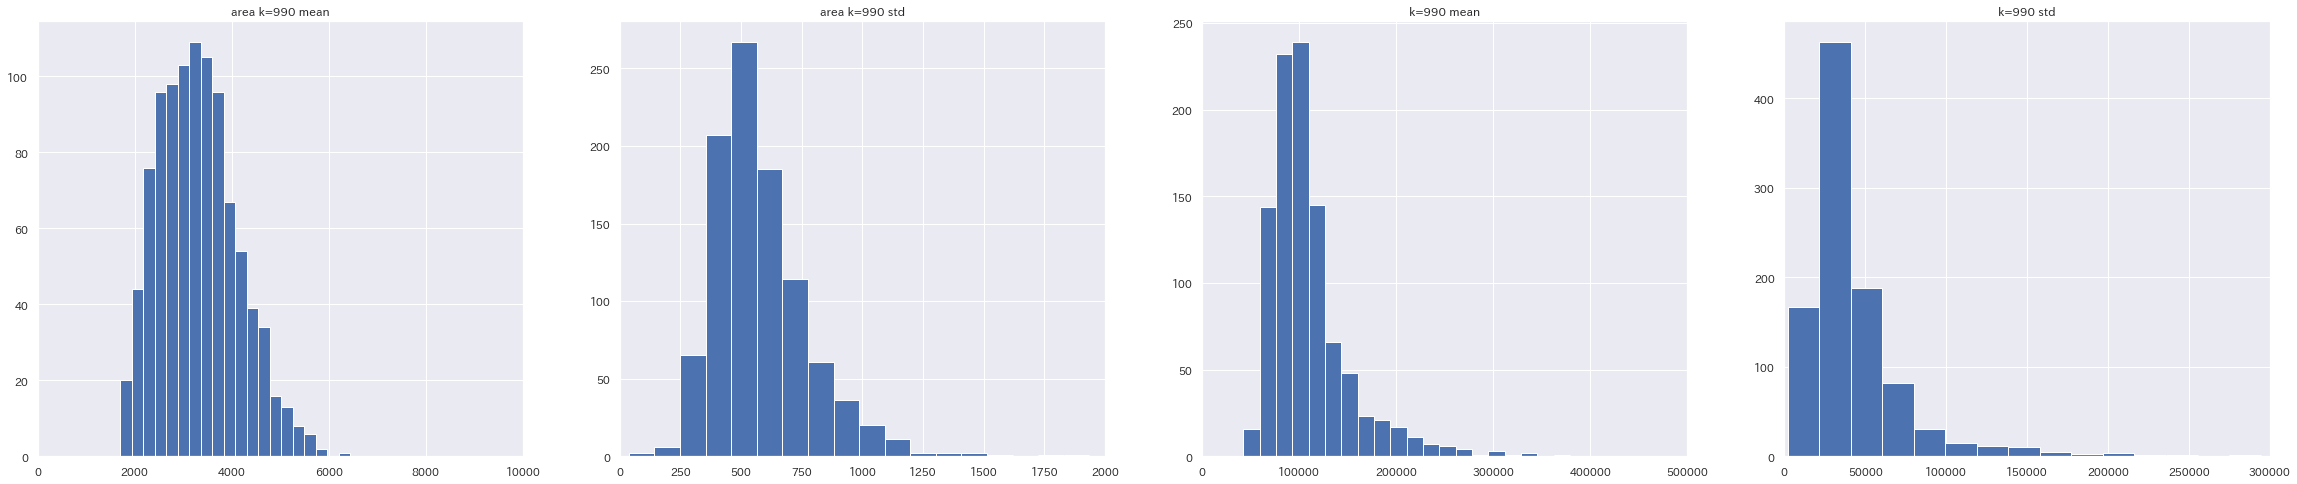

 95%|█████████▌| 95/100 [3:01:21<14:37, 175.41s/it]

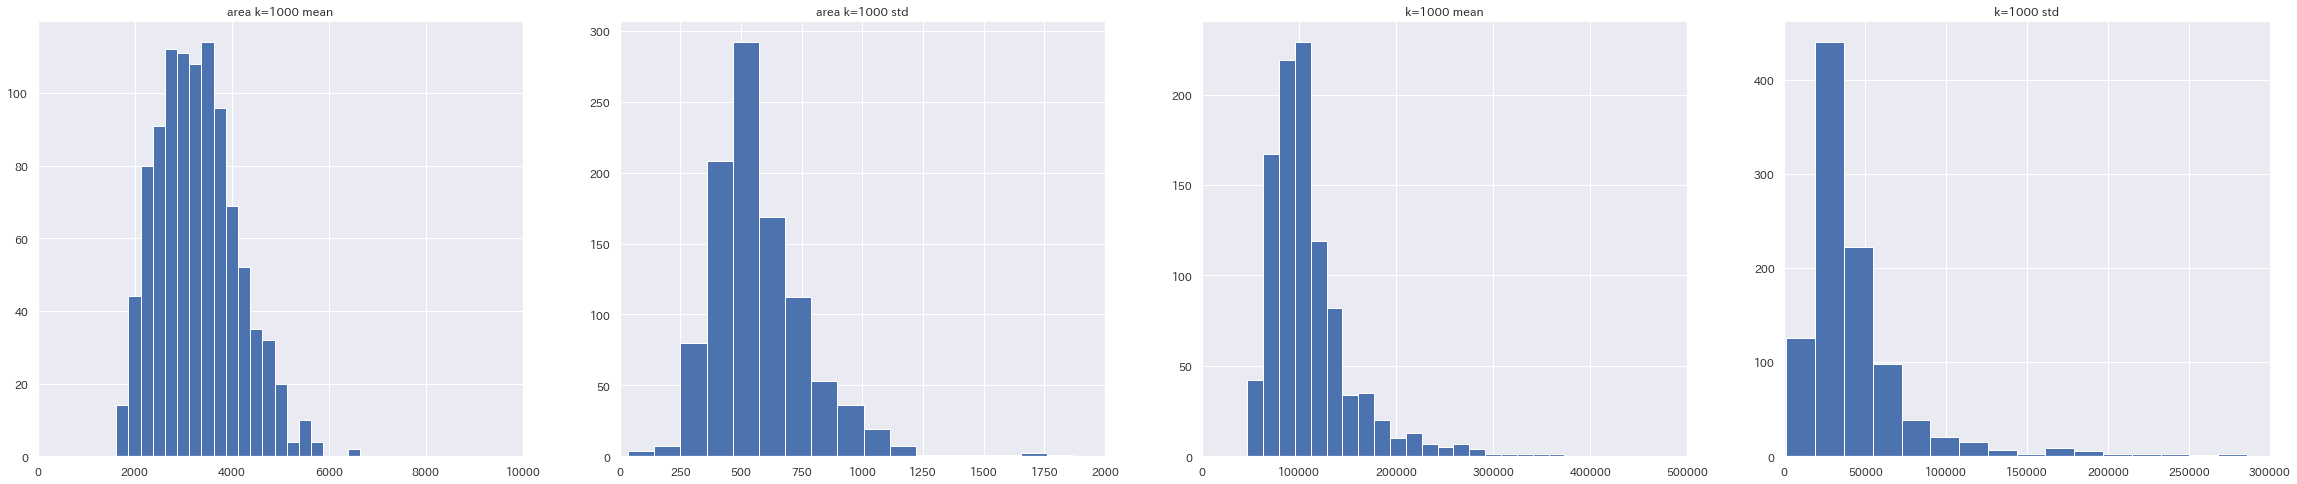

 96%|█████████▌| 96/100 [3:04:28<11:55, 178.77s/it]

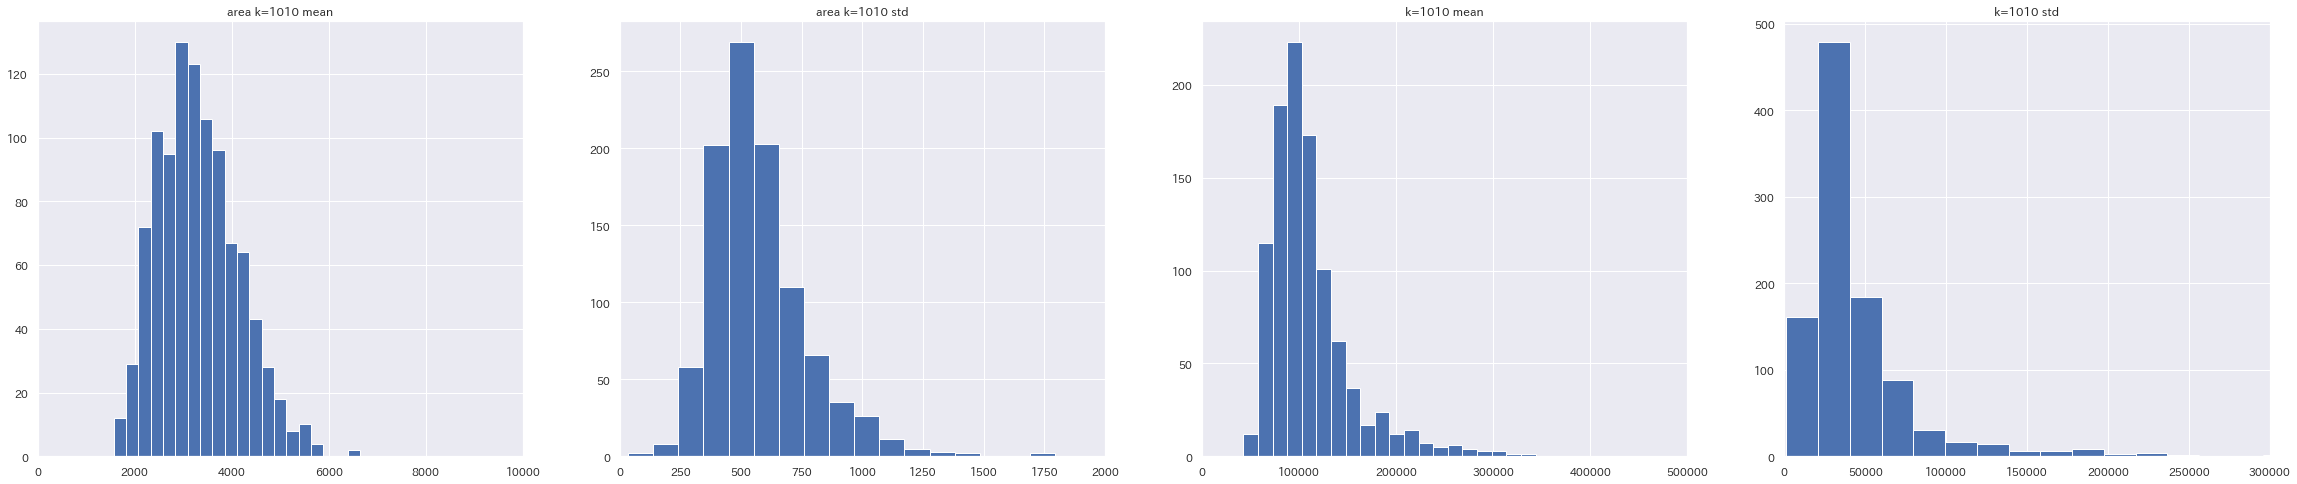

 97%|█████████▋| 97/100 [3:07:40<09:07, 182.65s/it]

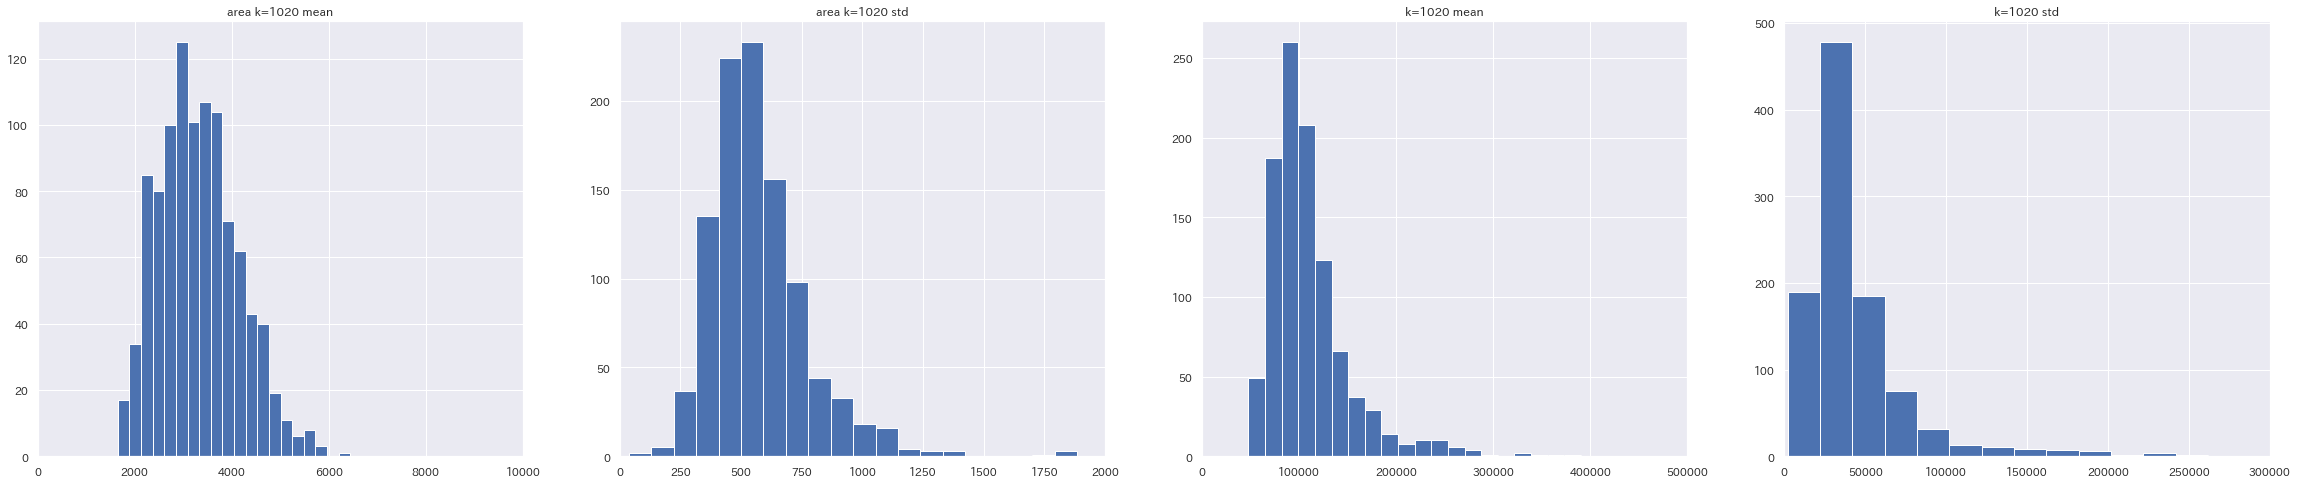

 98%|█████████▊| 98/100 [3:10:52<06:11, 185.63s/it]

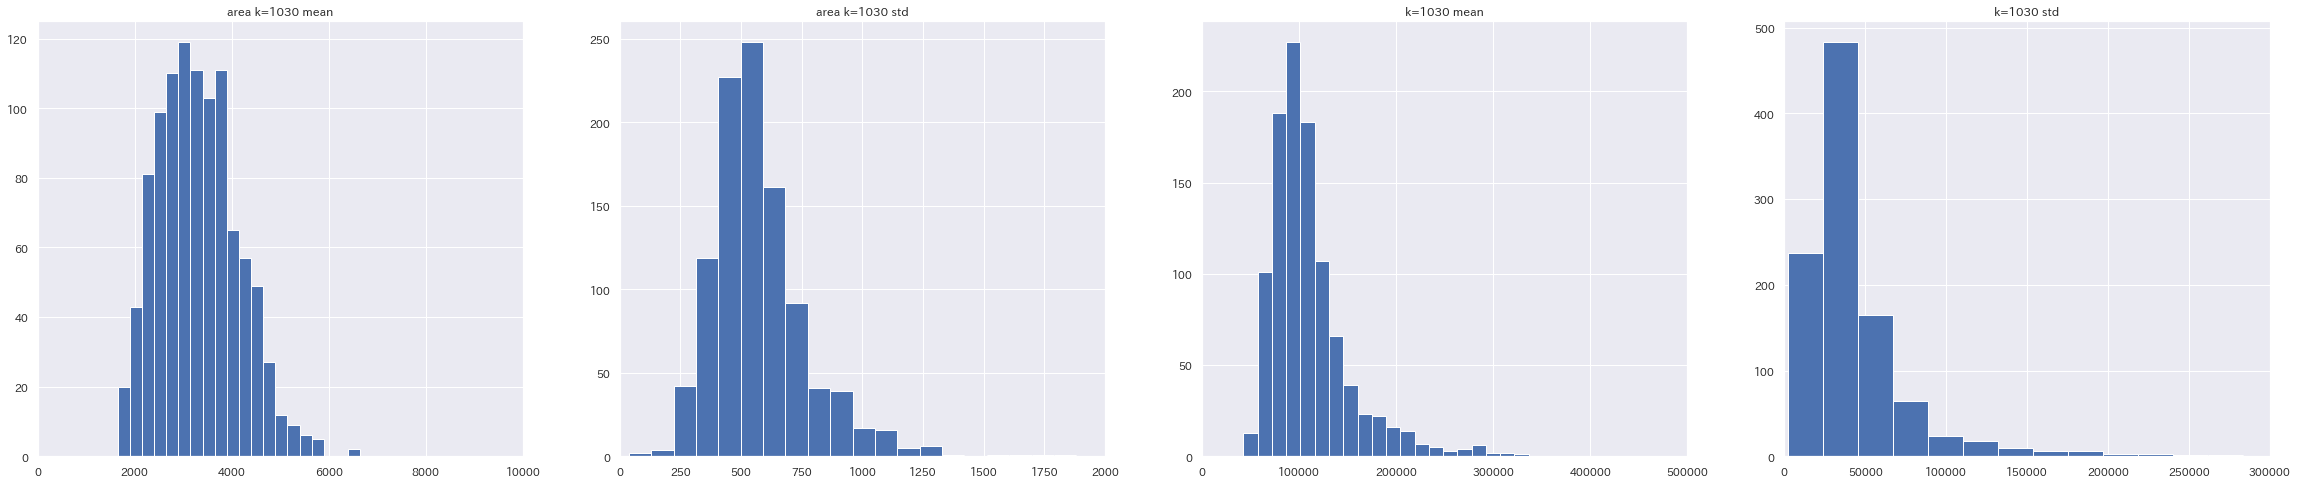

 99%|█████████▉| 99/100 [3:14:07<03:08, 188.43s/it]

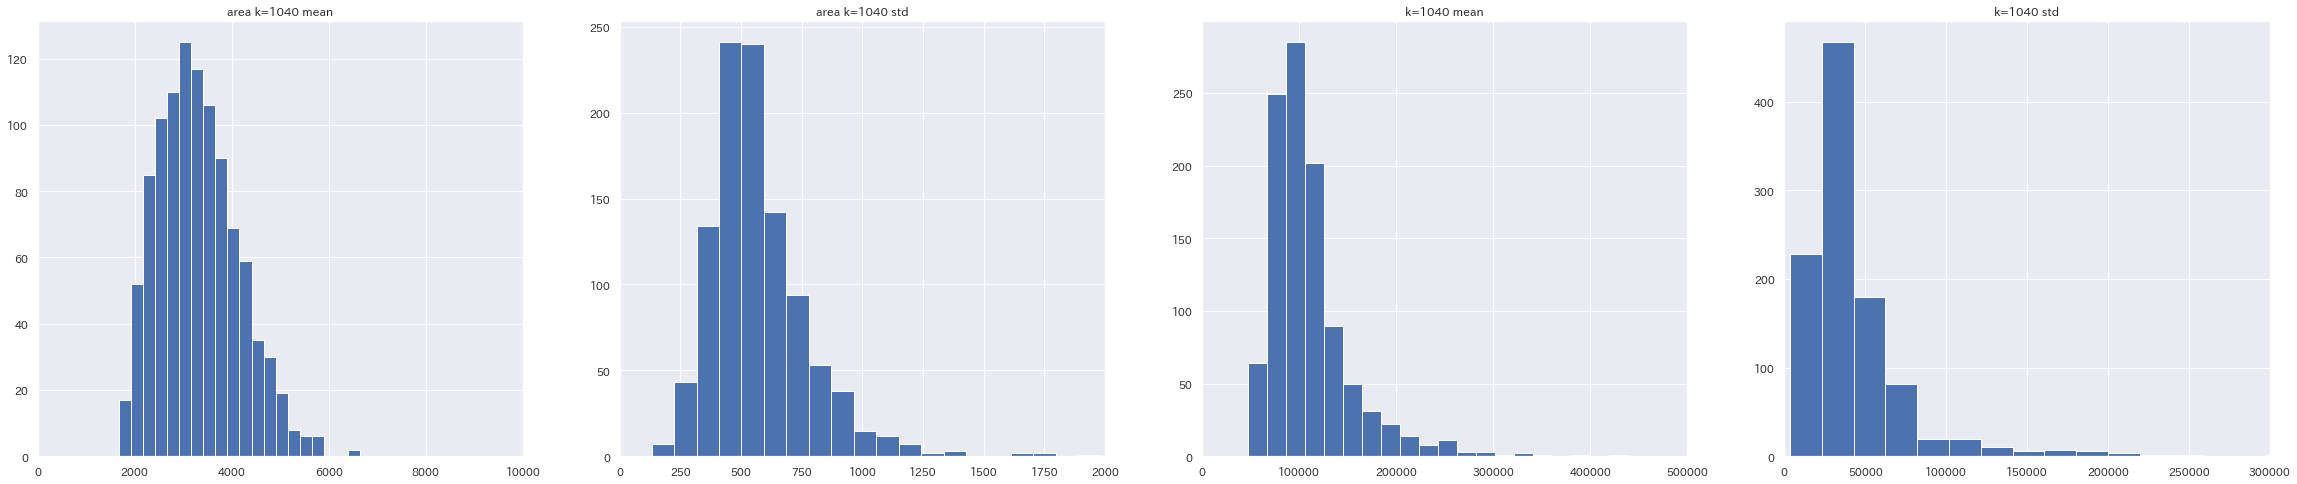

100%|██████████| 100/100 [3:17:22<00:00, 118.43s/it]


In [75]:
area_std_std = []
area_std_mean = []
area_mean_std = []
area_mean_mean = []
for i in tqdm(np.arange(50, 1049, 10)):
    res_train, res_test = get_Kmeans(X_train, X_test, n_clusters=i)
    gr = res_train[['km_type_with_age', '地価', '賃料']].groupby('km_type_with_age')
    plt.figure(figsize=(40,8))
    plt.subplot(1, 4, 1)
    gr['地価'].mean().hist(bins=20)
    plt.title('area k=%s mean'%i)
    plt.xlim(0, 10000)
    plt.subplot(1, 4, 2)
    gr['地価'].std().hist(bins=20)
    plt.title('area k=%s std'%i)
    plt.xlim(0, 2000)
    plt.subplot(1, 4, 3)
    gr['賃料'].mean().hist(bins=20)
    plt.title('k=%s mean'%i)
    plt.xlim(0, 500000)
    plt.subplot(1, 4, 4)
    gr['賃料'].std().hist(bins=20)
    plt.title('k=%s std'%i)
    plt.xlim(0, 300000)
    plt.show()
    area_std_std.append(gr['地価'].std().std())
    area_std_mean.append(gr['地価'].std().mean())
    area_mean_std.append(gr['地価'].mean().std())
    area_mean_mean.append(gr['地価'].mean().mean())

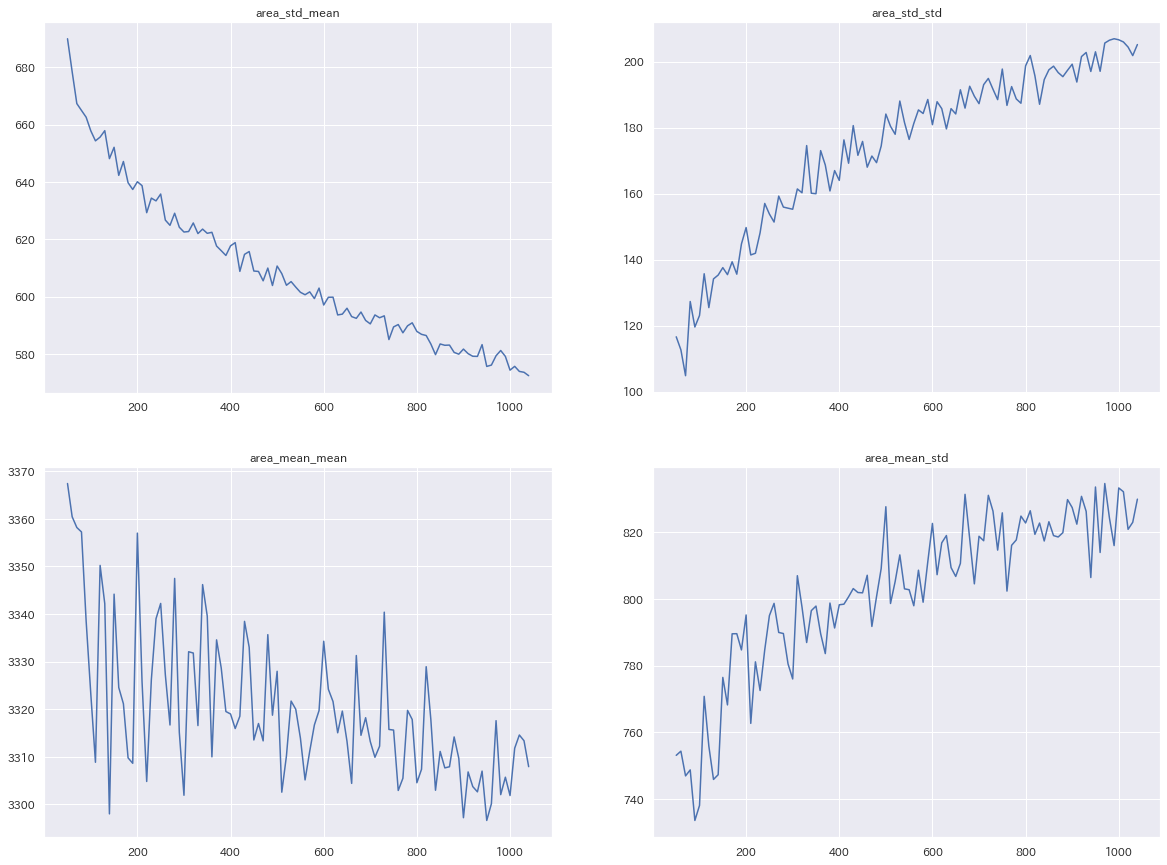

In [83]:
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
plt.plot(np.arange(50, 1049, 10), area_std_mean)
plt.title('area_std_mean')
plt.subplot(2,2,2)
plt.plot(np.arange(50, 1049, 10), area_std_std)
plt.title('area_std_std')
plt.subplot(2,2,3)
plt.plot(np.arange(50, 1049, 10), area_mean_mean)
plt.title('area_mean_mean')
plt.subplot(2,2,4)
plt.plot(np.arange(50, 1049, 10), area_mean_std)
plt.title('area_mean_std')
plt.show()

In [17]:
import plotly.express as px

px.set_mapbox_access_token('pk.eyJ1IjoiemVyZWJvbSIsImEiOiJjanpjY2JkZWUwMHMwM2RwNmQyanM2cHg4In0.VvajXw6UybbJhgp_-fHeYw')
fig = px.scatter_mapbox(mini_train, lat="loc_lat", lon="loc_lon",  color="km_type_with_age", size="賃料",text='id',
                  color_continuous_scale=px.colors.sequential.Viridis, size_max=30, zoom=10)
fig.show()

NameError: name 'mini_train' is not defined

In [254]:
def feature_encoding(train, test, category_col, target_col, func_list):
    '''target_encodingを重要な列（面積など）でやる。TEと違って、test_dfに含まれる値も集計して作る'''
    data=pd.concat([train,test],axis=0).reset_index()
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = data.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test

def target_encoding(train, test, category_col, target_col, func_list):
    '''target_encodingをやる。func_listに辞書型で列と処理する関数(meanとか)を渡す'''
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = train.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test

### feature_encoding target_encoding

In [485]:
def get_tokyo_station(df, load_mode=True):
    '''
    利用可能駅数と路線数を取得
    '''
    # 座標系変換
    from joblib import Parallel, delayed
    # 駅の位置を取得
    tokyo_station = pd.read_csv('../hutagami/data/tokyo_station.csv', index_col='Unnamed: 0')
    xy = pd.read_csv('../hutagami/data/location_xy.csv', index_col='index')
    xy.index = range(1, len(xy)+1)
    df['x'] = xy['x'].loc[df['id'].values].values
    df['y'] = xy['y'].loc[df['id'].values].values
        
    # ここからが処理
    # 利用可能駅数と路線数
    def in_distance(df_i, com_df=tokyo_station, distance=1000):
        y = df_i[0]
        x = df_i[1]
        # xyで範囲内に入っているもののみをカウント
        cond = np.sqrt((com_df['x'] - x)**2 + (com_df['y'] - y)**2)
        com_ = com_df[cond < distance]
        cond_ = cond[cond < distance]
        min_index = cond_[cond_==cond_.min()].index

        avail_station = len(com_['N02_005'].unique())
        avail_root = len(com_['N02_003'].unique())
        min_distance = cond_.min()
        nearest_station_size = (list(com_df.loc[min_index, '駅のサイズ(路線数)'])+[0])[0]
        max_station_size = com_['駅のサイズ(路線数)'].max()
        nearest_station_people = (list(com_df.loc[min_index, '乗降人数'])+[0])[0]
        max_station_people = com_['乗降人数'].max()

        return avail_station, avail_root, min_distance, nearest_station_size, max_station_size, nearest_station_people, max_station_people

    df_i = df[['y', 'x']].apply(lambda x: (x[0], x[1]), axis=1)
    res = Parallel(n_jobs=6)([delayed(in_distance)(i) for i in df_i])
    
    df['利用可能駅数']= np.array(res)[:, 0]
    df['利用可能路線数']= np.array(res)[:, 1]
    df['最短駅m']= np.array(res)[:, 2]
    df['最短駅路線数']= np.array(res)[:, 3]
    df['利用可能駅最大路線数']= np.array(res)[:, 4]
    df['最短駅乗降人数']= np.array(res)[:, 5]
    df['利用可能駅最大乗降人数']= np.array(res)[:, 6]
    
    return df

In [294]:
def get_landprice(df, k=3):
    '''
    地価のk近傍点を取得
    '''
    import geopandas as gpd
    from sklearn.neighbors import KNeighborsRegressor
    
    # 地価データを取得して、緯度経度と地価データのみを抽出
    fnames = ["../hutagami/data/L01-18_%s.geojson"%i for i in ['08', '11', '12', '13', '14']]
    geo_df = pd.DataFrame(columns=['地価(単位面積)', 'loc_lat', 'loc_lon'])
    for fname in fnames:
        geo = gpd.read_file(fname)
        #sample = pd.DataFrame((geo['L01_006'].astype(int) * geo['L01_024'].astype(int)), columns=['地価'])
        sample = pd.DataFrame(geo['L01_006'].astype(int).values, columns=['地価(単位面積)'])
        sample['geometry'] = geo['geometry']
        sample['lonlat'] = sample['geometry'].astype(str).str.replace('POINT ', '').str.replace('(', '').str.replace(')', '').str.split(' ')
        sample['loc_lat'] = sample['lonlat'].map(lambda x: float(x[1]))
        sample['loc_lon'] = sample['lonlat'].map(lambda x: float(x[0]))
        sample = sample[['地価(単位面積)', 'loc_lat', 'loc_lon']]
        geo_df = pd.concat([geo_df, sample], axis=0).reset_index(drop=True)
        
    fnames = ["../hutagami/data/L02-18_%s.geojson"%i for i in ['08', '11', '12', '13', '14']]
    #geo_df = pd.DataFrame(columns=['地価(単位面積)', 'loc_lat', 'loc_lon'])
    for fname in fnames:
        geo = gpd.read_file(fname)
        #sample = pd.DataFrame((geo['L01_006'].astype(int) * geo['L01_024'].astype(int)), columns=['地価'])
        sample = pd.DataFrame(geo['L02_006'].astype(int).values, columns=['地価(単位面積)'])
        sample['geometry'] = geo['geometry']
        sample['lonlat'] = sample['geometry'].astype(str).str.replace('POINT ', '').str.replace('(', '').str.replace(')', '').str.split(' ')
        sample['loc_lat'] = sample['lonlat'].map(lambda x: float(x[1]))
        sample['loc_lon'] = sample['lonlat'].map(lambda x: float(x[0]))
        sample = sample[['地価(単位面積)', 'loc_lat', 'loc_lon']]
        geo_df = pd.concat([geo_df, sample], axis=0).reset_index(drop=True)
    
    print(len(geo_df))
         
    n_neighbors = k # default=5
    # 距離によって重み付けするか
    #weights = 'uniform' # しない
    weights = 'distance' # する
    
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    knn.fit(geo_df.drop(['地価(単位面積)'], axis=1), geo_df['地価(単位面積)'])
    
    res = knn.kneighbors(df[['loc_lat', 'loc_lon']], n_neighbors, return_distance=False)
    res = geo_df['地価(単位面積)'].loc[res.flatten()].values.flatten().reshape(res.shape).astype(int)
    res = pd.DataFrame(res, columns=['地価(単位面積)_neighbor_%s'%(i+1) for i in range(n_neighbors)], index=df.index).astype(float)
    for i in range(n_neighbors):
        res['地価_neighbor_%s'%(i+1)] = (res['地価(単位面積)_neighbor_%s'%(i+1)] * df['面積']).astype(float)
        
    res['地価_neighbor_mean'] = res[['地価_neighbor_%s'%(i+1) for i in range(n_neighbors)]].mean(axis=1).astype(float)
    res['地価_neighbor_std'] = res[['地価_neighbor_%s'%(i+1) for i in range(n_neighbors)]].std(axis=1).astype(float)
    res['地価(単位面積)_neighbor_mean'] = res[['地価(単位面積)_neighbor_%s'%(i+1) for i in range(n_neighbors)]].mean(axis=1).astype(float)
    res['地価(単位面積)_neighbor_std'] = res[['地価(単位面積)_neighbor_%s'%(i+1) for i in range(n_neighbors)]].std(axis=1).astype(float)
    
    df = pd.concat([df, res], axis=1)
    
    return df

In [486]:
train=pd.read_csv('../higuchi/input/prep_train1105.csv')
test=pd.read_csv('../higuchi/input/prep_test1105.csv')
#train=pd.read_csv('../higuchi/input/train.csv')
#test=pd.read_csv('../higuchi/input/test.csv')
y_train = train['賃料']

In [485]:
def get_tokyo_station(df, load_mode=True):
    '''
    利用可能駅数と路線数を取得
    '''
    # 座標系変換
    from joblib import Parallel, delayed
    # 駅の位置を取得
    tokyo_station = pd.read_csv('../hutagami/data/tokyo_station.csv', index_col='Unnamed: 0')
    xy = pd.read_csv('../hutagami/data/location_xy.csv', index_col='index')
    xy.index = range(1, len(xy)+1)
    df['x'] = xy['x'].loc[df['id'].values].values
    df['y'] = xy['y'].loc[df['id'].values].values
        
    # ここからが処理
    # 利用可能駅数と路線数
    def in_distance(df_i, com_df=tokyo_station, distance=1000):
        y = df_i[0]
        x = df_i[1]
        # xyで範囲内に入っているもののみをカウント
        cond = np.sqrt((com_df['x'] - x)**2 + (com_df['y'] - y)**2)
        com_ = com_df[cond < distance]
        cond_ = cond[cond < distance]
        min_index = cond_[cond_==cond_.min()].index

        avail_station = len(com_['N02_005'].unique())
        avail_root = len(com_['N02_003'].unique())
        min_distance = cond_.min()
        nearest_station_size = (list(com_df.loc[min_index, '駅のサイズ(路線数)'])+[0])[0]
        max_station_size = com_['駅のサイズ(路線数)'].max()
        nearest_station_people = (list(com_df.loc[min_index, '乗降人数'])+[0])[0]
        max_station_people = com_['乗降人数'].max()

        return avail_station, avail_root, min_distance, nearest_station_size, max_station_size, nearest_station_people, max_station_people

    df_i = df[['y', 'x']].apply(lambda x: (x[0], x[1]), axis=1)
    res = Parallel(n_jobs=6)([delayed(in_distance)(i) for i in df_i])
    
    df['利用可能駅数']= np.array(res)[:, 0]
    df['利用可能路線数']= np.array(res)[:, 1]
    df['最短駅m']= np.array(res)[:, 2]
    df['最短駅路線数']= np.array(res)[:, 3]
    df['利用可能駅最大路線数']= np.array(res)[:, 4]
    df['最短駅乗降人数']= np.array(res)[:, 5]
    df['利用可能駅最大乗降人数']= np.array(res)[:, 6]
    
    return df

In [294]:
def get_landprice(df, k=3):
    '''
    地価のk近傍点を取得
    '''
    import geopandas as gpd
    from sklearn.neighbors import KNeighborsRegressor
    
    # 地価データを取得して、緯度経度と地価データのみを抽出
    fnames = ["../hutagami/data/L01-18_%s.geojson"%i for i in ['08', '11', '12', '13', '14']]
    geo_df = pd.DataFrame(columns=['地価(単位面積)', 'loc_lat', 'loc_lon'])
    for fname in fnames:
        geo = gpd.read_file(fname)
        #sample = pd.DataFrame((geo['L01_006'].astype(int) * geo['L01_024'].astype(int)), columns=['地価'])
        sample = pd.DataFrame(geo['L01_006'].astype(int).values, columns=['地価(単位面積)'])
        sample['geometry'] = geo['geometry']
        sample['lonlat'] = sample['geometry'].astype(str).str.replace('POINT ', '').str.replace('(', '').str.replace(')', '').str.split(' ')
        sample['loc_lat'] = sample['lonlat'].map(lambda x: float(x[1]))
        sample['loc_lon'] = sample['lonlat'].map(lambda x: float(x[0]))
        sample = sample[['地価(単位面積)', 'loc_lat', 'loc_lon']]
        geo_df = pd.concat([geo_df, sample], axis=0).reset_index(drop=True)
        
    fnames = ["../hutagami/data/L02-18_%s.geojson"%i for i in ['08', '11', '12', '13', '14']]
    #geo_df = pd.DataFrame(columns=['地価(単位面積)', 'loc_lat', 'loc_lon'])
    for fname in fnames:
        geo = gpd.read_file(fname)
        #sample = pd.DataFrame((geo['L01_006'].astype(int) * geo['L01_024'].astype(int)), columns=['地価'])
        sample = pd.DataFrame(geo['L02_006'].astype(int).values, columns=['地価(単位面積)'])
        sample['geometry'] = geo['geometry']
        sample['lonlat'] = sample['geometry'].astype(str).str.replace('POINT ', '').str.replace('(', '').str.replace(')', '').str.split(' ')
        sample['loc_lat'] = sample['lonlat'].map(lambda x: float(x[1]))
        sample['loc_lon'] = sample['lonlat'].map(lambda x: float(x[0]))
        sample = sample[['地価(単位面積)', 'loc_lat', 'loc_lon']]
        geo_df = pd.concat([geo_df, sample], axis=0).reset_index(drop=True)
    
    print(len(geo_df))
         
    n_neighbors = k # default=5
    # 距離によって重み付けするか
    #weights = 'uniform' # しない
    weights = 'distance' # する
    
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    knn.fit(geo_df.drop(['地価(単位面積)'], axis=1), geo_df['地価(単位面積)'])
    
    res = knn.kneighbors(df[['loc_lat', 'loc_lon']], n_neighbors, return_distance=False)
    res = geo_df['地価(単位面積)'].loc[res.flatten()].values.flatten().reshape(res.shape).astype(int)
    res = pd.DataFrame(res, columns=['地価(単位面積)_neighbor_%s'%(i+1) for i in range(n_neighbors)], index=df.index).astype(float)
    for i in range(n_neighbors):
        res['地価_neighbor_%s'%(i+1)] = (res['地価(単位面積)_neighbor_%s'%(i+1)] * df['面積']).astype(float)
        
    res['地価_neighbor_mean'] = res[['地価_neighbor_%s'%(i+1) for i in range(n_neighbors)]].mean(axis=1).astype(float)
    res['地価_neighbor_std'] = res[['地価_neighbor_%s'%(i+1) for i in range(n_neighbors)]].std(axis=1).astype(float)
    res['地価(単位面積)_neighbor_mean'] = res[['地価(単位面積)_neighbor_%s'%(i+1) for i in range(n_neighbors)]].mean(axis=1).astype(float)
    res['地価(単位面積)_neighbor_std'] = res[['地価(単位面積)_neighbor_%s'%(i+1) for i in range(n_neighbors)]].std(axis=1).astype(float)
    
    df = pd.concat([df, res], axis=1)
    
    return df

In [487]:
df = pd.concat([train, test], axis=0)

In [488]:
%%time
df = get_landprice(df)
df = get_tokyo_station(df)

12043
CPU times: user 17.2 s, sys: 551 ms, total: 17.8 s
Wall time: 55.2 s


In [489]:
train = df.iloc[:train.shape[0], :]
test = df.iloc[train.shape[0]:, :]

In [490]:
drop_col = ['id']

## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)

In [491]:
y_train_area = np.log1p(train['賃料'] / train['面積'])

In [492]:
%%time
X_train, X_test = get_Kmeans(X_train, X_test, n_clusters=300)

CPU times: user 4min 48s, sys: 42.4 s, total: 5min 30s
Wall time: 1min 11s


In [493]:
category_col='km_type_with_age'
X_train['地価'] = X_train['賃料'] / X_train['面積']
target_dict = {category_col: ['mean']}

for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, '地価', func_list)
    X_train, X_test = feature_encoding(X_train, X_test, category_col, '面積', func_list)
    X_train, X_test = feature_encoding(X_train, X_test, category_col, '築年数', func_list)

X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']

#自身の面積と
X_train['area_diff'] = X_train['面積'] - X_train[f'{category_col}_面積_mean']
X_train['area_ratio'] = X_train['面積'] / X_train[f'{category_col}_面積_mean']
X_test['area_diff'] = X_test['面積'] - X_test[f'{category_col}_面積_mean']
X_test['area_ratio'] = X_test['面積'] / X_test[f'{category_col}_面積_mean']

X_train['age_diff'] = X_train['築年数'] - X_train[f'{category_col}_築年数_mean']
X_train['age_ratio'] = X_train['築年数'] / X_train[f'{category_col}_築年数_mean']
X_test['age_diff'] = X_test['築年数'] - X_test[f'{category_col}_築年数_mean']
X_test['age_ratio'] = X_test['築年数'] / X_test[f'{category_col}_築年数_mean']

X_train['area/ageratio'] = X_train['area_ratio'] / X_train['age_ratio']
X_test['area/ageratio'] = X_test['area_ratio'] / X_test['age_ratio']

X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']
X_train['地価x面積/築年数ratio'] = X_train['地価x面積'] / X_train['age_ratio']
X_test['地価x面積/築年数ratio'] = X_test['地価x面積'] / X_test['age_ratio']


### 学習準備

In [701]:
lgbm_params = {
    'num_iterations': 50000,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    #'reg_lambda': 68.19849585036235,
    'reg_lambda': 0.016248748215948162, 
    #'reg_alpha': 0.007585940082730346,
    'reg_alpha': 0.017583014822381796,
    #'colsample_bytree': 0.6,
    'colsample_bytree': 0.7,
    #'subsample': 0.5,
    'subsample': 1.0,
    #'max_depth': 8,
    'max_depth': 8,
    #'min_child_weight': 8,
    'min_child_weight': 25,
    'lambda': 1,
    'eta': 0.1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50
    }

lgbm_log_params=lgbm_params.copy()
lgbm_log_params['metric']='mae'
lgbm_log_params['learning_rate']=0.05

lgbm_x_params=lgbm_params.copy()
lgbm_x_params['metric']='cross_entropy'
lgbm_x_params['learning_rate']=0.05


In [495]:
X_train.head(1)

契約期間          建物構造  所在階  方角  築年数       賃料 間取り     面積 駐車場  バスなし  専用バス  シャワー  \
0    24  RC（鉄筋コンクリート）  1.0  南東  117  75000.0  1K  20.01   -     0     1     1   

   温水洗浄便座  追焚機能  共同バス  トイレなし  洗面台独立  専用トイレ  -  バス・トイレ別  共同トイレ  脱衣所  浴室乾燥機  \
0       1     0     0      0      0      1  0        1      0    0      1   

   山手線  中央線  大江戸線  丸ノ内線  三田線  新宿線  総武線  東西線  有楽町線  日比谷線  西武池袋線  京王線  西武新宿線  \
0    0    0     0     0    1    0    0    0     0     0      0    0      0   

   東武東上線  浅草線  京浜東北線  千代田線  本線  南北線  小田急小田原線  田園都市線  京王井の頭線  池上線  東横線  京成本線  \
0      0    0      0     0   0    0        0      0       0    0    0     0   

   大井町線  半蔵門線  常磐線  世田谷線  目黒線  新築   畳  光ファイバー  インターネット対応  BSアンテナ  高速インターネット  \
0     0     0    0     0    0   0  13       0          1       1          0   

   インターネット使用料無料  CSアンテナ  有線放送  CATV    loc_lat   loc_lon   center_dis city  \
0             0       1     0     1  35.748456  139.7288  8179.773244   北区   

  city2  借家  契約期間(まで)  【図書館】_dis  【図書館】_num  【病院】_dis  【病院】_num  【総合病院】_dis  \
0   滝野川   0         0          0          0         0         0           0   

   【総合病院】_num  【スーパー】_dis  【スーパー】_num  【銀行】_dis  【銀行】_num  【学校】_dis  【学校】_num  \
0           0         311           2         0         0         0         0   

   【デパート】_dis  【デパート】_num  【月極駐車場】_dis  【月極駐車場】_num  【コンビニ】_dis  【コンビニ】_num  \
0           0           0            0            0         588           1   

   【幼稚園・保育園】_dis  【幼稚園・保育園】_num  【公園】_dis  【公園】_num  【ドラッグストア】_dis  \
0              0              0      1103         1            956   

   【ドラッグストア】_num  【小学校】_dis  【小学校】_num  【飲食店】_dis  【飲食店】_num  【クリーニング】_dis  \
0              1        495          2        378          1             0   

   【クリーニング】_num  【郵便局】_dis  【郵便局】_num  【大学】_dis  【大学】_num  【コインパーキング】_dis  \
0             0       1246          1       461         1               0   

   【コインパーキング】_num  【レンタルビデオ】_dis  【レンタルビデオ】_num  出窓  地下室  3面採光  ガスその他  \
0               0              0              0   0    0     0      0   

   ルーフバルコニー  ロフト付き  タイル張り  浄化槽  シューズボックス  都市ガス  ペアガラス  エアコン付  敷地内ごみ置き場  \
0         0      0      0    0         1     1      0      1         1   

   フローリング  トランクルーム  汲み取り  冷房  24時間換気システム  室外洗濯機置場  バリアフリー  プロパンガス  床暖房  \
0       1        0     0   0           0        0       0       0    0   

   室内洗濯機置場  排水その他  クッションフロア  洗濯機置場なし  井戸  二重サッシ  ウォークインクローゼット  石油暖房  バルコニー  \
0        1      0         0        0   0      0             0     0      1   

   防音室  専用庭  公営水道  二世帯住宅  オール電化  2面採光  水道その他  ガス暖房  下水  エレベーター  床下収納  戸建て  \
0    0    0     1      0      0     0      0     0   1       1     0    0   

    総階数  地下階数  納戸  部屋数  L  D  K  LDK  DK  ガスコンロ  コンロ1口  コンロ設置可（コンロ1口）  \
0  12.0     0   0    1  0  0  1    0   0      1      0              0   

   コンロ設置可（口数不明）  電気コンロ  コンロ設置可（コンロ2口）  L字キッチン  コンロ2口  コンロ設置可（コンロ3口）  IHコンロ  \
0             0      0              0       0      1              0      0   

   コンロ4口以上  コンロ設置可（コンロ4口以上）  独立キッチン  カウンターキッチン  冷蔵庫あり  給湯  システムキッチン  コンロ3口  \
0        0                0       0          0      0   1         1      0   

  駐輪場 バイク置き場  loc_type  loc_flag    sta_mean    sta_min     sta_max  \
0   -      -      66.0         0  652.916349  573.71655  856.219373   

  nearest_sta second_sta third_sta  2012年平均単価  2017年平均単価   上昇率  2012平均単価_mean  \
0        西巣鴨駅    西ケ原四丁目駅       板橋駅   488617.0   591280.0  21.0       488617.0   

   2012平均単価_max  2012平均単価_min  2017平均単価_mean  2017平均単価_max  2017平均単価_min  \
0      488617.0      488617.0       591280.0      591280.0      591280.0   

   上昇率_mean  上昇率_max  上昇率_min  km_type_with_age  地価(単位面積)_neighbor_1  \
0      21.0     21.0     21.0               259             439000.0   

   地価(単位面積)_neighbor_2  地価(単位面積)_neighbor_3  地価(単位面積)_neighbor_4  \
0             702000.0             384000.0             470000.0   

   地価(単位面積)_neighbor_5  地価(単位面積)_neighbor_6  地価(単位面積)_neighbor_7  \
0             404000.0             503000.0             516000.0   

   地価(単位面積)_neighbor_8 

3面採光: 2159


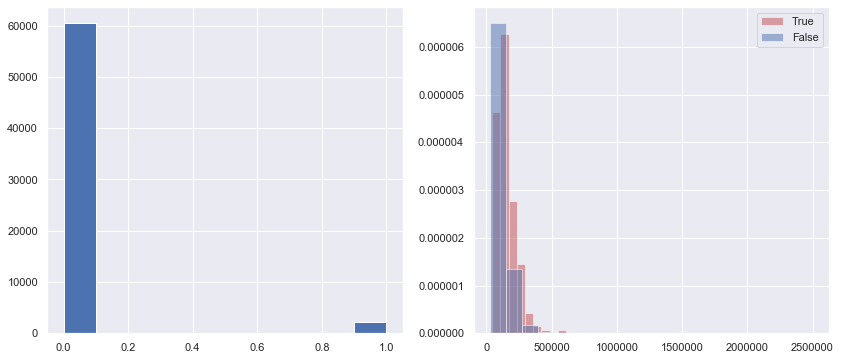

ロフト付き: 2458


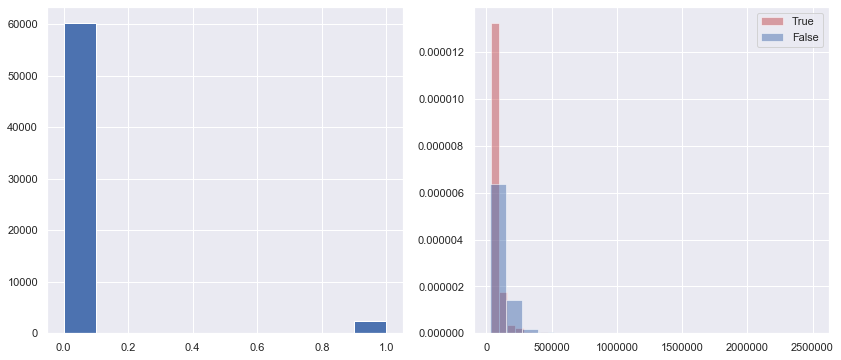

ルーフバルコニー: 658


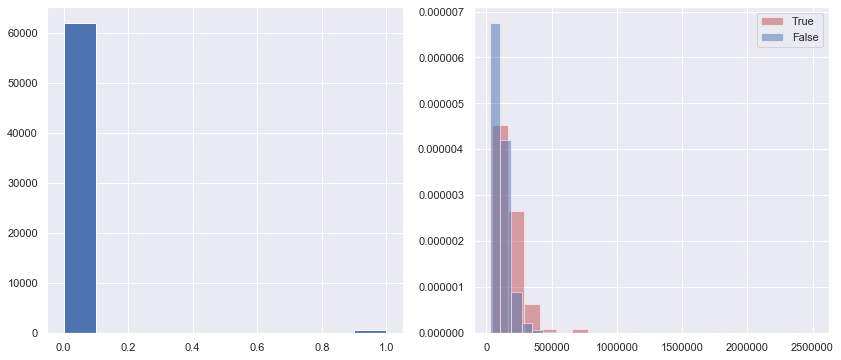

都市ガス: 50801


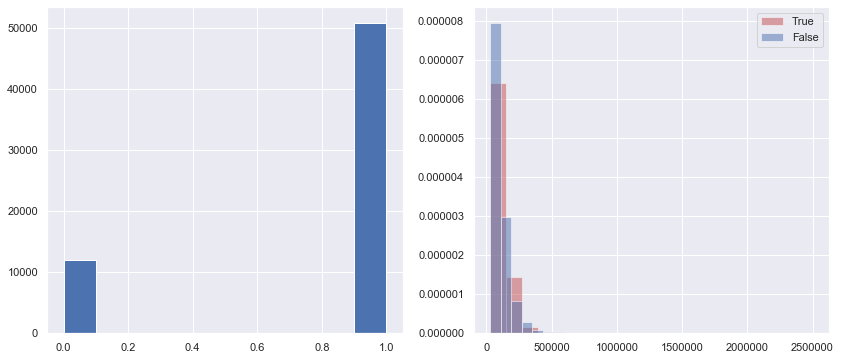

ウォークインクローゼット: 7547


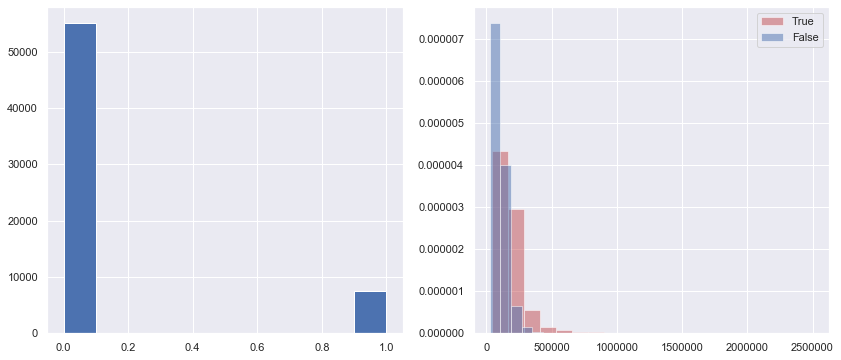

防音室: 120


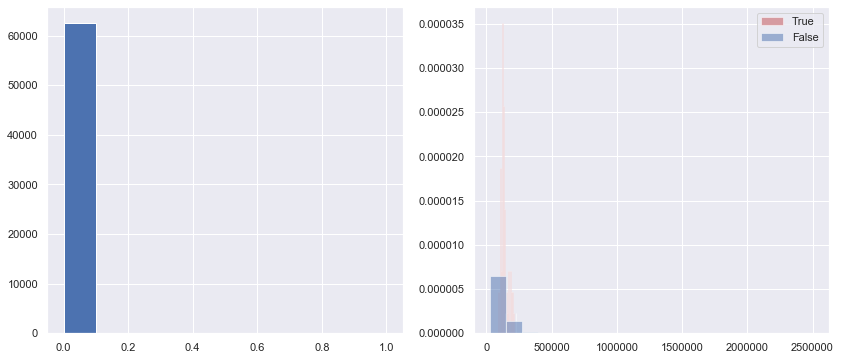

専用庭: 438


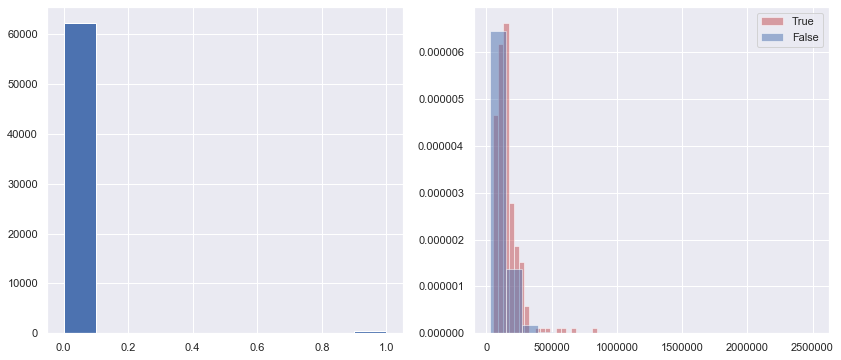

オール電化: 1128


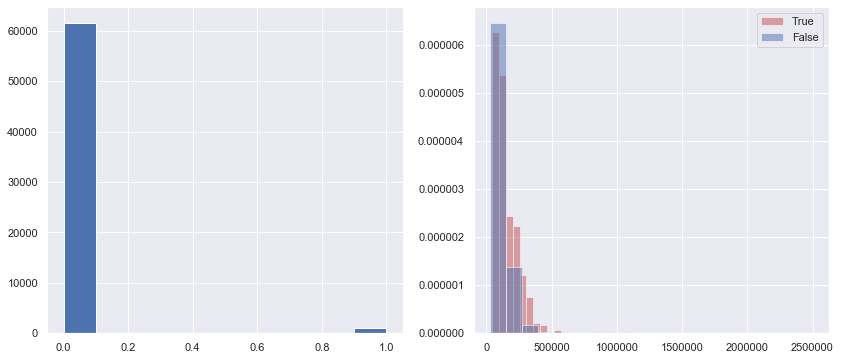

戸建て: 1250


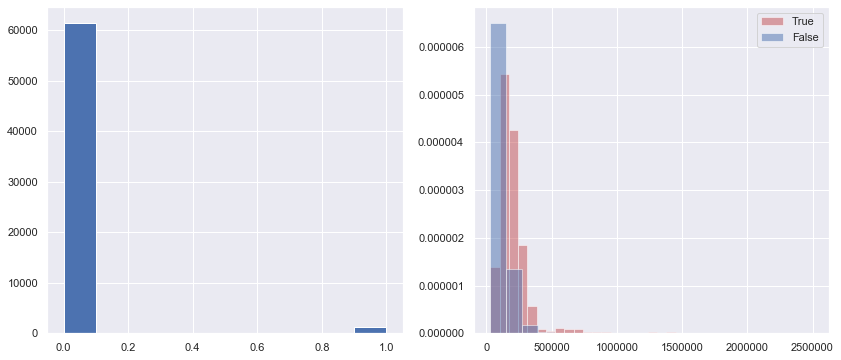

床下収納: 1198


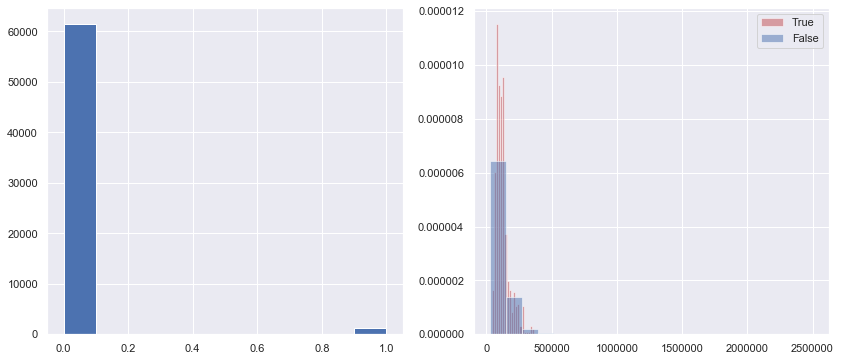

カウンターキッチン: 7478


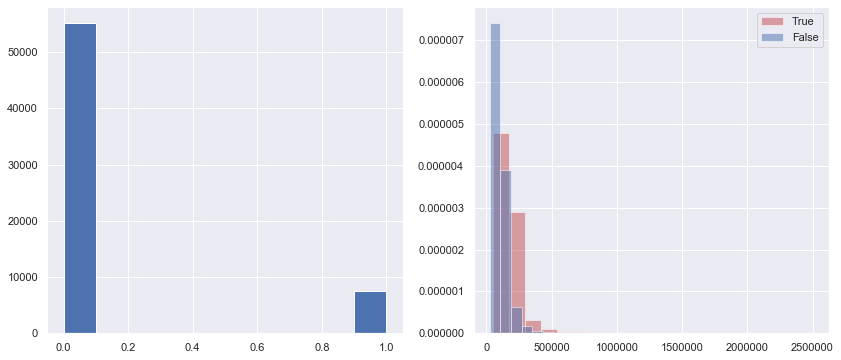

IHコンロ: 8851


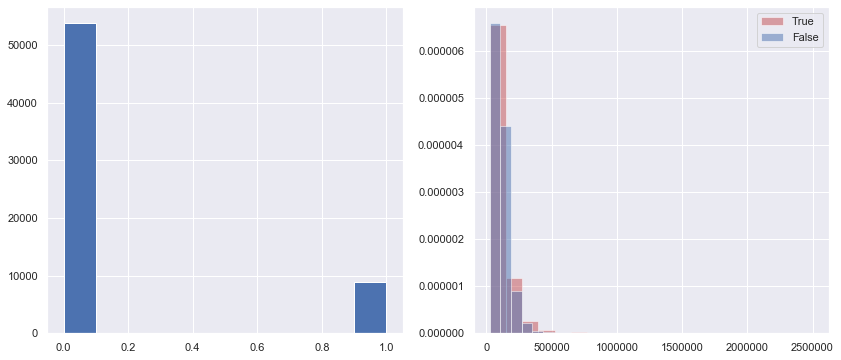

コンロ3口: 11048


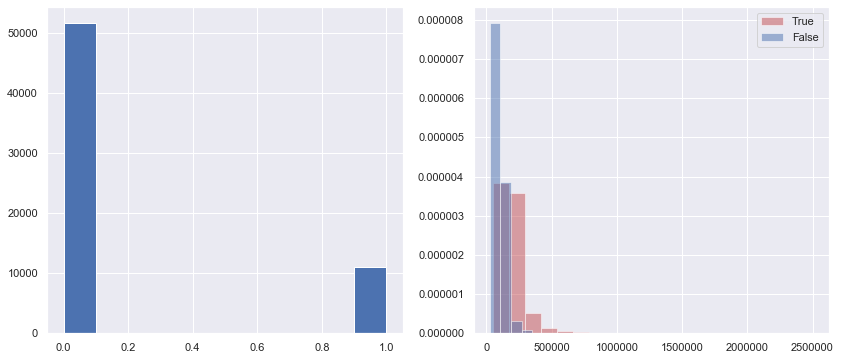

インターネット使用料無料: 10662


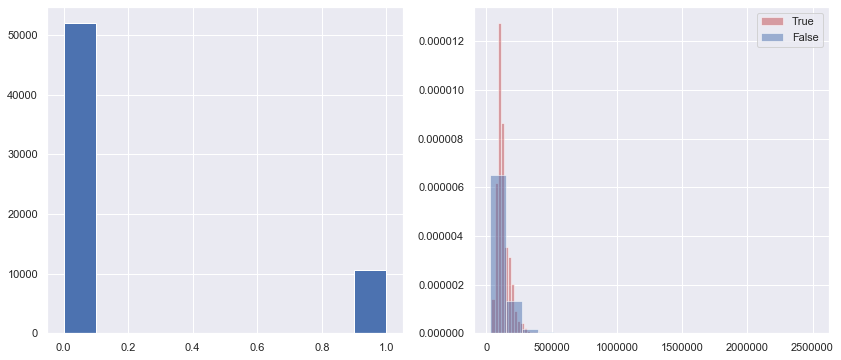

新築: 1739


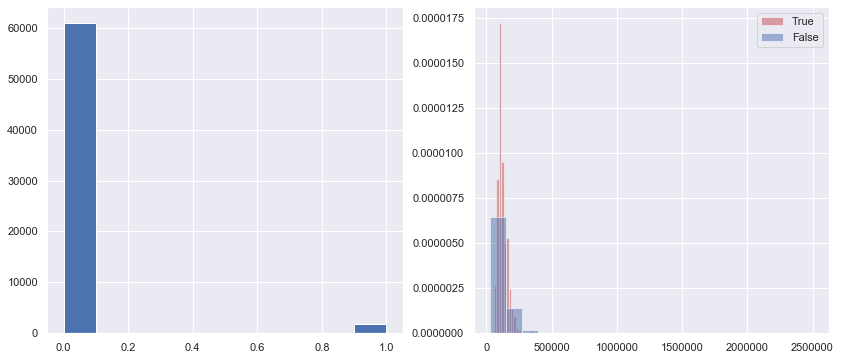

In [621]:
cols = ['3面採光', 'ロフト付き', 'ルーフバルコニー', '都市ガス', 'ウォークインクローゼット', '防音室', '専用庭', 'オール電化', '戸建て', '床下収納', 'カウンターキッチン', 'IHコンロ', 'コンロ3口', 'インターネット使用料無料', '新築']
for col in cols:
    print(col+':', df[col].sum())
    plt.figure(figsize=(14, 6))
    plt.title(col)
    plt.subplot(1,2,1)
    plt.hist(df[col].values)
    plt.subplot(1,2,2)
    plt.hist((df[df[col].astype(bool)]['賃料']).values, 
             bins=20, normed=True,alpha=0.5, color='r', label='True')
    plt.hist((df[~df[col].astype(bool)]['賃料']).values, 
             bins=20, normed=True, alpha=0.5, color='b', label='False')
    plt.legend()
    plt.show()

3面採光: 2159


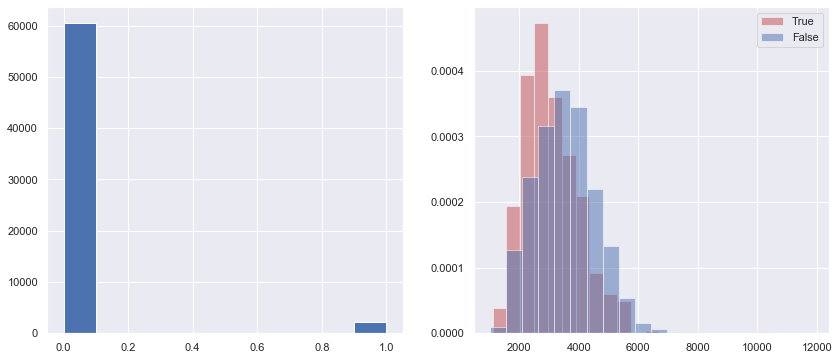

ロフト付き: 2458


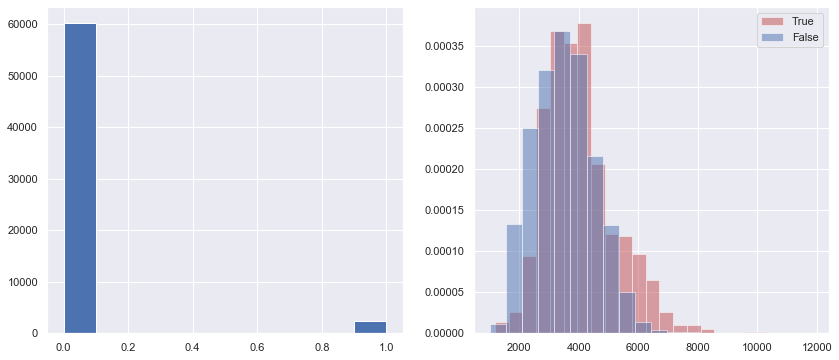

ルーフバルコニー: 658


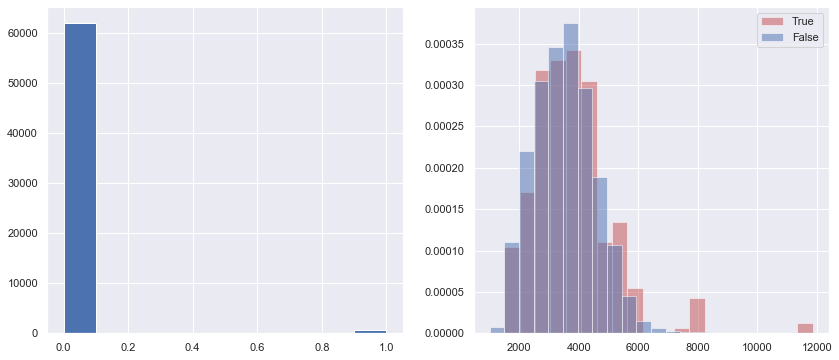

都市ガス: 50801


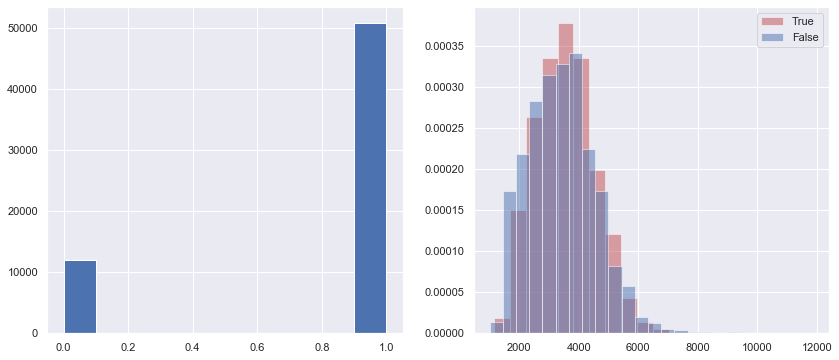

ウォークインクローゼット: 7547


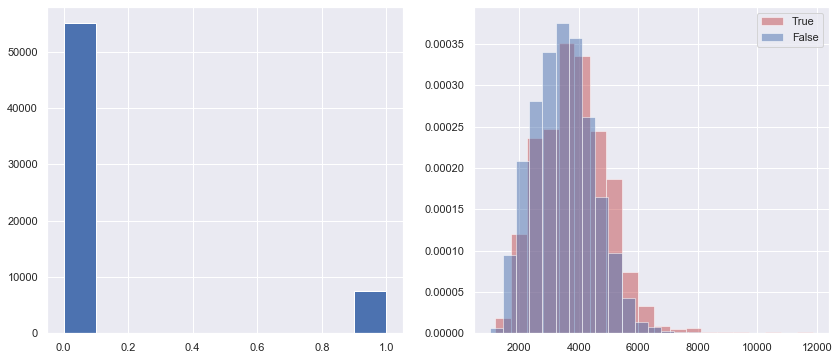

防音室: 120


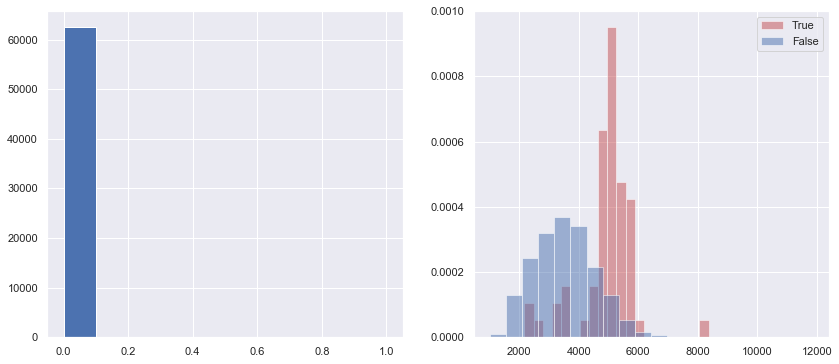

専用庭: 438


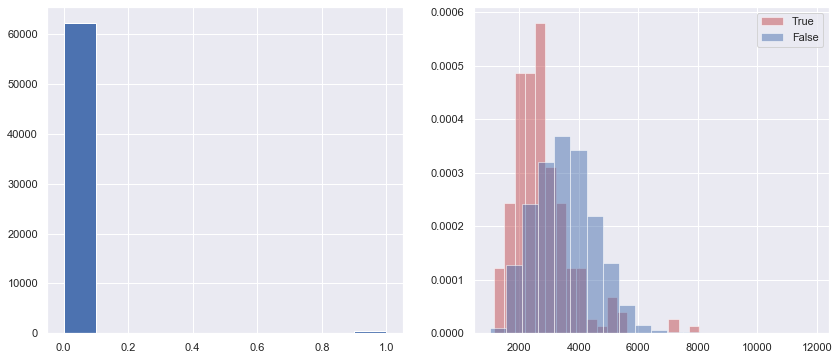

オール電化: 1128


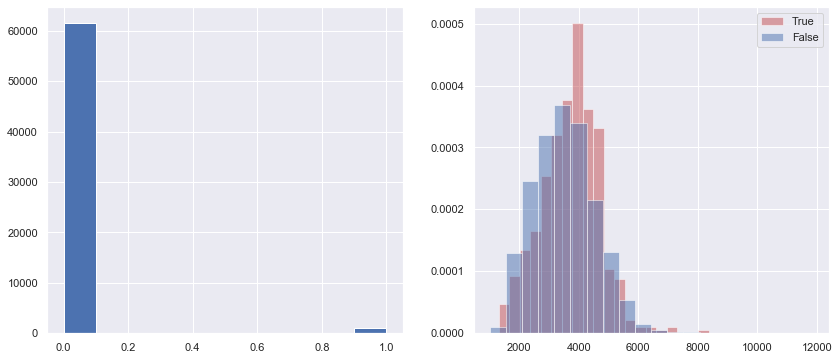

戸建て: 1250


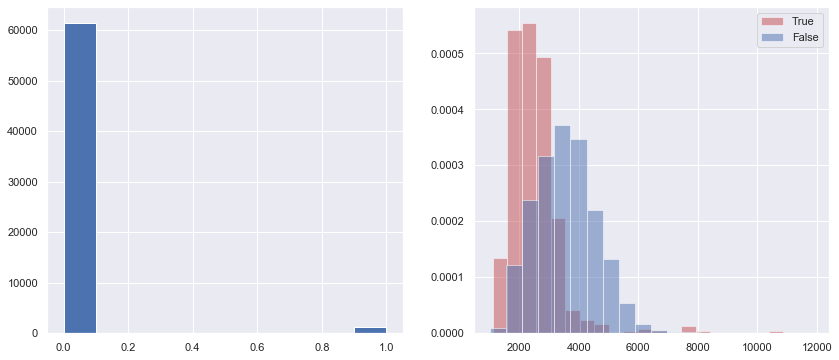

床下収納: 1198


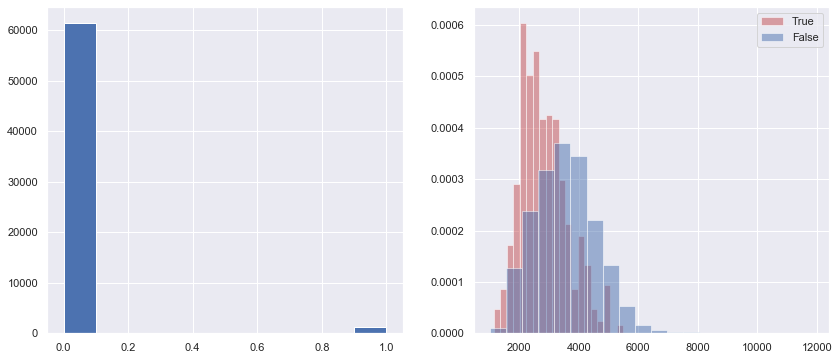

カウンターキッチン: 7478


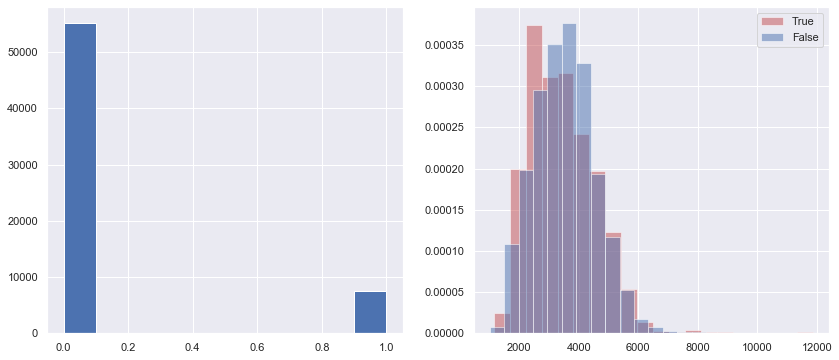

IHコンロ: 8851


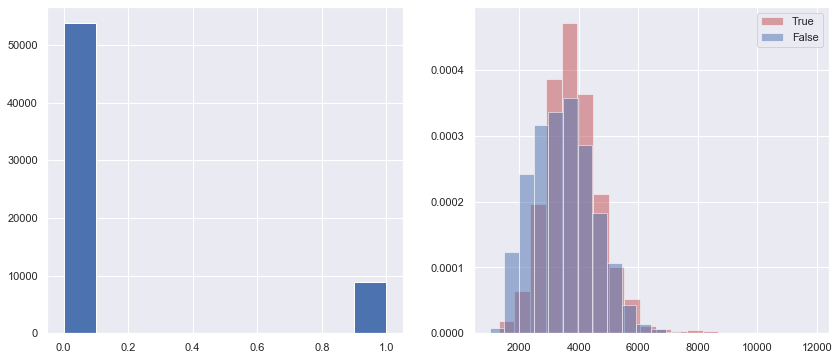

コンロ3口: 11048


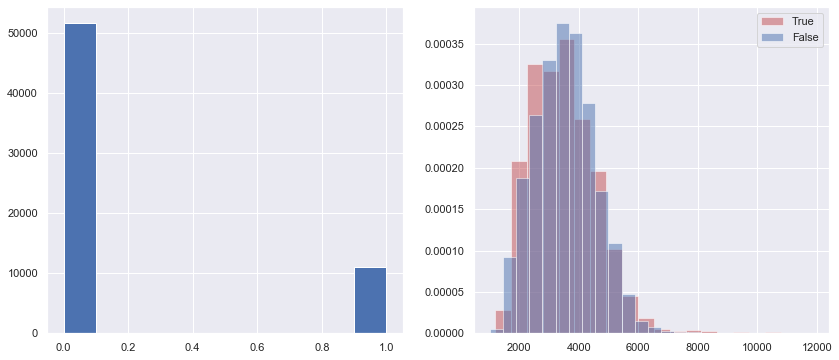

インターネット使用料無料: 10662


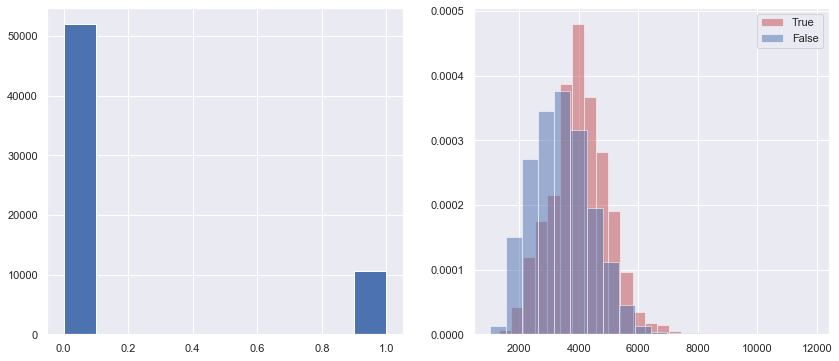

新築: 1739


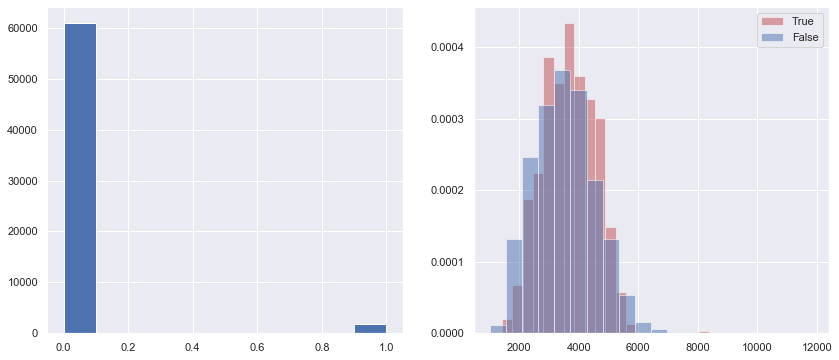

In [605]:
cols = ['3面採光', 'ロフト付き', 'ルーフバルコニー', '都市ガス', 'ウォークインクローゼット', '防音室', '専用庭', 'オール電化', '戸建て', '床下収納', 'カウンターキッチン', 'IHコンロ', 'コンロ3口', 'インターネット使用料無料', '新築']
for col in cols:
    print(col+':', df[col].sum())
    plt.figure(figsize=(14, 6))
    plt.title(col)
    plt.subplot(1,2,1)
    plt.hist(df[col].values)
    plt.subplot(1,2,2)
    plt.hist((df[df[col].astype(bool)]['賃料']/df[df[col].astype(bool)]['面積']).values, 
             bins=20, normed=True,alpha=0.5, color='r', label='True')
    plt.hist((df[~df[col].astype(bool)]['賃料']/df[~df[col].astype(bool)]['面積']).values, 
             bins=20, normed=True, alpha=0.5, color='b', label='False')
    plt.legend()
    plt.show()

In [738]:
pd.get_dummies(df['建物構造']).sum()

ALC（軽量気泡コンクリート）                  577
HPC（プレキャスト・コンクリート（重量鉄骨））          10
PC（プレキャスト・コンクリート（鉄筋コンクリート））      102
RC（鉄筋コンクリート）                   34810
SRC（鉄骨鉄筋コンクリート）                 4792
その他                              268
ブロック                               5
木造                             11062
軽量鉄骨                            3608
鉄筋ブロック                             3
鉄骨造                             7492
dtype: int64

In [497]:
#X_train_ = X_train.copy()
#X_test_ = X_test.copy()

In [786]:
X_train = X_train_.copy()
X_test = X_test_.copy()

In [787]:
# features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階','loc_type_地価_mean',
#              '地価x面積', 'area_diff','area_ratio', 'age_diff', 'age_ratio','area/ageratio', '地価x面積/築年数ratio']

features =  ['面積','築年数',#'sta_min',
             'center_dis', 'L','loc_lat','loc_lon','総階数',
             #'畳',
             '所在階','km_type_with_age_地価_mean', '地価x面積', 'area_diff',
             'area_ratio', 'age_diff', 
             'age_ratio', #'area/ageratio', 
             '地価x面積/築年数ratio', 
             #'地価_neighbor_mean', '地価_neighbor_std', '地価(単位面積)_neighbor_mean', '地価(単位面積)_neighbor_std', 
             '地価_neighbor_1', #'地価(単位面積)_neighbor_1',
             #'利用可能駅数', '利用可能路線数', 
             #'最短駅m', '最短駅乗降人数',
             '利用可能駅最大乗降人数', 
             '上昇率'
            ]
X_train = X_train[features]
X_test = X_test[features]

In [788]:
X_train['wood'] = pd.get_dummies(X_train_['建物構造'])['木造']
X_test['wood'] = pd.get_dummies(X_test_['建物構造'])['木造']

In [789]:
#RegressionPredictorに渡す↓
folder=KFold(n_splits=10, shuffle=True, random_state=421)

### log_predict
今一番精度がいいのがこれ

In [790]:
X_train.columns = X_train.columns.str.encode('utf-8').str.decode('utf-8')
X_test.columns = X_test.columns.str.encode('utf-8').str.decode('utf-8')

In [791]:
cols = ['area', 'age', #'sta_min', 
        'center_dis', 'L', 'loc_lat', 'loc_lon', 'total_floor',
       #'tatami',
       'floor', 'km_type_with_age_area_mean', 'land_pricexarea', 'area_diff',
       'area_ratio', 'age_diff', 
       'age_ratio', #'area/ageratio',
       'land_pricexarea/ageratio', 
       #'lp_neighbor_mean', #'lp_neighbor_std', 'lp(area)_neighbor_mean', 'lp(area)_neighbor_std', 
       'lp_neighbor_1', #'lp(area)_neighbor_1',
       #'avail_station', 'avail_root',
       #'sta_min_m', 'sta_min_people',
        'sta_max_people',
        'upper_rate', 'wood', 
       ]
X_train.columns = cols
X_test.columns = cols

Training on fold 1
Training until validation scores don't improve for 50 rounds
[5000]	training's l1: 0.0187633	valid_1's l1: 0.0522117
[10000]	training's l1: 0.00911334	valid_1's l1: 0.0494128
[15000]	training's l1: 0.00542888	valid_1's l1: 0.0484802
Early stopping, best iteration is:
[19295]	training's l1: 0.00387853	valid_1's l1: 0.0481038
Training on fold 2
Training until validation scores don't improve for 50 rounds
[5000]	training's l1: 0.0187215	valid_1's l1: 0.0500959
[10000]	training's l1: 0.00907318	valid_1's l1: 0.0474741
[15000]	training's l1: 0.00543127	valid_1's l1: 0.0465162
[20000]	training's l1: 0.00372729	valid_1's l1: 0.046093
Early stopping, best iteration is:
[21099]	training's l1: 0.00348167	valid_1's l1: 0.0460306
Training on fold 3
Training until validation scores don't improve for 50 rounds
[5000]	training's l1: 0.0188199	valid_1's l1: 0.0524905
[10000]	training's l1: 0.00927957	valid_1's l1: 0.0493358
[15000]	training's l1: 0.00555803	valid_1's l1: 0.0481171
[

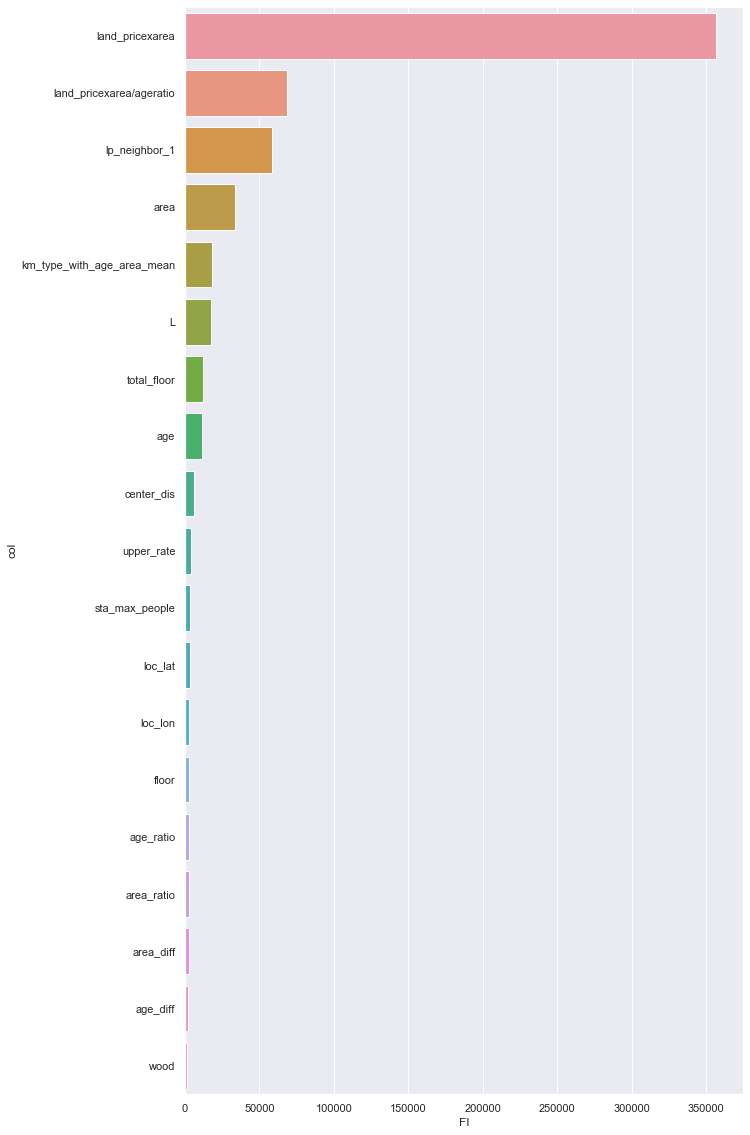

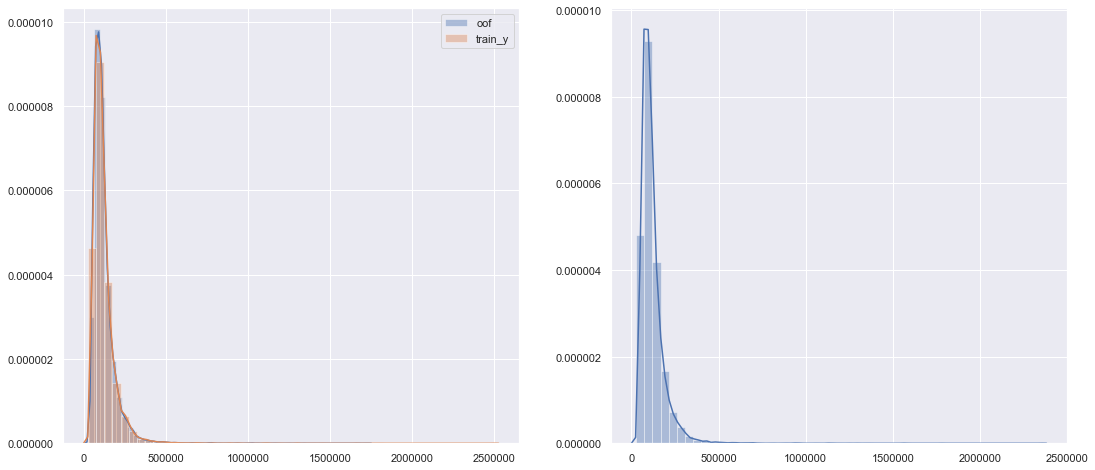

RMSE :  14445.315989473364
R^2 :  0.958947375233024


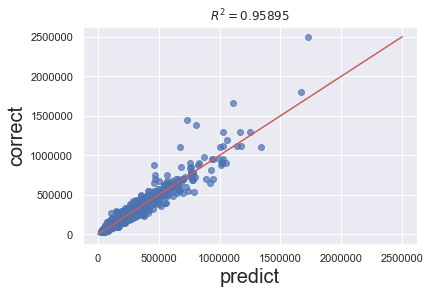

In [792]:
LogLGBM = LogRegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=lgbm_log_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
log_lgboof, log_lgbpreds, log_lgbFIs = LogLGBM.fit()
LogLGBM.plot_FI(50)
LogLGBM.plot_pred_dist()
LogLGBM.plot_scatter_oofvspred()
#15492(100)
#同じくらい(500)
#15440(300)
#15446(400)
#15802(380)
#15553(220)
#15791(990)
#15226(840)
#15541(310)
#15692(630)

In [793]:
X_train_area = X_train_.copy()
X_test_area = X_test_.copy()

In [794]:
# features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階','loc_type_地価_mean',
#              '地価x面積', 'area_diff','area_ratio', 'age_diff', 'age_ratio','area/ageratio', '地価x面積/築年数ratio']

features =  ['面積','築年数',#'sta_min',
             'center_dis',#'L',
             'loc_lat','loc_lon','総階数','畳','所在階','km_type_with_age_地価_mean', '地価x面積', 'area_diff',
             'area_ratio', 'age_diff', 'age_ratio',
             'area/ageratio', '地価x面積/築年数ratio', 
             #'地価_neighbor_mean', '地価_neighbor_std', '地価(単位面積)_neighbor_mean', '地価(単位面積)_neighbor_std', 
             #'地価_neighbor_1', #
             '地価(単位面積)_neighbor_1',
             #'利用可能駅数', '利用可能路線数', 
             '最短駅m', '最短駅乗降人数', '利用可能駅最大乗降人数', 
             #'防音室', '専用庭', 
             #'戸建て', 
             '上昇率'
            ]
X_train_area = X_train_area[features]
X_test_area = X_test_area[features]

In [795]:
X_train_area['wood'] = pd.get_dummies(X_train_['建物構造'])['木造']
X_test_area['wood'] = pd.get_dummies(X_test_['建物構造'])['木造']

In [796]:
#RegressionPredictorに渡す↓
folder=KFold(n_splits=10, shuffle=True, random_state=421)

### log_predict
今一番精度がいいのがこれ

In [797]:
X_train_area.columns = X_train_area.columns.str.encode('utf-8').str.decode('utf-8')
X_test_area.columns = X_test_area.columns.str.encode('utf-8').str.decode('utf-8')

In [798]:
cols = ['area', 'age', #'sta_min', 
        'center_dis', #'L', 
        'loc_lat', 'loc_lon', 'total_floor',
       'tatami', 'floor', 'km_type_with_age_area_mean', 'land_pricexarea', 'area_diff',
       'area_ratio', 'age_diff', 'age_ratio', 'area/ageratio',
       'land_pricexarea/ageratio', 
       #'lp_neighbor_mean', #'lp_neighbor_std', 'lp(area)_neighbor_mean', 'lp(area)_neighbor_std', 
       #'lp_neighbor_1', #
        'lp(area)_neighbor_1',
       #'avail_station', 'avail_root', 
        'sta_min_m', 'sta_min_people', 'sta_max_people', 
        #'no_noise', 'garden', 
        #'house',
        'upper_rate', 'wood'
       ]
X_train_area.columns = cols
X_test_area.columns = cols

In [ ]:
LogLGBM_area = LogRegressionPredictor(X_train_area, y_train_area.values, X_test_area, Folder=folder, params=lgbm_log_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
log_lgboof_area, log_lgbpreds_area, log_lgbFIs_area = LogLGBM_area.fit()
LogLGBM_area.plot_FI(50)
#LogLGBM_area.plot_pred_dist()
#LogLGBM_area.plot_scatter_oofvspred()

Training on fold 1
Training until validation scores don't improve for 50 rounds
[5000]	training's l1: 0.0020599	valid_1's l1: 0.00579969
[10000]	training's l1: 0.00113214	valid_1's l1: 0.00554112
Early stopping, best iteration is:
[12764]	training's l1: 0.000928381	valid_1's l1: 0.0054916
Training on fold 2
Training until validation scores don't improve for 50 rounds
[5000]	training's l1: 0.00206393	valid_1's l1: 0.00561405
Early stopping, best iteration is:
[9636]	training's l1: 0.001178	valid_1's l1: 0.00537635
Training on fold 3
Training until validation scores don't improve for 50 rounds
[5000]	training's l1: 0.00206265	valid_1's l1: 0.00577636
[10000]	training's l1: 0.00114567	valid_1's l1: 0.00550234
Early stopping, best iteration is:
[12853]	training's l1: 0.000931281	valid_1's l1: 0.00544664
Training on fold 4
Training until validation scores don't improve for 50 rounds


In [ ]:
# 評価関数（RMSE）
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [ ]:
#それぞれあんま効いてないやつ削除
print('賃料予測: ', rmse(log_lgboof, y_train))
print('単位面積予測: ', rmse(np.exp(log_lgboof_area)*X_train_area['area'].values, y_train))
print('mean: ', rmse((log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, y_train))
from sklearn.metrics import r2_score
res = pd.DataFrame({'pred': (log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, 'true': y_train})
print('r2 =', r2_score(res['pred'], res['true']))
plt.figure(figsize=(10, 6))
plt.subplot
res.plot.scatter(x='pred', y='true', figsize=(10, 10))
plt.plot([0, 2500000], [0, 2500000], color='r', linewidth=2.5)
plt.xlim(0,2600000)
plt.ylim(0,2600000)
plt.show()

W1107 16:50:28.178091 4598724032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


賃料予測:  14379.312611018491
単位面積予測:  14511.418252416426
mean:  13881.416349206847
r2 = 0.9619166943023212


<Figure size 720x432 with 0 Axes>

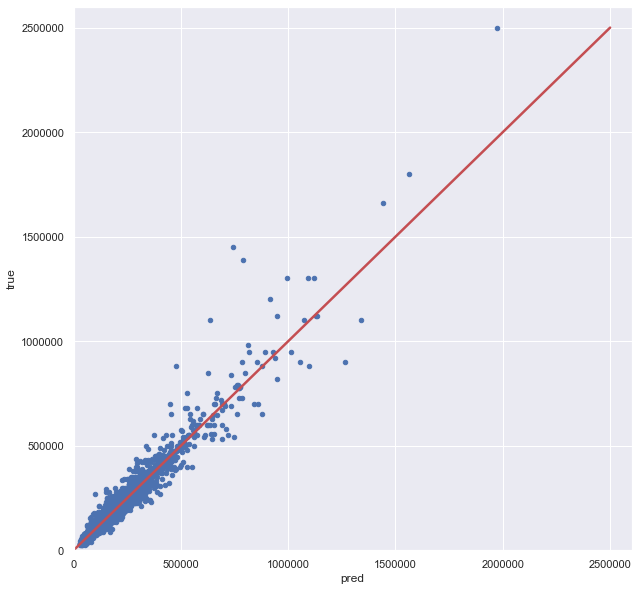

In [756]:
#それぞれあんま効いてないやつ削除
print('賃料予測: ', rmse(log_lgboof, y_train))
print('単位面積予測: ', rmse(np.exp(log_lgboof_area)*X_train_area['area'].values, y_train))
print('mean: ', rmse((log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, y_train))
from sklearn.metrics import r2_score
res = pd.DataFrame({'pred': (log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, 'true': y_train})
print('r2 =', r2_score(res['pred'], res['true']))
plt.figure(figsize=(10, 6))
plt.subplot
res.plot.scatter(x='pred', y='true', figsize=(10, 10))
plt.plot([0, 2500000], [0, 2500000], color='r', linewidth=2.5)
plt.xlim(0,2600000)
plt.ylim(0,2600000)
plt.show()

W1107 16:06:44.674376 4598724032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


賃料予測:  14319.877109165798
単位面積予測:  14477.320031162742
mean:  13887.211237625668
r2 = 0.9618203943431423


<Figure size 720x432 with 0 Axes>

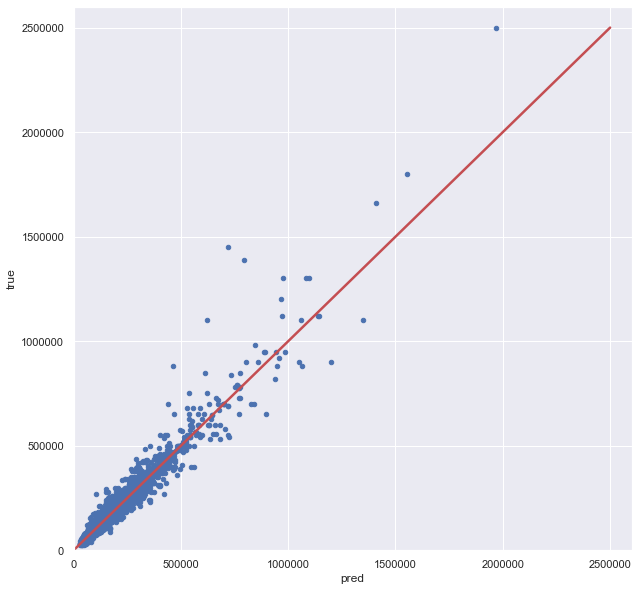

In [700]:
#それぞれあんま効いてないやつ削除
print('賃料予測: ', rmse(log_lgboof, y_train))
print('単位面積予測: ', rmse(np.exp(log_lgboof_area)*X_train_area['area'].values, y_train))
print('mean: ', rmse((log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, y_train))
from sklearn.metrics import r2_score
res = pd.DataFrame({'pred': (log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, 'true': y_train})
print('r2 =', r2_score(res['pred'], res['true']))
plt.figure(figsize=(10, 6))
plt.subplot
res.plot.scatter(x='pred', y='true', figsize=(10, 10))
plt.plot([0, 2500000], [0, 2500000], color='r', linewidth=2.5)
plt.xlim(0,2600000)
plt.ylim(0,2600000)
plt.show()

W1107 15:36:17.085917 4598724032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


賃料予測:  14485.857856261555
単位面積予測:  14477.320031162742
mean:  13950.873173549626
r2 = 0.9614038709436555


<Figure size 720x432 with 0 Axes>

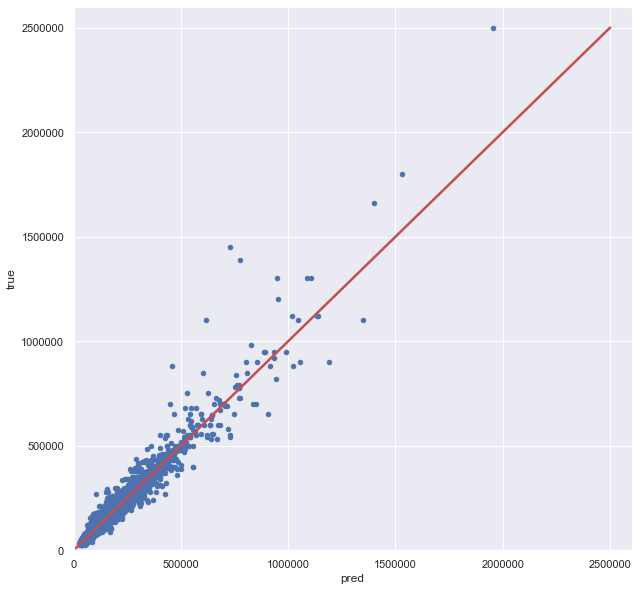

In [680]:
#それぞれあんま効いてないやつ削除
print('賃料予測: ', rmse(log_lgboof, y_train))
print('単位面積予測: ', rmse(np.exp(log_lgboof_area)*X_train_area['area'].values, y_train))
print('mean: ', rmse((log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, y_train))
from sklearn.metrics import r2_score
res = pd.DataFrame({'pred': (log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, 'true': y_train})
print('r2 =', r2_score(res['pred'], res['true']))
plt.figure(figsize=(10, 6))
plt.subplot
res.plot.scatter(x='pred', y='true', figsize=(10, 10))
plt.plot([0, 2500000], [0, 2500000], color='r', linewidth=2.5)
plt.xlim(0,2600000)
plt.ylim(0,2600000)
plt.show()

W1107 15:04:06.228950 4598724032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


賃料予測:  14485.857856261555
単位面積予測:  14477.320031162742
mean:  13950.873173549626
r2 = 0.9614038709436555


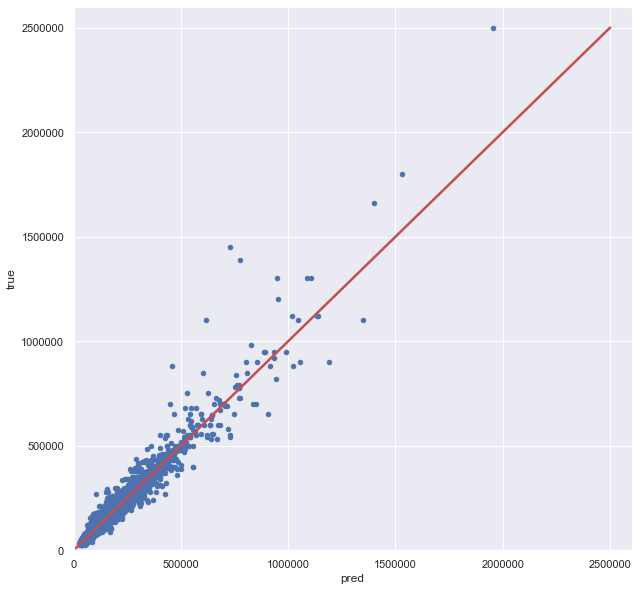

In [648]:
#それぞれあんま効いてないやつ削除
print('賃料予測: ', rmse(log_lgboof, y_train))
print('単位面積予測: ', rmse(np.exp(log_lgboof_area)*X_train_area['area'].values, y_train))
print('mean: ', rmse((log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, y_train))
from sklearn.metrics import r2_score
res = pd.DataFrame({'pred': (log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, 'true': y_train})
print('r2 =', r2_score(res['pred'], res['true']))
plt.figure(figsize=(10, 6))
plt.subplot
res.plot.scatter(x='pred', y='true', figsize=(10, 10))
plt.plot([0, 2500000], [0, 2500000], color='r', linewidth=2.5)
plt.xlim(0,2600000)
plt.ylim(0,2600000)
plt.show()

W1107 14:55:39.761073 4598724032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


賃料予測:  14485.857856261555
単位面積予測:  14370.895856783176
mean:  13855.993843073853
r2 = 0.962003642727743


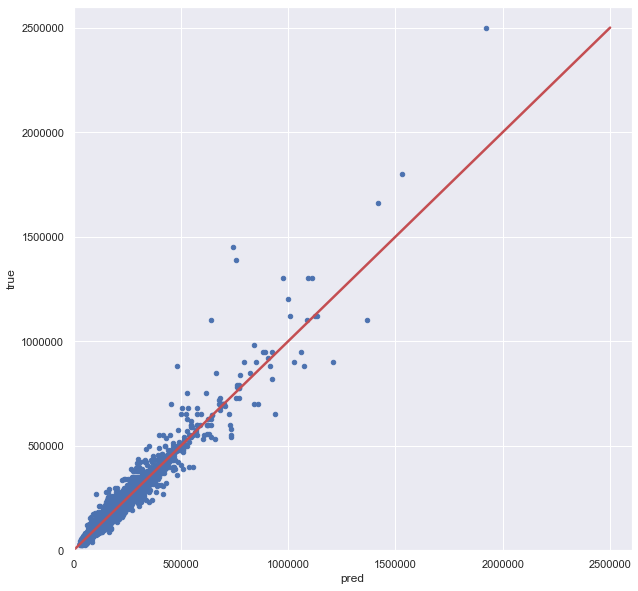

In [640]:
#それぞれあんま効いてないやつ削除
print('賃料予測: ', rmse(log_lgboof, y_train))
print('単位面積予測: ', rmse(np.exp(log_lgboof_area)*X_train_area['area'].values, y_train))
print('mean: ', rmse((log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, y_train))
from sklearn.metrics import r2_score
res = pd.DataFrame({'pred': (log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, 'true': y_train})
print('r2 =', r2_score(res['pred'], res['true']))
res.plot.scatter(x='pred', y='true', figsize=(10, 10))
plt.plot([0, 2500000], [0, 2500000], color='r', linewidth=2.5)
plt.xlim(0,2600000)
plt.ylim(0,2600000)
plt.show()

W1107 14:39:24.606161 4598724032 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


賃料予測:  14499.288309546531
単位面積予測:  14483.874578720155
mean:  13882.728680556613
r2 = 0.9618261759255925


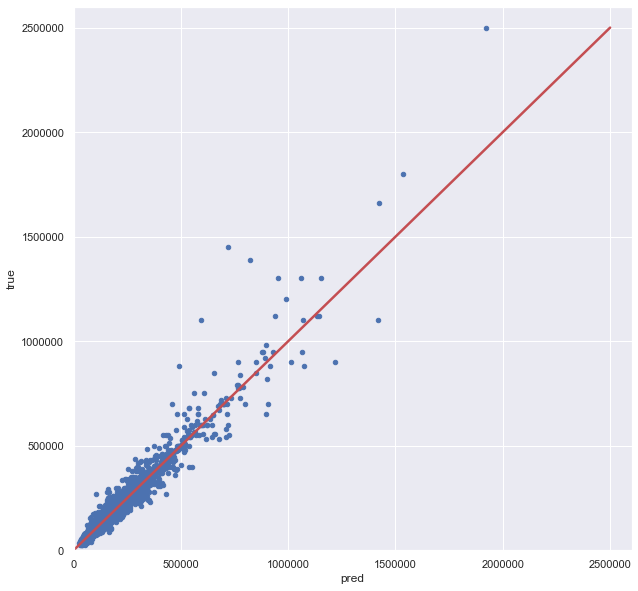

In [620]:
#それぞれあんま効いてないやつ削除
print('賃料予測: ', rmse(log_lgboof, y_train))
print('単位面積予測: ', rmse(np.exp(log_lgboof_area)*X_train_area['area'].values, y_train))
print('mean: ', rmse((log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, y_train))
from sklearn.metrics import r2_score
res = pd.DataFrame({'pred': (log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, 'true': y_train})
print('r2 =', r2_score(res['pred'], res['true']))
res.plot.scatter(x='pred', y='true', figsize=(10, 10))
plt.plot([0, 2500000], [0, 2500000], color='r', linewidth=2.5)
plt.xlim(0,2600000)
plt.ylim(0,2600000)
plt.show()

In [360]:
save_data(X_train,log_lgboof, log_lgbpreds,rmse=LogLGBM.rmse(),name='log_tika_loc_type2',save_dir='./stacking')

id         target
0  31471  132053.917433
1  31472  117256.666903
2  31473   75805.655838
3  31474   60408.675517
4  31475  104576.924170

id         target
0   1   85764.494641
1   2   66001.551324
2   3  105966.359595
3   4  160027.116873
4   5   63334.636205